### Wesley Janson and Drew Keller
## STAT 27420 Final Project
# Modeling Code

In [1]:
# Load in relevant packages

import pandas as pd
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from data_utils import read_data, prep_features, evaluate_predictions, rebin_outcome, summarize_predictions, evaluate_multilevel_predictions
import numpy as np
import matplotlib.pyplot as plt

# set random seed for numpy
RANDOM_SEED=69
np.random.seed(RANDOM_SEED)


DATA_PATH = '../paper_replication_data/new_data.csv'  # Drew's path

In [2]:
from load_data import data, categorical_vars, cts_vars, other_vars

# loading data from online takes ~20 seconds
# to speed up, save data locally and load from there:

#data.to_csv(DATA_PATH,index=False)  # run this once

Excluding 2262 observations that did not answer 1 year price change question.


In [3]:
# Categorical_vars and cts_vars are lists of vars in each category.
# Other_vars are ID and date variables (categorical_vars + cts_vars + other_vars = all vars)

data = read_data(DATA_PATH)  # use this over pd.read_csv, because this handles types

In [4]:
data.treatment_bins.value_counts(dropna=False)  # check that we have a balanced dataset

0-5      185749
5-10      31599
NaN       18725
10-15      6010
15-20      2836
20+        2368
Name: treatment_bins, dtype: int64

In [5]:
data.durable_purchase.value_counts(dropna=False)  # check that we have a balanced dataset

Good          171775
Bad            54240
Don't know     10247
Neutral         9243
Refused         1782
Name: durable_purchase, dtype: int64

***Regression***

In [6]:
# prep features for modeling; use regression=True for regression models
data_regression, treatment_vars, confounder_vars = prep_features(data,regression=True,missing_values='drop cts')  
X = data_regression[confounder_vars+["price_change_amt_next_yr"]]
Y = data_regression['durable_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

Excluding 12029 observations that refused or didn't know durable purchase question.
Excluding 70815 observations that did not answer confounder questions.
Excluding 9476 observations that did not answer price change amount question.


In [7]:
# Model 1a: ordered probit (same as Bachmann et al.) with cts treatment
mod_prob1a = OrderedModel(y_train,X_train,distr='probit')
res_prob1a = mod_prob1a.fit(method='bfgs')
res_prob1a.summary()

Optimization terminated successfully.
         Current function value: 0.613155
         Iterations: 142
         Function evaluations: 143
         Gradient evaluations: 143


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:       durable_purchase   Log-Likelihood:                -76015.
Model:                   OrderedModel   AIC:                         1.521e+05
Method:            Maximum Likelihood   BIC:                         1.524e+05
Date:                Sun, 04 Dec 2022                                         
Time:                        13:23:47                                         
No. Observations:              123973                                         
Df Residuals:                  123939                                         
Df Model:                          34                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
fed_funds_rate                           0.2239      0.006     38.545      0.000       0.212       0.235
unemployment_rate                       -0.1207      0.005    -24.452      0.000      -0.130      -0.111
cpi_1mo_lag                             -0.1546      0.006    -24.690      0.000      -0.167      -0.142
cpi_durable_1mo_lag                     -0.0829      0.006    -14.073      0.000      -0.094      -0.071
personal_finances_next_yr_Don't know    -0.1881      0.031     -5.980      0.000      -0.250      -0.126
personal_finances_next_yr_Refused       -0.2356      0.073     -3.247      0.001      -0.378      -0.093
personal_finances_next_yr_Same          -0.0602      0.009     -6.692      0.000      -0.078      -0.043
personal_finances_next_yr_Worse         -0.1900      0.014    -13.342      0.000      -0.218      -0.162
income_change_amt_next_yr               -0.0332      0.004     -7.873      0.000      -0.041      -0.025
conditions_next_yr_Don't know           -0.1513      0.038     -3.977      0.000      -0.226      -0.077
conditions_next_yr_Refused              -0.1890      0.075     -2.525      0.012      -0.336      -0.042
conditions_next_yr_Same                 -0.0375      0.010     -3.776      0.000      -0.057      -0.018
conditions_next_yr_Worse                -0.2332      0.013    -18.124      0.000      -0.258      -0.208
unemployment_next_yr_Higher             -0.2147      0.064     -3.355      0.001      -0.340      -0.089
unemployment_next_yr_Lower               0.0953      0.064      1.484      0.138      -0.031       0.221
unemployment_next_yr_Refused            -0.1105      0.130     -0.850      0.395      -0.365       0.144
unemployment_next_yr_Same                0.0483      0.064      0.756      0.450      -0.077       0.173
income_quintile_Lower middle            -0.0856      0.013     -6.447      0.000      -0.112      -0.060
income_quintile_Lowest                  -0.1610      0.015    -10.726      0.000      -0.190      -0.132
income_quintile_Middle                  -0.0656      0.012     -5.362      0.000      -0.090      -0.042
income_quintile_Upper middle            -0.0371      0.011     -3.240      0.001      -0.060      -0.015
age                                      0.0137      0.005      2.977      0.003       0.005       0.023
sex_Male                                 0.1023      0.008     12.604      0.000       0.086       0.118
education_Graduate school               -0.0273      0.012     -2.191      0.028      -0.052      -0.003
education_High school                    0.0167      0.012      1.429      0.153      -0.006       0.040
education_No high school                -0.2105      0.031     -6.824      0.000      -0.271      -0.150
education_Partial high school           -0.0260      0.022     -1.179      0.238      -0.069       0.017
education_So

In [8]:
y_test

54211    -1.0
12948     1.0
106443    1.0
179037    1.0
42451     0.0
         ... 
223908    1.0
75890     1.0
239600   -1.0
148680    1.0
37775     1.0
Name: durable_purchase, Length: 30994, dtype: float64

In [9]:
evaluate_predictions(res_prob1a, X_train, X_test, y_train, y_test, regression=True)

Baseline accuracy: 75.71%
Train accuracy: 75.91%
Test accuracy: 76.33%

Test predictions vs actual:


actual  predicted
-1.0    -1             746
         1            5845
 0.0    -1              27
         1             910
 1.0    -1             555
         1           22911
dtype: int64

In [10]:
X = data_regression[confounder_vars+treatment_vars]
Y = data_regression['durable_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

In [11]:
# Model 1b: ordered probit (same as Bachmann et al.) with cts treatment
mod_prob1b = OrderedModel(y_train,X_train,distr='probit')
res_prob1b = mod_prob1b.fit(method='bfgs')
res_prob1b.summary()

Optimization terminated successfully.
         Current function value: 0.613123
         Iterations: 153
         Function evaluations: 154
         Gradient evaluations: 154


/Users/drewkeller/opt/anaconda3/envs/stats/lib/python3.8/site-packages/statsmodels/base/model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:       durable_purchase   Log-Likelihood:                -76011.
Model:                   OrderedModel   AIC:                         1.521e+05
Method:            Maximum Likelihood   BIC:                         1.525e+05
Date:                Sun, 04 Dec 2022                                         
Time:                        13:26:43                                         
No. Observations:              123973                                         
Df Residuals:                  123935                                         
Df Model:                          38                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
fed_funds_rate                           0.2232        nan        nan        nan         nan         nan
unemployment_rate                       -0.1205        nan        nan        nan         nan         nan
cpi_1mo_lag                             -0.1548        nan        nan        nan         nan         nan
cpi_durable_1mo_lag                     -0.0831        nan        nan        nan         nan         nan
personal_finances_next_yr_Don't know    -0.1877        nan        nan        nan         nan         nan
personal_finances_next_yr_Refused       -0.2389        nan        nan        nan         nan         nan
personal_finances_next_yr_Same          -0.0610        nan        nan        nan         nan         nan
personal_finances_next_yr_Worse         -0.1904        nan        nan        nan         nan         nan
income_change_amt_next_yr               -0.0333        nan        nan        nan         nan         nan
conditions_next_yr_Don't know           -0.1510        nan        nan        nan         nan         nan
conditions_next_yr_Refused              -0.1895        nan        nan        nan         nan         nan
conditions_next_yr_Same                 -0.0381        nan        nan        nan         nan         nan
conditions_next_yr_Worse                -0.2334        nan        nan        nan         nan         nan
unemployment_next_yr_Higher             -0.2144        nan        nan        nan         nan         nan
unemployment_next_yr_Lower               0.0961        nan        nan        nan         nan         nan
unemployment_next_yr_Refused            -0.1104        nan        nan        nan         nan         nan
unemployment_next_yr_Same                0.0480        nan        nan        nan         nan         nan
income_quintile_Lower middle            -0.0858        nan        nan        nan         nan         nan
income_quintile_Lowest                  -0.1609        nan        nan        nan         nan         nan
income_quintile_Middle                  -0.0660        nan        nan        nan         nan         nan
income_quintile_Upper middle            -0.0372        nan        nan        nan         nan         nan
age                                      0.0140        nan        nan        nan         nan         nan
sex_Male                                 0.1034        nan        nan        nan         nan         nan
education_Graduate school               -0.0278        nan        nan        nan         nan         nan
education_High school                    0.0167        nan        nan        nan         nan         nan
education_No high school                -0.2118        nan        nan        nan         nan         nan
education_Partial high school           -0.0282        nan        nan        nan         nan         nan
education_So

In [12]:
evaluate_predictions(res_prob1b, X_train, X_test, y_train, y_test, regression=True)

Baseline accuracy: 75.71%
Train accuracy: 75.94%
Test accuracy: 76.31%

Test predictions vs actual:


actual  predicted
-1.0    -1             742
         1            5849
 0.0    -1              24
         1             913
 1.0    -1             555
         1           22911
dtype: int64

***Classification with XGBoost***

In [3]:
data_xgboost, treatment_vars, confounder_vars = prep_features(data,regression=False,missing_values='retain all')  

Excluding 12029 observations that refused or didn't know durable purchase question.
Excluding 16763 observations that did not answer price change amount question.


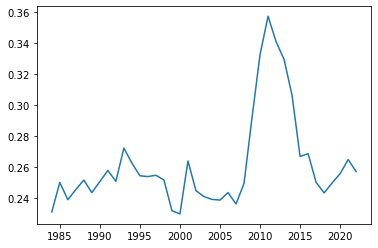

In [14]:
# only income_change_amt_next_yr has many missing values within our chosen cts confounders

# calculate percent missing for income_change_amt_next_yr by year 
pct_missing = data['income_change_amt_next_yr'].isnull().groupby(data.date.dt.year).agg(['mean','count'])
plt.plot(pct_missing["mean"])

In [15]:
# try dropping income_change_amt_next_yr
data_xgboost.drop(columns=['income_change_amt_next_yr'],inplace=True)  
confounder_vars.remove('income_change_amt_next_yr')

In [16]:
# Model 2: XGBoost with binned treatment

X = data_xgboost[confounder_vars+treatment_vars]
Y = data_xgboost['durable_purchase']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
model2 = xgb.XGBClassifier(learning_rate=0.07,max_depth=6,n_estimators=120,min_child_weight=3)
model2.fit(X_train, y_train)

/Users/drewkeller/opt/anaconda3/envs/stats/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=120, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
evaluate_predictions(model2, X_train, X_test, y_train, y_test)

Baseline accuracy: 73.88%
Train accuracy: 75.65%
Test accuracy: 74.93%

Test predictions vs actual:


actual  predicted
0       0             1502
        2             8278
1       0               91
        2             1544
2       0             1042
        2            31242
dtype: int64

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

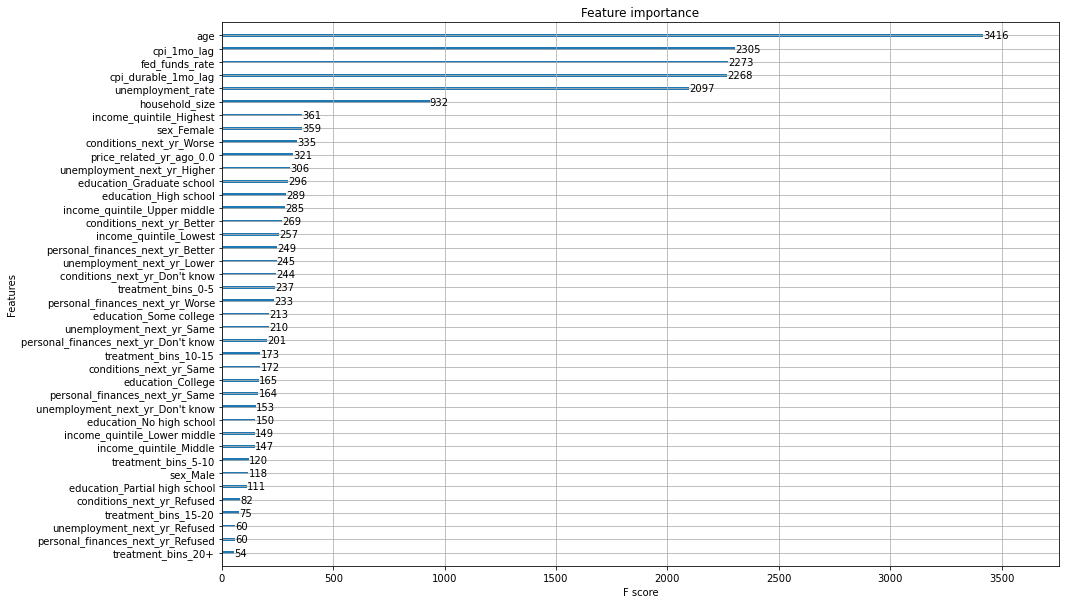

In [30]:
plt.rcParams['figure.figsize'] = [15, 10]
xgb.plot_importance(model2)

In [31]:
data_xgboost, treatment_vars, confounder_vars = prep_features(data,regression=False,missing_values='retain all')  

Excluding 12029 observations that refused or didn't know durable purchase question.
Excluding 16763 observations that did not answer price change amount question.


In [32]:
# try multiple classifiers

data_xgboost = rebin_outcome(data_xgboost)
X = data_xgboost[confounder_vars+treatment_vars]
Y = data_xgboost[['durable_purchase','durable_good','durable_bad']]
Xa, Xb, ya, yb = train_test_split(X, Y, test_size=0.5, random_state=7)  # just switch train and test
ya_good = ya['durable_good']
ya_bad = ya['durable_bad']
yb_good = yb['durable_good']
yb_bad = yb['durable_bad']

model3a = xgb.XGBClassifier(
    learning_rate=0.07,max_depth=4,n_estimators=120,min_child_weight=1,
    eval_metric='logloss',use_label_encoder=False)
model3a.fit(Xa, ya_good)

model3b = xgb.XGBClassifier(
    learning_rate=0.07,max_depth=4,n_estimators=120,min_child_weight=1,
    eval_metric='logloss',use_label_encoder=False)
model3b.fit(Xb, yb_bad)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.07, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=120, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [36]:
ya_pred = model3a.predict(Xb)
yb_pred = model3b.predict(Xa)
print(pd.DataFrame([ya_pred,yb_pred]).T.value_counts().to_dict())
print(yb_good.value_counts(normalize=True))
print(pd.Series(ya_pred).value_counts(normalize=True))
print(ya_bad.value_counts(normalize=True))
print(pd.Series(yb_pred).value_counts(normalize=True))

{(1.0, 0.0): 97091, (0.0, 0.0): 6595, (1.0, 1.0): 5183, (0.0, 1.0): 378}
1    0.73897
0    0.26103
Name: durable_good, dtype: float64
1    0.936173
0    0.063827
dtype: float64
0    0.77506
1    0.22494
Name: durable_bad, dtype: float64
0    0.949097
1    0.050903
dtype: float64


In [38]:
ya_pred = model3a.predict(Xa)
yb_pred = model3b.predict(Xb)
print(pd.DataFrame([ya_pred,yb_pred]).T.value_counts().to_dict())
print(ya_good.value_counts(normalize=True))
print(pd.Series(ya_pred).value_counts(normalize=True))
print(yb_bad.value_counts(normalize=True))
print(pd.Series(yb_pred).value_counts(normalize=True))

{(1.0, 0.0): 97016, (0.0, 0.0): 6681, (1.0, 1.0): 5154, (0.0, 1.0): 396}
1    0.737521
0    0.262479
Name: durable_good, dtype: float64
1    0.93522
0    0.06478
dtype: float64
0    0.775611
1    0.224389
Name: durable_bad, dtype: float64
0    0.949198
1    0.050802
dtype: float64


In [39]:
data_xgboost = rebin_outcome(data_xgboost)
X = data_xgboost[confounder_vars+treatment_vars]
Y = data_xgboost[['durable_purchase','durable_good','durable_bad']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
ya_train = y_train['durable_good']
yb_train = y_train['durable_bad']
ya_test = y_test['durable_good']
yb_test = y_test['durable_bad']

model3a = xgb.XGBClassifier(
    learning_rate=0.07,max_depth=4,n_estimators=120,min_child_weight=1,
    eval_metric='logloss',use_label_encoder=False)
model3a.fit(X_train, np.array(ya_train).astype(int))

model3b = xgb.XGBClassifier(
    learning_rate=0.05,max_depth=5,n_estimators=150,min_child_weight=3,
    eval_metric='logloss',use_label_encoder=False)
model3b.fit(X_train, np.array(yb_train).astype(int))

evaluate_multilevel_predictions(model3a, model3b, X_train, X_test, y_train, y_test)

Baseline accuracy: 73.88%
Train accuracy: 74.46%
Test accuracy: 74.17%

Test predictions vs actual:


actual  predicted
0       -1              37
         0            1247
         1             303
         2            8193
1       -1               1
         0              75
         1              31
         2            1528
2       -1              29
         0             809
         1             314
         2           31132
dtype: int64

***Classification with NN***

In [ ]:
# model 3: large neural network just to see if we can overfit at least
model3 = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000)
model3.fit(X_train, y_train)

In [ ]:
num_params = sum([coef.shape[0] * coef.shape[1] for coef in model3.coefs_])
num_params += sum([intercept.shape[0] for intercept in model3.intercepts_])
num_params

15603

In [ ]:
evaluate_predictions(model3, X_train, X_test, y_train, y_test,regression=False)

Baseline accuracy: 71.63%
Train accuracy: 76.52%
Test accuracy: 70.52%

Test predictions vs actual:


actual  predicted
0.0     0             3076
        1              109
        2             9738
1.0     0              307
        1               30
        2             1916
2.0     0             3495
        1              206
        2            34619
dtype: int64

## Helper Functions

In [10]:
# Conditional outcome models (Q models)
def make_Q_model():
    ''' A function that returns a general ML q model for later use in k-folding'''
    return xgb.XGBClassifier()

# Propensity score models (g models)
def make_g_model():
    ''' A function that returns a g model for computing propensity scores'''
    return xgb.XGBClassifier()

In [7]:
# Functions for K-fold cross-fitting
def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    '''
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    '''

    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    kf.split(X, A)
    for train_index, test_index in kf.split(X, A):
        X_train = X.loc[train_index]
        A_train = A.loc[train_index]
        g = make_model()
        g.fit(X_train, A_train)

        # get predictions for split
        predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]
    
    # sanity check that overlap holds
    assert np.isnan(predictions).sum() == 0
    return predictions

def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str):
    '''
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"
    '''

    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point 
    X0 = X_w_treatment.copy()
    X0["A"] = 0
    X1 = X_w_treatment.copy()
    X1["A"] = 1
    X2 = X_w_treatment.copy()
    X2["A"] = 2
    X3 = X_w_treatment.copy()
    X3["A"] = 3
    X4 = X_w_treatment.copy()
    X4["A"] = 4

    
    for train_index, test_index in kf.split(X_w_treatment, y):
        X_train = X_w_treatment.loc[train_index]
        y_train = y.loc[train_index]
        q = make_model()
        q.fit(X_train, y_train)

        if output_type =='binary':
            predictions0[test_index] = q.predict_proba(X0.loc[test_index])[:, 1]
            predictions1[test_index] = q.predict_proba(X1.loc[test_index])[:, 1]
        elif output_type == 'continuous':
            predictions0[test_index] = q.predict(X0.loc[test_index])
            predictions1[test_index] = q.predict(X1.loc[test_index])


    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

In [11]:
# Fit Q(X,A) model
# get conditional outcomes
# Q0_lm, Q1_lm = outcome_k_fold_fit_and_predict(make_Q_model, X=confounders, y=outcome, A=treatment, \
#                                         n_splits=5, output_type="continuous")

# Fit g(x) models
g = treatment_k_fold_fit_and_predict(make_g_model, X=data_xgboost[confounder_vars], A=data_xgboost["treatment_bins"], n_splits=5)

KeyError: '[2, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 57, 58, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 75, 76, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 103, 105, 106, 107, 108, 109, 110, 111, 112, 115, 116, 118, 119, 120, 121, 122, 123, 124, 127, 129, 130, 131, 132, 134, 135, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 169, 171, 172, 173, 174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 212, 214, 215, 216, 219, 220, 221, 222, 223, 224, 225, 226, 228, 230, 231, 232, 233, 234, 235, 236, 238, 239, 240, 241, 242, 243, 245, 246, 248, 249, 250, 251, 252, 253, 254, 257, 259, 260, 261, 262, 263, 264, 268, 269, 270, 271, 272, 273, 274, 275, 276, 278, 279, 280, 282, 283, 284, 285, 286, 287, 288, 289, 291, 292, 293, 294, 296, 297, 298, 299, 301, 302, 304, 305, 307, 309, 310, 312, 313, 314, 315, 316, 317, 318, 319, 320, 323, 324, 326, 327, 328, 329, 330, 331, 332, 334, 335, 337, 338, 339, 340, 342, 343, 344, 345, 347, 348, 349, 350, 351, 353, 354, 355, 356, 357, 358, 360, 361, 362, 364, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 386, 387, 388, 389, 390, 391, 393, 394, 397, 398, 402, 403, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 417, 418, 419, 420, 421, 422, 423, 424, 427, 428, 430, 433, 434, 435, 436, 438, 439, 440, 441, 442, 443, 444, 446, 447, 448, 449, 450, 452, 453, 455, 457, 458, 459, 460, 461, 462, 463, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 480, 484, 485, 486, 487, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 517, 518, 520, 522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 556, 557, 558, 559, 561, 562, 565, 566, 567, 568, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 589, 591, 594, 595, 596, 598, 600, 601, 603, 605, 606, 607, 608, 609, 610, 612, 614, 615, 617, 618, 619, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 643, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 658, 660, 661, 662, 663, 665, 668, 672, 673, 674, 675, 677, 678, 679, 680, 681, 682, 683, 684, 686, 688, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 703, 704, 705, 707, 708, 710, 712, 713, 715, 716, 717, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 730, 732, 733, 734, 736, 740, 741, 742, 743, 744, 745, 746, 747, 752, 753, 754, 756, 757, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 773, 774, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 787, 788, 789, 792, 794, 796, 797, 798, 799, 804, 805, 806, 808, 809, 810, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 823, 824, 825, 826, 827, 828, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 845, 846, 847, 848, 850, 851, 853, 854, 855, 856, 857, 858, 860, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 876, 877, 879, 880, 881, 882, 884, 885, 887, 888, 889, 890, 891, 893, 894, 896, 897, 898, 899, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 914, 915, 916, 917, 918, 920, 921, 923, 924, 925, 929, 930, 931, 932, 933, 934, 936, 938, 939, 941, 942, 943, 946, 947, 948, 949, 951, 952, 953, 955, 957, 958, 959, 961, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 999, 1000, 1001, 1002, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1022, 1023, 1024, 1025, 1026, 1028, 1030, 1031, 1032, 1033, 1034, 1036, 1037, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1059, 1060, 1061, 1063, 1064, 1066, 1067, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1104, 1105, 1106, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1123, 1124, 1125, 1126, 1128, 1129, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1141, 1142, 1143, 1144, 1145, 1146, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1163, 1164, 1165, 1166, 1167, 1168, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1179, 1180, 1181, 1183, 1184, 1185, 1187, 1188, 1189, 1190, 1192, 1193, 1194, 1195, 1196, 1197, 1200, 1201, 1202, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1215, 1216, 1217, 1219, 1220, 1221, 1222, 1223, 1224, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1238, 1239, 1240, 1241, 1242, 1245, 1246, 1247, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1258, 1259, 1262, 1264, 1266, 1267, 1268, 1269, 1270, 1271, 1273, 1275, 1276, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1287, 1288, 1289, 1290, 1292, 1294, 1296, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1311, 1312, 1313, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1325, 1326, 1327, 1328, 1329, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1372, 1373, 1376, 1379, 1380, 1381, 1383, 1384, 1386, 1387, 1389, 1390, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1417, 1418, 1419, 1421, 1422, 1423, 1424, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1438, 1439, 1442, 1443, 1444, 1445, 1446, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1505, 1506, 1507, 1508, 1509, 1511, 1512, 1513, 1514, 1516, 1517, 1519, 1520, 1523, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1538, 1541, 1542, 1543, 1544, 1546, 1547, 1549, 1550, 1551, 1552, 1554, 1555, 1556, 1557, 1558, 1559, 1561, 1563, 1564, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1594, 1595, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1610, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1622, 1623, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1656, 1657, 1659, 1660, 1661, 1664, 1665, 1666, 1667, 1668, 1671, 1672, 1673, 1674, 1678, 1679, 1680, 1682, 1683, 1685, 1686, 1687, 1688, 1689, 1690, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1700, 1701, 1702, 1704, 1706, 1707, 1708, 1709, 1710, 1713, 1714, 1715, 1716, 1717, 1720, 1721, 1722, 1723, 1724, 1725, 1727, 1728, 1729, 1730, 1731, 1732, 1735, 1736, 1737, 1739, 1740, 1744, 1746, 1747, 1748, 1749, 1750, 1752, 1756, 1757, 1758, 1759, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1776, 1777, 1778, 1779, 1780, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1814, 1815, 1816, 1817, 1818, 1820, 1822, 1823, 1825, 1826, 1827, 1828, 1829, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1839, 1840, 1843, 1844, 1846, 1847, 1848, 1849, 1850, 1851, 1853, 1855, 1856, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1874, 1875, 1876, 1877, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1888, 1890, 1891, 1892, 1894, 1896, 1897, 1898, 1900, 1901, 1902, 1903, 1905, 1907, 1908, 1909, 1911, 1915, 1916, 1918, 1919, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1929, 1931, 1933, 1934, 1935, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1973, 1974, 1975, 1976, 1977, 1978, 1980, 1982, 1983, 1984, 1986, 1987, 1988, 1989, 1991, 1992, 1993, 1994, 1997, 1998, 2000, 2001, 2002, 2004, 2005, 2007, 2008, 2010, 2012, 2014, 2015, 2016, 2017, 2019, 2020, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2031, 2032, 2033, 2034, 2035, 2037, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2050, 2051, 2054, 2055, 2056, 2057, 2059, 2060, 2061, 2062, 2063, 2065, 2066, 2067, 2068, 2069, 2070, 2072, 2073, 2074, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2089, 2092, 2093, 2094, 2095, 2096, 2098, 2099, 2100, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2110, 2111, 2112, 2113, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2130, 2131, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2180, 2182, 2183, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2222, 2223, 2224, 2225, 2227, 2228, 2229, 2231, 2232, 2233, 2234, 2236, 2238, 2240, 2241, 2242, 2243, 2246, 2247, 2248, 2249, 2250, 2251, 2253, 2255, 2256, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2268, 2269, 2270, 2271, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2282, 2283, 2284, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2327, 2328, 2329, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2343, 2344, 2345, 2346, 2348, 2349, 2350, 2352, 2353, 2354, 2356, 2358, 2362, 2364, 2365, 2367, 2369, 2371, 2372, 2373, 2374, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2413, 2414, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2425, 2426, 2427, 2428, 2429, 2430, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2445, 2447, 2448, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2459, 2461, 2463, 2464, 2465, 2466, 2467, 2468, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2478, 2479, 2480, 2481, 2482, 2483, 2485, 2486, 2487, 2488, 2490, 2491, 2492, 2493, 2495, 2498, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2517, 2518, 2519, 2520, 2521, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2535, 2536, 2537, 2538, 2539, 2541, 2542, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2553, 2554, 2555, 2556, 2558, 2559, 2561, 2562, 2563, 2564, 2566, 2569, 2571, 2572, 2573, 2574, 2575, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2588, 2589, 2591, 2592, 2593, 2594, 2597, 2598, 2599, 2600, 2601, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2613, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2642, 2643, 2645, 2646, 2647, 2648, 2649, 2652, 2653, 2654, 2655, 2656, 2657, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2668, 2670, 2671, 2673, 2675, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2692, 2694, 2695, 2696, 2698, 2699, 2700, 2701, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2716, 2717, 2718, 2719, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2734, 2735, 2737, 2741, 2742, 2743, 2745, 2746, 2747, 2748, 2749, 2750, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2761, 2762, 2765, 2766, 2768, 2769, 2770, 2771, 2772, 2774, 2775, 2777, 2778, 2779, 2780, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2796, 2797, 2799, 2800, 2801, 2802, 2803, 2805, 2806, 2807, 2808, 2809, 2810, 2812, 2813, 2815, 2816, 2817, 2819, 2820, 2821, 2822, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2832, 2834, 2835, 2836, 2837, 2838, 2840, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2859, 2860, 2861, 2863, 2864, 2865, 2866, 2867, 2869, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2880, 2881, 2883, 2886, 2887, 2888, 2889, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2918, 2919, 2920, 2921, 2923, 2924, 2925, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2938, 2939, 2940, 2941, 2943, 2944, 2946, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2956, 2958, 2959, 2960, 2961, 2962, 2963, 2965, 2966, 2967, 2968, 2969, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2985, 2987, 2988, 2989, 2991, 2992, 2993, 2994, 2996, 2998, 2999, 3000, 3001, 3003, 3004, 3005, 3006, 3007, 3009, 3012, 3013, 3014, 3016, 3017, 3018, 3019, 3020, 3022, 3023, 3025, 3026, 3028, 3030, 3031, 3033, 3035, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3045, 3046, 3048, 3049, 3051, 3052, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3071, 3072, 3073, 3075, 3076, 3077, 3078, 3079, 3080, 3082, 3083, 3085, 3086, 3087, 3089, 3090, 3092, 3094, 3095, 3096, 3097, 3098, 3099, 3101, 3102, 3104, 3105, 3106, 3107, 3108, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3122, 3123, 3124, 3126, 3127, 3130, 3131, 3133, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3190, 3191, 3192, 3193, 3194, 3195, 3197, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3209, 3210, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3222, 3223, 3224, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3236, 3237, 3238, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3251, 3252, 3253, 3254, 3256, 3257, 3259, 3260, 3261, 3262, 3263, 3264, 3266, 3267, 3268, 3269, 3270, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3281, 3282, 3283, 3284, 3287, 3288, 3289, 3290, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3303, 3304, 3305, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3319, 3320, 3321, 3322, 3324, 3325, 3326, 3327, 3328, 3331, 3332, 3333, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3347, 3348, 3350, 3351, 3352, 3353, 3354, 3356, 3357, 3359, 3361, 3362, 3363, 3364, 3365, 3367, 3369, 3370, 3371, 3372, 3374, 3375, 3376, 3377, 3378, 3380, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3391, 3392, 3393, 3394, 3396, 3397, 3398, 3399, 3401, 3402, 3403, 3405, 3407, 3410, 3411, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3439, 3440, 3442, 3444, 3445, 3446, 3447, 3448, 3449, 3451, 3452, 3454, 3455, 3456, 3457, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3467, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3478, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3488, 3489, 3491, 3492, 3493, 3494, 3496, 3497, 3499, 3500, 3501, 3502, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3519, 3520, 3524, 3525, 3526, 3527, 3529, 3530, 3531, 3532, 3533, 3534, 3537, 3539, 3541, 3542, 3543, 3545, 3546, 3547, 3548, 3549, 3550, 3552, 3553, 3555, 3556, 3557, 3559, 3560, 3561, 3562, 3565, 3567, 3569, 3570, 3571, 3573, 3574, 3575, 3576, 3577, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3588, 3589, 3590, 3593, 3594, 3595, 3596, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3618, 3619, 3620, 3621, 3622, 3623, 3625, 3626, 3627, 3628, 3629, 3630, 3632, 3636, 3637, 3638, 3639, 3640, 3641, 3643, 3644, 3645, 3647, 3648, 3649, 3650, 3652, 3653, 3654, 3656, 3657, 3658, 3659, 3660, 3661, 3663, 3664, 3665, 3666, 3668, 3669, 3670, 3671, 3672, 3674, 3675, 3676, 3677, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3687, 3688, 3689, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3703, 3707, 3708, 3709, 3710, 3711, 3713, 3714, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3726, 3727, 3728, 3729, 3731, 3732, 3733, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3752, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3762, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3806, 3807, 3810, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3821, 3822, 3823, 3824, 3825, 3826, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3844, 3845, 3847, 3848, 3849, 3851, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3880, 3881, 3882, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3896, 3897, 3898, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3908, 3909, 3910, 3913, 3914, 3915, 3917, 3918, 3919, 3922, 3923, 3924, 3926, 3928, 3929, 3930, 3931, 3932, 3933, 3935, 3936, 3937, 3938, 3939, 3940, 3941, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3955, 3956, 3957, 3958, 3959, 3961, 3962, 3963, 3965, 3966, 3967, 3968, 3969, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3979, 3980, 3981, 3982, 3983, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4000, 4001, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4011, 4013, 4016, 4017, 4019, 4021, 4023, 4024, 4027, 4028, 4029, 4030, 4031, 4033, 4034, 4036, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4051, 4053, 4054, 4055, 4056, 4057, 4058, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4069, 4071, 4072, 4073, 4074, 4075, 4077, 4078, 4079, 4080, 4082, 4083, 4084, 4086, 4088, 4090, 4091, 4093, 4094, 4095, 4096, 4098, 4099, 4100, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4116, 4118, 4119, 4121, 4122, 4123, 4125, 4126, 4127, 4128, 4130, 4131, 4134, 4135, 4136, 4137, 4139, 4140, 4141, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4168, 4169, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4214, 4215, 4216, 4219, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 4241, 4242, 4243, 4244, 4246, 4248, 4249, 4250, 4251, 4253, 4254, 4256, 4257, 4258, 4259, 4261, 4262, 4263, 4264, 4265, 4266, 4267, 4268, 4269, 4270, 4271, 4272, 4273, 4275, 4276, 4279, 4280, 4281, 4282, 4283, 4284, 4286, 4287, 4288, 4289, 4290, 4292, 4293, 4294, 4295, 4296, 4297, 4298, 4300, 4301, 4302, 4303, 4304, 4306, 4307, 4308, 4309, 4310, 4312, 4313, 4314, 4315, 4317, 4318, 4321, 4325, 4326, 4327, 4329, 4330, 4331, 4332, 4333, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343, 4345, 4348, 4349, 4350, 4351, 4352, 4354, 4356, 4357, 4358, 4359, 4360, 4362, 4363, 4364, 4365, 4366, 4367, 4368, 4372, 4374, 4375, 4376, 4377, 4378, 4379, 4380, 4383, 4384, 4385, 4386, 4388, 4389, 4390, 4391, 4392, 4394, 4395, 4396, 4397, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4407, 4409, 4410, 4411, 4412, 4414, 4417, 4418, 4419, 4420, 4422, 4423, 4425, 4427, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 4451, 4452, 4453, 4455, 4456, 4458, 4459, 4460, 4463, 4464, 4465, 4466, 4467, 4468, 4469, 4470, 4472, 4473, 4474, 4475, 4476, 4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487, 4488, 4489, 4490, 4491, 4493, 4494, 4495, 4496, 4497, 4498, 4499, 4500, 4502, 4503, 4505, 4507, 4508, 4509, 4510, 4512, 4513, 4514, 4515, 4516, 4517, 4518, 4519, 4520, 4521, 4523, 4524, 4525, 4526, 4527, 4528, 4529, 4532, 4535, 4536, 4537, 4538, 4539, 4540, 4541, 4542, 4544, 4545, 4546, 4547, 4548, 4549, 4550, 4553, 4554, 4555, 4557, 4560, 4561, 4562, 4563, 4565, 4566, 4568, 4570, 4571, 4572, 4573, 4574, 4575, 4576, 4577, 4579, 4580, 4581, 4582, 4583, 4584, 4585, 4586, 4587, 4588, 4589, 4590, 4591, 4592, 4593, 4594, 4595, 4596, 4597, 4599, 4600, 4601, 4602, 4604, 4605, 4606, 4607, 4609, 4610, 4612, 4613, 4616, 4617, 4618, 4619, 4620, 4621, 4622, 4623, 4624, 4625, 4627, 4628, 4629, 4630, 4631, 4632, 4633, 4634, 4635, 4637, 4638, 4639, 4640, 4641, 4642, 4644, 4645, 4646, 4647, 4648, 4649, 4650, 4652, 4653, 4654, 4655, 4656, 4657, 4658, 4659, 4661, 4662, 4663, 4664, 4665, 4666, 4667, 4668, 4669, 4672, 4673, 4674, 4678, 4679, 4680, 4681, 4682, 4683, 4685, 4686, 4687, 4689, 4690, 4691, 4692, 4694, 4696, 4700, 4701, 4702, 4703, 4704, 4706, 4707, 4709, 4712, 4714, 4715, 4717, 4718, 4719, 4720, 4722, 4723, 4724, 4725, 4726, 4727, 4728, 4730, 4731, 4732, 4733, 4734, 4735, 4736, 4738, 4739, 4740, 4741, 4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751, 4753, 4754, 4755, 4756, 4757, 4758, 4759, 4760, 4761, 4762, 4763, 4764, 4765, 4766, 4767, 4768, 4769, 4770, 4773, 4774, 4775, 4776, 4777, 4778, 4780, 4782, 4783, 4784, 4785, 4786, 4787, 4788, 4789, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4800, 4801, 4802, 4803, 4804, 4805, 4806, 4807, 4808, 4809, 4810, 4811, 4812, 4814, 4815, 4816, 4818, 4819, 4820, 4821, 4822, 4823, 4824, 4825, 4827, 4828, 4829, 4831, 4832, 4833, 4835, 4837, 4838, 4839, 4840, 4842, 4844, 4845, 4847, 4848, 4850, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4887, 4889, 4890, 4891, 4892, 4894, 4895, 4896, 4897, 4898, 4899, 4901, 4902, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4933, 4934, 4935, 4936, 4937, 4939, 4940, 4941, 4942, 4944, 4945, 4946, 4947, 4949, 4950, 4951, 4953, 4954, 4956, 4957, 4958, 4960, 4961, 4962, 4963, 4964, 4966, 4967, 4968, 4970, 4971, 4973, 4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4983, 4985, 4986, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009, 5010, 5011, 5012, 5014, 5015, 5016, 5017, 5018, 5019, 5020, 5021, 5022, 5023, 5026, 5027, 5028, 5030, 5032, 5033, 5034, 5035, 5039, 5040, 5041, 5042, 5043, 5046, 5047, 5048, 5049, 5050, 5051, 5052, 5053, 5054, 5055, 5056, 5057, 5059, 5061, 5062, 5063, 5064, 5066, 5067, 5068, 5069, 5070, 5071, 5072, 5073, 5075, 5078, 5079, 5080, 5081, 5082, 5083, 5084, 5085, 5086, 5087, 5088, 5089, 5090, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5099, 5102, 5103, 5104, 5105, 5106, 5107, 5108, 5112, 5113, 5115, 5116, 5117, 5119, 5121, 5122, 5123, 5124, 5125, 5126, 5127, 5129, 5130, 5131, 5132, 5133, 5134, 5135, 5136, 5138, 5139, 5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5150, 5151, 5152, 5153, 5155, 5156, 5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5166, 5168, 5170, 5171, 5173, 5175, 5176, 5177, 5178, 5179, 5180, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5191, 5192, 5193, 5194, 5196, 5197, 5198, 5199, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5209, 5210, 5211, 5212, 5213, 5214, 5216, 5217, 5218, 5219, 5222, 5223, 5224, 5225, 5226, 5227, 5228, 5229, 5230, 5231, 5232, 5233, 5234, 5236, 5237, 5238, 5239, 5240, 5241, 5242, 5243, 5244, 5245, 5246, 5247, 5250, 5252, 5253, 5255, 5256, 5260, 5261, 5262, 5263, 5264, 5266, 5267, 5268, 5269, 5270, 5271, 5272, 5273, 5274, 5275, 5276, 5278, 5279, 5281, 5282, 5283, 5284, 5285, 5286, 5287, 5289, 5290, 5292, 5293, 5295, 5296, 5297, 5299, 5300, 5301, 5302, 5303, 5304, 5305, 5306, 5308, 5309, 5310, 5311, 5312, 5313, 5314, 5315, 5316, 5317, 5318, 5319, 5320, 5323, 5324, 5326, 5327, 5328, 5329, 5330, 5331, 5332, 5335, 5336, 5338, 5339, 5341, 5342, 5343, 5344, 5346, 5347, 5349, 5352, 5353, 5354, 5355, 5356, 5357, 5358, 5360, 5361, 5363, 5364, 5365, 5366, 5367, 5369, 5370, 5371, 5373, 5374, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382, 5384, 5385, 5386, 5387, 5388, 5389, 5391, 5392, 5393, 5395, 5398, 5401, 5402, 5403, 5404, 5405, 5406, 5407, 5408, 5409, 5410, 5412, 5413, 5414, 5415, 5416, 5417, 5419, 5421, 5422, 5423, 5424, 5426, 5429, 5430, 5431, 5434, 5435, 5436, 5437, 5438, 5440, 5441, 5442, 5443, 5444, 5446, 5447, 5448, 5449, 5452, 5453, 5455, 5456, 5458, 5462, 5463, 5464, 5465, 5466, 5468, 5469, 5470, 5471, 5472, 5473, 5475, 5476, 5478, 5479, 5480, 5482, 5484, 5485, 5486, 5487, 5488, 5489, 5490, 5491, 5493, 5494, 5495, 5496, 5497, 5498, 5499, 5501, 5502, 5504, 5505, 5506, 5507, 5508, 5510, 5512, 5513, 5514, 5516, 5517, 5518, 5519, 5520, 5521, 5522, 5524, 5525, 5526, 5527, 5528, 5530, 5531, 5532, 5535, 5536, 5537, 5538, 5541, 5542, 5543, 5544, 5545, 5546, 5547, 5549, 5550, 5551, 5552, 5553, 5554, 5555, 5556, 5557, 5558, 5559, 5560, 5561, 5562, 5563, 5564, 5565, 5566, 5567, 5570, 5571, 5572, 5573, 5574, 5575, 5577, 5578, 5579, 5580, 5581, 5582, 5583, 5584, 5585, 5586, 5587, 5588, 5589, 5590, 5591, 5592, 5593, 5594, 5595, 5597, 5598, 5599, 5600, 5601, 5602, 5603, 5604, 5605, 5606, 5607, 5608, 5610, 5611, 5612, 5613, 5614, 5615, 5616, 5619, 5620, 5622, 5623, 5624, 5626, 5628, 5629, 5630, 5631, 5632, 5633, 5635, 5636, 5637, 5638, 5640, 5641, 5642, 5643, 5644, 5646, 5648, 5650, 5651, 5652, 5653, 5654, 5655, 5657, 5658, 5659, 5660, 5661, 5663, 5664, 5665, 5666, 5668, 5669, 5670, 5672, 5674, 5675, 5676, 5678, 5679, 5681, 5682, 5683, 5684, 5685, 5687, 5690, 5691, 5692, 5697, 5699, 5700, 5701, 5703, 5705, 5706, 5708, 5709, 5711, 5712, 5714, 5715, 5716, 5717, 5721, 5722, 5724, 5727, 5729, 5730, 5732, 5733, 5734, 5735, 5737, 5739, 5740, 5741, 5742, 5743, 5744, 5745, 5746, 5747, 5748, 5749, 5750, 5751, 5752, 5753, 5755, 5756, 5757, 5758, 5759, 5760, 5761, 5762, 5763, 5764, 5765, 5766, 5767, 5768, 5769, 5770, 5771, 5772, 5773, 5776, 5778, 5779, 5782, 5783, 5784, 5785, 5786, 5787, 5789, 5790, 5791, 5792, 5793, 5794, 5795, 5797, 5798, 5799, 5800, 5801, 5802, 5803, 5804, 5806, 5807, 5808, 5809, 5810, 5811, 5812, 5813, 5814, 5815, 5817, 5818, 5820, 5821, 5822, 5823, 5824, 5825, 5826, 5827, 5828, 5830, 5833, 5834, 5836, 5837, 5839, 5840, 5841, 5844, 5845, 5846, 5847, 5848, 5850, 5851, 5852, 5853, 5854, 5856, 5858, 5859, 5860, 5861, 5863, 5864, 5865, 5867, 5868, 5869, 5870, 5871, 5872, 5873, 5874, 5875, 5876, 5877, 5879, 5882, 5883, 5884, 5885, 5886, 5887, 5888, 5889, 5890, 5891, 5892, 5894, 5897, 5898, 5899, 5900, 5901, 5902, 5903, 5904, 5905, 5906, 5907, 5908, 5909, 5912, 5913, 5915, 5916, 5917, 5918, 5919, 5920, 5922, 5924, 5925, 5926, 5927, 5931, 5932, 5933, 5935, 5936, 5937, 5938, 5939, 5942, 5943, 5944, 5947, 5948, 5949, 5950, 5951, 5952, 5953, 5955, 5956, 5957, 5959, 5961, 5962, 5963, 5966, 5967, 5968, 5972, 5973, 5974, 5975, 5976, 5977, 5978, 5980, 5981, 5982, 5983, 5984, 5985, 5989, 5991, 5992, 5993, 5994, 5995, 5996, 5997, 5998, 5999, 6000, 6001, 6002, 6003, 6004, 6007, 6008, 6009, 6010, 6011, 6012, 6013, 6014, 6015, 6017, 6018, 6019, 6020, 6021, 6022, 6023, 6024, 6026, 6027, 6028, 6029, 6031, 6032, 6033, 6035, 6036, 6037, 6038, 6040, 6043, 6044, 6045, 6046, 6047, 6048, 6049, 6050, 6052, 6053, 6055, 6056, 6057, 6058, 6059, 6060, 6061, 6062, 6063, 6064, 6065, 6066, 6067, 6068, 6069, 6072, 6073, 6074, 6075, 6077, 6080, 6081, 6082, 6083, 6084, 6085, 6086, 6087, 6088, 6089, 6092, 6093, 6094, 6095, 6097, 6098, 6099, 6100, 6101, 6102, 6103, 6104, 6105, 6106, 6108, 6109, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6119, 6120, 6121, 6122, 6123, 6124, 6126, 6127, 6128, 6129, 6131, 6133, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6143, 6145, 6146, 6147, 6148, 6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6159, 6160, 6161, 6162, 6163, 6165, 6166, 6167, 6169, 6170, 6171, 6172, 6173, 6175, 6176, 6177, 6178, 6180, 6182, 6183, 6184, 6187, 6188, 6189, 6190, 6191, 6192, 6193, 6194, 6195, 6196, 6197, 6198, 6200, 6201, 6203, 6204, 6205, 6206, 6207, 6208, 6209, 6210, 6211, 6212, 6214, 6215, 6216, 6217, 6219, 6221, 6222, 6223, 6225, 6226, 6227, 6228, 6229, 6230, 6231, 6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6241, 6242, 6244, 6245, 6246, 6248, 6249, 6250, 6251, 6252, 6253, 6254, 6257, 6258, 6259, 6260, 6261, 6263, 6264, 6265, 6266, 6267, 6268, 6269, 6270, 6271, 6272, 6273, 6275, 6276, 6277, 6278, 6279, 6281, 6282, 6283, 6290, 6292, 6293, 6294, 6296, 6298, 6300, 6301, 6302, 6306, 6308, 6309, 6310, 6311, 6312, 6313, 6314, 6315, 6317, 6318, 6319, 6320, 6321, 6324, 6325, 6326, 6327, 6328, 6330, 6331, 6334, 6335, 6338, 6339, 6341, 6342, 6343, 6345, 6347, 6348, 6349, 6351, 6353, 6354, 6355, 6356, 6357, 6359, 6360, 6361, 6362, 6363, 6364, 6365, 6366, 6367, 6368, 6369, 6370, 6373, 6374, 6376, 6378, 6380, 6381, 6382, 6383, 6384, 6385, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395, 6396, 6397, 6398, 6399, 6401, 6402, 6403, 6404, 6405, 6406, 6407, 6409, 6411, 6412, 6413, 6415, 6416, 6418, 6419, 6420, 6421, 6422, 6423, 6424, 6425, 6428, 6429, 6430, 6434, 6435, 6437, 6438, 6439, 6440, 6442, 6443, 6444, 6446, 6447, 6448, 6449, 6450, 6451, 6453, 6454, 6455, 6457, 6458, 6460, 6462, 6464, 6466, 6467, 6468, 6469, 6470, 6472, 6473, 6476, 6478, 6480, 6481, 6482, 6483, 6484, 6485, 6487, 6489, 6490, 6491, 6493, 6494, 6495, 6498, 6499, 6500, 6501, 6502, 6504, 6506, 6507, 6509, 6510, 6512, 6513, 6514, 6515, 6516, 6517, 6518, 6521, 6522, 6523, 6524, 6525, 6526, 6527, 6528, 6530, 6531, 6532, 6533, 6534, 6535, 6536, 6537, 6539, 6541, 6542, 6546, 6547, 6548, 6549, 6550, 6551, 6552, 6553, 6554, 6556, 6557, 6558, 6559, 6561, 6562, 6563, 6564, 6565, 6566, 6567, 6568, 6569, 6570, 6571, 6573, 6574, 6575, 6577, 6579, 6580, 6581, 6582, 6584, 6585, 6586, 6587, 6588, 6590, 6591, 6592, 6593, 6595, 6596, 6597, 6598, 6599, 6600, 6602, 6603, 6604, 6606, 6607, 6608, 6612, 6613, 6614, 6615, 6616, 6618, 6619, 6620, 6622, 6623, 6624, 6625, 6626, 6627, 6630, 6631, 6632, 6633, 6634, 6635, 6637, 6638, 6639, 6641, 6642, 6644, 6647, 6649, 6650, 6651, 6652, 6654, 6655, 6657, 6658, 6660, 6661, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673, 6674, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6688, 6689, 6691, 6693, 6695, 6696, 6697, 6699, 6700, 6701, 6702, 6703, 6706, 6707, 6709, 6710, 6712, 6713, 6714, 6715, 6717, 6718, 6719, 6720, 6723, 6725, 6726, 6727, 6728, 6729, 6731, 6732, 6733, 6734, 6735, 6736, 6737, 6739, 6741, 6742, 6743, 6744, 6745, 6746, 6747, 6748, 6749, 6750, 6751, 6752, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6763, 6767, 6768, 6769, 6770, 6771, 6772, 6774, 6776, 6778, 6779, 6781, 6782, 6783, 6786, 6787, 6788, 6789, 6790, 6791, 6792, 6793, 6794, 6795, 6797, 6798, 6799, 6801, 6802, 6803, 6804, 6805, 6806, 6807, 6808, 6809, 6810, 6811, 6813, 6814, 6817, 6818, 6820, 6821, 6822, 6823, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6843, 6844, 6845, 6846, 6848, 6849, 6852, 6853, 6854, 6856, 6857, 6858, 6859, 6861, 6862, 6863, 6864, 6865, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883, 6886, 6887, 6888, 6889, 6890, 6891, 6892, 6893, 6898, 6901, 6902, 6903, 6904, 6905, 6906, 6907, 6908, 6910, 6911, 6913, 6914, 6915, 6916, 6918, 6921, 6922, 6923, 6926, 6927, 6929, 6930, 6932, 6933, 6934, 6935, 6936, 6937, 6938, 6939, 6941, 6942, 6943, 6944, 6945, 6947, 6948, 6949, 6950, 6951, 6953, 6954, 6956, 6957, 6958, 6960, 6961, 6963, 6966, 6967, 6968, 6969, 6970, 6971, 6973, 6974, 6975, 6977, 6979, 6981, 6982, 6983, 6984, 6986, 6987, 6988, 6989, 6990, 6991, 6992, 6993, 6994, 6995, 6996, 6997, 6999, 7001, 7002, 7003, 7004, 7005, 7006, 7007, 7008, 7009, 7010, 7013, 7014, 7015, 7017, 7018, 7019, 7020, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7034, 7035, 7036, 7037, 7038, 7039, 7040, 7041, 7042, 7043, 7044, 7045, 7046, 7049, 7050, 7052, 7053, 7054, 7055, 7056, 7057, 7059, 7060, 7061, 7062, 7063, 7065, 7067, 7068, 7069, 7071, 7072, 7073, 7075, 7077, 7078, 7079, 7080, 7082, 7083, 7085, 7086, 7087, 7088, 7089, 7090, 7091, 7092, 7093, 7094, 7095, 7096, 7097, 7098, 7099, 7101, 7102, 7103, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7111, 7112, 7114, 7115, 7116, 7118, 7119, 7120, 7123, 7124, 7125, 7126, 7127, 7128, 7129, 7130, 7131, 7132, 7133, 7134, 7135, 7136, 7137, 7138, 7139, 7140, 7141, 7143, 7145, 7148, 7149, 7150, 7151, 7152, 7154, 7155, 7156, 7157, 7158, 7161, 7163, 7165, 7167, 7168, 7169, 7170, 7171, 7172, 7173, 7174, 7175, 7176, 7177, 7178, 7179, 7180, 7181, 7183, 7184, 7185, 7186, 7187, 7188, 7189, 7191, 7192, 7193, 7194, 7195, 7196, 7197, 7198, 7199, 7200, 7201, 7203, 7205, 7206, 7207, 7208, 7209, 7210, 7211, 7212, 7213, 7214, 7216, 7217, 7218, 7219, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7230, 7231, 7232, 7234, 7236, 7237, 7238, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7255, 7256, 7257, 7258, 7259, 7260, 7261, 7262, 7263, 7264, 7265, 7266, 7267, 7268, 7269, 7270, 7271, 7272, 7273, 7274, 7275, 7276, 7277, 7279, 7282, 7283, 7284, 7286, 7287, 7288, 7289, 7290, 7291, 7292, 7295, 7297, 7300, 7302, 7303, 7305, 7307, 7308, 7309, 7311, 7312, 7313, 7314, 7315, 7316, 7317, 7318, 7319, 7320, 7322, 7324, 7326, 7327, 7328, 7329, 7330, 7332, 7334, 7335, 7336, 7337, 7338, 7339, 7340, 7341, 7342, 7344, 7345, 7347, 7349, 7350, 7351, 7352, 7353, 7354, 7355, 7356, 7357, 7358, 7359, 7360, 7361, 7362, 7363, 7364, 7365, 7366, 7368, 7369, 7370, 7371, 7372, 7373, 7375, 7376, 7377, 7380, 7382, 7383, 7384, 7385, 7386, 7388, 7389, 7391, 7392, 7395, 7396, 7397, 7398, 7399, 7400, 7401, 7402, 7403, 7405, 7407, 7408, 7409, 7410, 7411, 7413, 7415, 7416, 7417, 7418, 7419, 7420, 7421, 7423, 7424, 7425, 7426, 7427, 7428, 7429, 7430, 7431, 7432, 7434, 7435, 7437, 7438, 7439, 7440, 7441, 7442, 7444, 7447, 7448, 7449, 7450, 7451, 7452, 7453, 7454, 7455, 7456, 7458, 7461, 7462, 7463, 7464, 7465, 7466, 7467, 7468, 7470, 7471, 7472, 7473, 7474, 7475, 7477, 7478, 7479, 7480, 7481, 7482, 7483, 7484, 7485, 7486, 7487, 7488, 7489, 7490, 7492, 7493, 7494, 7495, 7496, 7497, 7498, 7499, 7500, 7501, 7502, 7503, 7504, 7505, 7506, 7507, 7508, 7509, 7510, 7511, 7512, 7513, 7514, 7515, 7516, 7517, 7518, 7519, 7520, 7521, 7522, 7524, 7525, 7526, 7527, 7528, 7529, 7531, 7532, 7533, 7534, 7535, 7536, 7537, 7538, 7539, 7540, 7541, 7542, 7543, 7544, 7545, 7548, 7550, 7551, 7552, 7553, 7554, 7556, 7557, 7558, 7559, 7560, 7561, 7562, 7563, 7566, 7567, 7568, 7569, 7570, 7571, 7572, 7573, 7574, 7575, 7576, 7577, 7578, 7579, 7580, 7581, 7584, 7585, 7588, 7590, 7591, 7592, 7593, 7595, 7596, 7597, 7598, 7599, 7600, 7601, 7603, 7604, 7605, 7606, 7608, 7609, 7610, 7611, 7613, 7614, 7615, 7616, 7617, 7619, 7621, 7622, 7623, 7625, 7626, 7628, 7629, 7630, 7632, 7633, 7634, 7636, 7637, 7638, 7639, 7640, 7641, 7642, 7643, 7646, 7647, 7648, 7649, 7650, 7651, 7652, 7653, 7654, 7655, 7656, 7657, 7661, 7662, 7663, 7664, 7665, 7666, 7667, 7668, 7669, 7670, 7671, 7672, 7673, 7674, 7675, 7677, 7678, 7680, 7682, 7683, 7685, 7686, 7687, 7688, 7689, 7692, 7693, 7694, 7695, 7697, 7699, 7700, 7702, 7704, 7705, 7706, 7707, 7708, 7709, 7711, 7712, 7714, 7715, 7716, 7717, 7719, 7720, 7721, 7722, 7725, 7726, 7729, 7730, 7731, 7732, 7733, 7734, 7736, 7737, 7738, 7740, 7741, 7743, 7744, 7745, 7746, 7750, 7751, 7752, 7753, 7754, 7755, 7756, 7758, 7759, 7760, 7761, 7762, 7763, 7765, 7766, 7767, 7768, 7769, 7770, 7771, 7772, 7774, 7775, 7776, 7777, 7778, 7779, 7780, 7781, 7782, 7783, 7786, 7787, 7789, 7790, 7791, 7792, 7793, 7794, 7795, 7796, 7798, 7800, 7801, 7802, 7803, 7804, 7805, 7806, 7807, 7808, 7809, 7811, 7812, 7813, 7814, 7815, 7816, 7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7827, 7828, 7829, 7830, 7832, 7833, 7834, 7835, 7836, 7837, 7839, 7841, 7842, 7843, 7845, 7847, 7848, 7849, 7851, 7853, 7854, 7855, 7857, 7858, 7859, 7860, 7863, 7864, 7866, 7868, 7869, 7870, 7871, 7872, 7873, 7874, 7875, 7878, 7880, 7882, 7883, 7884, 7885, 7887, 7888, 7889, 7890, 7891, 7893, 7894, 7895, 7896, 7897, 7898, 7900, 7901, 7902, 7903, 7904, 7905, 7907, 7908, 7911, 7912, 7913, 7915, 7916, 7917, 7918, 7919, 7920, 7921, 7922, 7923, 7924, 7925, 7927, 7928, 7929, 7930, 7931, 7932, 7933, 7934, 7935, 7936, 7940, 7941, 7943, 7944, 7947, 7949, 7950, 7951, 7952, 7953, 7954, 7956, 7957, 7958, 7959, 7960, 7961, 7963, 7964, 7965, 7966, 7967, 7968, 7969, 7970, 7972, 7973, 7974, 7975, 7976, 7977, 7978, 7979, 7981, 7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992, 7994, 7997, 7998, 7999, 8000, 8003, 8004, 8006, 8007, 8008, 8009, 8010, 8011, 8012, 8013, 8014, 8015, 8016, 8017, 8018, 8019, 8020, 8021, 8022, 8023, 8024, 8025, 8027, 8029, 8030, 8031, 8032, 8033, 8034, 8035, 8036, 8038, 8041, 8042, 8043, 8044, 8046, 8047, 8048, 8050, 8052, 8053, 8054, 8055, 8056, 8057, 8059, 8060, 8061, 8062, 8063, 8064, 8065, 8066, 8067, 8068, 8069, 8070, 8071, 8072, 8073, 8074, 8075, 8078, 8079, 8080, 8082, 8083, 8085, 8087, 8088, 8089, 8090, 8091, 8092, 8093, 8094, 8095, 8096, 8098, 8101, 8102, 8103, 8104, 8106, 8109, 8110, 8111, 8112, 8113, 8114, 8116, 8118, 8119, 8122, 8123, 8124, 8125, 8126, 8127, 8128, 8129, 8130, 8133, 8134, 8135, 8136, 8137, 8139, 8140, 8141, 8142, 8143, 8144, 8145, 8146, 8147, 8148, 8149, 8150, 8151, 8152, 8153, 8154, 8156, 8158, 8159, 8160, 8161, 8163, 8164, 8165, 8166, 8167, 8168, 8169, 8170, 8171, 8172, 8173, 8174, 8175, 8176, 8177, 8179, 8181, 8182, 8183, 8184, 8187, 8189, 8191, 8192, 8193, 8194, 8196, 8197, 8198, 8199, 8200, 8201, 8202, 8203, 8205, 8206, 8207, 8208, 8209, 8210, 8211, 8212, 8213, 8214, 8215, 8216, 8219, 8221, 8222, 8224, 8227, 8228, 8229, 8230, 8231, 8233, 8234, 8236, 8237, 8238, 8240, 8241, 8242, 8243, 8244, 8247, 8248, 8249, 8250, 8253, 8255, 8256, 8257, 8258, 8260, 8261, 8263, 8264, 8265, 8266, 8267, 8269, 8271, 8274, 8275, 8276, 8278, 8282, 8283, 8284, 8285, 8286, 8288, 8289, 8290, 8291, 8292, 8293, 8294, 8295, 8296, 8297, 8298, 8299, 8300, 8301, 8302, 8304, 8305, 8306, 8307, 8308, 8309, 8310, 8311, 8312, 8313, 8314, 8315, 8316, 8317, 8318, 8319, 8320, 8321, 8322, 8323, 8324, 8325, 8327, 8329, 8330, 8331, 8332, 8333, 8334, 8335, 8336, 8337, 8338, 8339, 8340, 8342, 8344, 8346, 8347, 8349, 8351, 8352, 8353, 8354, 8355, 8357, 8358, 8360, 8361, 8362, 8364, 8365, 8366, 8367, 8369, 8371, 8372, 8373, 8374, 8376, 8377, 8378, 8379, 8381, 8382, 8385, 8386, 8387, 8388, 8389, 8390, 8391, 8392, 8393, 8394, 8395, 8396, 8397, 8398, 8399, 8400, 8401, 8402, 8403, 8404, 8405, 8406, 8407, 8411, 8412, 8416, 8417, 8418, 8419, 8421, 8422, 8423, 8424, 8425, 8426, 8427, 8428, 8429, 8430, 8431, 8432, 8434, 8435, 8436, 8437, 8439, 8441, 8443, 8444, 8445, 8446, 8447, 8449, 8450, 8451, 8453, 8454, 8455, 8456, 8457, 8458, 8461, 8462, 8463, 8465, 8466, 8468, 8469, 8470, 8472, 8473, 8476, 8477, 8478, 8479, 8480, 8481, 8482, 8483, 8484, 8486, 8487, 8489, 8490, 8491, 8492, 8493, 8494, 8495, 8496, 8497, 8498, 8499, 8500, 8502, 8503, 8504, 8505, 8507, 8508, 8509, 8510, 8512, 8513, 8514, 8515, 8516, 8517, 8518, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8529, 8530, 8531, 8532, 8533, 8534, 8535, 8536, 8537, 8538, 8539, 8540, 8541, 8542, 8543, 8545, 8546, 8547, 8548, 8549, 8552, 8553, 8554, 8555, 8556, 8557, 8558, 8559, 8560, 8561, 8562, 8565, 8566, 8567, 8568, 8569, 8570, 8571, 8572, 8573, 8574, 8576, 8578, 8579, 8580, 8582, 8583, 8584, 8585, 8586, 8587, 8588, 8589, 8590, 8592, 8593, 8594, 8595, 8596, 8597, 8598, 8599, 8600, 8601, 8602, 8603, 8604, 8605, 8606, 8607, 8608, 8609, 8610, 8611, 8612, 8614, 8615, 8617, 8619, 8620, 8621, 8622, 8623, 8624, 8625, 8626, 8627, 8628, 8629, 8632, 8633, 8635, 8636, 8637, 8638, 8640, 8641, 8642, 8643, 8644, 8645, 8647, 8648, 8649, 8650, 8651, 8652, 8653, 8654, 8655, 8656, 8657, 8658, 8659, 8660, 8661, 8665, 8666, 8667, 8668, 8671, 8672, 8673, 8674, 8675, 8678, 8679, 8681, 8682, 8683, 8684, 8685, 8686, 8687, 8688, 8689, 8690, 8691, 8694, 8695, 8696, 8697, 8698, 8699, 8701, 8702, 8703, 8704, 8705, 8706, 8707, 8708, 8709, 8710, 8711, 8712, 8713, 8714, 8715, 8716, 8717, 8718, 8719, 8720, 8721, 8726, 8727, 8729, 8730, 8732, 8733, 8734, 8735, 8736, 8737, 8738, 8740, 8744, 8745, 8746, 8747, 8748, 8749, 8750, 8751, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760, 8762, 8763, 8765, 8766, 8767, 8769, 8770, 8771, 8772, 8773, 8774, 8775, 8776, 8778, 8779, 8780, 8781, 8782, 8784, 8785, 8786, 8787, 8788, 8789, 8790, 8791, 8793, 8794, 8795, 8796, 8797, 8798, 8800, 8804, 8805, 8806, 8807, 8808, 8810, 8811, 8812, 8813, 8814, 8815, 8816, 8817, 8819, 8820, 8821, 8822, 8823, 8824, 8825, 8826, 8828, 8829, 8831, 8832, 8835, 8836, 8838, 8839, 8840, 8841, 8843, 8845, 8846, 8847, 8849, 8850, 8852, 8853, 8855, 8856, 8857, 8858, 8859, 8860, 8863, 8864, 8866, 8867, 8869, 8870, 8871, 8872, 8874, 8875, 8877, 8879, 8880, 8881, 8882, 8883, 8884, 8886, 8887, 8888, 8889, 8890, 8893, 8894, 8895, 8896, 8897, 8898, 8899, 8900, 8901, 8902, 8903, 8904, 8905, 8906, 8907, 8908, 8909, 8910, 8911, 8912, 8913, 8914, 8915, 8916, 8918, 8919, 8920, 8924, 8925, 8926, 8927, 8929, 8930, 8933, 8935, 8938, 8939, 8940, 8941, 8942, 8945, 8947, 8948, 8949, 8950, 8951, 8952, 8953, 8954, 8955, 8956, 8957, 8958, 8959, 8960, 8961, 8962, 8963, 8964, 8965, 8966, 8967, 8969, 8970, 8971, 8972, 8973, 8974, 8975, 8976, 8977, 8979, 8980, 8981, 8982, 8983, 8984, 8985, 8986, 8988, 8989, 8990, 8994, 8995, 8996, 8997, 8998, 8999, 9000, 9002, 9003, 9005, 9006, 9008, 9009, 9010, 9011, 9012, 9014, 9015, 9016, 9017, 9019, 9020, 9021, 9023, 9024, 9025, 9026, 9027, 9028, 9030, 9031, 9032, 9034, 9035, 9036, 9037, 9038, 9039, 9040, 9041, 9042, 9043, 9044, 9046, 9047, 9048, 9049, 9050, 9051, 9052, 9056, 9057, 9058, 9059, 9060, 9061, 9063, 9064, 9066, 9067, 9068, 9069, 9070, 9071, 9072, 9073, 9074, 9075, 9077, 9078, 9079, 9080, 9081, 9082, 9085, 9086, 9087, 9088, 9090, 9091, 9092, 9093, 9094, 9095, 9096, 9098, 9099, 9100, 9102, 9103, 9104, 9106, 9107, 9108, 9109, 9110, 9111, 9112, 9113, 9114, 9115, 9116, 9117, 9119, 9120, 9121, 9122, 9123, 9124, 9125, 9126, 9127, 9129, 9130, 9131, 9132, 9133, 9134, 9135, 9136, 9137, 9138, 9139, 9140, 9141, 9143, 9144, 9145, 9146, 9147, 9148, 9149, 9150, 9151, 9152, 9155, 9156, 9157, 9158, 9159, 9160, 9161, 9162, 9163, 9164, 9165, 9166, 9167, 9170, 9171, 9172, 9173, 9174, 9176, 9177, 9178, 9179, 9180, 9182, 9183, 9184, 9185, 9186, 9188, 9190, 9191, 9192, 9193, 9194, 9195, 9196, 9198, 9199, 9200, 9201, 9202, 9206, 9208, 9209, 9211, 9212, 9213, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9221, 9222, 9223, 9224, 9225, 9226, 9227, 9228, 9229, 9230, 9232, 9233, 9234, 9235, 9237, 9238, 9240, 9241, 9242, 9243, 9244, 9245, 9246, 9247, 9249, 9250, 9252, 9253, 9254, 9256, 9258, 9259, 9260, 9261, 9262, 9263, 9264, 9265, 9266, 9268, 9270, 9271, 9274, 9277, 9278, 9281, 9282, 9283, 9284, 9285, 9286, 9287, 9288, 9289, 9290, 9291, 9293, 9294, 9295, 9296, 9297, 9298, 9299, 9300, 9301, 9303, 9304, 9305, 9307, 9308, 9311, 9312, 9314, 9316, 9317, 9318, 9319, 9320, 9321, 9324, 9325, 9326, 9327, 9328, 9329, 9330, 9332, 9333, 9334, 9335, 9336, 9337, 9338, 9339, 9340, 9342, 9343, 9344, 9345, 9346, 9347, 9348, 9349, 9351, 9352, 9354, 9355, 9356, 9357, 9358, 9359, 9360, 9361, 9362, 9363, 9364, 9365, 9366, 9367, 9368, 9370, 9371, 9372, 9373, 9375, 9377, 9379, 9380, 9381, 9382, 9383, 9386, 9387, 9388, 9389, 9391, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9402, 9405, 9407, 9408, 9409, 9411, 9413, 9414, 9415, 9417, 9418, 9419, 9420, 9421, 9422, 9423, 9425, 9426, 9428, 9429, 9430, 9431, 9432, 9433, 9435, 9436, 9437, 9438, 9440, 9441, 9442, 9443, 9445, 9446, 9447, 9448, 9450, 9451, 9452, 9453, 9454, 9455, 9456, 9457, 9458, 9459, 9460, 9461, 9462, 9463, 9465, 9466, 9467, 9468, 9469, 9471, 9472, 9474, 9476, 9477, 9478, 9479, 9480, 9481, 9482, 9483, 9484, 9485, 9486, 9487, 9489, 9490, 9491, 9492, 9493, 9494, 9495, 9496, 9498, 9499, 9500, 9501, 9502, 9503, 9504, 9505, 9507, 9508, 9509, 9510, 9511, 9512, 9513, 9514, 9516, 9517, 9518, 9520, 9521, 9523, 9524, 9525, 9527, 9528, 9529, 9530, 9531, 9532, 9533, 9534, 9535, 9536, 9537, 9538, 9539, 9540, 9541, 9543, 9544, 9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9555, 9556, 9557, 9558, 9559, 9561, 9562, 9563, 9564, 9566, 9567, 9568, 9570, 9571, 9573, 9574, 9575, 9577, 9578, 9579, 9580, 9581, 9582, 9583, 9584, 9585, 9586, 9587, 9588, 9589, 9590, 9591, 9593, 9594, 9595, 9596, 9599, 9600, 9602, 9603, 9605, 9606, 9607, 9608, 9609, 9610, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9622, 9625, 9626, 9627, 9628, 9629, 9631, 9632, 9633, 9634, 9635, 9636, 9637, 9638, 9640, 9641, 9642, 9643, 9644, 9645, 9647, 9648, 9649, 9651, 9653, 9654, 9656, 9657, 9658, 9661, 9662, 9663, 9664, 9665, 9666, 9667, 9668, 9669, 9670, 9671, 9672, 9673, 9674, 9675, 9676, 9677, 9678, 9679, 9680, 9681, 9682, 9684, 9685, 9686, 9687, 9688, 9689, 9691, 9692, 9693, 9695, 9696, 9698, 9699, 9700, 9701, 9702, 9703, 9705, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9715, 9716, 9717, 9718, 9719, 9720, 9721, 9722, 9723, 9724, 9725, 9728, 9730, 9731, 9733, 9734, 9735, 9736, 9737, 9738, 9739, 9741, 9743, 9744, 9745, 9746, 9747, 9748, 9749, 9750, 9751, 9752, 9753, 9754, 9757, 9758, 9759, 9760, 9761, 9762, 9763, 9764, 9766, 9768, 9769, 9770, 9772, 9774, 9776, 9777, 9778, 9780, 9781, 9782, 9783, 9785, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9795, 9796, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9810, 9811, 9812, 9813, 9814, 9815, 9817, 9819, 9821, 9824, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9841, 9842, 9843, 9844, 9845, 9846, 9847, 9848, 9849, 9851, 9852, 9854, 9855, 9856, 9857, 9859, 9860, 9861, 9863, 9865, 9866, 9867, 9868, 9869, 9870, 9872, 9873, 9875, 9876, 9877, 9878, 9879, 9880, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9897, 9898, 9900, 9902, 9903, 9904, 9905, 9906, 9907, 9908, 9909, 9910, 9911, 9912, 9913, 9914, 9915, 9916, 9917, 9918, 9919, 9921, 9922, 9923, 9925, 9926, 9927, 9928, 9929, 9930, 9932, 9933, 9934, 9935, 9936, 9937, 9938, 9939, 9941, 9943, 9944, 9945, 9946, 9947, 9949, 9950, 9951, 9952, 9953, 9954, 9955, 9956, 9957, 9958, 9959, 9960, 9961, 9962, 9963, 9964, 9965, 9966, 9967, 9968, 9969, 9972, 9973, 9974, 9976, 9978, 9979, 9980, 9981, 9982, 9984, 9985, 9986, 9987, 9988, 9989, 9990, 9992, 9993, 9994, 9996, 9997, 9998, 10001, 10002, 10003, 10004, 10005, 10006, 10008, 10009, 10010, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10025, 10026, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10051, 10052, 10053, 10054, 10055, 10057, 10058, 10059, 10060, 10061, 10063, 10065, 10067, 10069, 10070, 10071, 10072, 10073, 10074, 10075, 10078, 10079, 10080, 10081, 10083, 10084, 10085, 10087, 10088, 10089, 10090, 10091, 10092, 10093, 10094, 10095, 10097, 10098, 10100, 10103, 10104, 10105, 10106, 10108, 10109, 10110, 10111, 10112, 10113, 10114, 10115, 10117, 10118, 10119, 10120, 10122, 10123, 10124, 10125, 10127, 10129, 10131, 10132, 10133, 10135, 10137, 10138, 10139, 10140, 10142, 10143, 10144, 10145, 10146, 10147, 10149, 10151, 10152, 10154, 10155, 10156, 10157, 10158, 10159, 10160, 10161, 10163, 10164, 10165, 10166, 10167, 10168, 10169, 10171, 10173, 10174, 10176, 10177, 10179, 10180, 10181, 10182, 10183, 10185, 10187, 10188, 10189, 10190, 10191, 10192, 10193, 10194, 10196, 10197, 10198, 10199, 10200, 10201, 10202, 10204, 10206, 10208, 10209, 10210, 10211, 10212, 10214, 10215, 10216, 10218, 10219, 10220, 10223, 10224, 10225, 10226, 10228, 10229, 10231, 10233, 10235, 10236, 10239, 10240, 10241, 10242, 10243, 10244, 10247, 10248, 10249, 10251, 10252, 10253, 10254, 10255, 10257, 10258, 10259, 10262, 10264, 10266, 10268, 10269, 10270, 10271, 10272, 10274, 10275, 10276, 10277, 10278, 10279, 10280, 10282, 10284, 10285, 10287, 10288, 10290, 10292, 10293, 10294, 10295, 10296, 10297, 10298, 10299, 10300, 10302, 10305, 10306, 10308, 10309, 10311, 10312, 10314, 10315, 10316, 10317, 10318, 10320, 10321, 10323, 10324, 10325, 10328, 10329, 10330, 10331, 10332, 10333, 10334, 10335, 10336, 10337, 10338, 10340, 10341, 10342, 10343, 10344, 10346, 10347, 10348, 10349, 10351, 10353, 10354, 10356, 10357, 10358, 10360, 10361, 10362, 10363, 10364, 10365, 10366, 10367, 10368, 10369, 10370, 10371, 10372, 10374, 10375, 10376, 10377, 10378, 10379, 10380, 10381, 10382, 10383, 10384, 10385, 10386, 10387, 10388, 10390, 10391, 10393, 10396, 10398, 10399, 10400, 10401, 10403, 10404, 10405, 10406, 10407, 10408, 10409, 10411, 10412, 10413, 10415, 10416, 10417, 10418, 10420, 10421, 10422, 10424, 10425, 10426, 10427, 10428, 10429, 10431, 10433, 10434, 10435, 10436, 10437, 10438, 10439, 10441, 10444, 10445, 10446, 10447, 10448, 10449, 10450, 10451, 10452, 10453, 10455, 10457, 10458, 10459, 10460, 10461, 10462, 10463, 10464, 10465, 10466, 10467, 10468, 10469, 10470, 10472, 10473, 10474, 10476, 10477, 10478, 10480, 10481, 10482, 10483, 10484, 10485, 10487, 10489, 10491, 10493, 10494, 10495, 10496, 10497, 10498, 10499, 10500, 10501, 10502, 10503, 10504, 10505, 10506, 10507, 10510, 10512, 10513, 10514, 10515, 10518, 10520, 10521, 10523, 10524, 10525, 10526, 10527, 10529, 10531, 10532, 10534, 10535, 10536, 10537, 10539, 10540, 10541, 10543, 10544, 10547, 10549, 10550, 10551, 10552, 10553, 10554, 10555, 10556, 10557, 10558, 10559, 10560, 10562, 10563, 10564, 10565, 10566, 10567, 10568, 10569, 10570, 10571, 10572, 10573, 10574, 10575, 10577, 10578, 10580, 10581, 10582, 10584, 10586, 10587, 10588, 10590, 10592, 10593, 10594, 10596, 10597, 10598, 10599, 10600, 10601, 10602, 10604, 10606, 10608, 10610, 10611, 10612, 10613, 10614, 10616, 10617, 10618, 10620, 10621, 10622, 10623, 10624, 10625, 10627, 10629, 10630, 10631, 10632, 10633, 10634, 10635, 10636, 10637, 10638, 10639, 10640, 10641, 10642, 10643, 10644, 10645, 10646, 10647, 10648, 10649, 10650, 10652, 10653, 10655, 10656, 10657, 10658, 10659, 10660, 10661, 10663, 10665, 10666, 10667, 10668, 10669, 10670, 10672, 10674, 10676, 10677, 10678, 10679, 10680, 10682, 10683, 10684, 10685, 10687, 10688, 10690, 10691, 10692, 10693, 10694, 10695, 10696, 10697, 10698, 10700, 10702, 10703, 10704, 10705, 10706, 10709, 10710, 10711, 10712, 10713, 10714, 10716, 10717, 10718, 10719, 10720, 10721, 10722, 10723, 10724, 10725, 10727, 10728, 10730, 10731, 10732, 10733, 10735, 10736, 10737, 10738, 10739, 10740, 10741, 10742, 10743, 10744, 10745, 10746, 10747, 10748, 10749, 10752, 10753, 10754, 10755, 10757, 10758, 10759, 10760, 10761, 10762, 10763, 10764, 10765, 10766, 10767, 10768, 10769, 10770, 10771, 10772, 10773, 10776, 10777, 10778, 10779, 10780, 10783, 10786, 10787, 10788, 10790, 10791, 10792, 10793, 10794, 10795, 10796, 10797, 10799, 10800, 10801, 10802, 10804, 10805, 10806, 10809, 10810, 10812, 10814, 10815, 10817, 10818, 10819, 10820, 10821, 10822, 10823, 10825, 10826, 10828, 10831, 10832, 10833, 10834, 10835, 10837, 10838, 10839, 10840, 10841, 10842, 10843, 10844, 10847, 10848, 10849, 10850, 10851, 10852, 10853, 10854, 10855, 10856, 10857, 10858, 10859, 10861, 10863, 10864, 10865, 10866, 10867, 10869, 10870, 10871, 10872, 10873, 10875, 10876, 10877, 10878, 10879, 10880, 10881, 10882, 10883, 10885, 10886, 10887, 10888, 10889, 10891, 10892, 10893, 10894, 10895, 10896, 10897, 10898, 10900, 10901, 10902, 10906, 10907, 10909, 10910, 10912, 10913, 10914, 10915, 10916, 10917, 10918, 10919, 10920, 10921, 10922, 10923, 10924, 10925, 10926, 10927, 10929, 10930, 10931, 10933, 10934, 10935, 10936, 10937, 10940, 10942, 10943, 10945, 10946, 10947, 10948, 10949, 10951, 10954, 10956, 10957, 10958, 10960, 10963, 10964, 10966, 10967, 10970, 10971, 10972, 10973, 10974, 10975, 10976, 10977, 10978, 10979, 10980, 10981, 10982, 10983, 10984, 10985, 10986, 10989, 10990, 10992, 10993, 10994, 10995, 10996, 10997, 10998, 10999, 11000, 11001, 11002, 11003, 11005, 11006, 11007, 11009, 11010, 11011, 11012, 11014, 11015, 11016, 11017, 11018, 11019, 11021, 11022, 11023, 11025, 11027, 11028, 11030, 11031, 11033, 11034, 11035, 11036, 11037, 11038, 11039, 11040, 11041, 11044, 11045, 11046, 11047, 11048, 11049, 11051, 11052, 11053, 11054, 11055, 11056, 11057, 11058, 11059, 11060, 11061, 11062, 11063, 11064, 11065, 11066, 11067, 11068, 11069, 11070, 11071, 11072, 11073, 11075, 11076, 11077, 11078, 11079, 11082, 11083, 11084, 11085, 11086, 11087, 11088, 11089, 11090, 11091, 11092, 11093, 11094, 11095, 11098, 11099, 11100, 11101, 11102, 11103, 11105, 11107, 11108, 11109, 11110, 11111, 11112, 11113, 11114, 11115, 11116, 11117, 11118, 11119, 11120, 11121, 11122, 11124, 11126, 11127, 11128, 11129, 11130, 11131, 11132, 11133, 11134, 11136, 11137, 11138, 11140, 11141, 11142, 11143, 11144, 11145, 11146, 11147, 11148, 11149, 11150, 11152, 11153, 11154, 11155, 11156, 11157, 11158, 11159, 11160, 11161, 11162, 11163, 11164, 11165, 11166, 11168, 11169, 11170, 11171, 11172, 11175, 11176, 11177, 11179, 11180, 11182, 11184, 11185, 11187, 11189, 11191, 11192, 11194, 11195, 11196, 11198, 11199, 11200, 11201, 11203, 11204, 11205, 11206, 11207, 11208, 11211, 11212, 11213, 11215, 11216, 11217, 11218, 11219, 11220, 11221, 11222, 11223, 11224, 11225, 11226, 11227, 11228, 11230, 11231, 11232, 11233, 11235, 11236, 11237, 11238, 11239, 11240, 11241, 11242, 11243, 11244, 11245, 11246, 11248, 11249, 11252, 11254, 11256, 11257, 11258, 11259, 11260, 11261, 11262, 11263, 11265, 11266, 11267, 11268, 11269, 11271, 11272, 11273, 11274, 11275, 11276, 11277, 11278, 11281, 11282, 11283, 11284, 11285, 11286, 11287, 11288, 11290, 11291, 11292, 11294, 11295, 11296, 11297, 11298, 11299, 11300, 11301, 11302, 11303, 11304, 11306, 11307, 11308, 11309, 11310, 11312, 11313, 11315, 11316, 11320, 11321, 11322, 11325, 11326, 11327, 11328, 11329, 11330, 11332, 11333, 11334, 11335, 11338, 11339, 11340, 11341, 11342, 11343, 11344, 11346, 11348, 11349, 11350, 11351, 11352, 11353, 11356, 11357, 11358, 11359, 11360, 11361, 11362, 11364, 11365, 11366, 11367, 11368, 11369, 11370, 11371, 11372, 11373, 11374, 11375, 11376, 11379, 11382, 11383, 11384, 11385, 11386, 11387, 11388, 11389, 11390, 11391, 11392, 11395, 11396, 11397, 11399, 11400, 11401, 11403, 11404, 11405, 11406, 11408, 11410, 11411, 11413, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11422, 11426, 11427, 11428, 11429, 11430, 11432, 11433, 11434, 11435, 11436, 11437, 11438, 11440, 11441, 11442, 11443, 11445, 11446, 11448, 11449, 11450, 11451, 11452, 11453, 11454, 11456, 11458, 11459, 11460, 11461, 11462, 11463, 11466, 11468, 11469, 11470, 11471, 11473, 11474, 11475, 11477, 11478, 11479, 11480, 11481, 11483, 11484, 11486, 11487, 11488, 11489, 11490, 11491, 11493, 11494, 11495, 11496, 11497, 11498, 11499, 11500, 11501, 11502, 11503, 11504, 11505, 11506, 11508, 11509, 11512, 11513, 11514, 11516, 11517, 11518, 11521, 11522, 11523, 11524, 11525, 11527, 11528, 11529, 11530, 11532, 11533, 11534, 11535, 11536, 11537, 11538, 11539, 11540, 11541, 11543, 11544, 11545, 11546, 11547, 11549, 11550, 11552, 11553, 11554, 11555, 11556, 11558, 11560, 11561, 11563, 11564, 11567, 11568, 11570, 11572, 11575, 11578, 11579, 11580, 11581, 11582, 11583, 11584, 11585, 11586, 11587, 11588, 11590, 11591, 11592, 11594, 11596, 11598, 11599, 11600, 11602, 11603, 11604, 11605, 11606, 11607, 11608, 11609, 11610, 11611, 11613, 11614, 11615, 11616, 11617, 11618, 11619, 11623, 11625, 11627, 11629, 11630, 11631, 11632, 11633, 11634, 11636, 11638, 11641, 11642, 11643, 11644, 11646, 11648, 11649, 11650, 11651, 11653, 11655, 11657, 11658, 11659, 11660, 11661, 11662, 11663, 11664, 11665, 11666, 11667, 11668, 11670, 11671, 11672, 11674, 11676, 11677, 11678, 11679, 11680, 11682, 11683, 11684, 11685, 11686, 11687, 11688, 11689, 11690, 11691, 11692, 11694, 11695, 11696, 11697, 11698, 11699, 11700, 11702, 11703, 11704, 11707, 11708, 11709, 11710, 11711, 11712, 11715, 11716, 11718, 11719, 11721, 11723, 11724, 11725, 11726, 11727, 11728, 11731, 11733, 11735, 11739, 11740, 11741, 11742, 11743, 11745, 11747, 11748, 11749, 11751, 11752, 11753, 11755, 11757, 11758, 11759, 11761, 11763, 11764, 11765, 11766, 11767, 11768, 11769, 11770, 11771, 11772, 11773, 11774, 11775, 11776, 11777, 11778, 11779, 11780, 11782, 11783, 11784, 11785, 11786, 11787, 11788, 11789, 11790, 11791, 11793, 11794, 11795, 11796, 11797, 11799, 11800, 11801, 11802, 11803, 11805, 11806, 11807, 11808, 11809, 11810, 11812, 11813, 11814, 11816, 11818, 11819, 11820, 11823, 11824, 11826, 11827, 11829, 11830, 11831, 11833, 11834, 11835, 11836, 11837, 11838, 11839, 11840, 11842, 11843, 11844, 11845, 11847, 11848, 11849, 11851, 11852, 11853, 11854, 11855, 11856, 11857, 11858, 11859, 11860, 11861, 11863, 11864, 11865, 11866, 11867, 11868, 11869, 11870, 11871, 11872, 11875, 11876, 11878, 11880, 11881, 11883, 11884, 11885, 11886, 11889, 11890, 11891, 11894, 11896, 11897, 11898, 11899, 11900, 11902, 11903, 11904, 11905, 11906, 11907, 11908, 11909, 11910, 11914, 11915, 11916, 11917, 11918, 11919, 11920, 11922, 11923, 11924, 11925, 11926, 11927, 11928, 11929, 11930, 11932, 11933, 11934, 11935, 11936, 11938, 11939, 11941, 11942, 11944, 11945, 11946, 11947, 11948, 11949, 11951, 11953, 11955, 11956, 11957, 11958, 11959, 11961, 11963, 11964, 11965, 11966, 11967, 11968, 11970, 11971, 11973, 11974, 11975, 11976, 11978, 11979, 11980, 11981, 11982, 11985, 11986, 11987, 11988, 11989, 11990, 11991, 11992, 11995, 11996, 11998, 11999, 12000, 12001, 12002, 12003, 12004, 12005, 12010, 12011, 12012, 12013, 12015, 12016, 12017, 12018, 12020, 12021, 12023, 12024, 12025, 12026, 12027, 12028, 12029, 12030, 12033, 12034, 12037, 12038, 12039, 12040, 12041, 12042, 12043, 12044, 12045, 12046, 12048, 12051, 12052, 12053, 12055, 12057, 12061, 12062, 12063, 12064, 12066, 12069, 12070, 12071, 12072, 12073, 12074, 12075, 12076, 12077, 12078, 12079, 12082, 12083, 12084, 12085, 12086, 12087, 12088, 12091, 12094, 12095, 12096, 12097, 12098, 12100, 12101, 12102, 12103, 12104, 12105, 12106, 12107, 12108, 12109, 12110, 12111, 12112, 12114, 12115, 12116, 12117, 12118, 12119, 12120, 12121, 12122, 12123, 12124, 12125, 12126, 12127, 12128, 12129, 12131, 12132, 12133, 12134, 12135, 12136, 12137, 12138, 12140, 12141, 12142, 12143, 12144, 12145, 12147, 12148, 12149, 12155, 12156, 12157, 12158, 12159, 12160, 12161, 12162, 12164, 12165, 12167, 12168, 12169, 12170, 12171, 12172, 12173, 12174, 12176, 12177, 12179, 12180, 12181, 12182, 12183, 12184, 12185, 12186, 12187, 12188, 12190, 12194, 12195, 12196, 12197, 12198, 12199, 12200, 12201, 12202, 12203, 12204, 12205, 12206, 12207, 12208, 12209, 12211, 12212, 12214, 12215, 12216, 12217, 12219, 12220, 12221, 12223, 12224, 12225, 12227, 12228, 12229, 12230, 12231, 12232, 12233, 12234, 12235, 12236, 12238, 12239, 12240, 12241, 12242, 12243, 12244, 12245, 12246, 12247, 12248, 12249, 12250, 12252, 12253, 12254, 12256, 12257, 12258, 12259, 12260, 12261, 12262, 12263, 12266, 12267, 12268, 12269, 12270, 12271, 12272, 12274, 12275, 12276, 12278, 12279, 12280, 12281, 12282, 12283, 12285, 12286, 12287, 12288, 12289, 12290, 12291, 12292, 12293, 12294, 12295, 12296, 12297, 12301, 12303, 12304, 12305, 12306, 12307, 12311, 12312, 12313, 12314, 12315, 12316, 12317, 12318, 12319, 12320, 12321, 12322, 12323, 12325, 12326, 12327, 12328, 12330, 12331, 12333, 12334, 12335, 12336, 12338, 12339, 12340, 12341, 12342, 12344, 12345, 12346, 12347, 12348, 12352, 12353, 12354, 12355, 12356, 12357, 12358, 12359, 12360, 12361, 12363, 12364, 12365, 12366, 12368, 12369, 12370, 12372, 12373, 12375, 12377, 12379, 12380, 12382, 12383, 12385, 12386, 12387, 12388, 12389, 12390, 12391, 12392, 12393, 12394, 12395, 12396, 12397, 12398, 12399, 12400, 12401, 12402, 12403, 12404, 12405, 12406, 12407, 12408, 12410, 12412, 12414, 12415, 12418, 12419, 12420, 12421, 12422, 12423, 12424, 12425, 12426, 12427, 12428, 12430, 12431, 12433, 12434, 12435, 12436, 12437, 12440, 12441, 12442, 12443, 12445, 12446, 12447, 12448, 12449, 12450, 12451, 12452, 12453, 12454, 12456, 12458, 12459, 12460, 12461, 12462, 12463, 12464, 12466, 12467, 12468, 12470, 12471, 12472, 12473, 12474, 12475, 12477, 12479, 12481, 12482, 12484, 12485, 12486, 12487, 12488, 12489, 12490, 12493, 12494, 12495, 12496, 12497, 12498, 12499, 12500, 12501, 12504, 12505, 12506, 12507, 12508, 12510, 12511, 12513, 12514, 12515, 12517, 12518, 12520, 12522, 12523, 12524, 12526, 12528, 12529, 12530, 12531, 12532, 12533, 12534, 12535, 12536, 12537, 12538, 12539, 12540, 12541, 12542, 12544, 12545, 12546, 12547, 12548, 12549, 12550, 12551, 12552, 12553, 12554, 12556, 12557, 12558, 12559, 12560, 12561, 12562, 12563, 12564, 12567, 12568, 12570, 12572, 12573, 12574, 12575, 12576, 12578, 12580, 12581, 12583, 12584, 12586, 12587, 12588, 12590, 12591, 12592, 12593, 12594, 12595, 12596, 12600, 12601, 12602, 12603, 12604, 12605, 12608, 12609, 12610, 12611, 12613, 12614, 12615, 12616, 12617, 12619, 12621, 12622, 12623, 12625, 12626, 12627, 12629, 12630, 12631, 12633, 12634, 12635, 12636, 12637, 12638, 12639, 12640, 12641, 12642, 12643, 12645, 12648, 12651, 12652, 12653, 12654, 12655, 12656, 12657, 12658, 12659, 12660, 12661, 12662, 12663, 12664, 12666, 12667, 12668, 12669, 12670, 12671, 12673, 12674, 12675, 12676, 12677, 12678, 12679, 12680, 12681, 12683, 12685, 12686, 12687, 12688, 12689, 12690, 12692, 12693, 12694, 12695, 12696, 12697, 12698, 12699, 12700, 12702, 12703, 12704, 12705, 12706, 12707, 12708, 12709, 12711, 12712, 12714, 12715, 12716, 12717, 12720, 12722, 12723, 12724, 12730, 12731, 12733, 12735, 12736, 12737, 12738, 12740, 12741, 12742, 12743, 12744, 12745, 12746, 12747, 12748, 12750, 12751, 12752, 12753, 12754, 12755, 12756, 12757, 12759, 12760, 12761, 12762, 12763, 12764, 12765, 12766, 12767, 12770, 12771, 12772, 12775, 12776, 12777, 12779, 12780, 12781, 12782, 12783, 12784, 12785, 12787, 12788, 12791, 12792, 12794, 12795, 12796, 12797, 12798, 12799, 12800, 12801, 12804, 12805, 12807, 12808, 12810, 12811, 12812, 12813, 12814, 12815, 12816, 12817, 12818, 12821, 12822, 12825, 12827, 12828, 12829, 12830, 12831, 12832, 12833, 12836, 12837, 12839, 12840, 12841, 12842, 12843, 12844, 12846, 12847, 12848, 12849, 12850, 12851, 12852, 12853, 12854, 12855, 12856, 12858, 12859, 12860, 12862, 12863, 12864, 12865, 12866, 12867, 12869, 12872, 12874, 12877, 12878, 12880, 12882, 12883, 12884, 12885, 12887, 12888, 12889, 12891, 12892, 12893, 12895, 12896, 12897, 12898, 12899, 12900, 12901, 12902, 12903, 12904, 12905, 12906, 12907, 12908, 12909, 12910, 12911, 12912, 12914, 12915, 12916, 12917, 12918, 12919, 12920, 12921, 12922, 12923, 12924, 12925, 12926, 12927, 12928, 12929, 12930, 12931, 12932, 12933, 12934, 12935, 12936, 12937, 12938, 12939, 12940, 12942, 12944, 12946, 12947, 12948, 12949, 12950, 12951, 12952, 12954, 12955, 12957, 12958, 12959, 12960, 12961, 12962, 12963, 12964, 12965, 12966, 12967, 12968, 12969, 12970, 12971, 12972, 12973, 12974, 12975, 12976, 12978, 12981, 12982, 12983, 12985, 12986, 12987, 12991, 12993, 12995, 12997, 12998, 12999, 13000, 13002, 13003, 13004, 13005, 13006, 13008, 13009, 13011, 13012, 13013, 13014, 13015, 13016, 13018, 13019, 13020, 13021, 13022, 13023, 13024, 13025, 13026, 13027, 13028, 13029, 13030, 13031, 13033, 13034, 13035, 13037, 13038, 13039, 13040, 13041, 13042, 13043, 13044, 13045, 13046, 13047, 13048, 13049, 13050, 13052, 13053, 13054, 13055, 13057, 13058, 13059, 13060, 13061, 13062, 13063, 13064, 13065, 13066, 13068, 13069, 13070, 13071, 13072, 13073, 13074, 13075, 13076, 13077, 13078, 13079, 13080, 13081, 13082, 13083, 13084, 13085, 13086, 13087, 13089, 13090, 13094, 13095, 13096, 13097, 13098, 13099, 13101, 13102, 13104, 13105, 13106, 13107, 13108, 13109, 13110, 13111, 13112, 13113, 13114, 13115, 13116, 13117, 13118, 13120, 13121, 13123, 13124, 13125, 13126, 13128, 13130, 13131, 13132, 13134, 13135, 13136, 13137, 13138, 13139, 13140, 13141, 13143, 13144, 13145, 13146, 13147, 13148, 13149, 13150, 13151, 13152, 13153, 13154, 13155, 13156, 13157, 13158, 13159, 13160, 13162, 13163, 13165, 13166, 13167, 13168, 13170, 13172, 13173, 13174, 13176, 13177, 13178, 13179, 13182, 13183, 13184, 13185, 13186, 13187, 13191, 13192, 13193, 13195, 13196, 13197, 13198, 13199, 13200, 13201, 13202, 13204, 13205, 13206, 13207, 13208, 13209, 13210, 13211, 13212, 13213, 13214, 13215, 13216, 13217, 13218, 13219, 13220, 13221, 13222, 13223, 13224, 13225, 13227, 13228, 13229, 13230, 13231, 13232, 13233, 13234, 13235, 13236, 13237, 13238, 13239, 13241, 13243, 13244, 13245, 13246, 13247, 13248, 13249, 13250, 13251, 13252, 13253, 13254, 13255, 13256, 13257, 13258, 13261, 13263, 13265, 13266, 13267, 13268, 13270, 13271, 13273, 13277, 13278, 13280, 13281, 13282, 13283, 13285, 13286, 13287, 13289, 13290, 13291, 13292, 13293, 13295, 13296, 13297, 13298, 13299, 13300, 13301, 13304, 13305, 13306, 13307, 13308, 13310, 13311, 13312, 13314, 13315, 13316, 13317, 13318, 13321, 13322, 13323, 13324, 13325, 13326, 13327, 13329, 13331, 13334, 13336, 13338, 13339, 13340, 13341, 13342, 13343, 13344, 13345, 13347, 13348, 13349, 13350, 13351, 13352, 13353, 13354, 13355, 13357, 13359, 13360, 13361, 13362, 13363, 13364, 13365, 13366, 13369, 13370, 13371, 13372, 13373, 13374, 13376, 13377, 13378, 13379, 13380, 13381, 13382, 13384, 13385, 13386, 13387, 13388, 13389, 13390, 13392, 13393, 13394, 13395, 13396, 13397, 13398, 13399, 13400, 13401, 13402, 13403, 13405, 13406, 13407, 13408, 13411, 13412, 13413, 13415, 13416, 13417, 13419, 13420, 13421, 13422, 13424, 13425, 13427, 13428, 13429, 13430, 13431, 13432, 13433, 13434, 13436, 13437, 13438, 13440, 13441, 13442, 13443, 13444, 13445, 13446, 13447, 13448, 13449, 13451, 13452, 13453, 13454, 13455, 13457, 13459, 13461, 13463, 13467, 13468, 13469, 13471, 13473, 13474, 13475, 13476, 13477, 13478, 13479, 13480, 13483, 13484, 13486, 13488, 13489, 13490, 13491, 13492, 13493, 13494, 13496, 13497, 13498, 13499, 13501, 13502, 13503, 13504, 13506, 13507, 13508, 13509, 13511, 13512, 13513, 13514, 13515, 13516, 13517, 13519, 13520, 13522, 13523, 13524, 13525, 13526, 13527, 13528, 13529, 13530, 13531, 13532, 13533, 13534, 13536, 13538, 13541, 13542, 13544, 13545, 13546, 13547, 13548, 13549, 13550, 13551, 13552, 13553, 13554, 13555, 13556, 13557, 13558, 13560, 13561, 13562, 13566, 13567, 13568, 13569, 13572, 13573, 13574, 13575, 13576, 13577, 13581, 13583, 13584, 13587, 13589, 13590, 13591, 13592, 13593, 13594, 13595, 13597, 13598, 13599, 13600, 13601, 13603, 13605, 13606, 13607, 13608, 13609, 13610, 13611, 13612, 13613, 13615, 13617, 13618, 13619, 13620, 13621, 13623, 13625, 13626, 13627, 13628, 13629, 13630, 13631, 13632, 13633, 13634, 13636, 13637, 13638, 13640, 13641, 13642, 13643, 13646, 13647, 13649, 13650, 13651, 13652, 13653, 13654, 13655, 13657, 13659, 13660, 13661, 13662, 13664, 13665, 13666, 13667, 13669, 13670, 13672, 13673, 13674, 13675, 13676, 13679, 13680, 13681, 13682, 13683, 13684, 13685, 13686, 13687, 13688, 13689, 13690, 13691, 13692, 13693, 13695, 13696, 13697, 13698, 13699, 13700, 13701, 13703, 13704, 13707, 13708, 13709, 13711, 13714, 13715, 13716, 13717, 13718, 13719, 13720, 13721, 13722, 13723, 13724, 13725, 13726, 13728, 13729, 13730, 13731, 13732, 13733, 13734, 13735, 13736, 13737, 13738, 13739, 13740, 13741, 13742, 13743, 13744, 13745, 13746, 13748, 13749, 13750, 13751, 13752, 13755, 13756, 13758, 13759, 13760, 13762, 13763, 13764, 13765, 13766, 13767, 13768, 13769, 13770, 13771, 13772, 13773, 13774, 13775, 13776, 13777, 13778, 13779, 13781, 13783, 13784, 13786, 13787, 13788, 13789, 13790, 13791, 13792, 13793, 13796, 13797, 13798, 13799, 13801, 13802, 13803, 13804, 13805, 13806, 13808, 13809, 13810, 13811, 13812, 13813, 13814, 13815, 13816, 13817, 13818, 13819, 13820, 13822, 13823, 13824, 13825, 13826, 13827, 13828, 13829, 13830, 13831, 13832, 13833, 13835, 13836, 13837, 13838, 13839, 13840, 13841, 13842, 13843, 13844, 13845, 13846, 13848, 13849, 13850, 13851, 13852, 13853, 13854, 13855, 13856, 13857, 13859, 13860, 13861, 13862, 13863, 13864, 13865, 13866, 13867, 13868, 13869, 13870, 13871, 13872, 13873, 13874, 13875, 13876, 13877, 13878, 13879, 13880, 13882, 13883, 13885, 13886, 13887, 13888, 13889, 13890, 13891, 13892, 13893, 13894, 13895, 13897, 13898, 13900, 13901, 13902, 13903, 13904, 13905, 13906, 13908, 13909, 13910, 13912, 13913, 13914, 13915, 13916, 13917, 13919, 13920, 13922, 13923, 13924, 13925, 13926, 13927, 13928, 13929, 13930, 13931, 13932, 13933, 13936, 13937, 13939, 13940, 13942, 13944, 13945, 13946, 13947, 13948, 13950, 13951, 13952, 13954, 13955, 13956, 13957, 13958, 13959, 13960, 13962, 13963, 13964, 13965, 13966, 13967, 13968, 13969, 13970, 13971, 13972, 13973, 13974, 13975, 13976, 13978, 13979, 13980, 13981, 13982, 13983, 13984, 13985, 13986, 13987, 13988, 13989, 13990, 13991, 13992, 13993, 13994, 13995, 13996, 13997, 13998, 13999, 14000, 14001, 14002, 14003, 14004, 14005, 14008, 14009, 14010, 14012, 14013, 14014, 14015, 14016, 14017, 14018, 14019, 14021, 14022, 14023, 14024, 14026, 14027, 14028, 14029, 14030, 14031, 14032, 14033, 14034, 14036, 14037, 14039, 14040, 14041, 14042, 14043, 14044, 14045, 14046, 14047, 14048, 14049, 14051, 14052, 14053, 14054, 14056, 14057, 14058, 14059, 14060, 14061, 14062, 14063, 14064, 14065, 14067, 14068, 14069, 14070, 14072, 14074, 14076, 14077, 14078, 14079, 14080, 14081, 14082, 14084, 14085, 14086, 14087, 14089, 14090, 14091, 14092, 14093, 14094, 14095, 14096, 14097, 14098, 14099, 14100, 14101, 14102, 14103, 14104, 14105, 14106, 14107, 14108, 14109, 14110, 14112, 14113, 14114, 14115, 14116, 14117, 14118, 14119, 14120, 14121, 14124, 14125, 14126, 14127, 14128, 14129, 14130, 14131, 14132, 14133, 14134, 14135, 14136, 14137, 14138, 14139, 14140, 14141, 14142, 14144, 14145, 14146, 14148, 14151, 14152, 14153, 14154, 14155, 14156, 14157, 14158, 14159, 14160, 14161, 14162, 14163, 14164, 14165, 14166, 14167, 14168, 14169, 14170, 14171, 14173, 14175, 14177, 14178, 14179, 14180, 14181, 14182, 14183, 14184, 14185, 14187, 14188, 14189, 14190, 14191, 14192, 14195, 14196, 14197, 14198, 14199, 14201, 14202, 14203, 14204, 14206, 14207, 14209, 14210, 14211, 14212, 14214, 14219, 14220, 14221, 14222, 14223, 14224, 14225, 14229, 14230, 14231, 14232, 14233, 14235, 14236, 14237, 14238, 14239, 14240, 14241, 14242, 14243, 14244, 14245, 14246, 14247, 14248, 14250, 14251, 14252, 14253, 14254, 14255, 14256, 14257, 14258, 14259, 14260, 14262, 14265, 14266, 14267, 14269, 14271, 14272, 14273, 14275, 14276, 14278, 14279, 14280, 14281, 14282, 14283, 14284, 14287, 14288, 14289, 14290, 14292, 14293, 14295, 14296, 14297, 14298, 14299, 14301, 14302, 14303, 14304, 14305, 14306, 14308, 14309, 14310, 14311, 14312, 14313, 14314, 14315, 14316, 14317, 14318, 14319, 14320, 14321, 14323, 14324, 14325, 14326, 14327, 14328, 14329, 14330, 14331, 14332, 14334, 14335, 14336, 14337, 14338, 14339, 14341, 14342, 14343, 14344, 14345, 14346, 14347, 14348, 14350, 14351, 14352, 14353, 14354, 14356, 14357, 14358, 14359, 14360, 14364, 14365, 14366, 14368, 14369, 14370, 14371, 14372, 14373, 14374, 14376, 14377, 14379, 14380, 14381, 14382, 14383, 14384, 14385, 14386, 14388, 14389, 14390, 14391, 14392, 14393, 14394, 14396, 14397, 14398, 14401, 14402, 14403, 14404, 14405, 14406, 14407, 14409, 14410, 14411, 14412, 14413, 14414, 14415, 14416, 14417, 14418, 14419, 14420, 14421, 14422, 14423, 14424, 14425, 14426, 14427, 14429, 14430, 14431, 14432, 14433, 14435, 14436, 14438, 14439, 14440, 14441, 14442, 14443, 14444, 14445, 14447, 14448, 14449, 14450, 14452, 14453, 14454, 14455, 14458, 14459, 14460, 14461, 14462, 14463, 14465, 14466, 14467, 14468, 14469, 14470, 14471, 14472, 14473, 14474, 14475, 14476, 14477, 14478, 14479, 14480, 14481, 14482, 14483, 14484, 14485, 14487, 14489, 14490, 14492, 14493, 14494, 14495, 14497, 14499, 14500, 14501, 14502, 14503, 14504, 14506, 14507, 14508, 14509, 14510, 14511, 14512, 14513, 14514, 14515, 14517, 14518, 14519, 14520, 14521, 14523, 14524, 14525, 14526, 14527, 14528, 14529, 14530, 14531, 14533, 14534, 14535, 14538, 14539, 14540, 14543, 14544, 14545, 14546, 14547, 14548, 14549, 14551, 14553, 14554, 14555, 14556, 14557, 14558, 14559, 14560, 14562, 14564, 14565, 14569, 14571, 14572, 14574, 14575, 14577, 14578, 14579, 14580, 14581, 14582, 14583, 14584, 14585, 14586, 14587, 14588, 14589, 14591, 14592, 14593, 14594, 14595, 14596, 14597, 14598, 14599, 14600, 14602, 14603, 14605, 14606, 14607, 14608, 14609, 14611, 14612, 14613, 14614, 14615, 14616, 14618, 14619, 14622, 14623, 14624, 14625, 14627, 14628, 14629, 14631, 14632, 14633, 14634, 14637, 14638, 14639, 14641, 14642, 14643, 14644, 14645, 14646, 14647, 14650, 14651, 14652, 14653, 14654, 14655, 14656, 14657, 14658, 14659, 14660, 14661, 14662, 14663, 14664, 14665, 14667, 14668, 14669, 14670, 14671, 14672, 14676, 14677, 14678, 14679, 14680, 14681, 14682, 14684, 14686, 14688, 14689, 14690, 14691, 14692, 14693, 14694, 14695, 14696, 14697, 14698, 14699, 14700, 14701, 14702, 14704, 14707, 14708, 14709, 14710, 14711, 14713, 14714, 14715, 14716, 14717, 14718, 14719, 14720, 14722, 14723, 14724, 14725, 14726, 14727, 14728, 14729, 14730, 14732, 14733, 14735, 14736, 14737, 14738, 14739, 14741, 14742, 14744, 14745, 14746, 14748, 14749, 14750, 14751, 14752, 14753, 14755, 14756, 14757, 14759, 14760, 14761, 14764, 14765, 14766, 14767, 14768, 14769, 14770, 14773, 14774, 14775, 14776, 14778, 14779, 14780, 14781, 14782, 14783, 14784, 14786, 14787, 14788, 14790, 14792, 14793, 14794, 14795, 14796, 14797, 14798, 14799, 14800, 14801, 14802, 14804, 14805, 14806, 14808, 14810, 14811, 14813, 14814, 14815, 14816, 14817, 14818, 14819, 14820, 14821, 14822, 14823, 14824, 14825, 14826, 14827, 14828, 14829, 14830, 14831, 14832, 14833, 14834, 14835, 14836, 14837, 14838, 14839, 14840, 14841, 14842, 14843, 14845, 14847, 14848, 14849, 14850, 14852, 14853, 14854, 14855, 14856, 14858, 14859, 14860, 14861, 14862, 14863, 14864, 14865, 14866, 14867, 14868, 14869, 14870, 14871, 14872, 14874, 14875, 14876, 14877, 14878, 14879, 14881, 14882, 14883, 14884, 14885, 14886, 14887, 14888, 14889, 14890, 14892, 14893, 14894, 14896, 14897, 14898, 14899, 14900, 14901, 14903, 14905, 14906, 14907, 14908, 14909, 14910, 14911, 14912, 14913, 14914, 14915, 14916, 14917, 14918, 14919, 14920, 14921, 14922, 14923, 14924, 14925, 14926, 14927, 14928, 14933, 14934, 14937, 14940, 14943, 14944, 14945, 14946, 14947, 14948, 14949, 14950, 14951, 14952, 14953, 14954, 14955, 14956, 14957, 14958, 14959, 14961, 14962, 14963, 14964, 14965, 14966, 14968, 14970, 14971, 14973, 14975, 14976, 14977, 14978, 14979, 14980, 14981, 14983, 14984, 14985, 14986, 14987, 14988, 14990, 14991, 14992, 14993, 14995, 14996, 14997, 14998, 14999, 15000, 15001, 15002, 15003, 15004, 15005, 15006, 15007, 15009, 15010, 15012, 15014, 15015, 15016, 15017, 15018, 15020, 15021, 15022, 15023, 15024, 15025, 15026, 15027, 15028, 15029, 15030, 15031, 15032, 15033, 15034, 15036, 15037, 15038, 15039, 15040, 15041, 15042, 15043, 15044, 15045, 15046, 15048, 15050, 15052, 15053, 15054, 15055, 15057, 15059, 15060, 15061, 15062, 15063, 15064, 15065, 15066, 15067, 15068, 15069, 15071, 15072, 15073, 15074, 15077, 15078, 15079, 15081, 15082, 15083, 15084, 15085, 15086, 15088, 15089, 15090, 15091, 15092, 15093, 15094, 15096, 15098, 15103, 15104, 15105, 15106, 15108, 15110, 15111, 15112, 15113, 15114, 15116, 15117, 15118, 15119, 15120, 15121, 15122, 15123, 15124, 15125, 15126, 15127, 15128, 15131, 15132, 15133, 15134, 15136, 15137, 15138, 15139, 15140, 15142, 15144, 15145, 15146, 15149, 15150, 15151, 15152, 15153, 15155, 15156, 15158, 15159, 15160, 15162, 15163, 15164, 15165, 15166, 15168, 15169, 15170, 15171, 15172, 15173, 15174, 15177, 15178, 15179, 15180, 15181, 15182, 15183, 15184, 15186, 15187, 15188, 15190, 15192, 15193, 15197, 15198, 15199, 15200, 15202, 15204, 15205, 15206, 15207, 15208, 15209, 15210, 15211, 15212, 15214, 15215, 15216, 15217, 15218, 15219, 15220, 15221, 15223, 15224, 15225, 15227, 15228, 15229, 15230, 15232, 15233, 15237, 15238, 15240, 15241, 15242, 15243, 15244, 15245, 15247, 15248, 15249, 15250, 15251, 15252, 15253, 15254, 15255, 15256, 15257, 15258, 15259, 15260, 15261, 15262, 15264, 15265, 15266, 15267, 15268, 15269, 15270, 15272, 15273, 15275, 15276, 15277, 15278, 15279, 15280, 15281, 15282, 15283, 15284, 15285, 15288, 15289, 15290, 15294, 15295, 15296, 15297, 15298, 15299, 15300, 15301, 15302, 15304, 15305, 15306, 15308, 15309, 15310, 15311, 15313, 15314, 15315, 15317, 15318, 15319, 15320, 15321, 15323, 15324, 15326, 15327, 15328, 15329, 15330, 15332, 15334, 15335, 15338, 15339, 15340, 15341, 15342, 15343, 15344, 15345, 15346, 15348, 15351, 15356, 15358, 15359, 15360, 15361, 15363, 15364, 15365, 15366, 15367, 15369, 15370, 15372, 15373, 15375, 15376, 15377, 15379, 15381, 15382, 15383, 15384, 15385, 15386, 15387, 15388, 15389, 15391, 15392, 15394, 15395, 15396, 15397, 15398, 15399, 15401, 15402, 15403, 15404, 15405, 15407, 15410, 15411, 15412, 15414, 15415, 15416, 15417, 15418, 15420, 15421, 15422, 15423, 15425, 15426, 15427, 15428, 15429, 15430, 15432, 15433, 15434, 15436, 15438, 15439, 15440, 15442, 15443, 15444, 15445, 15446, 15447, 15448, 15450, 15451, 15452, 15453, 15454, 15455, 15456, 15457, 15458, 15459, 15460, 15461, 15462, 15463, 15464, 15466, 15467, 15468, 15469, 15470, 15471, 15472, 15473, 15474, 15475, 15476, 15478, 15479, 15480, 15481, 15482, 15484, 15486, 15487, 15488, 15490, 15493, 15494, 15495, 15496, 15498, 15499, 15501, 15502, 15504, 15506, 15507, 15508, 15510, 15511, 15514, 15515, 15516, 15517, 15518, 15519, 15520, 15522, 15523, 15524, 15525, 15526, 15527, 15528, 15529, 15530, 15533, 15534, 15535, 15537, 15539, 15540, 15541, 15542, 15544, 15545, 15546, 15547, 15548, 15549, 15551, 15552, 15555, 15556, 15557, 15558, 15559, 15560, 15561, 15562, 15563, 15567, 15571, 15573, 15574, 15575, 15576, 15577, 15578, 15580, 15582, 15586, 15587, 15588, 15589, 15591, 15592, 15593, 15595, 15596, 15597, 15598, 15600, 15602, 15603, 15606, 15607, 15608, 15609, 15610, 15613, 15614, 15615, 15618, 15619, 15621, 15622, 15624, 15625, 15626, 15627, 15628, 15629, 15630, 15631, 15632, 15633, 15634, 15635, 15637, 15639, 15640, 15641, 15644, 15645, 15646, 15647, 15648, 15649, 15650, 15651, 15652, 15653, 15656, 15658, 15659, 15660, 15661, 15662, 15664, 15665, 15666, 15668, 15669, 15670, 15672, 15673, 15675, 15677, 15679, 15680, 15681, 15684, 15685, 15687, 15688, 15689, 15690, 15691, 15692, 15693, 15694, 15695, 15696, 15697, 15698, 15699, 15700, 15701, 15702, 15704, 15706, 15707, 15708, 15709, 15710, 15712, 15713, 15714, 15715, 15716, 15717, 15719, 15720, 15721, 15722, 15723, 15724, 15725, 15726, 15727, 15728, 15729, 15730, 15731, 15732, 15733, 15734, 15736, 15737, 15738, 15740, 15741, 15742, 15743, 15744, 15745, 15746, 15749, 15750, 15751, 15752, 15754, 15755, 15756, 15757, 15758, 15759, 15760, 15761, 15762, 15764, 15766, 15767, 15768, 15769, 15770, 15771, 15772, 15773, 15774, 15776, 15777, 15778, 15779, 15782, 15783, 15784, 15786, 15788, 15789, 15791, 15792, 15793, 15794, 15795, 15796, 15798, 15801, 15802, 15804, 15805, 15806, 15807, 15808, 15809, 15810, 15811, 15812, 15813, 15814, 15815, 15816, 15817, 15818, 15819, 15820, 15821, 15822, 15823, 15824, 15825, 15826, 15827, 15828, 15829, 15830, 15831, 15833, 15834, 15835, 15836, 15837, 15839, 15842, 15844, 15845, 15846, 15848, 15849, 15850, 15851, 15855, 15856, 15858, 15859, 15861, 15863, 15864, 15865, 15866, 15868, 15870, 15872, 15873, 15874, 15875, 15876, 15877, 15878, 15879, 15880, 15881, 15882, 15883, 15884, 15885, 15886, 15887, 15888, 15889, 15890, 15891, 15892, 15893, 15894, 15895, 15896, 15897, 15898, 15899, 15900, 15901, 15902, 15903, 15904, 15905, 15906, 15907, 15908, 15910, 15911, 15913, 15914, 15915, 15916, 15917, 15918, 15919, 15920, 15921, 15922, 15923, 15926, 15927, 15928, 15929, 15930, 15931, 15932, 15933, 15934, 15935, 15936, 15937, 15939, 15942, 15944, 15945, 15947, 15949, 15950, 15952, 15953, 15954, 15955, 15956, 15957, 15958, 15960, 15962, 15963, 15965, 15966, 15967, 15968, 15970, 15971, 15972, 15973, 15974, 15975, 15976, 15977, 15978, 15981, 15983, 15985, 15986, 15987, 15988, 15989, 15991, 15992, 15993, 15994, 15995, 15997, 15998, 15999, 16000, 16001, 16002, 16003, 16004, 16005, 16006, 16007, 16009, 16010, 16011, 16012, 16013, 16014, 16015, 16016, 16018, 16020, 16021, 16022, 16023, 16024, 16025, 16026, 16027, 16028, 16031, 16032, 16033, 16034, 16035, 16036, 16037, 16038, 16039, 16040, 16041, 16042, 16045, 16046, 16047, 16048, 16049, 16050, 16051, 16053, 16054, 16055, 16057, 16058, 16059, 16060, 16061, 16062, 16063, 16064, 16065, 16066, 16067, 16068, 16069, 16070, 16071, 16072, 16073, 16075, 16076, 16077, 16079, 16080, 16082, 16083, 16084, 16085, 16086, 16087, 16088, 16089, 16090, 16092, 16093, 16094, 16095, 16097, 16098, 16099, 16100, 16101, 16102, 16104, 16107, 16109, 16110, 16111, 16112, 16113, 16114, 16116, 16119, 16120, 16121, 16122, 16123, 16124, 16125, 16126, 16128, 16129, 16130, 16131, 16132, 16134, 16135, 16136, 16137, 16138, 16139, 16141, 16142, 16143, 16144, 16145, 16146, 16147, 16148, 16149, 16150, 16151, 16152, 16153, 16154, 16155, 16156, 16157, 16158, 16160, 16161, 16162, 16163, 16164, 16165, 16166, 16167, 16168, 16169, 16170, 16172, 16173, 16174, 16175, 16176, 16177, 16178, 16179, 16182, 16184, 16185, 16186, 16187, 16188, 16189, 16190, 16191, 16192, 16193, 16194, 16195, 16196, 16197, 16199, 16200, 16201, 16203, 16204, 16205, 16206, 16207, 16208, 16209, 16210, 16211, 16212, 16213, 16214, 16219, 16220, 16221, 16222, 16223, 16224, 16225, 16226, 16227, 16228, 16230, 16231, 16232, 16233, 16234, 16235, 16236, 16237, 16239, 16241, 16242, 16243, 16244, 16245, 16246, 16247, 16249, 16250, 16251, 16252, 16254, 16255, 16256, 16257, 16258, 16259, 16260, 16261, 16262, 16264, 16265, 16266, 16267, 16268, 16270, 16271, 16272, 16273, 16274, 16275, 16276, 16277, 16278, 16279, 16280, 16281, 16282, 16283, 16284, 16285, 16286, 16288, 16289, 16290, 16291, 16293, 16296, 16297, 16299, 16305, 16306, 16307, 16308, 16309, 16311, 16312, 16313, 16314, 16315, 16316, 16317, 16318, 16319, 16320, 16321, 16322, 16323, 16325, 16326, 16327, 16328, 16330, 16331, 16332, 16333, 16334, 16335, 16336, 16337, 16338, 16339, 16341, 16343, 16344, 16345, 16347, 16348, 16349, 16352, 16353, 16354, 16355, 16356, 16357, 16358, 16359, 16360, 16361, 16362, 16363, 16365, 16366, 16367, 16368, 16369, 16371, 16373, 16374, 16376, 16377, 16379, 16380, 16381, 16382, 16383, 16384, 16385, 16386, 16387, 16388, 16389, 16390, 16392, 16394, 16395, 16396, 16397, 16398, 16399, 16400, 16402, 16403, 16406, 16408, 16409, 16410, 16411, 16412, 16413, 16414, 16416, 16417, 16418, 16419, 16420, 16422, 16423, 16425, 16426, 16427, 16428, 16429, 16430, 16431, 16432, 16433, 16434, 16435, 16436, 16437, 16438, 16439, 16440, 16441, 16442, 16443, 16446, 16447, 16448, 16449, 16452, 16453, 16454, 16455, 16456, 16457, 16458, 16459, 16460, 16461, 16463, 16464, 16466, 16467, 16469, 16470, 16471, 16472, 16473, 16474, 16475, 16476, 16477, 16479, 16480, 16481, 16482, 16484, 16485, 16486, 16487, 16488, 16489, 16490, 16491, 16493, 16494, 16495, 16496, 16497, 16499, 16500, 16501, 16502, 16504, 16505, 16506, 16507, 16508, 16509, 16512, 16513, 16514, 16515, 16516, 16517, 16519, 16520, 16521, 16522, 16524, 16525, 16526, 16528, 16531, 16532, 16533, 16534, 16535, 16536, 16537, 16538, 16540, 16545, 16547, 16548, 16549, 16550, 16551, 16553, 16554, 16555, 16556, 16557, 16558, 16559, 16560, 16562, 16564, 16566, 16567, 16569, 16570, 16571, 16572, 16573, 16574, 16575, 16576, 16577, 16578, 16579, 16580, 16581, 16584, 16586, 16587, 16589, 16590, 16591, 16592, 16593, 16594, 16595, 16596, 16597, 16598, 16599, 16601, 16602, 16603, 16605, 16606, 16607, 16608, 16609, 16610, 16616, 16617, 16618, 16619, 16621, 16622, 16625, 16626, 16627, 16629, 16630, 16631, 16632, 16633, 16634, 16635, 16636, 16637, 16638, 16640, 16641, 16645, 16646, 16647, 16648, 16649, 16650, 16651, 16652, 16653, 16654, 16655, 16656, 16658, 16659, 16660, 16661, 16663, 16664, 16665, 16668, 16669, 16671, 16672, 16673, 16674, 16675, 16677, 16678, 16680, 16681, 16682, 16683, 16686, 16687, 16688, 16689, 16690, 16693, 16694, 16695, 16696, 16697, 16699, 16700, 16702, 16703, 16704, 16705, 16706, 16707, 16708, 16709, 16710, 16712, 16713, 16714, 16715, 16716, 16718, 16719, 16721, 16723, 16725, 16727, 16728, 16729, 16730, 16731, 16732, 16733, 16734, 16735, 16736, 16737, 16738, 16739, 16740, 16741, 16742, 16743, 16744, 16745, 16746, 16747, 16748, 16749, 16750, 16753, 16754, 16756, 16757, 16758, 16759, 16761, 16762, 16764, 16766, 16768, 16769, 16771, 16772, 16773, 16774, 16776, 16777, 16778, 16779, 16780, 16781, 16782, 16783, 16784, 16785, 16787, 16788, 16790, 16791, 16792, 16793, 16794, 16795, 16796, 16797, 16798, 16799, 16800, 16801, 16802, 16803, 16804, 16805, 16806, 16807, 16808, 16809, 16810, 16811, 16812, 16813, 16814, 16815, 16816, 16818, 16819, 16820, 16821, 16822, 16824, 16825, 16826, 16827, 16830, 16831, 16833, 16834, 16836, 16837, 16838, 16839, 16840, 16842, 16843, 16844, 16845, 16847, 16848, 16849, 16850, 16851, 16853, 16854, 16855, 16856, 16857, 16858, 16859, 16860, 16861, 16863, 16864, 16865, 16866, 16867, 16869, 16870, 16871, 16872, 16873, 16874, 16875, 16876, 16877, 16879, 16880, 16881, 16882, 16883, 16884, 16885, 16886, 16887, 16889, 16890, 16893, 16894, 16895, 16896, 16897, 16898, 16900, 16902, 16904, 16906, 16907, 16909, 16910, 16911, 16912, 16914, 16915, 16917, 16918, 16920, 16921, 16922, 16924, 16925, 16926, 16927, 16928, 16929, 16930, 16932, 16933, 16934, 16935, 16937, 16938, 16940, 16941, 16943, 16944, 16945, 16946, 16947, 16948, 16949, 16950, 16951, 16952, 16953, 16955, 16956, 16957, 16959, 16960, 16961, 16963, 16964, 16965, 16968, 16969, 16970, 16971, 16973, 16974, 16976, 16977, 16979, 16980, 16981, 16982, 16983, 16984, 16985, 16986, 16989, 16990, 16991, 16992, 16993, 16994, 16995, 16996, 16997, 16998, 16999, 17000, 17001, 17002, 17003, 17006, 17007, 17009, 17010, 17011, 17012, 17013, 17014, 17016, 17017, 17018, 17019, 17020, 17021, 17022, 17024, 17025, 17026, 17027, 17029, 17030, 17031, 17032, 17033, 17035, 17036, 17037, 17038, 17039, 17040, 17042, 17043, 17044, 17045, 17046, 17048, 17049, 17050, 17053, 17054, 17055, 17056, 17057, 17058, 17059, 17060, 17061, 17062, 17063, 17067, 17068, 17070, 17071, 17072, 17074, 17076, 17077, 17078, 17080, 17081, 17082, 17083, 17084, 17085, 17086, 17088, 17089, 17090, 17091, 17092, 17093, 17094, 17097, 17098, 17099, 17100, 17101, 17102, 17103, 17104, 17106, 17108, 17111, 17113, 17116, 17117, 17121, 17122, 17123, 17124, 17125, 17126, 17127, 17128, 17129, 17130, 17131, 17132, 17133, 17134, 17135, 17136, 17137, 17138, 17139, 17140, 17142, 17143, 17144, 17145, 17146, 17147, 17148, 17149, 17150, 17151, 17155, 17156, 17157, 17160, 17161, 17162, 17163, 17164, 17165, 17166, 17167, 17168, 17169, 17170, 17172, 17173, 17174, 17175, 17176, 17177, 17178, 17179, 17180, 17182, 17183, 17184, 17187, 17188, 17189, 17190, 17191, 17193, 17194, 17195, 17197, 17199, 17200, 17202, 17204, 17205, 17207, 17209, 17210, 17211, 17212, 17213, 17214, 17215, 17216, 17217, 17218, 17219, 17220, 17221, 17222, 17223, 17224, 17225, 17229, 17230, 17232, 17233, 17234, 17235, 17237, 17238, 17240, 17243, 17245, 17246, 17247, 17251, 17253, 17254, 17255, 17258, 17259, 17260, 17261, 17262, 17263, 17264, 17265, 17266, 17268, 17269, 17270, 17271, 17272, 17274, 17275, 17279, 17280, 17281, 17282, 17284, 17285, 17286, 17288, 17289, 17290, 17291, 17292, 17293, 17294, 17295, 17296, 17297, 17298, 17299, 17300, 17304, 17305, 17306, 17307, 17309, 17310, 17311, 17312, 17313, 17315, 17316, 17317, 17318, 17319, 17320, 17321, 17323, 17325, 17327, 17328, 17329, 17330, 17331, 17332, 17333, 17334, 17335, 17336, 17337, 17338, 17339, 17340, 17341, 17342, 17343, 17344, 17345, 17346, 17347, 17348, 17350, 17351, 17352, 17353, 17354, 17355, 17356, 17359, 17360, 17361, 17362, 17363, 17364, 17365, 17368, 17369, 17372, 17373, 17374, 17376, 17377, 17378, 17379, 17380, 17381, 17382, 17383, 17384, 17385, 17386, 17387, 17388, 17389, 17391, 17393, 17394, 17395, 17398, 17399, 17400, 17401, 17403, 17404, 17405, 17406, 17408, 17410, 17412, 17413, 17414, 17415, 17416, 17417, 17419, 17420, 17421, 17422, 17423, 17424, 17425, 17426, 17427, 17428, 17429, 17430, 17432, 17433, 17434, 17435, 17436, 17437, 17438, 17439, 17441, 17443, 17445, 17446, 17447, 17449, 17450, 17451, 17453, 17455, 17456, 17457, 17458, 17459, 17461, 17462, 17463, 17464, 17467, 17469, 17470, 17471, 17473, 17474, 17475, 17476, 17477, 17478, 17479, 17480, 17482, 17483, 17484, 17485, 17486, 17487, 17489, 17490, 17491, 17492, 17493, 17494, 17495, 17496, 17497, 17498, 17499, 17501, 17502, 17503, 17504, 17505, 17507, 17508, 17512, 17513, 17515, 17516, 17517, 17518, 17520, 17521, 17522, 17523, 17524, 17525, 17526, 17527, 17528, 17529, 17530, 17531, 17532, 17533, 17534, 17535, 17536, 17537, 17538, 17539, 17541, 17543, 17544, 17545, 17546, 17547, 17548, 17549, 17550, 17551, 17552, 17553, 17554, 17555, 17556, 17557, 17558, 17559, 17560, 17561, 17562, 17563, 17565, 17567, 17568, 17569, 17570, 17572, 17573, 17574, 17575, 17577, 17578, 17579, 17580, 17581, 17582, 17583, 17584, 17585, 17586, 17588, 17589, 17590, 17591, 17593, 17594, 17595, 17596, 17599, 17603, 17604, 17605, 17606, 17607, 17608, 17609, 17610, 17611, 17612, 17613, 17615, 17616, 17617, 17618, 17620, 17621, 17622, 17624, 17625, 17627, 17628, 17629, 17631, 17632, 17633, 17634, 17635, 17636, 17637, 17638, 17639, 17641, 17642, 17643, 17644, 17646, 17648, 17649, 17650, 17651, 17652, 17653, 17655, 17656, 17657, 17658, 17659, 17660, 17662, 17663, 17664, 17667, 17668, 17669, 17670, 17671, 17673, 17674, 17675, 17677, 17678, 17679, 17680, 17681, 17682, 17683, 17684, 17685, 17686, 17687, 17688, 17689, 17690, 17691, 17692, 17693, 17694, 17695, 17696, 17697, 17698, 17699, 17700, 17701, 17703, 17704, 17705, 17707, 17708, 17709, 17710, 17711, 17713, 17714, 17716, 17718, 17719, 17720, 17721, 17722, 17723, 17724, 17727, 17728, 17729, 17730, 17731, 17732, 17733, 17734, 17736, 17737, 17739, 17740, 17743, 17745, 17746, 17748, 17749, 17750, 17751, 17753, 17754, 17755, 17756, 17757, 17760, 17762, 17764, 17765, 17766, 17769, 17770, 17771, 17772, 17773, 17774, 17775, 17776, 17777, 17779, 17780, 17782, 17783, 17784, 17785, 17786, 17787, 17788, 17789, 17790, 17791, 17794, 17797, 17798, 17799, 17800, 17802, 17804, 17805, 17806, 17810, 17812, 17813, 17814, 17815, 17816, 17818, 17819, 17820, 17821, 17822, 17823, 17825, 17826, 17827, 17828, 17830, 17832, 17835, 17837, 17838, 17839, 17840, 17841, 17842, 17843, 17844, 17845, 17847, 17848, 17849, 17850, 17851, 17852, 17853, 17855, 17856, 17857, 17858, 17863, 17864, 17865, 17866, 17867, 17868, 17869, 17870, 17871, 17872, 17873, 17874, 17878, 17879, 17880, 17881, 17882, 17883, 17884, 17885, 17886, 17887, 17889, 17891, 17892, 17893, 17894, 17895, 17896, 17897, 17899, 17900, 17901, 17902, 17904, 17905, 17906, 17907, 17908, 17912, 17915, 17916, 17917, 17918, 17919, 17920, 17921, 17923, 17924, 17925, 17927, 17928, 17929, 17930, 17932, 17933, 17935, 17936, 17937, 17938, 17939, 17940, 17941, 17943, 17944, 17945, 17946, 17947, 17948, 17949, 17950, 17951, 17952, 17953, 17954, 17955, 17956, 17957, 17958, 17959, 17960, 17961, 17962, 17963, 17964, 17965, 17966, 17967, 17968, 17969, 17970, 17971, 17972, 17973, 17974, 17976, 17977, 17978, 17979, 17980, 17981, 17984, 17985, 17986, 17987, 17989, 17991, 17992, 17994, 17995, 17996, 17998, 18000, 18001, 18002, 18003, 18004, 18005, 18006, 18008, 18009, 18011, 18013, 18014, 18016, 18018, 18020, 18022, 18023, 18024, 18025, 18026, 18028, 18029, 18031, 18032, 18033, 18035, 18036, 18039, 18040, 18041, 18042, 18043, 18044, 18046, 18047, 18048, 18049, 18050, 18051, 18052, 18053, 18054, 18055, 18056, 18057, 18058, 18059, 18060, 18061, 18062, 18063, 18065, 18066, 18067, 18068, 18070, 18071, 18072, 18073, 18074, 18075, 18076, 18077, 18081, 18082, 18083, 18084, 18085, 18086, 18087, 18088, 18089, 18091, 18092, 18093, 18094, 18095, 18096, 18099, 18100, 18101, 18102, 18103, 18104, 18105, 18108, 18109, 18110, 18111, 18112, 18113, 18114, 18115, 18116, 18117, 18119, 18120, 18121, 18122, 18123, 18124, 18125, 18126, 18127, 18128, 18129, 18130, 18131, 18133, 18134, 18135, 18136, 18137, 18138, 18139, 18141, 18142, 18144, 18145, 18147, 18148, 18149, 18150, 18152, 18153, 18154, 18155, 18157, 18158, 18159, 18160, 18161, 18162, 18163, 18165, 18166, 18167, 18168, 18171, 18172, 18173, 18174, 18175, 18176, 18177, 18179, 18180, 18181, 18182, 18183, 18184, 18185, 18186, 18187, 18188, 18189, 18190, 18191, 18192, 18193, 18194, 18195, 18196, 18197, 18198, 18199, 18200, 18201, 18202, 18203, 18204, 18205, 18206, 18207, 18208, 18209, 18210, 18211, 18212, 18213, 18214, 18215, 18217, 18219, 18220, 18221, 18222, 18223, 18224, 18225, 18227, 18228, 18229, 18230, 18232, 18233, 18234, 18235, 18236, 18237, 18238, 18240, 18241, 18242, 18243, 18245, 18246, 18247, 18250, 18253, 18254, 18255, 18256, 18257, 18258, 18259, 18261, 18262, 18263, 18264, 18267, 18268, 18269, 18270, 18271, 18273, 18274, 18275, 18276, 18277, 18278, 18281, 18282, 18283, 18284, 18285, 18286, 18287, 18289, 18290, 18292, 18293, 18294, 18295, 18296, 18297, 18298, 18299, 18300, 18303, 18304, 18305, 18306, 18307, 18308, 18309, 18312, 18313, 18315, 18316, 18317, 18319, 18321, 18322, 18323, 18324, 18325, 18327, 18329, 18330, 18331, 18332, 18333, 18335, 18336, 18337, 18338, 18340, 18341, 18342, 18343, 18345, 18347, 18348, 18349, 18353, 18354, 18356, 18357, 18359, 18360, 18361, 18362, 18363, 18364, 18365, 18366, 18367, 18368, 18369, 18371, 18372, 18373, 18374, 18375, 18377, 18378, 18380, 18381, 18382, 18383, 18384, 18387, 18388, 18389, 18390, 18391, 18392, 18394, 18395, 18397, 18400, 18401, 18402, 18403, 18404, 18405, 18406, 18407, 18408, 18409, 18410, 18412, 18414, 18415, 18416, 18417, 18418, 18419, 18420, 18422, 18423, 18425, 18426, 18427, 18428, 18429, 18430, 18431, 18432, 18433, 18438, 18440, 18441, 18442, 18443, 18444, 18445, 18446, 18447, 18448, 18449, 18450, 18452, 18453, 18454, 18455, 18456, 18457, 18458, 18460, 18461, 18462, 18463, 18464, 18465, 18466, 18467, 18468, 18469, 18470, 18471, 18472, 18473, 18476, 18477, 18479, 18480, 18481, 18482, 18483, 18484, 18485, 18486, 18487, 18488, 18489, 18491, 18492, 18493, 18494, 18495, 18496, 18497, 18498, 18499, 18500, 18501, 18502, 18503, 18504, 18505, 18506, 18507, 18508, 18510, 18511, 18513, 18514, 18516, 18518, 18519, 18521, 18522, 18523, 18525, 18527, 18528, 18529, 18530, 18531, 18532, 18534, 18535, 18536, 18537, 18538, 18541, 18542, 18545, 18546, 18547, 18549, 18551, 18553, 18554, 18555, 18556, 18557, 18558, 18560, 18561, 18562, 18563, 18564, 18565, 18566, 18567, 18568, 18569, 18570, 18571, 18572, 18574, 18576, 18577, 18578, 18579, 18580, 18581, 18582, 18583, 18584, 18585, 18587, 18588, 18589, 18590, 18591, 18592, 18593, 18594, 18595, 18596, 18597, 18598, 18599, 18600, 18602, 18603, 18604, 18605, 18607, 18608, 18609, 18610, 18611, 18613, 18614, 18615, 18617, 18618, 18619, 18620, 18621, 18622, 18623, 18624, 18625, 18626, 18628, 18629, 18630, 18631, 18632, 18633, 18635, 18637, 18638, 18639, 18640, 18641, 18642, 18643, 18644, 18645, 18646, 18647, 18649, 18650, 18651, 18652, 18654, 18655, 18656, 18657, 18658, 18659, 18660, 18663, 18665, 18666, 18667, 18668, 18669, 18670, 18672, 18673, 18674, 18675, 18676, 18677, 18678, 18679, 18680, 18681, 18682, 18683, 18685, 18686, 18687, 18688, 18689, 18690, 18691, 18692, 18693, 18694, 18695, 18697, 18698, 18699, 18700, 18701, 18702, 18703, 18705, 18708, 18709, 18710, 18711, 18712, 18713, 18714, 18715, 18716, 18717, 18718, 18719, 18720, 18721, 18722, 18723, 18724, 18727, 18728, 18729, 18730, 18731, 18732, 18734, 18735, 18736, 18737, 18738, 18740, 18741, 18742, 18743, 18744, 18746, 18747, 18749, 18750, 18751, 18752, 18754, 18755, 18756, 18758, 18759, 18760, 18762, 18763, 18764, 18765, 18767, 18768, 18769, 18770, 18771, 18772, 18773, 18774, 18775, 18776, 18778, 18779, 18780, 18781, 18782, 18783, 18784, 18785, 18788, 18789, 18790, 18791, 18792, 18793, 18794, 18795, 18796, 18798, 18799, 18800, 18801, 18802, 18803, 18804, 18806, 18807, 18809, 18810, 18811, 18812, 18813, 18814, 18815, 18816, 18817, 18818, 18820, 18821, 18822, 18823, 18824, 18825, 18827, 18829, 18830, 18832, 18833, 18834, 18835, 18837, 18838, 18839, 18840, 18841, 18842, 18843, 18844, 18845, 18846, 18847, 18848, 18849, 18850, 18852, 18853, 18854, 18855, 18856, 18858, 18859, 18861, 18864, 18865, 18866, 18867, 18868, 18869, 18870, 18871, 18872, 18873, 18875, 18876, 18877, 18878, 18879, 18880, 18881, 18882, 18883, 18884, 18885, 18886, 18887, 18888, 18889, 18890, 18891, 18892, 18893, 18894, 18895, 18896, 18897, 18898, 18900, 18901, 18902, 18903, 18904, 18905, 18906, 18909, 18911, 18912, 18913, 18914, 18915, 18916, 18917, 18918, 18919, 18921, 18922, 18923, 18925, 18926, 18930, 18931, 18933, 18934, 18935, 18936, 18937, 18938, 18939, 18941, 18942, 18943, 18944, 18946, 18947, 18948, 18949, 18951, 18952, 18953, 18954, 18955, 18956, 18957, 18958, 18959, 18960, 18961, 18962, 18963, 18965, 18966, 18967, 18968, 18971, 18972, 18973, 18974, 18975, 18976, 18978, 18979, 18980, 18982, 18983, 18984, 18986, 18987, 18988, 18989, 18990, 18991, 18992, 18993, 18994, 18995, 18996, 18997, 18998, 19000, 19001, 19002, 19003, 19004, 19006, 19007, 19008, 19009, 19010, 19011, 19012, 19013, 19014, 19015, 19016, 19017, 19018, 19020, 19021, 19024, 19026, 19027, 19028, 19029, 19031, 19032, 19033, 19035, 19036, 19037, 19038, 19039, 19040, 19041, 19042, 19043, 19044, 19045, 19048, 19049, 19050, 19051, 19052, 19053, 19054, 19055, 19056, 19057, 19058, 19059, 19060, 19061, 19064, 19066, 19067, 19068, 19069, 19070, 19071, 19072, 19073, 19074, 19075, 19076, 19077, 19079, 19081, 19082, 19087, 19088, 19090, 19091, 19092, 19094, 19095, 19096, 19097, 19098, 19099, 19101, 19102, 19103, 19105, 19106, 19107, 19108, 19109, 19112, 19113, 19116, 19117, 19119, 19120, 19121, 19122, 19123, 19124, 19126, 19127, 19129, 19130, 19131, 19133, 19134, 19135, 19136, 19137, 19138, 19139, 19140, 19141, 19142, 19143, 19144, 19145, 19146, 19147, 19148, 19149, 19150, 19151, 19152, 19153, 19154, 19155, 19157, 19158, 19160, 19161, 19162, 19163, 19165, 19166, 19169, 19170, 19171, 19172, 19173, 19174, 19175, 19176, 19177, 19178, 19179, 19180, 19181, 19182, 19184, 19186, 19187, 19189, 19190, 19193, 19194, 19195, 19196, 19197, 19198, 19201, 19202, 19203, 19204, 19205, 19207, 19208, 19210, 19211, 19213, 19214, 19216, 19217, 19218, 19219, 19221, 19222, 19223, 19224, 19225, 19226, 19227, 19228, 19230, 19232, 19236, 19237, 19239, 19240, 19241, 19242, 19243, 19244, 19245, 19246, 19247, 19248, 19250, 19252, 19253, 19254, 19255, 19256, 19257, 19258, 19259, 19260, 19262, 19263, 19264, 19265, 19266, 19267, 19268, 19269, 19270, 19271, 19272, 19274, 19275, 19276, 19277, 19278, 19281, 19282, 19285, 19286, 19288, 19289, 19290, 19291, 19292, 19293, 19294, 19295, 19296, 19297, 19298, 19299, 19300, 19301, 19302, 19303, 19304, 19305, 19306, 19307, 19308, 19309, 19310, 19312, 19314, 19316, 19317, 19318, 19319, 19321, 19322, 19323, 19324, 19325, 19326, 19327, 19328, 19329, 19331, 19332, 19333, 19334, 19335, 19336, 19337, 19338, 19339, 19340, 19341, 19342, 19343, 19344, 19345, 19346, 19349, 19350, 19351, 19352, 19353, 19354, 19355, 19356, 19357, 19358, 19359, 19360, 19361, 19362, 19363, 19364, 19365, 19366, 19367, 19368, 19369, 19370, 19371, 19372, 19374, 19375, 19376, 19377, 19378, 19380, 19381, 19382, 19383, 19384, 19385, 19386, 19387, 19388, 19389, 19392, 19393, 19395, 19397, 19398, 19399, 19400, 19401, 19402, 19403, 19404, 19405, 19406, 19409, 19410, 19413, 19414, 19415, 19416, 19417, 19419, 19420, 19421, 19423, 19424, 19426, 19427, 19428, 19429, 19430, 19431, 19432, 19433, 19435, 19436, 19438, 19440, 19442, 19443, 19444, 19445, 19446, 19447, 19448, 19450, 19452, 19453, 19454, 19455, 19456, 19458, 19459, 19460, 19461, 19462, 19463, 19465, 19466, 19467, 19468, 19469, 19470, 19471, 19472, 19473, 19474, 19475, 19476, 19477, 19478, 19479, 19481, 19482, 19483, 19484, 19485, 19487, 19488, 19489, 19491, 19492, 19493, 19494, 19495, 19496, 19498, 19499, 19502, 19503, 19504, 19505, 19506, 19507, 19508, 19510, 19511, 19514, 19515, 19516, 19518, 19519, 19520, 19521, 19522, 19523, 19524, 19525, 19527, 19528, 19529, 19530, 19531, 19532, 19533, 19534, 19535, 19536, 19537, 19538, 19539, 19540, 19541, 19542, 19543, 19544, 19545, 19546, 19547, 19548, 19549, 19550, 19551, 19552, 19554, 19555, 19556, 19558, 19559, 19560, 19561, 19562, 19563, 19564, 19565, 19567, 19570, 19571, 19573, 19574, 19576, 19577, 19579, 19581, 19582, 19583, 19584, 19585, 19586, 19587, 19588, 19589, 19590, 19591, 19592, 19593, 19594, 19595, 19596, 19597, 19598, 19601, 19602, 19604, 19605, 19606, 19607, 19609, 19610, 19611, 19613, 19614, 19616, 19617, 19619, 19620, 19621, 19622, 19623, 19625, 19628, 19629, 19630, 19631, 19632, 19633, 19635, 19636, 19637, 19638, 19640, 19641, 19642, 19643, 19644, 19645, 19646, 19648, 19649, 19650, 19651, 19652, 19653, 19654, 19655, 19656, 19659, 19660, 19661, 19662, 19665, 19666, 19667, 19668, 19669, 19670, 19671, 19672, 19673, 19674, 19675, 19676, 19679, 19680, 19681, 19682, 19683, 19684, 19685, 19686, 19687, 19688, 19689, 19691, 19693, 19694, 19695, 19696, 19699, 19700, 19701, 19702, 19703, 19706, 19708, 19709, 19712, 19714, 19715, 19716, 19717, 19718, 19719, 19720, 19721, 19722, 19723, 19724, 19725, 19726, 19728, 19730, 19731, 19732, 19733, 19734, 19735, 19736, 19737, 19738, 19739, 19740, 19741, 19742, 19746, 19747, 19749, 19750, 19751, 19753, 19754, 19755, 19756, 19757, 19758, 19760, 19761, 19762, 19764, 19766, 19767, 19769, 19770, 19771, 19772, 19773, 19774, 19775, 19776, 19777, 19778, 19780, 19781, 19782, 19783, 19785, 19786, 19788, 19789, 19790, 19791, 19792, 19793, 19794, 19795, 19797, 19798, 19799, 19802, 19803, 19804, 19805, 19806, 19807, 19808, 19809, 19810, 19813, 19814, 19815, 19816, 19817, 19819, 19820, 19821, 19822, 19823, 19824, 19825, 19826, 19827, 19828, 19829, 19831, 19832, 19833, 19834, 19835, 19836, 19837, 19838, 19839, 19841, 19842, 19843, 19845, 19847, 19848, 19849, 19850, 19851, 19854, 19855, 19856, 19857, 19858, 19859, 19860, 19862, 19863, 19864, 19865, 19866, 19868, 19869, 19870, 19872, 19873, 19875, 19876, 19878, 19879, 19880, 19881, 19882, 19883, 19884, 19885, 19886, 19888, 19890, 19891, 19892, 19893, 19894, 19896, 19898, 19899, 19901, 19902, 19903, 19904, 19905, 19906, 19907, 19908, 19909, 19910, 19911, 19912, 19913, 19914, 19915, 19916, 19917, 19918, 19920, 19921, 19922, 19923, 19924, 19925, 19926, 19927, 19928, 19929, 19931, 19932, 19933, 19934, 19936, 19937, 19938, 19939, 19940, 19941, 19942, 19943, 19944, 19945, 19947, 19948, 19949, 19952, 19953, 19955, 19956, 19957, 19958, 19959, 19960, 19961, 19962, 19963, 19964, 19965, 19966, 19967, 19968, 19969, 19970, 19972, 19973, 19974, 19975, 19976, 19977, 19978, 19979, 19981, 19982, 19983, 19984, 19985, 19986, 19989, 19990, 19991, 19992, 19993, 19994, 19995, 19997, 19998, 19999, 20000, 20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010, 20011, 20012, 20015, 20016, 20017, 20018, 20019, 20020, 20021, 20022, 20023, 20024, 20025, 20026, 20028, 20030, 20031, 20032, 20033, 20034, 20035, 20036, 20037, 20038, 20039, 20040, 20041, 20042, 20043, 20044, 20045, 20046, 20047, 20048, 20050, 20051, 20053, 20055, 20056, 20057, 20058, 20059, 20060, 20065, 20066, 20067, 20068, 20069, 20070, 20071, 20073, 20076, 20077, 20078, 20079, 20082, 20083, 20084, 20085, 20086, 20087, 20088, 20090, 20092, 20093, 20094, 20095, 20096, 20097, 20098, 20099, 20102, 20106, 20108, 20110, 20112, 20113, 20114, 20115, 20116, 20118, 20119, 20120, 20121, 20122, 20123, 20124, 20125, 20126, 20127, 20128, 20129, 20130, 20131, 20132, 20133, 20135, 20136, 20138, 20139, 20141, 20142, 20143, 20144, 20146, 20148, 20149, 20150, 20151, 20152, 20153, 20154, 20155, 20156, 20157, 20162, 20163, 20164, 20165, 20167, 20168, 20170, 20171, 20174, 20175, 20176, 20178, 20179, 20180, 20181, 20182, 20185, 20186, 20187, 20188, 20189, 20190, 20191, 20192, 20193, 20194, 20197, 20198, 20199, 20200, 20201, 20202, 20204, 20206, 20207, 20208, 20209, 20210, 20211, 20212, 20217, 20219, 20221, 20224, 20225, 20226, 20230, 20231, 20232, 20233, 20234, 20235, 20236, 20237, 20238, 20239, 20240, 20242, 20243, 20244, 20247, 20248, 20249, 20250, 20251, 20253, 20254, 20255, 20256, 20257, 20260, 20261, 20263, 20264, 20266, 20268, 20269, 20270, 20271, 20272, 20273, 20274, 20275, 20277, 20279, 20281, 20282, 20283, 20284, 20285, 20287, 20288, 20289, 20291, 20292, 20293, 20295, 20296, 20297, 20298, 20299, 20300, 20301, 20303, 20304, 20305, 20306, 20307, 20308, 20309, 20310, 20311, 20312, 20313, 20314, 20315, 20316, 20318, 20319, 20320, 20321, 20322, 20323, 20324, 20325, 20327, 20328, 20329, 20331, 20332, 20333, 20334, 20335, 20337, 20338, 20339, 20340, 20341, 20343, 20344, 20346, 20347, 20348, 20349, 20350, 20351, 20352, 20353, 20355, 20356, 20358, 20359, 20360, 20362, 20363, 20364, 20366, 20367, 20368, 20369, 20370, 20371, 20372, 20373, 20375, 20376, 20377, 20378, 20379, 20380, 20381, 20382, 20383, 20384, 20385, 20386, 20387, 20389, 20390, 20392, 20393, 20394, 20395, 20396, 20398, 20400, 20401, 20403, 20404, 20405, 20406, 20407, 20409, 20411, 20412, 20413, 20414, 20415, 20417, 20418, 20419, 20420, 20421, 20422, 20424, 20425, 20426, 20427, 20428, 20431, 20433, 20434, 20435, 20436, 20437, 20438, 20439, 20442, 20443, 20444, 20445, 20446, 20448, 20449, 20450, 20451, 20452, 20453, 20454, 20455, 20456, 20457, 20458, 20459, 20461, 20462, 20463, 20464, 20465, 20466, 20467, 20471, 20472, 20474, 20475, 20476, 20477, 20478, 20479, 20480, 20481, 20482, 20483, 20484, 20485, 20486, 20488, 20489, 20490, 20491, 20492, 20495, 20496, 20497, 20498, 20500, 20501, 20503, 20504, 20508, 20509, 20510, 20511, 20512, 20515, 20517, 20518, 20519, 20520, 20521, 20522, 20523, 20527, 20528, 20529, 20530, 20531, 20532, 20533, 20536, 20537, 20538, 20539, 20541, 20542, 20544, 20545, 20546, 20547, 20548, 20549, 20550, 20551, 20552, 20553, 20554, 20556, 20558, 20559, 20560, 20561, 20562, 20563, 20564, 20566, 20568, 20569, 20570, 20571, 20572, 20573, 20574, 20575, 20576, 20578, 20579, 20581, 20582, 20584, 20585, 20587, 20589, 20590, 20591, 20592, 20594, 20596, 20597, 20598, 20599, 20600, 20602, 20605, 20606, 20607, 20608, 20609, 20610, 20612, 20613, 20614, 20615, 20616, 20617, 20619, 20621, 20622, 20623, 20625, 20626, 20627, 20628, 20630, 20631, 20633, 20634, 20635, 20636, 20637, 20639, 20640, 20641, 20642, 20643, 20644, 20645, 20646, 20647, 20648, 20649, 20650, 20651, 20652, 20653, 20654, 20655, 20656, 20657, 20658, 20660, 20662, 20663, 20664, 20667, 20668, 20669, 20670, 20673, 20674, 20675, 20678, 20679, 20680, 20681, 20682, 20683, 20684, 20685, 20686, 20687, 20688, 20689, 20690, 20691, 20692, 20693, 20694, 20695, 20696, 20697, 20698, 20700, 20701, 20703, 20705, 20706, 20707, 20708, 20709, 20710, 20711, 20713, 20715, 20717, 20719, 20720, 20721, 20722, 20723, 20724, 20725, 20726, 20727, 20728, 20729, 20731, 20732, 20734, 20736, 20737, 20738, 20739, 20740, 20741, 20742, 20744, 20745, 20746, 20747, 20748, 20749, 20750, 20752, 20753, 20755, 20756, 20757, 20758, 20759, 20761, 20762, 20763, 20764, 20765, 20766, 20767, 20768, 20769, 20770, 20771, 20772, 20773, 20774, 20775, 20777, 20778, 20779, 20780, 20783, 20784, 20786, 20787, 20788, 20789, 20790, 20791, 20792, 20793, 20797, 20798, 20799, 20800, 20801, 20802, 20804, 20805, 20807, 20808, 20810, 20811, 20812, 20813, 20814, 20815, 20816, 20818, 20819, 20820, 20821, 20822, 20823, 20825, 20826, 20827, 20828, 20829, 20830, 20832, 20834, 20836, 20837, 20838, 20839, 20841, 20843, 20844, 20845, 20847, 20848, 20849, 20850, 20852, 20853, 20854, 20856, 20857, 20858, 20860, 20862, 20863, 20864, 20865, 20866, 20867, 20869, 20871, 20872, 20873, 20874, 20877, 20879, 20880, 20883, 20884, 20886, 20887, 20888, 20889, 20890, 20891, 20892, 20893, 20894, 20895, 20897, 20898, 20899, 20900, 20902, 20903, 20907, 20909, 20910, 20911, 20912, 20913, 20914, 20915, 20916, 20917, 20918, 20919, 20920, 20921, 20922, 20923, 20925, 20926, 20928, 20929, 20930, 20931, 20932, 20933, 20934, 20937, 20938, 20939, 20940, 20941, 20942, 20944, 20945, 20946, 20948, 20949, 20950, 20951, 20953, 20955, 20956, 20957, 20958, 20959, 20960, 20961, 20962, 20964, 20965, 20967, 20969, 20970, 20971, 20972, 20975, 20976, 20977, 20978, 20979, 20980, 20981, 20983, 20985, 20986, 20987, 20988, 20989, 20991, 20992, 20993, 20994, 20995, 20996, 20998, 20999, 21000, 21001, 21002, 21003, 21004, 21005, 21006, 21007, 21009, 21010, 21011, 21012, 21013, 21014, 21015, 21016, 21017, 21018, 21019, 21020, 21022, 21023, 21024, 21025, 21026, 21027, 21028, 21030, 21032, 21033, 21034, 21035, 21036, 21037, 21038, 21039, 21040, 21042, 21043, 21044, 21047, 21048, 21049, 21050, 21051, 21052, 21053, 21054, 21055, 21056, 21059, 21060, 21061, 21062, 21063, 21064, 21065, 21066, 21067, 21068, 21069, 21070, 21071, 21072, 21073, 21076, 21077, 21079, 21081, 21082, 21083, 21084, 21085, 21086, 21087, 21088, 21090, 21091, 21092, 21093, 21094, 21095, 21097, 21099, 21100, 21103, 21105, 21107, 21108, 21111, 21112, 21113, 21114, 21115, 21117, 21119, 21120, 21121, 21122, 21123, 21124, 21125, 21126, 21127, 21128, 21129, 21130, 21131, 21132, 21134, 21135, 21136, 21137, 21138, 21139, 21140, 21141, 21142, 21143, 21144, 21145, 21146, 21147, 21148, 21149, 21150, 21153, 21154, 21156, 21157, 21158, 21161, 21162, 21163, 21164, 21165, 21166, 21167, 21168, 21169, 21172, 21173, 21174, 21175, 21176, 21178, 21179, 21180, 21181, 21182, 21183, 21184, 21185, 21186, 21187, 21188, 21189, 21190, 21191, 21192, 21193, 21194, 21195, 21196, 21197, 21198, 21199, 21202, 21203, 21204, 21205, 21206, 21207, 21208, 21209, 21211, 21212, 21213, 21214, 21216, 21218, 21219, 21220, 21224, 21227, 21228, 21230, 21231, 21232, 21233, 21235, 21236, 21240, 21241, 21243, 21245, 21247, 21248, 21249, 21250, 21252, 21253, 21254, 21256, 21257, 21258, 21259, 21260, 21261, 21262, 21263, 21265, 21266, 21267, 21268, 21272, 21273, 21274, 21275, 21278, 21279, 21280, 21281, 21282, 21284, 21286, 21287, 21288, 21290, 21291, 21293, 21295, 21296, 21297, 21298, 21299, 21300, 21301, 21303, 21304, 21305, 21306, 21307, 21308, 21309, 21310, 21311, 21312, 21313, 21314, 21316, 21317, 21318, 21319, 21321, 21322, 21323, 21324, 21325, 21326, 21327, 21328, 21329, 21330, 21331, 21332, 21333, 21334, 21338, 21339, 21340, 21341, 21342, 21343, 21344, 21345, 21346, 21347, 21348, 21349, 21351, 21352, 21353, 21355, 21356, 21357, 21358, 21359, 21361, 21362, 21363, 21365, 21366, 21367, 21369, 21370, 21372, 21373, 21376, 21377, 21378, 21379, 21380, 21382, 21383, 21384, 21385, 21389, 21390, 21391, 21392, 21393, 21394, 21395, 21396, 21400, 21401, 21403, 21404, 21405, 21406, 21407, 21408, 21409, 21411, 21412, 21413, 21414, 21415, 21416, 21417, 21419, 21420, 21421, 21422, 21423, 21424, 21425, 21427, 21429, 21430, 21431, 21432, 21434, 21435, 21436, 21437, 21438, 21440, 21441, 21442, 21444, 21445, 21446, 21447, 21448, 21449, 21450, 21451, 21452, 21453, 21454, 21455, 21456, 21457, 21458, 21459, 21460, 21461, 21462, 21463, 21464, 21466, 21468, 21469, 21471, 21472, 21473, 21474, 21475, 21476, 21477, 21478, 21480, 21481, 21483, 21484, 21485, 21486, 21488, 21489, 21490, 21491, 21492, 21493, 21494, 21495, 21496, 21497, 21498, 21499, 21500, 21501, 21503, 21504, 21505, 21506, 21507, 21508, 21510, 21511, 21512, 21513, 21514, 21515, 21516, 21518, 21519, 21520, 21521, 21522, 21523, 21524, 21525, 21526, 21527, 21528, 21529, 21530, 21531, 21533, 21534, 21535, 21536, 21537, 21539, 21540, 21541, 21542, 21544, 21546, 21547, 21548, 21549, 21550, 21551, 21552, 21553, 21556, 21557, 21558, 21562, 21563, 21565, 21566, 21567, 21568, 21569, 21570, 21571, 21572, 21573, 21576, 21577, 21579, 21580, 21581, 21583, 21584, 21585, 21586, 21587, 21588, 21590, 21591, 21595, 21596, 21597, 21598, 21599, 21600, 21602, 21603, 21604, 21605, 21606, 21607, 21608, 21609, 21611, 21613, 21614, 21616, 21617, 21618, 21619, 21620, 21621, 21623, 21624, 21625, 21626, 21628, 21629, 21630, 21632, 21633, 21634, 21635, 21636, 21637, 21639, 21640, 21641, 21642, 21643, 21644, 21645, 21646, 21647, 21648, 21649, 21650, 21653, 21654, 21655, 21656, 21658, 21660, 21661, 21662, 21663, 21664, 21665, 21666, 21668, 21671, 21672, 21673, 21675, 21676, 21677, 21678, 21679, 21680, 21682, 21683, 21685, 21686, 21687, 21688, 21689, 21690, 21691, 21692, 21693, 21694, 21695, 21697, 21698, 21699, 21700, 21701, 21702, 21703, 21705, 21706, 21708, 21710, 21711, 21712, 21713, 21714, 21715, 21716, 21718, 21720, 21721, 21725, 21726, 21727, 21728, 21729, 21730, 21731, 21732, 21733, 21734, 21735, 21736, 21737, 21738, 21739, 21740, 21742, 21743, 21744, 21745, 21746, 21747, 21748, 21749, 21750, 21751, 21752, 21753, 21754, 21755, 21756, 21758, 21760, 21761, 21762, 21763, 21765, 21766, 21767, 21768, 21769, 21770, 21771, 21772, 21773, 21774, 21776, 21777, 21779, 21780, 21781, 21782, 21783, 21785, 21786, 21787, 21788, 21790, 21791, 21792, 21793, 21794, 21795, 21796, 21797, 21798, 21799, 21800, 21801, 21802, 21803, 21804, 21806, 21808, 21810, 21811, 21812, 21813, 21814, 21815, 21816, 21820, 21822, 21823, 21824, 21825, 21828, 21829, 21830, 21831, 21832, 21835, 21836, 21837, 21838, 21840, 21841, 21842, 21843, 21844, 21845, 21846, 21848, 21849, 21851, 21852, 21853, 21856, 21857, 21858, 21859, 21860, 21861, 21862, 21863, 21865, 21866, 21868, 21869, 21870, 21871, 21872, 21873, 21874, 21875, 21877, 21878, 21879, 21880, 21881, 21882, 21883, 21885, 21886, 21887, 21888, 21890, 21891, 21892, 21893, 21894, 21895, 21896, 21897, 21899, 21900, 21901, 21902, 21903, 21904, 21905, 21906, 21907, 21910, 21911, 21912, 21913, 21914, 21915, 21916, 21917, 21918, 21919, 21920, 21921, 21923, 21924, 21925, 21927, 21928, 21929, 21930, 21931, 21933, 21934, 21935, 21936, 21938, 21939, 21941, 21942, 21943, 21944, 21945, 21946, 21947, 21948, 21949, 21950, 21951, 21952, 21953, 21954, 21955, 21957, 21958, 21959, 21960, 21961, 21962, 21963, 21966, 21967, 21968, 21969, 21970, 21971, 21972, 21973, 21974, 21978, 21980, 21981, 21984, 21985, 21986, 21987, 21988, 21989, 21990, 21991, 21992, 21993, 21994, 21995, 21996, 21997, 21998, 21999, 22000, 22001, 22003, 22004, 22005, 22006, 22007, 22010, 22011, 22012, 22013, 22014, 22015, 22016, 22017, 22018, 22019, 22020, 22023, 22024, 22026, 22027, 22029, 22031, 22032, 22034, 22036, 22038, 22039, 22040, 22043, 22044, 22045, 22047, 22048, 22049, 22050, 22051, 22052, 22053, 22054, 22055, 22056, 22057, 22058, 22059, 22060, 22062, 22063, 22065, 22066, 22067, 22068, 22071, 22072, 22073, 22074, 22075, 22076, 22077, 22078, 22080, 22082, 22083, 22084, 22085, 22086, 22087, 22088, 22089, 22090, 22091, 22093, 22095, 22096, 22097, 22099, 22100, 22101, 22102, 22103, 22104, 22105, 22107, 22108, 22109, 22110, 22111, 22112, 22113, 22114, 22115, 22116, 22118, 22121, 22122, 22123, 22125, 22127, 22129, 22130, 22132, 22133, 22136, 22137, 22138, 22139, 22140, 22141, 22143, 22144, 22145, 22146, 22147, 22148, 22149, 22151, 22152, 22153, 22155, 22156, 22157, 22158, 22159, 22161, 22163, 22164, 22165, 22167, 22168, 22169, 22171, 22172, 22173, 22174, 22175, 22176, 22177, 22178, 22180, 22183, 22184, 22185, 22186, 22188, 22189, 22190, 22191, 22192, 22193, 22194, 22196, 22197, 22198, 22199, 22200, 22201, 22202, 22203, 22204, 22205, 22206, 22207, 22209, 22211, 22213, 22214, 22215, 22216, 22217, 22219, 22220, 22221, 22222, 22223, 22224, 22225, 22226, 22227, 22228, 22229, 22230, 22231, 22232, 22233, 22234, 22235, 22236, 22237, 22239, 22240, 22241, 22242, 22243, 22245, 22247, 22248, 22249, 22250, 22251, 22252, 22253, 22255, 22256, 22257, 22258, 22259, 22260, 22261, 22262, 22263, 22264, 22265, 22266, 22268, 22269, 22270, 22271, 22272, 22273, 22274, 22275, 22276, 22277, 22278, 22279, 22280, 22281, 22282, 22283, 22284, 22285, 22286, 22288, 22289, 22290, 22291, 22292, 22293, 22294, 22295, 22298, 22299, 22300, 22301, 22302, 22304, 22305, 22307, 22308, 22309, 22310, 22311, 22312, 22313, 22314, 22315, 22316, 22317, 22318, 22319, 22320, 22322, 22323, 22324, 22325, 22328, 22329, 22330, 22331, 22332, 22333, 22334, 22335, 22338, 22340, 22341, 22342, 22343, 22345, 22348, 22349, 22350, 22351, 22352, 22353, 22354, 22356, 22357, 22358, 22359, 22360, 22361, 22362, 22364, 22365, 22367, 22368, 22369, 22370, 22371, 22372, 22374, 22375, 22376, 22377, 22378, 22380, 22381, 22382, 22383, 22385, 22386, 22387, 22388, 22389, 22391, 22393, 22394, 22395, 22396, 22397, 22398, 22400, 22401, 22402, 22403, 22404, 22405, 22406, 22407, 22408, 22409, 22412, 22413, 22414, 22415, 22416, 22418, 22419, 22420, 22421, 22422, 22423, 22424, 22427, 22428, 22429, 22430, 22431, 22432, 22433, 22434, 22435, 22437, 22438, 22439, 22440, 22441, 22442, 22443, 22444, 22446, 22447, 22448, 22449, 22450, 22451, 22453, 22454, 22455, 22457, 22458, 22459, 22460, 22462, 22463, 22464, 22465, 22467, 22468, 22469, 22470, 22472, 22473, 22474, 22475, 22476, 22477, 22478, 22480, 22481, 22482, 22485, 22486, 22487, 22488, 22491, 22492, 22493, 22494, 22495, 22496, 22497, 22498, 22499, 22500, 22501, 22502, 22503, 22504, 22505, 22506, 22507, 22508, 22509, 22510, 22513, 22514, 22516, 22517, 22519, 22520, 22521, 22522, 22523, 22524, 22526, 22528, 22529, 22530, 22532, 22533, 22534, 22535, 22536, 22538, 22539, 22540, 22541, 22542, 22543, 22544, 22549, 22551, 22552, 22553, 22555, 22556, 22557, 22558, 22559, 22560, 22561, 22563, 22564, 22566, 22567, 22568, 22569, 22570, 22571, 22572, 22573, 22574, 22575, 22576, 22577, 22579, 22580, 22581, 22582, 22583, 22584, 22585, 22587, 22589, 22590, 22591, 22592, 22595, 22596, 22598, 22599, 22601, 22602, 22603, 22604, 22605, 22606, 22607, 22608, 22609, 22611, 22612, 22613, 22614, 22615, 22617, 22618, 22619, 22621, 22622, 22623, 22624, 22626, 22627, 22628, 22631, 22632, 22633, 22635, 22637, 22638, 22639, 22641, 22642, 22643, 22644, 22646, 22648, 22649, 22652, 22654, 22655, 22656, 22657, 22659, 22661, 22662, 22663, 22664, 22665, 22666, 22668, 22669, 22670, 22672, 22673, 22674, 22675, 22676, 22677, 22678, 22679, 22680, 22681, 22682, 22683, 22685, 22686, 22688, 22689, 22690, 22691, 22692, 22694, 22695, 22696, 22698, 22699, 22700, 22701, 22702, 22703, 22704, 22705, 22706, 22707, 22709, 22710, 22711, 22713, 22714, 22715, 22716, 22719, 22721, 22722, 22723, 22725, 22726, 22727, 22728, 22731, 22732, 22735, 22736, 22737, 22738, 22739, 22740, 22741, 22742, 22743, 22746, 22747, 22748, 22750, 22751, 22753, 22757, 22758, 22759, 22760, 22761, 22762, 22763, 22764, 22766, 22767, 22768, 22769, 22770, 22772, 22773, 22774, 22776, 22777, 22778, 22779, 22781, 22783, 22784, 22785, 22786, 22787, 22788, 22791, 22792, 22793, 22797, 22799, 22800, 22801, 22803, 22805, 22807, 22808, 22809, 22811, 22812, 22813, 22814, 22815, 22816, 22817, 22818, 22819, 22820, 22821, 22822, 22823, 22824, 22825, 22826, 22828, 22829, 22830, 22831, 22832, 22833, 22834, 22836, 22837, 22838, 22839, 22841, 22842, 22843, 22844, 22845, 22846, 22848, 22849, 22850, 22851, 22852, 22854, 22855, 22856, 22857, 22858, 22859, 22860, 22861, 22862, 22863, 22864, 22868, 22869, 22871, 22872, 22873, 22874, 22878, 22879, 22880, 22884, 22885, 22887, 22888, 22890, 22891, 22892, 22893, 22894, 22895, 22897, 22899, 22900, 22901, 22902, 22903, 22904, 22905, 22907, 22909, 22910, 22911, 22913, 22915, 22916, 22918, 22920, 22922, 22924, 22926, 22927, 22928, 22931, 22933, 22935, 22936, 22937, 22939, 22941, 22942, 22943, 22944, 22945, 22946, 22947, 22948, 22949, 22950, 22951, 22952, 22953, 22954, 22956, 22957, 22958, 22960, 22961, 22962, 22963, 22964, 22965, 22966, 22968, 22969, 22970, 22971, 22972, 22974, 22975, 22976, 22978, 22979, 22980, 22981, 22982, 22983, 22984, 22985, 22987, 22988, 22991, 22994, 22995, 22997, 22998, 22999, 23001, 23002, 23004, 23006, 23007, 23008, 23009, 23010, 23011, 23012, 23013, 23014, 23015, 23016, 23017, 23018, 23019, 23021, 23022, 23023, 23024, 23025, 23026, 23028, 23030, 23031, 23032, 23033, 23036, 23037, 23038, 23039, 23040, 23041, 23042, 23043, 23045, 23046, 23047, 23048, 23049, 23050, 23052, 23053, 23054, 23056, 23057, 23058, 23061, 23063, 23064, 23066, 23067, 23069, 23070, 23071, 23072, 23073, 23074, 23075, 23076, 23077, 23078, 23081, 23084, 23085, 23086, 23087, 23088, 23089, 23092, 23093, 23094, 23095, 23097, 23099, 23100, 23101, 23102, 23104, 23105, 23106, 23107, 23108, 23109, 23110, 23111, 23112, 23113, 23114, 23115, 23116, 23118, 23119, 23120, 23122, 23123, 23124, 23125, 23126, 23127, 23128, 23131, 23132, 23133, 23134, 23135, 23136, 23138, 23139, 23140, 23142, 23143, 23144, 23145, 23146, 23147, 23148, 23149, 23150, 23153, 23154, 23155, 23156, 23157, 23159, 23160, 23162, 23163, 23164, 23165, 23166, 23167, 23168, 23169, 23170, 23171, 23173, 23174, 23175, 23176, 23177, 23178, 23179, 23180, 23182, 23183, 23185, 23186, 23187, 23188, 23191, 23192, 23193, 23194, 23195, 23196, 23197, 23199, 23200, 23201, 23203, 23204, 23205, 23206, 23208, 23209, 23210, 23212, 23213, 23214, 23215, 23216, 23217, 23218, 23221, 23222, 23223, 23224, 23225, 23226, 23227, 23228, 23229, 23230, 23232, 23233, 23235, 23236, 23237, 23238, 23239, 23241, 23242, 23243, 23244, 23245, 23246, 23247, 23248, 23250, 23251, 23252, 23253, 23254, 23255, 23256, 23257, 23258, 23259, 23260, 23263, 23264, 23265, 23266, 23267, 23268, 23269, 23271, 23273, 23274, 23276, 23277, 23278, 23279, 23280, 23281, 23282, 23283, 23284, 23285, 23286, 23287, 23289, 23290, 23292, 23293, 23294, 23295, 23296, 23297, 23298, 23300, 23301, 23303, 23305, 23306, 23307, 23308, 23309, 23310, 23311, 23312, 23314, 23315, 23316, 23318, 23319, 23320, 23321, 23322, 23324, 23325, 23326, 23327, 23328, 23329, 23331, 23332, 23335, 23336, 23338, 23339, 23340, 23341, 23342, 23345, 23346, 23348, 23349, 23350, 23351, 23353, 23354, 23355, 23357, 23358, 23359, 23360, 23361, 23362, 23363, 23365, 23366, 23368, 23369, 23370, 23371, 23372, 23373, 23374, 23375, 23376, 23377, 23378, 23379, 23381, 23382, 23383, 23384, 23385, 23387, 23388, 23389, 23390, 23391, 23392, 23394, 23397, 23398, 23399, 23400, 23401, 23402, 23403, 23404, 23407, 23408, 23409, 23411, 23412, 23413, 23414, 23417, 23418, 23419, 23421, 23422, 23423, 23424, 23426, 23427, 23428, 23430, 23431, 23432, 23433, 23434, 23435, 23437, 23438, 23439, 23441, 23444, 23445, 23447, 23448, 23449, 23450, 23451, 23452, 23453, 23454, 23455, 23457, 23458, 23459, 23460, 23461, 23462, 23463, 23464, 23465, 23466, 23467, 23468, 23469, 23470, 23471, 23472, 23473, 23474, 23475, 23477, 23479, 23480, 23481, 23482, 23483, 23485, 23486, 23487, 23488, 23489, 23490, 23491, 23492, 23493, 23494, 23495, 23496, 23497, 23500, 23505, 23506, 23507, 23508, 23510, 23511, 23512, 23513, 23514, 23515, 23517, 23518, 23519, 23521, 23522, 23523, 23524, 23528, 23529, 23530, 23532, 23534, 23535, 23536, 23537, 23538, 23539, 23540, 23541, 23543, 23544, 23545, 23546, 23547, 23548, 23553, 23554, 23555, 23556, 23557, 23558, 23559, 23560, 23564, 23565, 23566, 23567, 23568, 23569, 23571, 23572, 23573, 23575, 23576, 23578, 23579, 23580, 23581, 23582, 23583, 23584, 23585, 23586, 23587, 23588, 23589, 23590, 23592, 23593, 23594, 23596, 23598, 23599, 23600, 23601, 23602, 23603, 23604, 23605, 23606, 23607, 23608, 23609, 23610, 23612, 23613, 23614, 23616, 23617, 23619, 23620, 23621, 23623, 23624, 23625, 23626, 23627, 23628, 23630, 23631, 23632, 23634, 23635, 23637, 23638, 23639, 23640, 23641, 23642, 23643, 23644, 23645, 23647, 23648, 23649, 23650, 23652, 23653, 23655, 23656, 23657, 23658, 23659, 23660, 23661, 23662, 23663, 23664, 23665, 23666, 23668, 23669, 23671, 23672, 23676, 23677, 23678, 23679, 23680, 23681, 23682, 23683, 23684, 23685, 23686, 23687, 23690, 23691, 23692, 23693, 23695, 23696, 23697, 23698, 23699, 23701, 23702, 23703, 23704, 23706, 23707, 23708, 23709, 23710, 23711, 23712, 23716, 23717, 23718, 23719, 23720, 23724, 23727, 23729, 23730, 23731, 23732, 23733, 23734, 23735, 23736, 23738, 23739, 23740, 23741, 23745, 23746, 23747, 23748, 23749, 23750, 23752, 23753, 23756, 23757, 23759, 23760, 23762, 23765, 23766, 23767, 23768, 23769, 23770, 23771, 23773, 23774, 23776, 23777, 23778, 23781, 23782, 23783, 23784, 23785, 23787, 23789, 23790, 23791, 23792, 23793, 23794, 23795, 23796, 23797, 23799, 23800, 23803, 23804, 23805, 23806, 23807, 23808, 23809, 23810, 23812, 23814, 23815, 23816, 23818, 23819, 23820, 23821, 23824, 23826, 23827, 23828, 23830, 23832, 23833, 23834, 23835, 23836, 23837, 23838, 23839, 23841, 23842, 23844, 23845, 23847, 23848, 23849, 23851, 23852, 23853, 23854, 23855, 23856, 23857, 23858, 23860, 23861, 23862, 23863, 23864, 23865, 23866, 23867, 23868, 23869, 23870, 23871, 23872, 23874, 23876, 23877, 23881, 23882, 23883, 23884, 23885, 23886, 23888, 23889, 23890, 23891, 23893, 23895, 23896, 23897, 23898, 23899, 23900, 23902, 23905, 23906, 23907, 23908, 23909, 23910, 23911, 23912, 23913, 23914, 23916, 23917, 23921, 23922, 23923, 23924, 23925, 23927, 23928, 23929, 23930, 23931, 23932, 23933, 23934, 23936, 23938, 23939, 23940, 23942, 23944, 23945, 23946, 23947, 23948, 23949, 23950, 23952, 23953, 23954, 23955, 23956, 23957, 23959, 23960, 23961, 23962, 23963, 23966, 23967, 23968, 23969, 23970, 23972, 23973, 23974, 23975, 23976, 23978, 23979, 23980, 23981, 23982, 23983, 23984, 23986, 23987, 23988, 23989, 23990, 23991, 23994, 23995, 23996, 23997, 23998, 23999, 24000, 24001, 24002, 24003, 24004, 24005, 24006, 24007, 24008, 24010, 24011, 24012, 24013, 24014, 24015, 24016, 24017, 24018, 24019, 24020, 24022, 24023, 24025, 24026, 24027, 24028, 24030, 24031, 24032, 24033, 24037, 24038, 24039, 24040, 24041, 24042, 24043, 24044, 24045, 24046, 24047, 24048, 24050, 24052, 24053, 24054, 24056, 24058, 24059, 24060, 24062, 24063, 24064, 24065, 24066, 24067, 24068, 24071, 24072, 24073, 24074, 24075, 24076, 24077, 24078, 24079, 24080, 24083, 24088, 24089, 24090, 24091, 24093, 24094, 24096, 24099, 24100, 24102, 24104, 24106, 24107, 24109, 24110, 24111, 24112, 24113, 24115, 24117, 24118, 24119, 24120, 24121, 24123, 24124, 24125, 24126, 24128, 24129, 24133, 24134, 24135, 24136, 24137, 24139, 24140, 24141, 24142, 24143, 24144, 24145, 24146, 24147, 24148, 24150, 24151, 24153, 24154, 24155, 24156, 24157, 24158, 24160, 24161, 24162, 24163, 24164, 24166, 24168, 24169, 24170, 24171, 24172, 24173, 24174, 24175, 24177, 24178, 24180, 24181, 24182, 24183, 24184, 24186, 24187, 24189, 24190, 24191, 24192, 24193, 24195, 24196, 24199, 24201, 24203, 24204, 24207, 24208, 24209, 24210, 24212, 24213, 24214, 24215, 24216, 24217, 24219, 24220, 24221, 24222, 24223, 24224, 24225, 24226, 24227, 24231, 24232, 24233, 24234, 24235, 24237, 24238, 24239, 24240, 24242, 24243, 24244, 24245, 24246, 24248, 24250, 24252, 24253, 24254, 24255, 24256, 24257, 24258, 24259, 24260, 24262, 24263, 24264, 24265, 24266, 24267, 24268, 24269, 24271, 24272, 24275, 24276, 24277, 24280, 24281, 24282, 24283, 24284, 24286, 24288, 24289, 24291, 24293, 24295, 24297, 24298, 24299, 24300, 24301, 24302, 24304, 24305, 24306, 24308, 24309, 24310, 24311, 24312, 24314, 24316, 24317, 24318, 24319, 24320, 24321, 24322, 24323, 24324, 24326, 24327, 24328, 24329, 24330, 24331, 24332, 24333, 24334, 24337, 24338, 24339, 24340, 24341, 24342, 24344, 24347, 24348, 24349, 24350, 24353, 24354, 24356, 24357, 24358, 24359, 24360, 24362, 24363, 24365, 24366, 24367, 24368, 24369, 24370, 24371, 24372, 24373, 24374, 24377, 24378, 24380, 24381, 24382, 24383, 24384, 24385, 24386, 24387, 24388, 24389, 24390, 24391, 24392, 24393, 24394, 24395, 24396, 24397, 24399, 24400, 24401, 24403, 24404, 24405, 24406, 24408, 24409, 24410, 24411, 24412, 24414, 24415, 24416, 24417, 24418, 24419, 24420, 24421, 24422, 24425, 24426, 24427, 24429, 24430, 24431, 24432, 24433, 24434, 24436, 24438, 24439, 24441, 24442, 24443, 24446, 24447, 24448, 24449, 24450, 24451, 24453, 24454, 24456, 24457, 24459, 24460, 24462, 24463, 24464, 24468, 24469, 24470, 24471, 24472, 24473, 24474, 24476, 24477, 24478, 24479, 24480, 24481, 24482, 24483, 24484, 24486, 24487, 24488, 24489, 24490, 24491, 24492, 24493, 24494, 24495, 24498, 24499, 24500, 24501, 24502, 24503, 24504, 24505, 24507, 24508, 24509, 24510, 24511, 24512, 24513, 24515, 24517, 24518, 24521, 24522, 24523, 24524, 24525, 24526, 24527, 24528, 24529, 24530, 24531, 24532, 24533, 24534, 24535, 24536, 24537, 24538, 24539, 24540, 24542, 24544, 24545, 24546, 24547, 24548, 24549, 24550, 24553, 24554, 24555, 24556, 24557, 24558, 24560, 24561, 24562, 24563, 24564, 24566, 24568, 24571, 24572, 24573, 24574, 24575, 24576, 24577, 24578, 24579, 24580, 24582, 24583, 24584, 24586, 24587, 24590, 24591, 24592, 24593, 24596, 24597, 24599, 24600, 24602, 24603, 24606, 24608, 24610, 24611, 24613, 24614, 24617, 24618, 24619, 24621, 24622, 24624, 24626, 24629, 24630, 24631, 24632, 24633, 24636, 24637, 24638, 24640, 24641, 24643, 24644, 24645, 24646, 24647, 24650, 24651, 24652, 24653, 24656, 24657, 24658, 24659, 24660, 24661, 24662, 24663, 24665, 24667, 24668, 24669, 24670, 24672, 24673, 24675, 24678, 24680, 24681, 24682, 24684, 24685, 24688, 24689, 24691, 24692, 24693, 24694, 24695, 24696, 24697, 24698, 24699, 24702, 24703, 24704, 24705, 24707, 24708, 24711, 24712, 24713, 24714, 24715, 24716, 24717, 24718, 24721, 24722, 24723, 24724, 24725, 24726, 24727, 24728, 24729, 24730, 24731, 24732, 24733, 24734, 24735, 24736, 24737, 24738, 24740, 24741, 24742, 24743, 24744, 24746, 24747, 24748, 24749, 24750, 24752, 24753, 24755, 24756, 24757, 24758, 24760, 24761, 24762, 24765, 24767, 24769, 24772, 24773, 24774, 24775, 24776, 24777, 24781, 24782, 24783, 24784, 24786, 24787, 24788, 24790, 24791, 24795, 24796, 24797, 24799, 24802, 24803, 24805, 24806, 24807, 24808, 24809, 24810, 24811, 24812, 24813, 24814, 24816, 24818, 24819, 24820, 24821, 24822, 24823, 24825, 24827, 24828, 24829, 24830, 24831, 24833, 24834, 24835, 24836, 24837, 24838, 24839, 24840, 24842, 24843, 24844, 24845, 24846, 24847, 24849, 24851, 24853, 24854, 24855, 24857, 24858, 24860, 24861, 24863, 24866, 24868, 24870, 24871, 24872, 24874, 24875, 24877, 24878, 24880, 24881, 24882, 24883, 24884, 24885, 24886, 24887, 24888, 24889, 24890, 24892, 24893, 24894, 24895, 24896, 24899, 24900, 24901, 24902, 24903, 24904, 24905, 24906, 24908, 24910, 24911, 24913, 24914, 24915, 24916, 24918, 24920, 24921, 24922, 24923, 24924, 24925, 24926, 24927, 24928, 24929, 24931, 24932, 24933, 24935, 24936, 24937, 24938, 24940, 24941, 24942, 24943, 24944, 24945, 24946, 24947, 24948, 24949, 24951, 24952, 24953, 24954, 24956, 24957, 24958, 24959, 24961, 24962, 24963, 24964, 24965, 24966, 24967, 24969, 24970, 24971, 24972, 24974, 24975, 24976, 24977, 24978, 24979, 24980, 24982, 24983, 24984, 24985, 24987, 24988, 24989, 24990, 24993, 24994, 24995, 24997, 24998, 24999, 25000, 25001, 25002, 25003, 25005, 25006, 25007, 25009, 25010, 25012, 25014, 25015, 25016, 25017, 25018, 25019, 25020, 25021, 25022, 25023, 25024, 25025, 25027, 25028, 25029, 25030, 25031, 25032, 25033, 25034, 25035, 25036, 25037, 25038, 25039, 25040, 25041, 25042, 25043, 25044, 25045, 25046, 25047, 25048, 25049, 25050, 25051, 25053, 25054, 25056, 25057, 25059, 25060, 25061, 25062, 25064, 25065, 25067, 25069, 25071, 25072, 25073, 25074, 25075, 25076, 25077, 25080, 25081, 25082, 25083, 25085, 25086, 25087, 25088, 25090, 25091, 25094, 25095, 25097, 25098, 25099, 25100, 25101, 25102, 25104, 25105, 25106, 25107, 25108, 25109, 25110, 25111, 25112, 25113, 25115, 25116, 25117, 25118, 25121, 25122, 25123, 25124, 25126, 25129, 25131, 25132, 25134, 25135, 25136, 25138, 25139, 25140, 25141, 25142, 25143, 25144, 25145, 25146, 25147, 25148, 25149, 25150, 25151, 25152, 25153, 25154, 25156, 25157, 25158, 25159, 25160, 25161, 25163, 25164, 25165, 25166, 25167, 25169, 25170, 25171, 25172, 25173, 25174, 25175, 25176, 25177, 25179, 25180, 25181, 25182, 25183, 25184, 25185, 25186, 25187, 25188, 25189, 25191, 25192, 25195, 25196, 25197, 25198, 25199, 25200, 25202, 25204, 25206, 25207, 25208, 25209, 25211, 25212, 25213, 25215, 25216, 25217, 25218, 25219, 25220, 25222, 25223, 25224, 25225, 25226, 25228, 25232, 25233, 25234, 25235, 25236, 25237, 25238, 25239, 25240, 25241, 25242, 25244, 25245, 25246, 25247, 25248, 25249, 25250, 25251, 25252, 25253, 25254, 25255, 25256, 25257, 25258, 25259, 25260, 25261, 25262, 25263, 25264, 25267, 25269, 25270, 25271, 25272, 25274, 25276, 25277, 25278, 25279, 25280, 25281, 25282, 25283, 25284, 25285, 25286, 25287, 25288, 25289, 25290, 25291, 25292, 25293, 25294, 25296, 25297, 25298, 25299, 25300, 25301, 25302, 25303, 25304, 25305, 25309, 25310, 25311, 25312, 25313, 25314, 25315, 25316, 25317, 25318, 25321, 25322, 25323, 25324, 25325, 25326, 25327, 25328, 25329, 25331, 25332, 25333, 25334, 25335, 25336, 25337, 25338, 25339, 25340, 25341, 25342, 25343, 25344, 25345, 25346, 25347, 25348, 25349, 25351, 25352, 25353, 25354, 25355, 25357, 25358, 25360, 25361, 25362, 25363, 25364, 25365, 25366, 25367, 25369, 25371, 25372, 25373, 25374, 25375, 25376, 25378, 25379, 25380, 25382, 25383, 25385, 25386, 25388, 25389, 25390, 25391, 25392, 25393, 25395, 25396, 25397, 25398, 25400, 25401, 25403, 25405, 25406, 25407, 25408, 25409, 25410, 25411, 25413, 25414, 25415, 25416, 25417, 25419, 25420, 25421, 25422, 25423, 25425, 25426, 25427, 25428, 25429, 25430, 25431, 25433, 25435, 25436, 25437, 25438, 25439, 25441, 25442, 25443, 25444, 25445, 25446, 25447, 25448, 25449, 25450, 25451, 25452, 25453, 25456, 25457, 25458, 25459, 25460, 25461, 25462, 25464, 25465, 25467, 25468, 25471, 25472, 25473, 25474, 25475, 25476, 25477, 25478, 25479, 25480, 25481, 25482, 25483, 25484, 25485, 25486, 25487, 25488, 25489, 25491, 25492, 25494, 25495, 25496, 25497, 25499, 25500, 25501, 25502, 25503, 25504, 25506, 25507, 25508, 25509, 25510, 25511, 25513, 25514, 25515, 25516, 25517, 25518, 25519, 25520, 25521, 25522, 25523, 25525, 25526, 25527, 25529, 25530, 25531, 25533, 25534, 25535, 25536, 25537, 25538, 25539, 25540, 25541, 25543, 25544, 25545, 25546, 25547, 25548, 25549, 25550, 25552, 25553, 25554, 25555, 25556, 25557, 25558, 25559, 25560, 25561, 25562, 25563, 25564, 25565, 25566, 25568, 25569, 25571, 25572, 25573, 25574, 25576, 25577, 25578, 25579, 25580, 25582, 25583, 25584, 25586, 25587, 25588, 25589, 25590, 25591, 25592, 25593, 25594, 25595, 25597, 25598, 25599, 25600, 25601, 25602, 25603, 25604, 25606, 25608, 25612, 25613, 25614, 25616, 25617, 25618, 25619, 25621, 25622, 25623, 25625, 25626, 25627, 25629, 25630, 25631, 25632, 25633, 25634, 25635, 25636, 25638, 25639, 25640, 25641, 25643, 25644, 25645, 25648, 25649, 25650, 25651, 25653, 25654, 25655, 25657, 25658, 25661, 25662, 25663, 25666, 25667, 25668, 25669, 25671, 25672, 25673, 25674, 25675, 25677, 25678, 25679, 25680, 25681, 25682, 25683, 25684, 25685, 25687, 25688, 25689, 25690, 25692, 25693, 25694, 25695, 25697, 25698, 25700, 25701, 25703, 25704, 25705, 25706, 25707, 25708, 25710, 25711, 25712, 25713, 25714, 25715, 25716, 25717, 25718, 25719, 25720, 25721, 25722, 25723, 25725, 25726, 25729, 25730, 25731, 25733, 25734, 25735, 25736, 25737, 25738, 25739, 25740, 25741, 25742, 25743, 25744, 25746, 25747, 25748, 25751, 25752, 25753, 25754, 25755, 25757, 25758, 25759, 25760, 25761, 25762, 25763, 25764, 25767, 25768, 25769, 25770, 25771, 25772, 25773, 25774, 25775, 25776, 25777, 25779, 25780, 25781, 25782, 25783, 25785, 25786, 25787, 25788, 25791, 25792, 25793, 25794, 25795, 25796, 25797, 25798, 25799, 25800, 25802, 25803, 25804, 25805, 25806, 25807, 25808, 25809, 25810, 25811, 25813, 25814, 25815, 25816, 25817, 25818, 25819, 25820, 25821, 25822, 25824, 25825, 25826, 25827, 25828, 25829, 25830, 25831, 25832, 25833, 25835, 25836, 25838, 25839, 25840, 25842, 25844, 25845, 25846, 25847, 25848, 25849, 25850, 25851, 25852, 25853, 25854, 25855, 25856, 25857, 25859, 25860, 25861, 25862, 25863, 25864, 25865, 25866, 25867, 25868, 25869, 25870, 25872, 25874, 25875, 25877, 25878, 25881, 25882, 25883, 25884, 25885, 25886, 25889, 25890, 25891, 25893, 25895, 25896, 25897, 25898, 25899, 25900, 25901, 25902, 25903, 25905, 25906, 25907, 25908, 25909, 25910, 25911, 25912, 25913, 25914, 25915, 25916, 25917, 25918, 25919, 25920, 25922, 25925, 25926, 25927, 25928, 25929, 25930, 25931, 25932, 25933, 25936, 25937, 25938, 25939, 25941, 25942, 25943, 25944, 25945, 25946, 25948, 25949, 25950, 25951, 25952, 25953, 25954, 25955, 25956, 25957, 25958, 25961, 25962, 25963, 25967, 25968, 25969, 25970, 25971, 25973, 25974, 25975, 25977, 25978, 25979, 25980, 25981, 25982, 25984, 25985, 25987, 25989, 25990, 25991, 25992, 25995, 25996, 25997, 25998, 25999, 26000, 26001, 26002, 26003, 26004, 26006, 26007, 26008, 26009, 26010, 26011, 26012, 26013, 26014, 26015, 26016, 26017, 26018, 26019, 26020, 26021, 26022, 26023, 26025, 26026, 26028, 26029, 26030, 26031, 26032, 26033, 26034, 26036, 26038, 26039, 26040, 26042, 26043, 26044, 26045, 26046, 26047, 26049, 26050, 26051, 26052, 26053, 26054, 26055, 26057, 26059, 26060, 26061, 26064, 26065, 26066, 26067, 26068, 26069, 26072, 26073, 26074, 26075, 26076, 26077, 26078, 26079, 26080, 26081, 26082, 26083, 26084, 26086, 26087, 26088, 26090, 26091, 26093, 26094, 26095, 26096, 26097, 26098, 26099, 26101, 26102, 26103, 26104, 26105, 26106, 26107, 26108, 26110, 26112, 26114, 26116, 26117, 26118, 26119, 26120, 26123, 26124, 26125, 26126, 26127, 26128, 26129, 26130, 26132, 26133, 26135, 26138, 26140, 26144, 26145, 26146, 26147, 26148, 26149, 26150, 26151, 26153, 26154, 26156, 26157, 26158, 26160, 26161, 26162, 26163, 26164, 26165, 26166, 26167, 26168, 26169, 26170, 26171, 26172, 26173, 26174, 26176, 26177, 26178, 26179, 26180, 26181, 26182, 26183, 26184, 26185, 26186, 26188, 26190, 26191, 26192, 26194, 26195, 26196, 26197, 26200, 26201, 26203, 26204, 26205, 26207, 26208, 26209, 26210, 26211, 26212, 26213, 26214, 26215, 26218, 26220, 26221, 26222, 26223, 26224, 26225, 26226, 26227, 26229, 26230, 26233, 26234, 26237, 26238, 26239, 26240, 26241, 26242, 26243, 26244, 26245, 26246, 26247, 26248, 26249, 26250, 26251, 26252, 26254, 26255, 26256, 26257, 26258, 26259, 26260, 26261, 26262, 26264, 26266, 26267, 26268, 26269, 26270, 26271, 26272, 26273, 26274, 26275, 26276, 26277, 26278, 26279, 26280, 26281, 26282, 26283, 26284, 26285, 26286, 26287, 26289, 26290, 26292, 26293, 26294, 26295, 26296, 26297, 26298, 26300, 26301, 26302, 26305, 26306, 26307, 26308, 26309, 26310, 26311, 26312, 26313, 26314, 26316, 26318, 26319, 26321, 26322, 26323, 26325, 26326, 26328, 26329, 26330, 26333, 26334, 26335, 26336, 26337, 26338, 26339, 26340, 26342, 26344, 26345, 26346, 26347, 26350, 26351, 26352, 26353, 26354, 26355, 26357, 26358, 26359, 26360, 26361, 26363, 26364, 26366, 26367, 26368, 26369, 26370, 26371, 26372, 26374, 26375, 26376, 26377, 26379, 26380, 26381, 26382, 26385, 26386, 26387, 26388, 26389, 26390, 26391, 26392, 26393, 26394, 26395, 26396, 26397, 26398, 26402, 26404, 26408, 26409, 26411, 26414, 26415, 26416, 26417, 26418, 26419, 26421, 26422, 26423, 26425, 26426, 26427, 26428, 26429, 26432, 26434, 26435, 26436, 26437, 26438, 26440, 26441, 26442, 26443, 26444, 26445, 26446, 26447, 26448, 26449, 26450, 26453, 26454, 26455, 26456, 26457, 26458, 26459, 26460, 26461, 26463, 26465, 26467, 26468, 26469, 26470, 26471, 26474, 26475, 26476, 26477, 26478, 26479, 26480, 26481, 26482, 26483, 26485, 26486, 26487, 26488, 26489, 26490, 26491, 26492, 26493, 26494, 26495, 26496, 26497, 26499, 26500, 26501, 26502, 26503, 26504, 26505, 26506, 26508, 26509, 26512, 26513, 26514, 26515, 26516, 26519, 26520, 26521, 26522, 26523, 26524, 26526, 26527, 26529, 26532, 26533, 26534, 26535, 26536, 26538, 26540, 26541, 26542, 26543, 26544, 26545, 26546, 26547, 26548, 26550, 26551, 26552, 26553, 26554, 26555, 26556, 26557, 26558, 26560, 26562, 26563, 26564, 26565, 26566, 26567, 26568, 26570, 26572, 26574, 26575, 26576, 26577, 26578, 26579, 26580, 26583, 26584, 26586, 26591, 26592, 26593, 26594, 26595, 26596, 26597, 26598, 26599, 26601, 26602, 26603, 26604, 26606, 26607, 26608, 26609, 26610, 26612, 26613, 26614, 26615, 26617, 26618, 26620, 26623, 26624, 26625, 26627, 26628, 26629, 26630, 26631, 26632, 26633, 26634, 26635, 26637, 26638, 26639, 26640, 26641, 26642, 26643, 26645, 26646, 26649, 26650, 26651, 26652, 26653, 26654, 26655, 26656, 26657, 26658, 26659, 26660, 26661, 26662, 26663, 26665, 26667, 26668, 26672, 26674, 26675, 26676, 26678, 26679, 26680, 26681, 26682, 26683, 26684, 26685, 26686, 26687, 26688, 26689, 26690, 26691, 26693, 26694, 26695, 26698, 26699, 26700, 26701, 26702, 26703, 26706, 26707, 26710, 26713, 26714, 26715, 26718, 26719, 26720, 26721, 26722, 26723, 26724, 26725, 26726, 26727, 26728, 26729, 26730, 26731, 26732, 26733, 26734, 26735, 26736, 26737, 26739, 26740, 26741, 26743, 26745, 26748, 26749, 26750, 26751, 26752, 26753, 26755, 26756, 26758, 26760, 26761, 26762, 26763, 26764, 26765, 26766, 26767, 26770, 26772, 26773, 26774, 26775, 26776, 26778, 26781, 26783, 26784, 26785, 26786, 26787, 26788, 26789, 26790, 26791, 26792, 26793, 26795, 26796, 26798, 26799, 26800, 26802, 26803, 26804, 26805, 26806, 26807, 26808, 26809, 26811, 26812, 26813, 26814, 26815, 26816, 26817, 26818, 26819, 26820, 26821, 26823, 26824, 26825, 26826, 26827, 26830, 26832, 26833, 26834, 26835, 26836, 26837, 26838, 26839, 26840, 26842, 26844, 26845, 26846, 26847, 26848, 26849, 26850, 26851, 26852, 26853, 26855, 26856, 26857, 26860, 26861, 26864, 26866, 26867, 26870, 26871, 26872, 26873, 26874, 26876, 26877, 26878, 26881, 26882, 26883, 26884, 26885, 26886, 26887, 26888, 26889, 26891, 26892, 26893, 26894, 26895, 26896, 26897, 26898, 26899, 26900, 26902, 26907, 26908, 26909, 26910, 26911, 26912, 26914, 26915, 26916, 26919, 26922, 26923, 26924, 26925, 26926, 26927, 26929, 26930, 26931, 26932, 26933, 26934, 26935, 26936, 26938, 26939, 26941, 26942, 26944, 26945, 26947, 26948, 26950, 26951, 26952, 26953, 26954, 26956, 26957, 26958, 26959, 26960, 26961, 26962, 26963, 26964, 26965, 26966, 26967, 26969, 26970, 26971, 26973, 26974, 26975, 26976, 26978, 26979, 26981, 26982, 26983, 26984, 26985, 26986, 26987, 26988, 26989, 26990, 26991, 26993, 26996, 26997, 26998, 26999, 27000, 27002, 27003, 27004, 27005, 27006, 27007, 27008, 27009, 27010, 27011, 27012, 27013, 27014, 27016, 27018, 27019, 27021, 27023, 27024, 27025, 27026, 27027, 27028, 27031, 27033, 27034, 27035, 27037, 27039, 27041, 27042, 27043, 27046, 27047, 27048, 27049, 27050, 27051, 27052, 27054, 27055, 27056, 27057, 27058, 27059, 27060, 27061, 27063, 27065, 27066, 27067, 27068, 27069, 27070, 27072, 27073, 27074, 27075, 27076, 27078, 27079, 27081, 27082, 27083, 27086, 27087, 27088, 27089, 27091, 27092, 27093, 27095, 27096, 27097, 27099, 27100, 27102, 27103, 27104, 27106, 27107, 27108, 27110, 27112, 27114, 27115, 27116, 27117, 27118, 27120, 27121, 27123, 27124, 27125, 27126, 27127, 27128, 27129, 27130, 27131, 27132, 27133, 27134, 27135, 27136, 27137, 27138, 27139, 27140, 27141, 27143, 27144, 27146, 27147, 27149, 27150, 27151, 27153, 27155, 27156, 27157, 27158, 27160, 27161, 27162, 27163, 27164, 27165, 27166, 27167, 27168, 27169, 27170, 27171, 27172, 27173, 27174, 27175, 27176, 27177, 27179, 27180, 27181, 27182, 27183, 27184, 27185, 27186, 27189, 27190, 27192, 27193, 27194, 27195, 27196, 27198, 27199, 27200, 27202, 27203, 27204, 27205, 27206, 27207, 27210, 27211, 27212, 27214, 27216, 27217, 27218, 27219, 27221, 27222, 27223, 27224, 27225, 27226, 27228, 27229, 27230, 27231, 27232, 27233, 27234, 27235, 27236, 27238, 27239, 27240, 27241, 27242, 27243, 27244, 27245, 27247, 27248, 27249, 27250, 27251, 27252, 27253, 27254, 27255, 27256, 27257, 27258, 27259, 27260, 27261, 27262, 27263, 27264, 27265, 27267, 27269, 27270, 27271, 27272, 27273, 27274, 27275, 27276, 27278, 27279, 27280, 27281, 27282, 27283, 27284, 27285, 27286, 27287, 27288, 27289, 27290, 27291, 27292, 27293, 27294, 27295, 27297, 27298, 27299, 27300, 27301, 27302, 27303, 27304, 27305, 27306, 27307, 27310, 27311, 27312, 27313, 27314, 27316, 27317, 27318, 27320, 27321, 27322, 27324, 27328, 27330, 27332, 27334, 27335, 27336, 27338, 27339, 27343, 27344, 27345, 27346, 27347, 27349, 27350, 27351, 27352, 27354, 27355, 27356, 27357, 27359, 27360, 27361, 27362, 27363, 27364, 27365, 27366, 27367, 27368, 27369, 27370, 27371, 27372, 27375, 27376, 27377, 27378, 27379, 27380, 27383, 27384, 27385, 27386, 27387, 27388, 27389, 27391, 27392, 27393, 27394, 27396, 27398, 27399, 27400, 27401, 27403, 27404, 27405, 27408, 27410, 27411, 27412, 27413, 27414, 27415, 27416, 27417, 27418, 27419, 27420, 27421, 27422, 27423, 27424, 27425, 27426, 27427, 27428, 27429, 27430, 27431, 27432, 27433, 27434, 27435, 27436, 27437, 27439, 27440, 27442, 27443, 27447, 27448, 27449, 27450, 27451, 27452, 27454, 27457, 27460, 27463, 27464, 27466, 27467, 27468, 27469, 27470, 27471, 27473, 27474, 27475, 27476, 27477, 27479, 27481, 27483, 27484, 27486, 27488, 27489, 27490, 27491, 27492, 27493, 27494, 27495, 27496, 27497, 27499, 27500, 27501, 27504, 27505, 27506, 27508, 27509, 27510, 27511, 27512, 27513, 27516, 27517, 27518, 27521, 27523, 27524, 27525, 27526, 27527, 27528, 27529, 27530, 27531, 27532, 27533, 27535, 27536, 27538, 27539, 27540, 27541, 27542, 27543, 27544, 27545, 27546, 27549, 27550, 27551, 27552, 27554, 27555, 27556, 27557, 27559, 27560, 27562, 27565, 27566, 27567, 27568, 27569, 27571, 27572, 27573, 27575, 27576, 27578, 27579, 27580, 27581, 27582, 27583, 27584, 27586, 27588, 27589, 27590, 27592, 27596, 27597, 27598, 27600, 27601, 27602, 27604, 27605, 27609, 27610, 27611, 27612, 27613, 27614, 27615, 27616, 27617, 27618, 27620, 27621, 27622, 27623, 27624, 27625, 27626, 27627, 27628, 27629, 27630, 27631, 27632, 27633, 27634, 27635, 27637, 27638, 27639, 27640, 27641, 27642, 27644, 27645, 27646, 27647, 27648, 27649, 27650, 27652, 27653, 27654, 27655, 27656, 27657, 27660, 27661, 27662, 27663, 27664, 27665, 27666, 27667, 27668, 27669, 27670, 27671, 27672, 27674, 27675, 27676, 27677, 27678, 27679, 27681, 27682, 27683, 27684, 27685, 27687, 27688, 27689, 27690, 27691, 27692, 27693, 27694, 27695, 27696, 27697, 27699, 27701, 27702, 27703, 27704, 27706, 27707, 27708, 27710, 27711, 27712, 27713, 27714, 27715, 27717, 27718, 27719, 27720, 27721, 27723, 27725, 27726, 27727, 27728, 27729, 27730, 27734, 27735, 27736, 27737, 27738, 27740, 27741, 27743, 27744, 27746, 27747, 27748, 27749, 27751, 27752, 27754, 27756, 27757, 27758, 27760, 27761, 27762, 27764, 27765, 27766, 27767, 27768, 27769, 27770, 27771, 27772, 27773, 27774, 27775, 27776, 27777, 27778, 27779, 27781, 27782, 27783, 27784, 27787, 27790, 27791, 27792, 27793, 27794, 27796, 27797, 27799, 27800, 27802, 27803, 27805, 27807, 27808, 27809, 27810, 27811, 27812, 27813, 27814, 27815, 27816, 27819, 27820, 27821, 27823, 27827, 27828, 27829, 27830, 27831, 27832, 27835, 27836, 27839, 27840, 27843, 27846, 27847, 27848, 27849, 27852, 27853, 27854, 27855, 27857, 27858, 27859, 27860, 27861, 27862, 27863, 27864, 27866, 27869, 27870, 27871, 27874, 27875, 27876, 27877, 27879, 27880, 27881, 27882, 27883, 27884, 27886, 27887, 27888, 27889, 27890, 27891, 27893, 27895, 27896, 27897, 27898, 27899, 27900, 27901, 27902, 27903, 27904, 27906, 27910, 27912, 27913, 27914, 27915, 27916, 27917, 27919, 27920, 27921, 27922, 27923, 27924, 27925, 27926, 27929, 27930, 27933, 27934, 27935, 27936, 27937, 27938, 27940, 27941, 27943, 27944, 27945, 27946, 27947, 27948, 27949, 27950, 27952, 27953, 27954, 27955, 27956, 27957, 27959, 27960, 27961, 27962, 27963, 27965, 27966, 27967, 27968, 27969, 27970, 27971, 27973, 27974, 27975, 27976, 27977, 27978, 27979, 27980, 27982, 27983, 27984, 27985, 27986, 27987, 27988, 27990, 27991, 27992, 27993, 27995, 27996, 27997, 27998, 27999, 28000, 28002, 28003, 28004, 28007, 28008, 28009, 28010, 28011, 28012, 28013, 28014, 28016, 28017, 28018, 28020, 28021, 28022, 28023, 28024, 28025, 28026, 28028, 28029, 28030, 28033, 28034, 28035, 28036, 28037, 28038, 28039, 28042, 28043, 28044, 28045, 28046, 28047, 28048, 28049, 28050, 28051, 28052, 28053, 28054, 28055, 28056, 28057, 28059, 28060, 28061, 28062, 28063, 28064, 28067, 28068, 28069, 28070, 28071, 28072, 28074, 28075, 28076, 28078, 28079, 28080, 28081, 28082, 28083, 28084, 28086, 28088, 28089, 28090, 28092, 28093, 28094, 28095, 28096, 28097, 28098, 28099, 28100, 28101, 28102, 28103, 28104, 28106, 28108, 28109, 28110, 28111, 28112, 28114, 28115, 28117, 28118, 28119, 28120, 28123, 28125, 28126, 28128, 28129, 28130, 28131, 28132, 28133, 28134, 28135, 28136, 28140, 28141, 28142, 28143, 28144, 28145, 28146, 28147, 28148, 28149, 28151, 28153, 28154, 28155, 28156, 28157, 28158, 28159, 28160, 28161, 28162, 28164, 28165, 28167, 28168, 28169, 28170, 28171, 28172, 28173, 28174, 28175, 28176, 28177, 28178, 28179, 28181, 28182, 28184, 28185, 28187, 28188, 28189, 28190, 28191, 28192, 28194, 28195, 28196, 28197, 28198, 28201, 28202, 28203, 28204, 28205, 28206, 28209, 28210, 28212, 28213, 28214, 28215, 28216, 28217, 28218, 28220, 28221, 28222, 28223, 28225, 28226, 28228, 28230, 28233, 28234, 28235, 28236, 28238, 28239, 28240, 28241, 28242, 28243, 28244, 28245, 28246, 28247, 28249, 28251, 28252, 28253, 28255, 28256, 28257, 28259, 28260, 28263, 28264, 28265, 28266, 28267, 28268, 28269, 28270, 28271, 28272, 28273, 28274, 28277, 28279, 28280, 28281, 28282, 28283, 28284, 28286, 28287, 28288, 28289, 28290, 28291, 28292, 28293, 28294, 28295, 28296, 28297, 28298, 28300, 28301, 28302, 28303, 28304, 28305, 28306, 28307, 28308, 28309, 28311, 28312, 28313, 28315, 28317, 28318, 28319, 28321, 28323, 28325, 28326, 28327, 28329, 28330, 28331, 28332, 28333, 28334, 28335, 28336, 28337, 28339, 28340, 28341, 28343, 28344, 28345, 28346, 28348, 28349, 28352, 28353, 28354, 28355, 28358, 28359, 28360, 28361, 28363, 28364, 28367, 28368, 28370, 28371, 28373, 28374, 28376, 28377, 28378, 28379, 28380, 28381, 28385, 28386, 28391, 28392, 28395, 28396, 28398, 28399, 28400, 28401, 28402, 28403, 28404, 28406, 28407, 28408, 28409, 28410, 28411, 28412, 28414, 28415, 28416, 28418, 28419, 28420, 28421, 28423, 28424, 28425, 28426, 28427, 28428, 28429, 28430, 28432, 28433, 28434, 28435, 28437, 28439, 28440, 28442, 28443, 28444, 28445, 28446, 28447, 28448, 28449, 28450, 28451, 28453, 28454, 28456, 28459, 28460, 28461, 28462, 28463, 28464, 28465, 28466, 28467, 28468, 28469, 28470, 28471, 28473, 28474, 28475, 28476, 28477, 28479, 28480, 28481, 28482, 28485, 28486, 28487, 28488, 28489, 28490, 28491, 28493, 28495, 28496, 28497, 28498, 28499, 28500, 28501, 28502, 28504, 28505, 28506, 28507, 28508, 28509, 28510, 28511, 28512, 28513, 28514, 28515, 28516, 28517, 28518, 28519, 28521, 28523, 28524, 28525, 28529, 28530, 28531, 28533, 28534, 28536, 28539, 28540, 28541, 28542, 28543, 28545, 28546, 28548, 28550, 28551, 28552, 28553, 28554, 28556, 28557, 28558, 28559, 28560, 28565, 28566, 28567, 28571, 28572, 28573, 28574, 28576, 28577, 28578, 28579, 28580, 28582, 28583, 28584, 28585, 28586, 28587, 28589, 28590, 28591, 28593, 28594, 28595, 28596, 28597, 28598, 28599, 28600, 28601, 28603, 28604, 28605, 28606, 28607, 28608, 28609, 28610, 28611, 28612, 28613, 28614, 28616, 28617, 28618, 28620, 28621, 28622, 28623, 28624, 28625, 28627, 28628, 28629, 28630, 28631, 28632, 28634, 28635, 28636, 28637, 28638, 28639, 28640, 28641, 28642, 28643, 28645, 28647, 28648, 28649, 28651, 28652, 28653, 28654, 28655, 28656, 28657, 28658, 28659, 28661, 28662, 28663, 28664, 28665, 28666, 28667, 28668, 28670, 28671, 28672, 28673, 28674, 28675, 28676, 28677, 28678, 28679, 28680, 28682, 28683, 28684, 28685, 28686, 28687, 28688, 28689, 28691, 28692, 28693, 28694, 28697, 28698, 28699, 28700, 28701, 28702, 28704, 28705, 28707, 28708, 28710, 28711, 28712, 28713, 28714, 28715, 28717, 28718, 28719, 28720, 28721, 28723, 28725, 28726, 28727, 28728, 28729, 28730, 28731, 28732, 28733, 28734, 28735, 28736, 28737, 28738, 28739, 28740, 28741, 28742, 28744, 28745, 28746, 28747, 28749, 28750, 28751, 28754, 28755, 28756, 28759, 28760, 28761, 28762, 28763, 28764, 28766, 28767, 28768, 28769, 28771, 28772, 28773, 28774, 28775, 28776, 28779, 28780, 28781, 28782, 28784, 28785, 28786, 28787, 28788, 28789, 28790, 28791, 28792, 28793, 28794, 28795, 28796, 28797, 28798, 28800, 28801, 28802, 28803, 28804, 28806, 28807, 28808, 28809, 28810, 28811, 28812, 28813, 28814, 28815, 28817, 28818, 28821, 28825, 28826, 28827, 28829, 28830, 28832, 28834, 28836, 28837, 28838, 28839, 28841, 28843, 28844, 28845, 28846, 28847, 28848, 28849, 28850, 28851, 28852, 28853, 28854, 28855, 28856, 28857, 28858, 28859, 28861, 28862, 28863, 28864, 28865, 28866, 28867, 28868, 28869, 28870, 28873, 28874, 28875, 28876, 28877, 28878, 28879, 28880, 28881, 28882, 28883, 28885, 28886, 28887, 28888, 28889, 28890, 28891, 28892, 28893, 28894, 28895, 28898, 28899, 28902, 28903, 28904, 28905, 28907, 28908, 28909, 28910, 28911, 28913, 28914, 28915, 28916, 28917, 28918, 28919, 28920, 28925, 28926, 28927, 28928, 28929, 28932, 28933, 28934, 28935, 28936, 28937, 28939, 28941, 28942, 28943, 28944, 28945, 28946, 28947, 28948, 28949, 28951, 28952, 28953, 28954, 28955, 28956, 28957, 28959, 28960, 28961, 28962, 28963, 28964, 28967, 28968, 28969, 28970, 28971, 28972, 28973, 28974, 28975, 28977, 28979, 28980, 28981, 28982, 28983, 28984, 28985, 28987, 28988, 28991, 28992, 28993, 28994, 28996, 28997, 28998, 28999, 29000, 29001, 29002, 29005, 29006, 29007, 29008, 29009, 29010, 29011, 29012, 29013, 29014, 29015, 29016, 29017, 29018, 29019, 29021, 29023, 29025, 29026, 29027, 29028, 29029, 29030, 29032, 29033, 29034, 29035, 29036, 29038, 29039, 29040, 29041, 29043, 29046, 29048, 29049, 29050, 29052, 29053, 29054, 29055, 29056, 29059, 29060, 29061, 29062, 29063, 29064, 29065, 29066, 29067, 29068, 29069, 29070, 29071, 29072, 29073, 29074, 29075, 29076, 29078, 29079, 29080, 29083, 29085, 29086, 29087, 29089, 29091, 29093, 29094, 29096, 29097, 29098, 29099, 29101, 29102, 29103, 29104, 29105, 29106, 29109, 29110, 29111, 29114, 29115, 29116, 29118, 29119, 29120, 29121, 29122, 29123, 29124, 29125, 29127, 29128, 29129, 29131, 29132, 29134, 29135, 29136, 29138, 29139, 29140, 29142, 29143, 29144, 29147, 29148, 29149, 29150, 29151, 29153, 29154, 29156, 29159, 29160, 29161, 29162, 29163, 29164, 29165, 29166, 29167, 29169, 29170, 29171, 29172, 29173, 29174, 29175, 29177, 29179, 29180, 29182, 29183, 29185, 29186, 29187, 29188, 29189, 29190, 29192, 29193, 29194, 29195, 29196, 29197, 29198, 29199, 29200, 29201, 29202, 29203, 29204, 29205, 29206, 29207, 29208, 29209, 29210, 29212, 29213, 29214, 29215, 29216, 29217, 29218, 29219, 29220, 29222, 29223, 29224, 29226, 29230, 29231, 29232, 29233, 29234, 29235, 29236, 29241, 29242, 29244, 29246, 29248, 29249, 29250, 29252, 29253, 29254, 29255, 29256, 29257, 29258, 29259, 29260, 29261, 29262, 29264, 29267, 29269, 29270, 29272, 29274, 29275, 29276, 29277, 29278, 29279, 29280, 29281, 29282, 29283, 29284, 29287, 29288, 29289, 29293, 29294, 29295, 29296, 29298, 29301, 29303, 29304, 29305, 29306, 29308, 29309, 29310, 29311, 29312, 29313, 29314, 29315, 29316, 29317, 29318, 29319, 29320, 29321, 29322, 29324, 29325, 29330, 29331, 29332, 29333, 29335, 29336, 29338, 29339, 29340, 29342, 29343, 29344, 29345, 29346, 29347, 29349, 29350, 29352, 29353, 29354, 29355, 29356, 29357, 29358, 29359, 29361, 29362, 29365, 29366, 29367, 29368, 29369, 29370, 29371, 29372, 29373, 29375, 29381, 29383, 29384, 29385, 29387, 29388, 29389, 29390, 29391, 29393, 29395, 29396, 29397, 29398, 29399, 29400, 29401, 29402, 29403, 29404, 29405, 29406, 29407, 29408, 29409, 29411, 29412, 29413, 29415, 29416, 29417, 29419, 29420, 29421, 29422, 29423, 29424, 29425, 29426, 29427, 29428, 29432, 29434, 29435, 29436, 29437, 29438, 29439, 29440, 29441, 29442, 29443, 29444, 29445, 29446, 29447, 29448, 29449, 29450, 29451, 29452, 29453, 29454, 29456, 29457, 29458, 29459, 29460, 29461, 29462, 29463, 29464, 29465, 29466, 29468, 29469, 29470, 29471, 29472, 29473, 29474, 29475, 29476, 29477, 29478, 29479, 29480, 29481, 29482, 29483, 29484, 29485, 29486, 29487, 29489, 29490, 29491, 29492, 29493, 29495, 29499, 29500, 29502, 29504, 29505, 29506, 29507, 29508, 29510, 29511, 29512, 29513, 29514, 29516, 29517, 29518, 29519, 29520, 29521, 29523, 29525, 29526, 29527, 29528, 29529, 29530, 29531, 29532, 29534, 29538, 29539, 29540, 29541, 29544, 29545, 29546, 29548, 29549, 29550, 29551, 29552, 29554, 29556, 29557, 29558, 29559, 29560, 29561, 29562, 29563, 29564, 29565, 29566, 29568, 29569, 29571, 29572, 29573, 29575, 29576, 29579, 29581, 29583, 29585, 29587, 29588, 29589, 29590, 29592, 29593, 29594, 29595, 29597, 29598, 29599, 29601, 29603, 29604, 29605, 29606, 29607, 29609, 29611, 29612, 29614, 29615, 29616, 29618, 29619, 29620, 29622, 29623, 29624, 29625, 29627, 29629, 29630, 29631, 29632, 29633, 29634, 29635, 29636, 29638, 29639, 29641, 29642, 29643, 29644, 29647, 29650, 29651, 29652, 29653, 29654, 29655, 29656, 29657, 29658, 29659, 29660, 29661, 29662, 29663, 29664, 29667, 29668, 29670, 29671, 29672, 29673, 29674, 29677, 29679, 29681, 29684, 29685, 29686, 29687, 29688, 29690, 29691, 29692, 29694, 29695, 29696, 29698, 29699, 29700, 29701, 29702, 29703, 29704, 29705, 29706, 29707, 29708, 29710, 29711, 29713, 29714, 29715, 29716, 29717, 29718, 29719, 29721, 29722, 29723, 29724, 29725, 29726, 29727, 29728, 29729, 29730, 29731, 29734, 29735, 29736, 29737, 29738, 29739, 29740, 29741, 29742, 29743, 29744, 29745, 29747, 29748, 29749, 29750, 29751, 29752, 29754, 29756, 29757, 29758, 29759, 29760, 29763, 29764, 29765, 29768, 29769, 29770, 29771, 29772, 29773, 29774, 29775, 29776, 29777, 29779, 29781, 29782, 29783, 29784, 29787, 29789, 29791, 29792, 29793, 29795, 29797, 29798, 29799, 29800, 29801, 29802, 29804, 29805, 29807, 29808, 29810, 29811, 29813, 29814, 29815, 29816, 29818, 29819, 29820, 29821, 29822, 29823, 29824, 29825, 29827, 29828, 29829, 29830, 29832, 29833, 29834, 29835, 29836, 29838, 29839, 29841, 29842, 29843, 29845, 29846, 29847, 29849, 29850, 29851, 29852, 29853, 29854, 29855, 29857, 29859, 29861, 29862, 29863, 29865, 29866, 29867, 29869, 29870, 29871, 29873, 29874, 29875, 29876, 29877, 29878, 29879, 29880, 29881, 29882, 29883, 29885, 29887, 29888, 29890, 29891, 29892, 29894, 29896, 29897, 29898, 29899, 29900, 29901, 29902, 29903, 29904, 29905, 29906, 29907, 29908, 29909, 29910, 29911, 29913, 29914, 29915, 29916, 29918, 29920, 29921, 29922, 29924, 29925, 29927, 29929, 29930, 29931, 29932, 29933, 29934, 29935, 29936, 29937, 29939, 29941, 29942, 29943, 29944, 29945, 29947, 29948, 29950, 29951, 29953, 29954, 29955, 29956, 29958, 29959, 29960, 29961, 29962, 29964, 29966, 29967, 29968, 29969, 29970, 29971, 29972, 29973, 29974, 29975, 29976, 29978, 29981, 29982, 29985, 29986, 29988, 29989, 29990, 29991, 29992, 29993, 29994, 29995, 29997, 29998, 29999, 30000, 30001, 30002, 30003, 30004, 30005, 30007, 30008, 30009, 30010, 30011, 30012, 30013, 30014, 30016, 30018, 30019, 30020, 30021, 30022, 30024, 30025, 30026, 30027, 30028, 30029, 30031, 30032, 30033, 30034, 30035, 30036, 30037, 30038, 30039, 30040, 30041, 30043, 30044, 30045, 30046, 30047, 30050, 30052, 30053, 30057, 30058, 30059, 30060, 30061, 30062, 30063, 30064, 30065, 30067, 30068, 30069, 30070, 30071, 30072, 30073, 30074, 30076, 30078, 30079, 30080, 30081, 30082, 30083, 30084, 30085, 30087, 30088, 30089, 30090, 30091, 30092, 30093, 30094, 30097, 30098, 30099, 30100, 30101, 30102, 30103, 30104, 30105, 30106, 30107, 30108, 30109, 30110, 30111, 30112, 30113, 30114, 30115, 30116, 30117, 30118, 30119, 30120, 30121, 30122, 30123, 30124, 30127, 30128, 30129, 30130, 30131, 30132, 30133, 30134, 30135, 30136, 30137, 30138, 30139, 30141, 30145, 30146, 30147, 30148, 30149, 30151, 30152, 30153, 30154, 30155, 30156, 30157, 30159, 30161, 30162, 30164, 30165, 30166, 30167, 30170, 30171, 30173, 30174, 30176, 30178, 30179, 30180, 30181, 30182, 30184, 30185, 30186, 30188, 30189, 30191, 30192, 30193, 30195, 30196, 30197, 30198, 30199, 30200, 30201, 30202, 30203, 30204, 30205, 30206, 30208, 30210, 30211, 30213, 30214, 30215, 30216, 30217, 30218, 30219, 30221, 30222, 30223, 30224, 30225, 30226, 30227, 30228, 30229, 30230, 30231, 30232, 30233, 30234, 30236, 30237, 30238, 30239, 30240, 30241, 30244, 30246, 30249, 30250, 30252, 30253, 30254, 30255, 30256, 30257, 30258, 30260, 30263, 30265, 30267, 30268, 30269, 30270, 30271, 30272, 30273, 30274, 30276, 30277, 30278, 30279, 30280, 30281, 30282, 30283, 30284, 30285, 30286, 30287, 30288, 30289, 30291, 30292, 30293, 30295, 30297, 30298, 30299, 30300, 30301, 30302, 30303, 30304, 30305, 30306, 30307, 30308, 30311, 30313, 30316, 30318, 30319, 30320, 30321, 30322, 30324, 30325, 30326, 30328, 30329, 30330, 30332, 30334, 30335, 30336, 30337, 30338, 30339, 30340, 30341, 30342, 30343, 30344, 30345, 30346, 30347, 30348, 30350, 30351, 30352, 30353, 30354, 30355, 30356, 30357, 30358, 30359, 30360, 30361, 30363, 30364, 30365, 30366, 30368, 30369, 30370, 30372, 30374, 30376, 30377, 30378, 30380, 30381, 30382, 30383, 30384, 30385, 30386, 30387, 30388, 30389, 30390, 30391, 30392, 30393, 30394, 30395, 30396, 30397, 30398, 30400, 30401, 30402, 30404, 30405, 30406, 30407, 30408, 30409, 30410, 30412, 30413, 30414, 30415, 30416, 30419, 30420, 30421, 30422, 30423, 30424, 30425, 30426, 30427, 30428, 30429, 30430, 30431, 30432, 30433, 30434, 30435, 30436, 30437, 30438, 30439, 30440, 30441, 30442, 30443, 30444, 30446, 30449, 30450, 30451, 30452, 30453, 30454, 30456, 30457, 30458, 30460, 30461, 30462, 30463, 30464, 30465, 30467, 30468, 30470, 30471, 30472, 30473, 30474, 30475, 30476, 30477, 30478, 30480, 30481, 30482, 30484, 30485, 30486, 30487, 30488, 30489, 30490, 30491, 30492, 30493, 30494, 30495, 30496, 30497, 30499, 30501, 30504, 30505, 30506, 30507, 30509, 30510, 30512, 30513, 30515, 30516, 30518, 30520, 30521, 30522, 30523, 30524, 30525, 30526, 30527, 30528, 30529, 30530, 30531, 30532, 30533, 30534, 30535, 30536, 30537, 30540, 30541, 30542, 30543, 30544, 30545, 30546, 30547, 30548, 30549, 30550, 30551, 30552, 30553, 30555, 30556, 30559, 30560, 30561, 30562, 30563, 30564, 30566, 30567, 30569, 30570, 30571, 30572, 30573, 30576, 30577, 30578, 30579, 30580, 30581, 30582, 30583, 30584, 30585, 30586, 30587, 30588, 30589, 30590, 30591, 30592, 30594, 30595, 30596, 30597, 30598, 30602, 30603, 30604, 30605, 30606, 30607, 30608, 30609, 30610, 30611, 30612, 30613, 30614, 30615, 30617, 30618, 30619, 30620, 30621, 30622, 30623, 30624, 30625, 30626, 30627, 30628, 30629, 30630, 30632, 30633, 30634, 30635, 30636, 30637, 30638, 30639, 30640, 30641, 30642, 30643, 30644, 30645, 30646, 30647, 30648, 30649, 30650, 30653, 30654, 30655, 30656, 30657, 30659, 30661, 30662, 30663, 30664, 30666, 30669, 30671, 30672, 30673, 30674, 30675, 30676, 30677, 30680, 30681, 30683, 30685, 30687, 30688, 30690, 30691, 30692, 30693, 30694, 30696, 30697, 30700, 30701, 30702, 30704, 30705, 30706, 30707, 30708, 30709, 30710, 30712, 30715, 30716, 30717, 30718, 30719, 30720, 30721, 30722, 30723, 30724, 30725, 30726, 30728, 30729, 30730, 30732, 30733, 30734, 30735, 30736, 30737, 30738, 30739, 30741, 30742, 30743, 30745, 30747, 30748, 30749, 30751, 30752, 30753, 30754, 30755, 30756, 30757, 30758, 30759, 30760, 30761, 30762, 30763, 30764, 30766, 30767, 30769, 30771, 30772, 30773, 30774, 30775, 30776, 30777, 30778, 30779, 30780, 30781, 30782, 30783, 30784, 30785, 30786, 30787, 30789, 30790, 30791, 30792, 30793, 30794, 30795, 30796, 30797, 30798, 30799, 30801, 30802, 30803, 30804, 30805, 30806, 30807, 30808, 30809, 30810, 30811, 30812, 30813, 30814, 30815, 30816, 30817, 30818, 30819, 30820, 30821, 30822, 30823, 30824, 30825, 30826, 30827, 30828, 30829, 30832, 30833, 30834, 30835, 30836, 30837, 30838, 30840, 30841, 30842, 30845, 30846, 30847, 30848, 30849, 30850, 30851, 30852, 30854, 30855, 30856, 30857, 30858, 30859, 30860, 30862, 30863, 30864, 30865, 30866, 30867, 30868, 30869, 30871, 30872, 30873, 30874, 30875, 30876, 30877, 30878, 30879, 30880, 30882, 30883, 30884, 30885, 30886, 30887, 30888, 30889, 30892, 30893, 30894, 30895, 30896, 30897, 30898, 30900, 30901, 30902, 30903, 30904, 30905, 30906, 30907, 30908, 30910, 30911, 30912, 30913, 30914, 30915, 30916, 30917, 30919, 30920, 30921, 30922, 30923, 30924, 30925, 30926, 30927, 30928, 30929, 30930, 30931, 30932, 30933, 30934, 30935, 30937, 30938, 30939, 30940, 30941, 30942, 30943, 30944, 30947, 30948, 30949, 30950, 30951, 30952, 30954, 30955, 30956, 30958, 30959, 30960, 30961, 30962, 30963, 30964, 30965, 30966, 30967, 30968, 30970, 30971, 30972, 30973, 30974, 30975, 30976, 30977, 30978, 30979, 30980, 30981, 30982, 30983, 30984, 30985, 30986, 30987, 30988, 30989, 30990, 30991, 30994, 30995, 30996, 30997, 30999, 31000, 31002, 31003, 31005, 31006, 31008, 31009, 31011, 31012, 31013, 31015, 31016, 31018, 31019, 31021, 31022, 31023, 31024, 31028, 31029, 31031, 31032, 31033, 31034, 31035, 31036, 31037, 31038, 31039, 31040, 31042, 31043, 31044, 31046, 31047, 31048, 31049, 31050, 31051, 31053, 31054, 31055, 31056, 31057, 31058, 31059, 31060, 31062, 31063, 31064, 31065, 31066, 31067, 31068, 31069, 31070, 31071, 31072, 31073, 31074, 31075, 31076, 31077, 31080, 31081, 31082, 31083, 31085, 31086, 31088, 31091, 31092, 31093, 31094, 31096, 31097, 31098, 31099, 31100, 31101, 31102, 31105, 31106, 31107, 31108, 31109, 31110, 31112, 31113, 31114, 31115, 31117, 31118, 31119, 31120, 31122, 31123, 31124, 31125, 31126, 31127, 31128, 31129, 31130, 31131, 31132, 31133, 31135, 31136, 31137, 31138, 31139, 31140, 31141, 31142, 31143, 31144, 31146, 31147, 31148, 31149, 31150, 31151, 31152, 31153, 31154, 31155, 31156, 31157, 31158, 31159, 31160, 31162, 31163, 31164, 31166, 31167, 31169, 31171, 31174, 31176, 31177, 31178, 31179, 31181, 31182, 31183, 31184, 31185, 31186, 31187, 31188, 31189, 31190, 31191, 31192, 31193, 31194, 31195, 31196, 31197, 31198, 31199, 31200, 31201, 31202, 31204, 31208, 31209, 31210, 31212, 31213, 31214, 31215, 31216, 31218, 31219, 31220, 31222, 31223, 31224, 31225, 31226, 31228, 31229, 31230, 31232, 31233, 31235, 31236, 31237, 31238, 31239, 31240, 31241, 31242, 31243, 31244, 31246, 31247, 31248, 31249, 31251, 31253, 31254, 31256, 31257, 31258, 31259, 31260, 31261, 31264, 31265, 31266, 31267, 31269, 31270, 31271, 31273, 31275, 31276, 31277, 31278, 31279, 31280, 31281, 31282, 31283, 31285, 31286, 31287, 31288, 31289, 31290, 31291, 31294, 31295, 31296, 31297, 31298, 31300, 31301, 31302, 31303, 31305, 31306, 31308, 31309, 31310, 31311, 31312, 31313, 31314, 31315, 31316, 31317, 31318, 31319, 31320, 31321, 31322, 31323, 31324, 31326, 31327, 31329, 31330, 31331, 31332, 31333, 31334, 31335, 31337, 31338, 31340, 31342, 31343, 31344, 31345, 31346, 31347, 31348, 31349, 31350, 31351, 31352, 31354, 31355, 31356, 31357, 31359, 31360, 31361, 31362, 31363, 31364, 31365, 31366, 31367, 31369, 31370, 31371, 31372, 31373, 31374, 31375, 31376, 31379, 31380, 31381, 31382, 31383, 31384, 31385, 31386, 31388, 31389, 31392, 31394, 31395, 31398, 31399, 31400, 31401, 31402, 31403, 31404, 31405, 31406, 31407, 31408, 31409, 31410, 31411, 31412, 31415, 31416, 31417, 31419, 31420, 31421, 31422, 31423, 31425, 31428, 31429, 31431, 31433, 31434, 31435, 31436, 31438, 31439, 31440, 31442, 31443, 31445, 31446, 31447, 31448, 31449, 31450, 31451, 31452, 31453, 31455, 31456, 31457, 31458, 31459, 31460, 31461, 31462, 31463, 31464, 31465, 31466, 31467, 31468, 31469, 31470, 31471, 31472, 31473, 31474, 31475, 31476, 31478, 31479, 31480, 31481, 31483, 31484, 31485, 31486, 31488, 31489, 31490, 31491, 31492, 31493, 31494, 31495, 31496, 31497, 31498, 31499, 31500, 31501, 31502, 31503, 31504, 31506, 31507, 31510, 31511, 31513, 31514, 31515, 31516, 31518, 31519, 31520, 31521, 31522, 31523, 31524, 31526, 31527, 31528, 31529, 31530, 31531, 31532, 31533, 31534, 31535, 31536, 31537, 31538, 31539, 31540, 31541, 31542, 31543, 31544, 31545, 31546, 31547, 31548, 31549, 31550, 31551, 31552, 31555, 31556, 31557, 31558, 31560, 31561, 31563, 31564, 31565, 31567, 31568, 31569, 31570, 31571, 31572, 31574, 31575, 31576, 31577, 31579, 31580, 31582, 31583, 31584, 31585, 31588, 31589, 31590, 31591, 31592, 31593, 31594, 31595, 31597, 31598, 31599, 31601, 31602, 31603, 31604, 31605, 31606, 31607, 31608, 31609, 31610, 31611, 31612, 31613, 31614, 31617, 31618, 31619, 31621, 31622, 31623, 31624, 31625, 31628, 31629, 31630, 31633, 31634, 31635, 31636, 31637, 31638, 31639, 31640, 31641, 31642, 31643, 31645, 31646, 31647, 31648, 31650, 31651, 31652, 31654, 31655, 31656, 31657, 31658, 31659, 31660, 31662, 31664, 31665, 31666, 31668, 31669, 31670, 31671, 31672, 31673, 31674, 31676, 31677, 31678, 31682, 31683, 31684, 31685, 31686, 31687, 31688, 31689, 31690, 31692, 31693, 31696, 31697, 31698, 31701, 31702, 31704, 31706, 31707, 31708, 31709, 31710, 31711, 31712, 31713, 31714, 31716, 31717, 31718, 31719, 31720, 31721, 31722, 31723, 31724, 31725, 31727, 31730, 31731, 31733, 31734, 31735, 31737, 31738, 31739, 31740, 31744, 31745, 31747, 31748, 31749, 31750, 31751, 31752, 31753, 31754, 31756, 31757, 31758, 31759, 31760, 31761, 31762, 31763, 31765, 31766, 31767, 31769, 31770, 31771, 31772, 31773, 31774, 31776, 31777, 31778, 31780, 31781, 31782, 31783, 31784, 31786, 31787, 31788, 31789, 31790, 31791, 31792, 31793, 31794, 31795, 31796, 31800, 31801, 31802, 31804, 31805, 31806, 31807, 31808, 31809, 31810, 31811, 31812, 31813, 31814, 31815, 31818, 31819, 31820, 31821, 31822, 31823, 31824, 31825, 31826, 31827, 31829, 31830, 31831, 31832, 31834, 31836, 31839, 31840, 31841, 31842, 31843, 31844, 31845, 31846, 31847, 31848, 31849, 31850, 31851, 31852, 31853, 31854, 31855, 31856, 31857, 31858, 31860, 31861, 31862, 31863, 31865, 31866, 31867, 31868, 31869, 31870, 31871, 31872, 31873, 31874, 31875, 31876, 31877, 31878, 31879, 31880, 31882, 31883, 31885, 31887, 31888, 31889, 31890, 31891, 31892, 31893, 31895, 31896, 31897, 31898, 31899, 31900, 31901, 31902, 31903, 31904, 31906, 31908, 31910, 31911, 31912, 31913, 31915, 31916, 31917, 31918, 31919, 31920, 31921, 31922, 31923, 31925, 31926, 31927, 31930, 31931, 31932, 31933, 31934, 31935, 31936, 31937, 31938, 31939, 31940, 31941, 31943, 31944, 31945, 31946, 31948, 31949, 31950, 31951, 31952, 31953, 31954, 31955, 31956, 31957, 31958, 31961, 31963, 31964, 31966, 31967, 31968, 31970, 31974, 31975, 31976, 31979, 31980, 31981, 31982, 31983, 31984, 31985, 31987, 31988, 31990, 31992, 31993, 31995, 31997, 31998, 31999, 32000, 32001, 32002, 32003, 32004, 32005, 32006, 32007, 32008, 32009, 32011, 32012, 32013, 32014, 32015, 32017, 32018, 32019, 32020, 32021, 32022, 32024, 32026, 32027, 32029, 32030, 32032, 32033, 32035, 32036, 32037, 32038, 32039, 32040, 32041, 32043, 32044, 32046, 32047, 32049, 32050, 32051, 32052, 32053, 32054, 32055, 32057, 32058, 32059, 32061, 32062, 32063, 32064, 32065, 32066, 32067, 32068, 32069, 32070, 32071, 32072, 32073, 32074, 32075, 32076, 32077, 32078, 32079, 32080, 32081, 32082, 32083, 32084, 32085, 32086, 32087, 32088, 32089, 32090, 32091, 32092, 32094, 32097, 32098, 32099, 32100, 32101, 32102, 32105, 32106, 32107, 32108, 32109, 32110, 32113, 32114, 32115, 32117, 32118, 32121, 32122, 32124, 32125, 32128, 32129, 32130, 32131, 32132, 32133, 32134, 32135, 32136, 32137, 32138, 32139, 32140, 32142, 32143, 32144, 32146, 32147, 32148, 32149, 32150, 32151, 32153, 32154, 32155, 32156, 32158, 32159, 32160, 32161, 32164, 32165, 32166, 32167, 32168, 32169, 32171, 32172, 32173, 32174, 32175, 32176, 32177, 32178, 32179, 32180, 32181, 32183, 32184, 32185, 32187, 32188, 32189, 32190, 32191, 32192, 32193, 32194, 32195, 32197, 32198, 32199, 32200, 32202, 32204, 32205, 32206, 32207, 32208, 32211, 32212, 32213, 32214, 32215, 32216, 32217, 32218, 32219, 32220, 32221, 32222, 32225, 32226, 32227, 32228, 32229, 32230, 32231, 32232, 32233, 32234, 32235, 32237, 32238, 32239, 32240, 32241, 32242, 32243, 32244, 32246, 32249, 32251, 32252, 32253, 32254, 32255, 32260, 32263, 32264, 32265, 32266, 32267, 32268, 32269, 32270, 32272, 32273, 32275, 32276, 32278, 32279, 32281, 32282, 32284, 32287, 32290, 32291, 32293, 32295, 32296, 32297, 32298, 32299, 32300, 32301, 32302, 32303, 32304, 32305, 32306, 32307, 32308, 32309, 32311, 32313, 32314, 32315, 32316, 32317, 32318, 32320, 32321, 32322, 32323, 32324, 32326, 32327, 32329, 32330, 32331, 32332, 32333, 32334, 32335, 32338, 32339, 32340, 32342, 32343, 32344, 32345, 32346, 32347, 32348, 32350, 32353, 32354, 32355, 32356, 32359, 32360, 32362, 32363, 32364, 32366, 32367, 32368, 32369, 32370, 32371, 32372, 32373, 32374, 32375, 32376, 32377, 32379, 32380, 32381, 32382, 32384, 32385, 32386, 32387, 32388, 32389, 32390, 32391, 32392, 32393, 32394, 32395, 32397, 32401, 32402, 32403, 32404, 32405, 32407, 32408, 32409, 32410, 32411, 32412, 32413, 32414, 32415, 32416, 32417, 32419, 32422, 32424, 32425, 32428, 32430, 32431, 32432, 32436, 32437, 32438, 32439, 32441, 32442, 32444, 32445, 32446, 32447, 32449, 32450, 32451, 32452, 32454, 32455, 32456, 32458, 32459, 32460, 32461, 32462, 32463, 32464, 32465, 32466, 32467, 32469, 32470, 32472, 32474, 32480, 32481, 32482, 32484, 32485, 32487, 32488, 32490, 32491, 32492, 32493, 32494, 32495, 32496, 32497, 32498, 32501, 32502, 32503, 32504, 32505, 32506, 32507, 32508, 32509, 32511, 32512, 32514, 32516, 32517, 32518, 32519, 32521, 32522, 32524, 32525, 32526, 32527, 32529, 32530, 32531, 32532, 32533, 32535, 32536, 32537, 32538, 32539, 32540, 32541, 32542, 32543, 32545, 32546, 32547, 32549, 32550, 32552, 32553, 32554, 32555, 32556, 32557, 32558, 32559, 32560, 32561, 32562, 32563, 32564, 32565, 32566, 32567, 32571, 32573, 32574, 32575, 32577, 32578, 32579, 32580, 32581, 32583, 32585, 32586, 32587, 32588, 32589, 32591, 32592, 32593, 32594, 32595, 32596, 32597, 32598, 32599, 32600, 32601, 32603, 32604, 32607, 32608, 32609, 32611, 32612, 32614, 32615, 32617, 32618, 32619, 32620, 32621, 32622, 32623, 32624, 32625, 32626, 32627, 32628, 32629, 32630, 32631, 32632, 32633, 32634, 32635, 32636, 32637, 32638, 32639, 32640, 32641, 32642, 32644, 32645, 32646, 32647, 32648, 32649, 32650, 32651, 32652, 32653, 32654, 32655, 32656, 32657, 32658, 32659, 32660, 32661, 32662, 32663, 32664, 32665, 32666, 32667, 32668, 32669, 32671, 32672, 32673, 32674, 32675, 32676, 32677, 32678, 32679, 32680, 32683, 32685, 32686, 32687, 32688, 32689, 32690, 32691, 32693, 32694, 32695, 32697, 32698, 32699, 32700, 32701, 32702, 32703, 32705, 32706, 32707, 32711, 32713, 32714, 32715, 32716, 32717, 32718, 32719, 32721, 32722, 32724, 32726, 32727, 32728, 32729, 32730, 32731, 32732, 32733, 32735, 32737, 32739, 32741, 32742, 32743, 32744, 32745, 32746, 32748, 32749, 32750, 32751, 32752, 32754, 32755, 32756, 32757, 32758, 32759, 32760, 32761, 32762, 32763, 32764, 32765, 32766, 32768, 32769, 32770, 32771, 32772, 32773, 32775, 32776, 32779, 32780, 32782, 32783, 32784, 32785, 32786, 32787, 32788, 32789, 32790, 32791, 32792, 32794, 32795, 32796, 32797, 32798, 32799, 32800, 32801, 32802, 32804, 32805, 32806, 32807, 32808, 32810, 32811, 32812, 32813, 32814, 32815, 32816, 32817, 32818, 32819, 32820, 32821, 32822, 32824, 32825, 32827, 32828, 32829, 32830, 32831, 32832, 32833, 32835, 32836, 32837, 32838, 32839, 32841, 32842, 32843, 32844, 32845, 32846, 32849, 32850, 32851, 32852, 32853, 32855, 32856, 32857, 32858, 32859, 32860, 32861, 32863, 32864, 32865, 32866, 32868, 32869, 32871, 32873, 32874, 32875, 32876, 32878, 32879, 32880, 32881, 32882, 32883, 32884, 32885, 32886, 32887, 32888, 32889, 32890, 32891, 32892, 32893, 32894, 32895, 32896, 32897, 32898, 32899, 32901, 32902, 32903, 32904, 32905, 32906, 32908, 32910, 32911, 32914, 32916, 32917, 32920, 32921, 32922, 32924, 32925, 32927, 32928, 32930, 32931, 32932, 32934, 32935, 32936, 32937, 32938, 32939, 32940, 32942, 32943, 32944, 32945, 32946, 32947, 32948, 32951, 32953, 32954, 32956, 32958, 32959, 32960, 32961, 32962, 32963, 32964, 32965, 32967, 32969, 32970, 32971, 32972, 32973, 32974, 32975, 32976, 32977, 32978, 32980, 32981, 32982, 32983, 32984, 32985, 32986, 32987, 32989, 32990, 32991, 32992, 32993, 32996, 32997, 32998, 32999, 33001, 33002, 33003, 33004, 33005, 33006, 33007, 33008, 33009, 33011, 33012, 33013, 33014, 33016, 33017, 33018, 33020, 33021, 33022, 33024, 33025, 33026, 33027, 33028, 33029, 33030, 33032, 33033, 33034, 33036, 33037, 33038, 33039, 33040, 33041, 33042, 33044, 33045, 33046, 33048, 33050, 33051, 33052, 33053, 33054, 33055, 33056, 33057, 33058, 33059, 33060, 33061, 33063, 33064, 33065, 33067, 33068, 33071, 33072, 33073, 33074, 33076, 33077, 33078, 33079, 33080, 33081, 33082, 33083, 33086, 33087, 33088, 33089, 33090, 33091, 33092, 33093, 33095, 33096, 33097, 33100, 33101, 33103, 33104, 33105, 33106, 33107, 33108, 33110, 33112, 33113, 33114, 33115, 33116, 33118, 33119, 33120, 33121, 33123, 33124, 33125, 33126, 33127, 33128, 33129, 33130, 33131, 33132, 33133, 33134, 33135, 33136, 33137, 33138, 33140, 33142, 33143, 33144, 33145, 33146, 33147, 33148, 33149, 33150, 33151, 33152, 33153, 33154, 33157, 33158, 33159, 33160, 33162, 33163, 33164, 33165, 33166, 33168, 33169, 33171, 33172, 33173, 33174, 33175, 33177, 33178, 33179, 33181, 33182, 33183, 33184, 33185, 33186, 33187, 33189, 33191, 33192, 33193, 33195, 33196, 33198, 33199, 33201, 33202, 33204, 33206, 33207, 33209, 33210, 33211, 33212, 33213, 33214, 33215, 33216, 33217, 33219, 33220, 33221, 33223, 33224, 33226, 33227, 33228, 33229, 33230, 33231, 33233, 33234, 33235, 33236, 33238, 33239, 33240, 33241, 33243, 33244, 33246, 33247, 33249, 33250, 33251, 33252, 33253, 33254, 33255, 33257, 33259, 33260, 33261, 33262, 33263, 33264, 33265, 33267, 33268, 33270, 33271, 33272, 33273, 33274, 33276, 33277, 33279, 33281, 33282, 33284, 33285, 33286, 33287, 33288, 33289, 33290, 33291, 33292, 33293, 33294, 33296, 33297, 33298, 33299, 33300, 33301, 33302, 33303, 33304, 33305, 33306, 33308, 33309, 33310, 33312, 33313, 33314, 33315, 33316, 33317, 33318, 33319, 33321, 33322, 33323, 33325, 33326, 33327, 33328, 33329, 33330, 33331, 33332, 33333, 33334, 33335, 33336, 33337, 33339, 33340, 33341, 33342, 33344, 33345, 33346, 33348, 33349, 33350, 33351, 33353, 33354, 33355, 33357, 33358, 33359, 33361, 33362, 33363, 33364, 33365, 33366, 33367, 33368, 33369, 33370, 33371, 33372, 33373, 33375, 33376, 33377, 33379, 33380, 33382, 33383, 33384, 33385, 33386, 33387, 33390, 33395, 33396, 33397, 33398, 33399, 33401, 33402, 33403, 33404, 33405, 33406, 33407, 33408, 33409, 33410, 33411, 33412, 33413, 33415, 33417, 33419, 33420, 33421, 33424, 33425, 33426, 33427, 33428, 33429, 33430, 33431, 33432, 33433, 33436, 33438, 33440, 33441, 33442, 33443, 33444, 33445, 33446, 33447, 33448, 33449, 33451, 33452, 33453, 33454, 33455, 33456, 33457, 33459, 33460, 33461, 33462, 33463, 33464, 33466, 33467, 33469, 33470, 33471, 33473, 33474, 33475, 33476, 33477, 33478, 33479, 33480, 33481, 33482, 33483, 33484, 33485, 33487, 33488, 33490, 33491, 33492, 33494, 33495, 33496, 33498, 33499, 33500, 33501, 33502, 33503, 33505, 33506, 33507, 33508, 33509, 33510, 33511, 33512, 33513, 33514, 33515, 33516, 33521, 33522, 33524, 33525, 33526, 33527, 33528, 33529, 33531, 33532, 33533, 33534, 33535, 33536, 33537, 33538, 33540, 33542, 33543, 33544, 33545, 33546, 33548, 33549, 33550, 33552, 33553, 33554, 33555, 33557, 33558, 33559, 33560, 33561, 33562, 33563, 33564, 33565, 33566, 33567, 33568, 33569, 33570, 33571, 33573, 33574, 33575, 33576, 33577, 33579, 33580, 33581, 33582, 33583, 33585, 33586, 33588, 33589, 33590, 33591, 33592, 33593, 33594, 33595, 33596, 33597, 33598, 33599, 33600, 33601, 33602, 33603, 33605, 33608, 33609, 33610, 33612, 33614, 33616, 33617, 33619, 33620, 33621, 33622, 33624, 33625, 33626, 33627, 33628, 33629, 33630, 33631, 33632, 33633, 33634, 33635, 33636, 33637, 33638, 33639, 33640, 33641, 33643, 33644, 33645, 33646, 33647, 33648, 33649, 33650, 33651, 33652, 33653, 33654, 33656, 33657, 33658, 33659, 33660, 33661, 33662, 33664, 33665, 33666, 33667, 33669, 33670, 33671, 33672, 33673, 33674, 33675, 33676, 33677, 33678, 33680, 33683, 33684, 33685, 33686, 33687, 33688, 33689, 33691, 33692, 33693, 33695, 33696, 33697, 33698, 33699, 33700, 33701, 33702, 33704, 33705, 33706, 33707, 33708, 33709, 33710, 33711, 33712, 33714, 33717, 33718, 33719, 33720, 33721, 33722, 33723, 33724, 33725, 33726, 33727, 33729, 33732, 33733, 33736, 33737, 33739, 33741, 33742, 33744, 33745, 33746, 33747, 33748, 33749, 33751, 33752, 33753, 33755, 33756, 33757, 33758, 33759, 33761, 33763, 33764, 33765, 33766, 33767, 33768, 33769, 33770, 33771, 33772, 33773, 33775, 33777, 33778, 33780, 33781, 33783, 33784, 33785, 33788, 33789, 33790, 33791, 33792, 33793, 33794, 33795, 33796, 33797, 33799, 33800, 33801, 33802, 33803, 33804, 33805, 33806, 33807, 33808, 33809, 33810, 33811, 33812, 33813, 33817, 33818, 33820, 33822, 33823, 33824, 33825, 33826, 33827, 33828, 33829, 33830, 33832, 33833, 33834, 33835, 33836, 33838, 33839, 33840, 33841, 33842, 33843, 33844, 33845, 33847, 33848, 33849, 33850, 33852, 33853, 33854, 33855, 33856, 33857, 33858, 33863, 33864, 33866, 33867, 33868, 33869, 33870, 33871, 33872, 33873, 33874, 33875, 33876, 33877, 33878, 33880, 33881, 33882, 33883, 33885, 33886, 33887, 33888, 33889, 33890, 33891, 33892, 33893, 33894, 33895, 33896, 33898, 33899, 33900, 33902, 33904, 33905, 33906, 33907, 33909, 33910, 33911, 33912, 33913, 33914, 33915, 33916, 33917, 33918, 33920, 33921, 33922, 33923, 33924, 33925, 33926, 33929, 33930, 33931, 33932, 33933, 33934, 33935, 33936, 33938, 33939, 33940, 33942, 33943, 33944, 33946, 33947, 33948, 33949, 33950, 33951, 33952, 33953, 33954, 33955, 33956, 33957, 33958, 33959, 33960, 33962, 33963, 33964, 33965, 33967, 33968, 33969, 33971, 33972, 33973, 33974, 33975, 33976, 33977, 33978, 33979, 33980, 33981, 33982, 33983, 33984, 33985, 33986, 33987, 33988, 33989, 33990, 33991, 33993, 33994, 33996, 33997, 33998, 33999, 34000, 34001, 34002, 34004, 34005, 34006, 34007, 34008, 34009, 34010, 34011, 34012, 34013, 34015, 34016, 34017, 34018, 34019, 34020, 34021, 34022, 34023, 34024, 34025, 34026, 34027, 34028, 34029, 34030, 34031, 34032, 34033, 34034, 34035, 34036, 34037, 34038, 34039, 34040, 34041, 34042, 34043, 34045, 34046, 34047, 34048, 34049, 34050, 34051, 34053, 34054, 34055, 34056, 34058, 34059, 34060, 34061, 34062, 34063, 34064, 34065, 34066, 34067, 34068, 34069, 34070, 34071, 34073, 34074, 34075, 34076, 34077, 34078, 34079, 34080, 34081, 34082, 34083, 34086, 34088, 34089, 34090, 34094, 34095, 34096, 34097, 34099, 34101, 34103, 34104, 34105, 34106, 34107, 34109, 34112, 34114, 34116, 34118, 34119, 34120, 34121, 34122, 34123, 34124, 34125, 34126, 34128, 34129, 34130, 34131, 34132, 34134, 34135, 34136, 34137, 34138, 34142, 34143, 34144, 34145, 34146, 34147, 34149, 34150, 34151, 34153, 34157, 34158, 34159, 34160, 34162, 34163, 34165, 34166, 34168, 34169, 34170, 34171, 34173, 34174, 34175, 34178, 34179, 34180, 34182, 34183, 34184, 34185, 34187, 34188, 34189, 34192, 34194, 34195, 34196, 34197, 34198, 34199, 34201, 34202, 34203, 34204, 34207, 34208, 34209, 34210, 34211, 34214, 34215, 34216, 34217, 34219, 34221, 34222, 34223, 34224, 34225, 34226, 34228, 34229, 34230, 34231, 34232, 34233, 34234, 34235, 34236, 34237, 34238, 34239, 34240, 34241, 34244, 34245, 34247, 34248, 34249, 34251, 34252, 34253, 34254, 34255, 34256, 34257, 34258, 34261, 34262, 34263, 34264, 34265, 34266, 34267, 34268, 34271, 34272, 34273, 34274, 34278, 34279, 34280, 34281, 34282, 34284, 34286, 34287, 34289, 34290, 34291, 34292, 34293, 34294, 34295, 34296, 34297, 34298, 34299, 34300, 34301, 34302, 34304, 34305, 34306, 34307, 34308, 34309, 34311, 34312, 34313, 34314, 34315, 34317, 34318, 34319, 34323, 34324, 34326, 34328, 34329, 34330, 34331, 34332, 34333, 34334, 34335, 34336, 34337, 34338, 34339, 34340, 34341, 34342, 34343, 34344, 34345, 34346, 34347, 34349, 34350, 34351, 34353, 34354, 34355, 34356, 34358, 34359, 34360, 34361, 34362, 34363, 34364, 34365, 34367, 34368, 34369, 34370, 34371, 34372, 34376, 34377, 34378, 34379, 34380, 34381, 34382, 34385, 34386, 34389, 34390, 34391, 34393, 34394, 34395, 34396, 34400, 34401, 34402, 34403, 34404, 34405, 34408, 34409, 34412, 34413, 34414, 34415, 34416, 34418, 34419, 34420, 34421, 34422, 34423, 34424, 34425, 34427, 34428, 34429, 34430, 34431, 34432, 34433, 34434, 34435, 34436, 34438, 34439, 34440, 34441, 34442, 34443, 34445, 34446, 34448, 34449, 34450, 34451, 34452, 34453, 34454, 34455, 34456, 34457, 34458, 34461, 34462, 34463, 34464, 34465, 34466, 34467, 34469, 34470, 34471, 34472, 34474, 34475, 34476, 34477, 34478, 34479, 34480, 34481, 34486, 34487, 34488, 34489, 34490, 34491, 34492, 34493, 34494, 34496, 34497, 34498, 34499, 34500, 34501, 34502, 34503, 34504, 34505, 34506, 34507, 34508, 34509, 34510, 34512, 34515, 34516, 34517, 34521, 34522, 34523, 34524, 34525, 34527, 34529, 34530, 34531, 34532, 34533, 34534, 34535, 34537, 34538, 34539, 34540, 34541, 34542, 34543, 34544, 34546, 34547, 34548, 34549, 34550, 34551, 34553, 34554, 34555, 34556, 34557, 34558, 34559, 34560, 34561, 34562, 34563, 34564, 34565, 34566, 34567, 34568, 34569, 34570, 34571, 34572, 34573, 34574, 34575, 34576, 34578, 34579, 34581, 34582, 34583, 34584, 34586, 34587, 34588, 34589, 34591, 34594, 34595, 34596, 34599, 34600, 34601, 34602, 34603, 34604, 34606, 34607, 34608, 34609, 34610, 34611, 34612, 34613, 34614, 34616, 34618, 34619, 34620, 34621, 34622, 34623, 34624, 34625, 34626, 34627, 34628, 34631, 34632, 34633, 34636, 34638, 34639, 34640, 34641, 34642, 34643, 34646, 34647, 34648, 34649, 34650, 34652, 34653, 34654, 34655, 34656, 34657, 34658, 34659, 34660, 34661, 34663, 34664, 34665, 34666, 34667, 34668, 34669, 34670, 34671, 34672, 34674, 34676, 34678, 34679, 34680, 34681, 34683, 34684, 34685, 34686, 34687, 34688, 34690, 34692, 34694, 34697, 34698, 34699, 34700, 34701, 34702, 34704, 34707, 34708, 34709, 34710, 34711, 34712, 34713, 34715, 34717, 34718, 34719, 34720, 34721, 34723, 34724, 34726, 34727, 34728, 34729, 34731, 34732, 34733, 34734, 34735, 34737, 34738, 34739, 34740, 34741, 34742, 34743, 34744, 34746, 34747, 34748, 34749, 34750, 34752, 34753, 34754, 34755, 34756, 34758, 34760, 34761, 34762, 34764, 34765, 34766, 34767, 34768, 34769, 34770, 34773, 34774, 34775, 34776, 34777, 34778, 34779, 34781, 34782, 34783, 34784, 34786, 34787, 34788, 34789, 34790, 34791, 34793, 34794, 34795, 34796, 34798, 34799, 34800, 34801, 34802, 34803, 34805, 34806, 34807, 34808, 34809, 34810, 34811, 34812, 34814, 34815, 34816, 34818, 34819, 34820, 34821, 34822, 34824, 34825, 34826, 34827, 34829, 34830, 34831, 34833, 34834, 34835, 34837, 34839, 34840, 34841, 34842, 34843, 34844, 34845, 34847, 34849, 34850, 34851, 34852, 34853, 34854, 34856, 34857, 34859, 34861, 34862, 34863, 34864, 34865, 34867, 34870, 34871, 34874, 34875, 34876, 34877, 34878, 34879, 34882, 34883, 34885, 34886, 34887, 34888, 34890, 34894, 34895, 34896, 34897, 34899, 34900, 34901, 34902, 34903, 34905, 34906, 34907, 34908, 34909, 34911, 34913, 34914, 34915, 34916, 34918, 34919, 34920, 34923, 34924, 34925, 34926, 34928, 34929, 34930, 34932, 34934, 34935, 34936, 34937, 34938, 34939, 34940, 34942, 34943, 34945, 34946, 34947, 34948, 34950, 34951, 34952, 34955, 34956, 34957, 34958, 34959, 34960, 34961, 34962, 34964, 34966, 34969, 34970, 34971, 34972, 34973, 34975, 34976, 34977, 34978, 34979, 34981, 34982, 34983, 34985, 34986, 34987, 34988, 34989, 34990, 34991, 34992, 34993, 34994, 34995, 34996, 34997, 34998, 34999, 35000, 35001, 35002, 35003, 35004, 35005, 35006, 35007, 35008, 35009, 35011, 35012, 35013, 35014, 35015, 35016, 35017, 35018, 35019, 35020, 35021, 35022, 35023, 35024, 35025, 35027, 35028, 35029, 35030, 35032, 35033, 35034, 35037, 35038, 35040, 35041, 35042, 35043, 35045, 35046, 35048, 35050, 35052, 35053, 35054, 35055, 35056, 35057, 35058, 35059, 35060, 35061, 35062, 35063, 35065, 35066, 35067, 35069, 35070, 35071, 35072, 35073, 35074, 35075, 35076, 35078, 35079, 35080, 35082, 35083, 35084, 35086, 35087, 35088, 35089, 35090, 35091, 35092, 35093, 35094, 35095, 35096, 35097, 35098, 35099, 35100, 35102, 35103, 35104, 35105, 35106, 35107, 35108, 35109, 35111, 35113, 35114, 35115, 35116, 35117, 35118, 35119, 35120, 35121, 35122, 35123, 35124, 35125, 35126, 35127, 35129, 35130, 35132, 35133, 35134, 35135, 35136, 35137, 35139, 35141, 35143, 35145, 35146, 35147, 35150, 35152, 35153, 35154, 35155, 35156, 35158, 35159, 35160, 35161, 35163, 35165, 35168, 35169, 35170, 35171, 35172, 35173, 35174, 35175, 35178, 35179, 35181, 35182, 35183, 35184, 35185, 35186, 35187, 35190, 35191, 35192, 35194, 35195, 35199, 35200, 35201, 35203, 35205, 35206, 35209, 35210, 35211, 35212, 35214, 35215, 35218, 35219, 35221, 35222, 35223, 35224, 35225, 35226, 35228, 35229, 35231, 35233, 35234, 35235, 35236, 35237, 35238, 35239, 35240, 35242, 35243, 35246, 35247, 35248, 35249, 35251, 35252, 35253, 35255, 35256, 35257, 35258, 35259, 35260, 35261, 35262, 35264, 35265, 35266, 35267, 35268, 35269, 35270, 35271, 35272, 35273, 35274, 35275, 35276, 35277, 35278, 35279, 35281, 35282, 35284, 35285, 35286, 35287, 35288, 35289, 35290, 35292, 35293, 35294, 35295, 35296, 35297, 35298, 35300, 35302, 35303, 35305, 35306, 35307, 35308, 35309, 35310, 35312, 35313, 35314, 35316, 35318, 35319, 35320, 35323, 35324, 35325, 35326, 35328, 35329, 35330, 35331, 35333, 35334, 35335, 35337, 35338, 35339, 35340, 35341, 35342, 35343, 35344, 35345, 35346, 35347, 35348, 35350, 35351, 35353, 35354, 35356, 35357, 35358, 35359, 35362, 35363, 35364, 35365, 35369, 35370, 35371, 35372, 35373, 35374, 35375, 35376, 35377, 35379, 35380, 35382, 35383, 35385, 35386, 35387, 35388, 35389, 35391, 35392, 35393, 35394, 35400, 35401, 35402, 35403, 35404, 35405, 35406, 35407, 35408, 35410, 35411, 35412, 35413, 35414, 35415, 35416, 35417, 35418, 35419, 35420, 35423, 35424, 35425, 35426, 35427, 35428, 35429, 35430, 35431, 35432, 35433, 35435, 35436, 35437, 35440, 35441, 35442, 35443, 35444, 35445, 35446, 35447, 35448, 35449, 35450, 35451, 35452, 35454, 35455, 35456, 35458, 35459, 35461, 35462, 35463, 35464, 35465, 35466, 35467, 35469, 35470, 35471, 35472, 35474, 35477, 35478, 35479, 35480, 35481, 35482, 35483, 35484, 35485, 35486, 35487, 35488, 35489, 35491, 35493, 35494, 35496, 35498, 35499, 35500, 35501, 35502, 35503, 35504, 35505, 35506, 35507, 35509, 35510, 35511, 35512, 35514, 35517, 35518, 35519, 35520, 35521, 35522, 35523, 35524, 35525, 35526, 35527, 35528, 35529, 35531, 35533, 35535, 35536, 35537, 35538, 35539, 35541, 35542, 35543, 35544, 35545, 35546, 35547, 35548, 35549, 35550, 35551, 35552, 35553, 35554, 35555, 35556, 35558, 35560, 35562, 35563, 35564, 35565, 35566, 35567, 35568, 35569, 35570, 35571, 35573, 35574, 35575, 35576, 35577, 35578, 35579, 35580, 35581, 35582, 35583, 35585, 35586, 35587, 35588, 35589, 35591, 35592, 35595, 35596, 35600, 35602, 35603, 35604, 35605, 35606, 35607, 35608, 35609, 35610, 35611, 35612, 35613, 35614, 35615, 35616, 35617, 35618, 35619, 35620, 35621, 35622, 35623, 35625, 35626, 35628, 35629, 35630, 35631, 35632, 35633, 35635, 35636, 35637, 35638, 35639, 35640, 35641, 35642, 35643, 35644, 35645, 35646, 35648, 35649, 35650, 35651, 35652, 35653, 35654, 35656, 35657, 35658, 35659, 35660, 35661, 35662, 35663, 35666, 35667, 35668, 35669, 35670, 35671, 35672, 35674, 35675, 35676, 35677, 35678, 35679, 35681, 35682, 35684, 35685, 35686, 35687, 35688, 35689, 35690, 35691, 35693, 35695, 35696, 35697, 35699, 35700, 35701, 35702, 35704, 35706, 35708, 35710, 35712, 35713, 35714, 35715, 35716, 35717, 35718, 35719, 35720, 35721, 35722, 35723, 35724, 35725, 35726, 35727, 35728, 35730, 35731, 35732, 35734, 35735, 35736, 35737, 35738, 35739, 35740, 35741, 35742, 35743, 35744, 35747, 35749, 35750, 35751, 35752, 35753, 35754, 35756, 35757, 35758, 35760, 35761, 35762, 35763, 35764, 35766, 35767, 35768, 35769, 35771, 35772, 35773, 35774, 35775, 35776, 35777, 35778, 35780, 35781, 35782, 35783, 35785, 35786, 35787, 35788, 35789, 35790, 35793, 35794, 35795, 35796, 35797, 35798, 35799, 35801, 35802, 35803, 35804, 35805, 35806, 35808, 35809, 35810, 35811, 35812, 35813, 35814, 35815, 35816, 35817, 35819, 35821, 35822, 35823, 35825, 35826, 35827, 35828, 35829, 35830, 35831, 35832, 35834, 35835, 35836, 35837, 35838, 35839, 35840, 35842, 35844, 35846, 35848, 35849, 35850, 35852, 35853, 35855, 35856, 35857, 35858, 35859, 35860, 35863, 35865, 35866, 35867, 35868, 35869, 35870, 35871, 35872, 35873, 35874, 35875, 35876, 35877, 35878, 35881, 35882, 35883, 35885, 35887, 35888, 35889, 35890, 35892, 35896, 35897, 35898, 35899, 35900, 35901, 35903, 35904, 35905, 35906, 35908, 35909, 35910, 35911, 35912, 35914, 35915, 35916, 35917, 35918, 35919, 35920, 35921, 35922, 35923, 35924, 35925, 35926, 35927, 35928, 35930, 35931, 35932, 35933, 35934, 35935, 35936, 35937, 35938, 35939, 35940, 35941, 35942, 35945, 35947, 35948, 35949, 35950, 35951, 35952, 35953, 35954, 35955, 35956, 35957, 35958, 35959, 35960, 35961, 35962, 35963, 35964, 35966, 35967, 35970, 35971, 35972, 35975, 35977, 35978, 35981, 35982, 35984, 35986, 35987, 35988, 35989, 35990, 35992, 35993, 35994, 35995, 35996, 35998, 35999, 36000, 36001, 36002, 36004, 36005, 36006, 36007, 36008, 36009, 36010, 36011, 36012, 36013, 36014, 36016, 36017, 36018, 36019, 36020, 36021, 36022, 36023, 36024, 36025, 36026, 36027, 36028, 36029, 36030, 36031, 36032, 36033, 36034, 36036, 36037, 36038, 36039, 36040, 36042, 36043, 36045, 36047, 36049, 36050, 36052, 36053, 36054, 36056, 36058, 36059, 36060, 36061, 36064, 36065, 36066, 36067, 36068, 36069, 36070, 36071, 36072, 36073, 36074, 36076, 36077, 36078, 36080, 36081, 36082, 36084, 36085, 36086, 36087, 36088, 36089, 36090, 36091, 36093, 36094, 36095, 36096, 36098, 36099, 36100, 36101, 36102, 36103, 36104, 36105, 36106, 36107, 36108, 36109, 36110, 36111, 36112, 36113, 36114, 36115, 36118, 36119, 36120, 36124, 36125, 36126, 36127, 36128, 36130, 36131, 36132, 36134, 36136, 36137, 36138, 36140, 36141, 36142, 36143, 36144, 36145, 36146, 36147, 36150, 36151, 36152, 36153, 36154, 36155, 36156, 36157, 36159, 36161, 36162, 36163, 36164, 36166, 36167, 36168, 36169, 36172, 36174, 36176, 36177, 36178, 36179, 36180, 36181, 36183, 36184, 36186, 36187, 36189, 36191, 36192, 36193, 36194, 36195, 36196, 36197, 36198, 36199, 36200, 36201, 36202, 36205, 36206, 36207, 36208, 36209, 36211, 36212, 36214, 36215, 36216, 36217, 36218, 36219, 36220, 36221, 36222, 36223, 36224, 36225, 36229, 36230, 36231, 36232, 36233, 36235, 36237, 36238, 36239, 36241, 36243, 36244, 36245, 36247, 36248, 36249, 36250, 36251, 36252, 36253, 36254, 36255, 36256, 36257, 36258, 36262, 36264, 36265, 36266, 36267, 36268, 36270, 36271, 36272, 36273, 36274, 36275, 36277, 36278, 36280, 36281, 36282, 36283, 36284, 36285, 36286, 36287, 36289, 36290, 36291, 36292, 36294, 36295, 36296, 36297, 36299, 36300, 36301, 36302, 36303, 36305, 36307, 36309, 36310, 36311, 36312, 36313, 36314, 36317, 36320, 36321, 36323, 36324, 36326, 36327, 36328, 36329, 36330, 36331, 36332, 36333, 36334, 36335, 36337, 36338, 36339, 36340, 36341, 36342, 36343, 36344, 36345, 36346, 36347, 36348, 36349, 36350, 36351, 36352, 36353, 36354, 36355, 36356, 36357, 36358, 36359, 36360, 36362, 36363, 36364, 36365, 36366, 36367, 36369, 36370, 36371, 36372, 36373, 36374, 36375, 36376, 36378, 36379, 36380, 36382, 36383, 36384, 36386, 36387, 36388, 36389, 36390, 36391, 36394, 36395, 36397, 36398, 36400, 36401, 36402, 36403, 36404, 36405, 36406, 36407, 36408, 36409, 36411, 36412, 36413, 36414, 36415, 36416, 36417, 36419, 36420, 36423, 36424, 36425, 36426, 36427, 36428, 36429, 36431, 36432, 36433, 36434, 36435, 36437, 36438, 36439, 36441, 36442, 36443, 36444, 36445, 36446, 36448, 36449, 36450, 36452, 36453, 36454, 36455, 36456, 36457, 36458, 36459, 36460, 36461, 36462, 36463, 36464, 36465, 36466, 36467, 36468, 36469, 36470, 36471, 36472, 36473, 36474, 36475, 36477, 36478, 36479, 36480, 36481, 36482, 36483, 36484, 36487, 36489, 36490, 36491, 36492, 36494, 36495, 36497, 36498, 36499, 36500, 36501, 36502, 36504, 36506, 36507, 36508, 36509, 36511, 36512, 36513, 36514, 36515, 36516, 36517, 36518, 36519, 36520, 36521, 36522, 36523, 36525, 36526, 36527, 36528, 36529, 36531, 36532, 36533, 36534, 36535, 36536, 36537, 36538, 36541, 36542, 36543, 36544, 36545, 36546, 36547, 36548, 36550, 36552, 36553, 36554, 36557, 36558, 36560, 36561, 36562, 36563, 36564, 36565, 36566, 36567, 36568, 36569, 36571, 36572, 36573, 36574, 36576, 36578, 36579, 36580, 36582, 36583, 36584, 36585, 36587, 36588, 36589, 36590, 36591, 36592, 36594, 36595, 36597, 36598, 36599, 36601, 36602, 36603, 36605, 36606, 36608, 36609, 36610, 36611, 36612, 36615, 36616, 36617, 36618, 36619, 36620, 36621, 36622, 36623, 36624, 36626, 36627, 36628, 36629, 36630, 36631, 36632, 36633, 36634, 36637, 36638, 36639, 36641, 36642, 36643, 36644, 36645, 36646, 36647, 36649, 36650, 36652, 36653, 36655, 36656, 36658, 36659, 36660, 36661, 36662, 36663, 36665, 36666, 36667, 36668, 36669, 36670, 36671, 36672, 36673, 36674, 36675, 36678, 36679, 36680, 36681, 36682, 36683, 36685, 36686, 36687, 36688, 36689, 36690, 36691, 36692, 36693, 36694, 36695, 36696, 36697, 36698, 36699, 36700, 36701, 36702, 36704, 36705, 36706, 36707, 36708, 36709, 36710, 36712, 36713, 36714, 36715, 36716, 36717, 36718, 36719, 36721, 36722, 36723, 36724, 36725, 36726, 36727, 36729, 36730, 36732, 36733, 36734, 36735, 36736, 36737, 36738, 36739, 36740, 36742, 36743, 36744, 36745, 36746, 36747, 36748, 36749, 36750, 36751, 36752, 36753, 36754, 36755, 36756, 36757, 36758, 36759, 36760, 36761, 36763, 36764, 36765, 36766, 36767, 36768, 36769, 36770, 36771, 36772, 36773, 36774, 36775, 36776, 36777, 36778, 36779, 36780, 36781, 36783, 36784, 36786, 36787, 36788, 36789, 36790, 36791, 36793, 36794, 36795, 36796, 36798, 36799, 36800, 36801, 36802, 36803, 36804, 36805, 36806, 36807, 36808, 36809, 36810, 36811, 36812, 36813, 36814, 36815, 36816, 36817, 36818, 36819, 36821, 36822, 36823, 36824, 36825, 36826, 36827, 36829, 36830, 36831, 36832, 36833, 36834, 36835, 36836, 36837, 36838, 36839, 36841, 36842, 36843, 36844, 36847, 36848, 36850, 36851, 36852, 36855, 36856, 36857, 36858, 36859, 36861, 36862, 36863, 36864, 36866, 36867, 36868, 36870, 36871, 36872, 36873, 36874, 36875, 36877, 36879, 36880, 36881, 36882, 36883, 36884, 36885, 36886, 36887, 36888, 36889, 36891, 36892, 36893, 36894, 36895, 36897, 36898, 36899, 36900, 36901, 36902, 36903, 36904, 36905, 36906, 36909, 36910, 36911, 36912, 36913, 36914, 36915, 36917, 36918, 36919, 36920, 36921, 36922, 36923, 36924, 36925, 36926, 36927, 36928, 36931, 36932, 36934, 36935, 36936, 36937, 36939, 36942, 36943, 36944, 36945, 36946, 36947, 36949, 36950, 36952, 36953, 36954, 36955, 36956, 36957, 36958, 36959, 36960, 36961, 36962, 36963, 36964, 36965, 36969, 36970, 36971, 36973, 36974, 36975, 36976, 36977, 36978, 36979, 36980, 36981, 36982, 36983, 36984, 36985, 36986, 36987, 36988, 36989, 36990, 36992, 36993, 36994, 36995, 36996, 36997, 36998, 37000, 37001, 37002, 37003, 37004, 37005, 37006, 37007, 37008, 37009, 37010, 37011, 37012, 37013, 37014, 37015, 37016, 37017, 37018, 37021, 37022, 37023, 37024, 37025, 37026, 37028, 37029, 37030, 37031, 37032, 37033, 37034, 37035, 37036, 37038, 37039, 37040, 37041, 37043, 37044, 37045, 37046, 37047, 37051, 37053, 37054, 37055, 37056, 37057, 37058, 37059, 37061, 37062, 37064, 37065, 37066, 37067, 37068, 37069, 37070, 37071, 37072, 37073, 37074, 37075, 37076, 37077, 37078, 37080, 37082, 37083, 37085, 37087, 37088, 37090, 37091, 37092, 37093, 37094, 37095, 37096, 37097, 37098, 37099, 37100, 37101, 37102, 37103, 37104, 37106, 37108, 37110, 37111, 37112, 37113, 37114, 37115, 37116, 37117, 37118, 37119, 37120, 37121, 37122, 37123, 37124, 37125, 37126, 37127, 37128, 37129, 37130, 37131, 37132, 37134, 37135, 37137, 37138, 37139, 37140, 37142, 37143, 37144, 37145, 37146, 37147, 37148, 37149, 37150, 37151, 37152, 37153, 37156, 37157, 37158, 37160, 37161, 37162, 37164, 37166, 37167, 37168, 37170, 37173, 37174, 37175, 37176, 37178, 37180, 37181, 37183, 37184, 37186, 37187, 37189, 37190, 37192, 37194, 37195, 37196, 37197, 37198, 37199, 37200, 37201, 37202, 37203, 37204, 37205, 37206, 37208, 37209, 37210, 37211, 37212, 37213, 37214, 37215, 37216, 37217, 37218, 37219, 37220, 37221, 37222, 37223, 37224, 37225, 37226, 37227, 37228, 37229, 37230, 37231, 37232, 37233, 37235, 37236, 37237, 37238, 37239, 37240, 37242, 37244, 37247, 37248, 37249, 37251, 37252, 37254, 37258, 37259, 37261, 37262, 37263, 37264, 37265, 37266, 37267, 37268, 37269, 37270, 37271, 37272, 37274, 37275, 37276, 37277, 37278, 37281, 37282, 37283, 37284, 37285, 37286, 37287, 37288, 37289, 37290, 37291, 37293, 37296, 37297, 37298, 37300, 37301, 37302, 37303, 37304, 37305, 37307, 37308, 37309, 37310, 37311, 37313, 37314, 37315, 37316, 37317, 37318, 37319, 37321, 37322, 37323, 37324, 37325, 37326, 37328, 37331, 37332, 37334, 37335, 37337, 37338, 37341, 37342, 37343, 37344, 37345, 37346, 37347, 37348, 37349, 37350, 37351, 37352, 37353, 37354, 37355, 37356, 37357, 37358, 37359, 37360, 37361, 37362, 37363, 37364, 37365, 37366, 37368, 37369, 37370, 37371, 37372, 37373, 37374, 37375, 37376, 37377, 37378, 37379, 37380, 37382, 37383, 37385, 37386, 37388, 37390, 37391, 37392, 37394, 37395, 37397, 37398, 37399, 37402, 37403, 37404, 37405, 37406, 37408, 37409, 37410, 37411, 37412, 37414, 37415, 37416, 37417, 37419, 37420, 37421, 37424, 37425, 37426, 37428, 37430, 37431, 37432, 37433, 37434, 37436, 37437, 37440, 37441, 37442, 37443, 37444, 37445, 37447, 37449, 37450, 37451, 37452, 37453, 37454, 37455, 37456, 37457, 37458, 37459, 37460, 37462, 37463, 37464, 37465, 37466, 37467, 37468, 37469, 37471, 37472, 37473, 37474, 37475, 37476, 37477, 37478, 37479, 37480, 37482, 37483, 37484, 37486, 37488, 37489, 37492, 37493, 37494, 37495, 37496, 37497, 37498, 37499, 37500, 37501, 37502, 37503, 37504, 37507, 37508, 37513, 37514, 37517, 37518, 37520, 37521, 37522, 37523, 37524, 37527, 37528, 37529, 37530, 37531, 37532, 37533, 37535, 37536, 37538, 37539, 37540, 37541, 37542, 37543, 37544, 37545, 37547, 37549, 37552, 37553, 37554, 37555, 37556, 37557, 37558, 37562, 37563, 37565, 37567, 37568, 37569, 37571, 37572, 37573, 37574, 37575, 37578, 37579, 37580, 37581, 37582, 37584, 37585, 37586, 37590, 37591, 37592, 37593, 37594, 37595, 37598, 37599, 37600, 37601, 37603, 37604, 37605, 37606, 37607, 37608, 37610, 37612, 37613, 37614, 37615, 37616, 37618, 37619, 37621, 37623, 37624, 37626, 37627, 37629, 37630, 37631, 37632, 37633, 37634, 37635, 37636, 37637, 37639, 37640, 37641, 37642, 37643, 37644, 37645, 37646, 37647, 37648, 37649, 37650, 37651, 37654, 37655, 37656, 37657, 37658, 37659, 37660, 37661, 37662, 37664, 37665, 37666, 37667, 37668, 37670, 37671, 37672, 37673, 37674, 37675, 37676, 37677, 37678, 37680, 37682, 37685, 37686, 37687, 37688, 37690, 37692, 37693, 37694, 37695, 37696, 37697, 37699, 37700, 37701, 37702, 37703, 37704, 37705, 37706, 37708, 37709, 37710, 37711, 37714, 37715, 37716, 37718, 37719, 37720, 37722, 37723, 37726, 37727, 37728, 37729, 37730, 37731, 37732, 37733, 37734, 37736, 37737, 37738, 37739, 37740, 37741, 37742, 37743, 37744, 37745, 37746, 37747, 37748, 37750, 37752, 37753, 37754, 37755, 37756, 37757, 37758, 37760, 37761, 37762, 37765, 37766, 37767, 37768, 37769, 37770, 37771, 37772, 37773, 37774, 37776, 37777, 37778, 37779, 37781, 37782, 37783, 37784, 37785, 37787, 37788, 37789, 37790, 37791, 37792, 37793, 37794, 37795, 37796, 37798, 37799, 37800, 37801, 37802, 37803, 37804, 37805, 37807, 37809, 37811, 37812, 37813, 37814, 37815, 37816, 37818, 37819, 37820, 37821, 37823, 37824, 37826, 37827, 37828, 37829, 37830, 37831, 37832, 37833, 37834, 37835, 37836, 37837, 37838, 37839, 37840, 37841, 37842, 37843, 37845, 37846, 37847, 37848, 37849, 37850, 37851, 37852, 37853, 37857, 37858, 37859, 37860, 37862, 37863, 37864, 37866, 37867, 37868, 37871, 37872, 37873, 37874, 37875, 37876, 37877, 37878, 37879, 37881, 37883, 37884, 37885, 37886, 37889, 37891, 37892, 37893, 37894, 37895, 37896, 37898, 37899, 37902, 37903, 37904, 37905, 37906, 37908, 37909, 37910, 37911, 37912, 37913, 37915, 37916, 37917, 37918, 37924, 37925, 37926, 37927, 37928, 37929, 37930, 37931, 37932, 37933, 37935, 37936, 37938, 37939, 37940, 37941, 37942, 37944, 37945, 37946, 37947, 37950, 37951, 37952, 37953, 37954, 37955, 37956, 37959, 37960, 37961, 37962, 37964, 37965, 37966, 37968, 37969, 37970, 37971, 37972, 37974, 37975, 37976, 37977, 37979, 37980, 37981, 37982, 37983, 37985, 37986, 37987, 37988, 37989, 37990, 37991, 37992, 37993, 37994, 37995, 37996, 37997, 37999, 38000, 38001, 38002, 38004, 38006, 38007, 38008, 38009, 38010, 38011, 38012, 38014, 38015, 38017, 38019, 38020, 38021, 38022, 38023, 38024, 38025, 38026, 38028, 38029, 38030, 38031, 38032, 38033, 38034, 38035, 38037, 38038, 38040, 38041, 38042, 38044, 38045, 38046, 38047, 38048, 38050, 38051, 38052, 38053, 38055, 38057, 38058, 38059, 38060, 38061, 38062, 38063, 38064, 38066, 38067, 38068, 38069, 38070, 38071, 38072, 38073, 38074, 38077, 38078, 38079, 38080, 38082, 38083, 38084, 38086, 38089, 38092, 38093, 38094, 38095, 38096, 38097, 38098, 38099, 38100, 38103, 38105, 38106, 38107, 38108, 38109, 38110, 38111, 38113, 38115, 38116, 38117, 38118, 38121, 38122, 38124, 38125, 38127, 38128, 38130, 38131, 38133, 38134, 38135, 38136, 38137, 38138, 38139, 38140, 38141, 38142, 38143, 38144, 38145, 38147, 38151, 38152, 38153, 38154, 38155, 38156, 38157, 38158, 38159, 38160, 38161, 38162, 38163, 38164, 38165, 38166, 38167, 38168, 38170, 38171, 38172, 38174, 38176, 38177, 38178, 38179, 38180, 38182, 38183, 38184, 38185, 38186, 38187, 38188, 38189, 38190, 38192, 38193, 38197, 38199, 38200, 38201, 38202, 38203, 38204, 38205, 38206, 38208, 38209, 38210, 38211, 38213, 38214, 38215, 38216, 38218, 38219, 38220, 38221, 38222, 38223, 38224, 38226, 38227, 38228, 38229, 38230, 38231, 38233, 38234, 38235, 38236, 38237, 38238, 38240, 38241, 38242, 38243, 38245, 38247, 38248, 38249, 38250, 38252, 38253, 38254, 38255, 38256, 38258, 38259, 38260, 38261, 38262, 38263, 38264, 38265, 38266, 38269, 38270, 38272, 38273, 38275, 38276, 38277, 38278, 38279, 38280, 38281, 38282, 38283, 38284, 38286, 38287, 38288, 38289, 38290, 38291, 38292, 38295, 38296, 38297, 38298, 38299, 38301, 38302, 38303, 38304, 38307, 38308, 38310, 38311, 38313, 38314, 38315, 38316, 38317, 38319, 38321, 38322, 38323, 38324, 38325, 38326, 38327, 38328, 38329, 38330, 38332, 38333, 38335, 38337, 38338, 38340, 38341, 38342, 38343, 38344, 38345, 38347, 38348, 38349, 38351, 38352, 38353, 38354, 38355, 38357, 38358, 38359, 38360, 38361, 38362, 38363, 38364, 38365, 38366, 38367, 38368, 38369, 38370, 38371, 38373, 38374, 38375, 38376, 38378, 38379, 38381, 38382, 38385, 38386, 38387, 38388, 38389, 38395, 38396, 38399, 38401, 38402, 38403, 38404, 38405, 38407, 38408, 38409, 38410, 38411, 38413, 38414, 38418, 38419, 38420, 38421, 38422, 38424, 38426, 38427, 38428, 38429, 38430, 38431, 38432, 38433, 38434, 38435, 38437, 38438, 38439, 38440, 38441, 38442, 38443, 38445, 38446, 38449, 38452, 38453, 38454, 38456, 38457, 38458, 38460, 38461, 38462, 38463, 38465, 38466, 38467, 38468, 38469, 38471, 38473, 38474, 38475, 38476, 38477, 38478, 38479, 38481, 38482, 38483, 38485, 38486, 38487, 38488, 38489, 38490, 38491, 38492, 38493, 38494, 38495, 38496, 38497, 38498, 38499, 38500, 38501, 38502, 38503, 38504, 38505, 38507, 38508, 38509, 38510, 38512, 38513, 38514, 38515, 38517, 38518, 38519, 38521, 38522, 38524, 38525, 38527, 38529, 38531, 38532, 38533, 38534, 38536, 38537, 38538, 38539, 38540, 38542, 38543, 38544, 38545, 38546, 38547, 38548, 38549, 38550, 38551, 38554, 38555, 38556, 38558, 38559, 38560, 38561, 38562, 38563, 38564, 38567, 38568, 38569, 38570, 38572, 38573, 38574, 38575, 38576, 38577, 38579, 38580, 38583, 38584, 38585, 38587, 38589, 38590, 38591, 38592, 38593, 38594, 38596, 38597, 38599, 38601, 38603, 38604, 38605, 38606, 38607, 38608, 38609, 38610, 38611, 38612, 38613, 38614, 38615, 38616, 38617, 38618, 38619, 38620, 38621, 38622, 38623, 38624, 38626, 38628, 38629, 38630, 38631, 38632, 38633, 38634, 38636, 38637, 38639, 38640, 38641, 38642, 38644, 38645, 38646, 38648, 38649, 38650, 38651, 38652, 38653, 38654, 38655, 38657, 38658, 38659, 38660, 38663, 38664, 38665, 38666, 38667, 38668, 38669, 38670, 38672, 38673, 38676, 38677, 38678, 38679, 38680, 38681, 38682, 38683, 38684, 38685, 38686, 38687, 38688, 38690, 38691, 38692, 38694, 38695, 38696, 38697, 38699, 38701, 38702, 38703, 38704, 38705, 38706, 38707, 38708, 38709, 38712, 38713, 38714, 38715, 38716, 38717, 38718, 38719, 38721, 38722, 38723, 38724, 38725, 38726, 38727, 38729, 38730, 38733, 38734, 38735, 38736, 38738, 38739, 38740, 38741, 38742, 38743, 38745, 38746, 38747, 38748, 38750, 38751, 38752, 38753, 38754, 38756, 38757, 38758, 38759, 38760, 38761, 38765, 38766, 38767, 38768, 38769, 38770, 38771, 38772, 38773, 38774, 38775, 38776, 38777, 38780, 38781, 38783, 38784, 38785, 38786, 38788, 38789, 38790, 38791, 38793, 38795, 38796, 38797, 38798, 38799, 38800, 38801, 38803, 38804, 38806, 38807, 38808, 38809, 38810, 38811, 38812, 38813, 38815, 38816, 38817, 38820, 38821, 38823, 38824, 38825, 38826, 38827, 38828, 38829, 38830, 38831, 38832, 38834, 38835, 38836, 38837, 38839, 38840, 38841, 38842, 38844, 38845, 38846, 38848, 38849, 38850, 38851, 38852, 38853, 38854, 38855, 38857, 38858, 38859, 38861, 38862, 38863, 38864, 38865, 38866, 38867, 38868, 38869, 38870, 38871, 38874, 38877, 38878, 38879, 38881, 38882, 38883, 38884, 38885, 38886, 38888, 38889, 38890, 38892, 38893, 38894, 38895, 38899, 38900, 38901, 38902, 38903, 38904, 38905, 38906, 38908, 38909, 38910, 38911, 38912, 38913, 38914, 38916, 38919, 38921, 38922, 38923, 38924, 38925, 38926, 38927, 38928, 38930, 38932, 38933, 38934, 38935, 38936, 38937, 38938, 38939, 38940, 38941, 38943, 38944, 38947, 38950, 38951, 38952, 38953, 38954, 38955, 38957, 38958, 38959, 38960, 38961, 38962, 38963, 38964, 38965, 38966, 38968, 38969, 38970, 38973, 38975, 38976, 38977, 38978, 38979, 38981, 38982, 38983, 38984, 38985, 38987, 38988, 38991, 38992, 38993, 38994, 38995, 38996, 38998, 38999, 39000, 39001, 39002, 39003, 39004, 39005, 39007, 39008, 39009, 39010, 39011, 39012, 39013, 39014, 39016, 39018, 39020, 39021, 39022, 39023, 39024, 39025, 39027, 39028, 39030, 39031, 39033, 39035, 39036, 39037, 39038, 39039, 39040, 39041, 39043, 39044, 39046, 39047, 39048, 39049, 39050, 39051, 39052, 39055, 39056, 39058, 39059, 39061, 39063, 39065, 39066, 39067, 39069, 39071, 39072, 39073, 39074, 39075, 39076, 39078, 39079, 39080, 39081, 39082, 39083, 39084, 39086, 39087, 39088, 39089, 39090, 39091, 39093, 39094, 39095, 39097, 39098, 39099, 39100, 39101, 39102, 39103, 39106, 39107, 39109, 39112, 39113, 39114, 39115, 39116, 39118, 39119, 39120, 39122, 39123, 39124, 39125, 39126, 39127, 39129, 39130, 39131, 39132, 39133, 39134, 39135, 39136, 39137, 39138, 39140, 39141, 39142, 39143, 39144, 39147, 39149, 39153, 39154, 39155, 39156, 39158, 39159, 39160, 39161, 39163, 39164, 39166, 39167, 39168, 39170, 39171, 39172, 39173, 39174, 39175, 39176, 39177, 39178, 39179, 39181, 39182, 39183, 39186, 39188, 39189, 39190, 39191, 39192, 39193, 39194, 39195, 39197, 39198, 39199, 39200, 39202, 39206, 39207, 39208, 39209, 39210, 39211, 39214, 39215, 39216, 39217, 39218, 39219, 39220, 39221, 39222, 39223, 39224, 39225, 39226, 39227, 39228, 39230, 39231, 39233, 39234, 39235, 39236, 39239, 39242, 39243, 39244, 39245, 39246, 39247, 39248, 39249, 39250, 39251, 39252, 39253, 39254, 39255, 39256, 39258, 39259, 39260, 39262, 39263, 39264, 39265, 39267, 39268, 39269, 39270, 39273, 39277, 39279, 39280, 39281, 39282, 39283, 39285, 39287, 39288, 39289, 39290, 39291, 39292, 39293, 39294, 39297, 39299, 39300, 39301, 39303, 39304, 39305, 39306, 39307, 39309, 39311, 39312, 39313, 39314, 39315, 39316, 39317, 39318, 39319, 39321, 39324, 39326, 39327, 39328, 39329, 39330, 39331, 39332, 39333, 39334, 39335, 39336, 39337, 39340, 39342, 39344, 39345, 39346, 39347, 39348, 39349, 39350, 39352, 39353, 39354, 39355, 39356, 39358, 39359, 39360, 39361, 39362, 39363, 39366, 39367, 39368, 39369, 39370, 39371, 39374, 39375, 39376, 39378, 39379, 39380, 39382, 39383, 39384, 39387, 39388, 39389, 39390, 39391, 39392, 39393, 39394, 39395, 39397, 39399, 39401, 39402, 39403, 39404, 39406, 39407, 39408, 39409, 39410, 39413, 39414, 39415, 39416, 39417, 39419, 39420, 39423, 39424, 39425, 39426, 39428, 39429, 39430, 39431, 39432, 39433, 39434, 39435, 39436, 39437, 39439, 39440, 39441, 39442, 39443, 39445, 39446, 39448, 39449, 39450, 39451, 39453, 39454, 39455, 39457, 39459, 39460, 39461, 39462, 39465, 39466, 39468, 39469, 39470, 39473, 39475, 39476, 39478, 39479, 39480, 39481, 39483, 39484, 39485, 39486, 39487, 39488, 39489, 39490, 39491, 39492, 39493, 39495, 39496, 39497, 39498, 39502, 39503, 39505, 39507, 39508, 39511, 39512, 39513, 39514, 39515, 39516, 39518, 39523, 39524, 39525, 39527, 39528, 39529, 39530, 39531, 39532, 39533, 39534, 39537, 39538, 39540, 39541, 39542, 39543, 39544, 39545, 39546, 39547, 39548, 39549, 39550, 39551, 39555, 39556, 39558, 39559, 39560, 39561, 39562, 39564, 39565, 39566, 39567, 39568, 39569, 39571, 39573, 39574, 39575, 39576, 39577, 39578, 39580, 39581, 39583, 39584, 39585, 39586, 39588, 39589, 39590, 39591, 39592, 39593, 39594, 39595, 39596, 39597, 39598, 39600, 39601, 39603, 39604, 39605, 39606, 39607, 39608, 39611, 39612, 39613, 39614, 39615, 39616, 39617, 39618, 39619, 39620, 39622, 39623, 39624, 39625, 39627, 39629, 39630, 39632, 39633, 39634, 39637, 39638, 39639, 39640, 39641, 39642, 39643, 39644, 39645, 39647, 39649, 39650, 39652, 39653, 39655, 39656, 39657, 39658, 39659, 39660, 39661, 39662, 39663, 39664, 39665, 39666, 39667, 39668, 39670, 39671, 39672, 39673, 39674, 39675, 39676, 39677, 39678, 39679, 39680, 39681, 39682, 39683, 39686, 39688, 39689, 39690, 39691, 39692, 39694, 39695, 39696, 39698, 39699, 39700, 39701, 39702, 39703, 39704, 39705, 39706, 39707, 39708, 39709, 39710, 39711, 39712, 39713, 39714, 39715, 39716, 39717, 39719, 39720, 39723, 39724, 39725, 39727, 39728, 39730, 39731, 39732, 39733, 39734, 39735, 39736, 39737, 39738, 39739, 39740, 39742, 39743, 39744, 39746, 39747, 39750, 39751, 39752, 39753, 39755, 39756, 39757, 39759, 39760, 39761, 39762, 39763, 39764, 39765, 39766, 39767, 39768, 39770, 39771, 39772, 39773, 39775, 39776, 39777, 39779, 39780, 39781, 39782, 39783, 39784, 39785, 39786, 39787, 39788, 39789, 39790, 39791, 39792, 39793, 39795, 39796, 39798, 39800, 39801, 39802, 39804, 39805, 39807, 39808, 39809, 39810, 39814, 39816, 39818, 39819, 39821, 39823, 39824, 39826, 39827, 39828, 39830, 39831, 39832, 39833, 39834, 39835, 39836, 39838, 39839, 39840, 39841, 39843, 39845, 39846, 39847, 39848, 39849, 39850, 39851, 39852, 39853, 39854, 39855, 39857, 39858, 39861, 39862, 39863, 39864, 39865, 39868, 39869, 39870, 39871, 39872, 39873, 39874, 39875, 39876, 39877, 39878, 39880, 39881, 39882, 39883, 39884, 39886, 39887, 39888, 39889, 39890, 39891, 39892, 39893, 39894, 39895, 39896, 39897, 39898, 39899, 39900, 39901, 39902, 39904, 39906, 39907, 39908, 39909, 39910, 39911, 39912, 39913, 39914, 39916, 39917, 39919, 39920, 39921, 39922, 39923, 39925, 39926, 39927, 39929, 39930, 39931, 39932, 39933, 39934, 39935, 39936, 39937, 39938, 39939, 39940, 39941, 39943, 39944, 39945, 39946, 39947, 39949, 39951, 39952, 39954, 39955, 39956, 39957, 39958, 39959, 39960, 39961, 39962, 39963, 39966, 39967, 39968, 39970, 39971, 39972, 39974, 39975, 39977, 39978, 39979, 39980, 39981, 39982, 39983, 39984, 39985, 39986, 39987, 39988, 39989, 39990, 39991, 39992, 39994, 39995, 39996, 39997, 39998, 39999, 40000, 40001, 40002, 40003, 40004, 40006, 40008, 40009, 40010, 40012, 40013, 40014, 40016, 40018, 40019, 40020, 40021, 40022, 40025, 40026, 40029, 40032, 40033, 40036, 40037, 40038, 40039, 40042, 40043, 40045, 40047, 40048, 40049, 40050, 40051, 40052, 40053, 40054, 40056, 40057, 40058, 40059, 40060, 40061, 40062, 40064, 40065, 40066, 40067, 40070, 40071, 40073, 40074, 40075, 40076, 40077, 40078, 40080, 40081, 40082, 40083, 40084, 40085, 40086, 40087, 40088, 40089, 40090, 40092, 40094, 40095, 40096, 40098, 40100, 40102, 40103, 40104, 40105, 40106, 40108, 40109, 40110, 40111, 40112, 40114, 40115, 40116, 40118, 40119, 40120, 40122, 40123, 40124, 40125, 40126, 40127, 40130, 40131, 40132, 40134, 40136, 40137, 40138, 40139, 40140, 40141, 40142, 40144, 40145, 40146, 40149, 40150, 40151, 40152, 40153, 40154, 40155, 40156, 40160, 40162, 40163, 40165, 40166, 40167, 40168, 40169, 40171, 40172, 40174, 40175, 40176, 40177, 40178, 40179, 40180, 40181, 40183, 40188, 40189, 40190, 40191, 40192, 40193, 40194, 40195, 40196, 40197, 40198, 40199, 40200, 40202, 40203, 40204, 40205, 40207, 40209, 40210, 40211, 40212, 40213, 40215, 40217, 40218, 40220, 40221, 40222, 40223, 40225, 40227, 40228, 40231, 40233, 40234, 40235, 40236, 40237, 40238, 40239, 40240, 40241, 40242, 40243, 40244, 40245, 40246, 40248, 40249, 40250, 40251, 40252, 40253, 40254, 40255, 40256, 40258, 40259, 40260, 40261, 40262, 40263, 40264, 40265, 40266, 40268, 40269, 40270, 40271, 40272, 40274, 40275, 40276, 40277, 40278, 40279, 40280, 40281, 40282, 40283, 40284, 40286, 40287, 40289, 40290, 40291, 40292, 40294, 40298, 40299, 40301, 40302, 40303, 40304, 40305, 40307, 40308, 40310, 40311, 40313, 40314, 40315, 40316, 40319, 40320, 40321, 40322, 40323, 40324, 40325, 40326, 40328, 40329, 40330, 40331, 40332, 40333, 40334, 40335, 40336, 40338, 40339, 40341, 40342, 40343, 40344, 40345, 40346, 40347, 40348, 40349, 40350, 40352, 40353, 40354, 40355, 40356, 40357, 40359, 40360, 40361, 40363, 40364, 40365, 40366, 40367, 40368, 40369, 40370, 40372, 40373, 40374, 40375, 40376, 40377, 40378, 40380, 40381, 40383, 40384, 40385, 40386, 40387, 40388, 40389, 40390, 40391, 40393, 40394, 40395, 40396, 40397, 40398, 40399, 40400, 40401, 40402, 40403, 40405, 40406, 40408, 40409, 40410, 40411, 40412, 40413, 40415, 40417, 40418, 40419, 40420, 40422, 40423, 40424, 40427, 40428, 40429, 40430, 40431, 40432, 40433, 40435, 40436, 40437, 40438, 40439, 40441, 40442, 40443, 40444, 40445, 40446, 40447, 40448, 40449, 40450, 40452, 40453, 40454, 40456, 40458, 40459, 40460, 40461, 40462, 40463, 40464, 40466, 40467, 40468, 40470, 40471, 40472, 40473, 40474, 40475, 40476, 40477, 40478, 40479, 40480, 40482, 40483, 40484, 40485, 40486, 40487, 40488, 40489, 40490, 40491, 40492, 40493, 40494, 40495, 40496, 40498, 40500, 40501, 40502, 40503, 40504, 40505, 40507, 40508, 40509, 40511, 40512, 40513, 40514, 40515, 40516, 40518, 40519, 40520, 40521, 40523, 40526, 40528, 40529, 40530, 40532, 40533, 40535, 40536, 40537, 40538, 40539, 40540, 40541, 40542, 40544, 40546, 40550, 40551, 40552, 40554, 40555, 40557, 40558, 40559, 40560, 40561, 40562, 40564, 40565, 40567, 40568, 40569, 40571, 40573, 40575, 40577, 40578, 40579, 40580, 40581, 40582, 40583, 40584, 40585, 40586, 40589, 40590, 40591, 40592, 40593, 40594, 40598, 40599, 40600, 40601, 40603, 40604, 40605, 40608, 40610, 40611, 40612, 40613, 40614, 40615, 40616, 40617, 40618, 40619, 40621, 40622, 40623, 40624, 40625, 40626, 40627, 40628, 40629, 40632, 40633, 40634, 40636, 40638, 40639, 40640, 40642, 40643, 40645, 40646, 40647, 40648, 40649, 40650, 40651, 40652, 40653, 40654, 40655, 40656, 40657, 40658, 40659, 40660, 40663, 40664, 40665, 40666, 40667, 40668, 40671, 40672, 40674, 40675, 40677, 40678, 40679, 40680, 40681, 40682, 40683, 40684, 40685, 40686, 40687, 40688, 40689, 40690, 40691, 40692, 40693, 40694, 40695, 40696, 40697, 40698, 40699, 40700, 40701, 40702, 40703, 40704, 40705, 40706, 40707, 40709, 40711, 40712, 40713, 40714, 40715, 40716, 40718, 40720, 40721, 40722, 40723, 40724, 40725, 40726, 40727, 40728, 40729, 40732, 40733, 40734, 40735, 40736, 40737, 40739, 40740, 40741, 40742, 40743, 40745, 40746, 40748, 40751, 40752, 40754, 40755, 40756, 40757, 40758, 40759, 40760, 40762, 40763, 40764, 40765, 40766, 40767, 40769, 40770, 40772, 40773, 40775, 40776, 40778, 40779, 40780, 40781, 40782, 40784, 40785, 40786, 40789, 40790, 40792, 40794, 40795, 40796, 40797, 40798, 40799, 40800, 40801, 40802, 40804, 40805, 40807, 40808, 40809, 40810, 40811, 40812, 40813, 40814, 40816, 40817, 40818, 40819, 40820, 40822, 40824, 40825, 40826, 40827, 40828, 40829, 40832, 40833, 40834, 40835, 40836, 40837, 40838, 40840, 40841, 40842, 40843, 40844, 40845, 40846, 40847, 40848, 40850, 40851, 40852, 40853, 40855, 40856, 40857, 40858, 40860, 40862, 40863, 40864, 40865, 40866, 40867, 40868, 40869, 40870, 40871, 40872, 40873, 40874, 40875, 40878, 40879, 40882, 40883, 40884, 40885, 40886, 40887, 40888, 40890, 40893, 40894, 40895, 40896, 40898, 40900, 40901, 40902, 40903, 40904, 40905, 40906, 40908, 40910, 40911, 40912, 40913, 40914, 40916, 40918, 40919, 40920, 40921, 40922, 40923, 40925, 40926, 40927, 40929, 40930, 40931, 40933, 40934, 40935, 40936, 40937, 40938, 40940, 40943, 40944, 40945, 40946, 40948, 40949, 40951, 40952, 40953, 40954, 40956, 40957, 40958, 40959, 40960, 40961, 40962, 40963, 40964, 40965, 40966, 40967, 40968, 40969, 40970, 40971, 40972, 40973, 40974, 40975, 40976, 40978, 40980, 40982, 40983, 40984, 40985, 40986, 40987, 40988, 40989, 40990, 40991, 40993, 40994, 40995, 40996, 40997, 40998, 40999, 41000, 41001, 41003, 41004, 41006, 41007, 41008, 41009, 41011, 41012, 41014, 41015, 41016, 41017, 41018, 41019, 41020, 41021, 41022, 41023, 41024, 41026, 41027, 41028, 41030, 41031, 41032, 41033, 41034, 41035, 41039, 41040, 41041, 41042, 41043, 41044, 41045, 41046, 41047, 41049, 41050, 41051, 41052, 41053, 41055, 41056, 41057, 41058, 41059, 41061, 41062, 41065, 41066, 41067, 41068, 41069, 41070, 41071, 41072, 41073, 41074, 41075, 41077, 41078, 41079, 41082, 41083, 41084, 41086, 41087, 41088, 41091, 41093, 41095, 41096, 41097, 41098, 41099, 41101, 41102, 41103, 41104, 41105, 41106, 41107, 41108, 41109, 41110, 41111, 41112, 41113, 41114, 41116, 41117, 41118, 41119, 41120, 41121, 41123, 41124, 41127, 41128, 41129, 41130, 41131, 41132, 41133, 41134, 41136, 41137, 41138, 41140, 41142, 41143, 41144, 41145, 41146, 41148, 41149, 41150, 41151, 41154, 41155, 41156, 41157, 41158, 41159, 41161, 41163, 41164, 41165, 41166, 41167, 41169, 41170, 41171, 41172, 41173, 41174, 41175, 41176, 41177, 41178, 41180, 41182, 41183, 41184, 41185, 41186, 41187, 41188, 41189, 41190, 41191, 41192, 41193, 41194, 41195, 41196, 41198, 41199, 41200, 41201, 41202, 41203, 41204, 41205, 41207, 41208, 41209, 41210, 41211, 41212, 41213, 41214, 41215, 41216, 41217, 41220, 41222, 41223, 41224, 41225, 41226, 41227, 41229, 41230, 41231, 41232, 41233, 41234, 41235, 41236, 41237, 41238, 41239, 41241, 41243, 41245, 41246, 41247, 41248, 41249, 41250, 41252, 41253, 41254, 41255, 41256, 41257, 41258, 41259, 41260, 41261, 41262, 41263, 41264, 41265, 41266, 41267, 41268, 41269, 41270, 41274, 41275, 41276, 41277, 41278, 41280, 41281, 41282, 41283, 41285, 41286, 41288, 41289, 41290, 41291, 41292, 41294, 41295, 41297, 41298, 41299, 41300, 41302, 41304, 41305, 41306, 41307, 41308, 41310, 41311, 41312, 41313, 41314, 41315, 41316, 41317, 41318, 41319, 41320, 41321, 41322, 41323, 41324, 41326, 41327, 41329, 41331, 41332, 41334, 41335, 41336, 41337, 41338, 41339, 41340, 41341, 41343, 41344, 41346, 41347, 41348, 41349, 41350, 41351, 41352, 41354, 41355, 41356, 41357, 41358, 41359, 41360, 41361, 41362, 41363, 41365, 41366, 41367, 41368, 41369, 41371, 41372, 41374, 41375, 41376, 41377, 41378, 41379, 41380, 41381, 41382, 41383, 41384, 41385, 41389, 41390, 41391, 41392, 41393, 41395, 41397, 41398, 41399, 41400, 41401, 41402, 41403, 41404, 41405, 41406, 41407, 41408, 41409, 41410, 41411, 41412, 41413, 41414, 41415, 41416, 41417, 41418, 41419, 41420, 41422, 41423, 41424, 41427, 41428, 41429, 41430, 41431, 41433, 41434, 41435, 41436, 41437, 41439, 41440, 41441, 41443, 41444, 41445, 41447, 41449, 41450, 41453, 41454, 41455, 41456, 41457, 41458, 41459, 41460, 41461, 41463, 41464, 41465, 41466, 41469, 41470, 41471, 41472, 41473, 41474, 41476, 41477, 41478, 41479, 41482, 41483, 41485, 41486, 41490, 41491, 41495, 41496, 41497, 41498, 41499, 41500, 41501, 41502, 41504, 41505, 41506, 41507, 41508, 41509, 41510, 41511, 41512, 41513, 41514, 41515, 41516, 41517, 41518, 41521, 41522, 41523, 41524, 41525, 41526, 41528, 41529, 41530, 41531, 41532, 41533, 41534, 41535, 41536, 41537, 41538, 41540, 41541, 41542, 41543, 41545, 41547, 41550, 41551, 41552, 41553, 41554, 41555, 41556, 41557, 41559, 41560, 41561, 41562, 41563, 41564, 41565, 41566, 41567, 41570, 41572, 41573, 41574, 41575, 41576, 41577, 41579, 41581, 41583, 41584, 41585, 41586, 41588, 41589, 41590, 41591, 41592, 41593, 41594, 41595, 41597, 41598, 41599, 41600, 41604, 41605, 41606, 41607, 41609, 41610, 41611, 41612, 41613, 41614, 41615, 41616, 41618, 41619, 41621, 41622, 41624, 41625, 41626, 41627, 41629, 41630, 41631, 41632, 41633, 41635, 41636, 41637, 41639, 41640, 41642, 41643, 41644, 41645, 41646, 41648, 41650, 41651, 41652, 41654, 41655, 41656, 41657, 41658, 41659, 41660, 41661, 41662, 41664, 41665, 41666, 41667, 41668, 41669, 41670, 41672, 41674, 41675, 41678, 41679, 41680, 41682, 41685, 41686, 41687, 41688, 41689, 41690, 41691, 41692, 41693, 41695, 41696, 41697, 41699, 41700, 41701, 41703, 41705, 41706, 41707, 41708, 41711, 41712, 41713, 41714, 41716, 41717, 41719, 41721, 41722, 41723, 41724, 41725, 41726, 41727, 41728, 41729, 41730, 41731, 41732, 41733, 41734, 41735, 41736, 41737, 41738, 41739, 41741, 41742, 41744, 41745, 41749, 41751, 41752, 41753, 41754, 41755, 41756, 41757, 41758, 41760, 41761, 41763, 41764, 41765, 41766, 41767, 41768, 41769, 41770, 41771, 41772, 41773, 41774, 41775, 41776, 41777, 41778, 41780, 41781, 41782, 41784, 41785, 41786, 41788, 41789, 41790, 41792, 41793, 41794, 41796, 41797, 41798, 41799, 41800, 41801, 41802, 41803, 41804, 41806, 41808, 41809, 41810, 41812, 41814, 41815, 41817, 41818, 41819, 41822, 41823, 41824, 41825, 41826, 41828, 41829, 41830, 41831, 41832, 41833, 41834, 41835, 41836, 41837, 41838, 41839, 41841, 41842, 41843, 41844, 41845, 41846, 41847, 41848, 41849, 41850, 41851, 41852, 41853, 41854, 41855, 41856, 41857, 41858, 41859, 41860, 41861, 41862, 41863, 41864, 41865, 41866, 41867, 41868, 41869, 41870, 41871, 41872, 41873, 41874, 41876, 41877, 41878, 41879, 41880, 41881, 41882, 41883, 41884, 41885, 41886, 41887, 41888, 41889, 41890, 41891, 41892, 41893, 41894, 41896, 41897, 41898, 41899, 41900, 41901, 41902, 41903, 41905, 41907, 41908, 41909, 41910, 41911, 41912, 41915, 41916, 41917, 41918, 41919, 41920, 41921, 41922, 41923, 41924, 41926, 41927, 41928, 41929, 41930, 41931, 41932, 41933, 41934, 41935, 41936, 41937, 41938, 41939, 41941, 41942, 41943, 41945, 41946, 41947, 41949, 41950, 41952, 41953, 41954, 41955, 41956, 41957, 41958, 41959, 41960, 41961, 41962, 41963, 41964, 41965, 41967, 41968, 41969, 41970, 41972, 41974, 41975, 41976, 41977, 41978, 41979, 41980, 41981, 41982, 41984, 41985, 41986, 41987, 41989, 41990, 41991, 41992, 41993, 41994, 41995, 41996, 41997, 41998, 41999, 42000, 42001, 42002, 42003, 42004, 42005, 42006, 42007, 42008, 42009, 42010, 42011, 42012, 42013, 42014, 42015, 42016, 42017, 42018, 42019, 42020, 42021, 42023, 42024, 42025, 42029, 42030, 42031, 42032, 42033, 42034, 42035, 42037, 42038, 42039, 42040, 42043, 42044, 42047, 42048, 42049, 42050, 42051, 42052, 42053, 42056, 42057, 42058, 42059, 42060, 42061, 42062, 42066, 42067, 42068, 42069, 42070, 42071, 42073, 42075, 42077, 42078, 42079, 42080, 42081, 42083, 42084, 42085, 42086, 42087, 42088, 42089, 42090, 42092, 42093, 42094, 42095, 42096, 42097, 42098, 42099, 42100, 42104, 42105, 42106, 42107, 42108, 42109, 42110, 42111, 42112, 42113, 42115, 42117, 42118, 42120, 42121, 42123, 42124, 42125, 42127, 42128, 42129, 42130, 42131, 42133, 42135, 42137, 42138, 42139, 42142, 42143, 42144, 42145, 42146, 42147, 42148, 42149, 42150, 42151, 42153, 42154, 42156, 42157, 42158, 42159, 42160, 42161, 42162, 42163, 42164, 42165, 42167, 42168, 42169, 42170, 42171, 42172, 42174, 42175, 42176, 42177, 42178, 42179, 42180, 42181, 42182, 42183, 42184, 42185, 42186, 42187, 42188, 42190, 42191, 42192, 42193, 42194, 42195, 42196, 42197, 42198, 42199, 42200, 42201, 42202, 42203, 42204, 42205, 42206, 42207, 42208, 42209, 42210, 42211, 42213, 42214, 42215, 42218, 42219, 42221, 42222, 42223, 42224, 42225, 42226, 42227, 42228, 42229, 42230, 42231, 42234, 42235, 42236, 42237, 42238, 42239, 42240, 42241, 42244, 42245, 42247, 42248, 42249, 42250, 42253, 42255, 42256, 42258, 42259, 42260, 42261, 42262, 42263, 42264, 42265, 42266, 42267, 42269, 42271, 42272, 42273, 42274, 42275, 42278, 42279, 42281, 42282, 42283, 42284, 42285, 42287, 42288, 42289, 42290, 42291, 42292, 42294, 42295, 42296, 42297, 42298, 42299, 42301, 42302, 42304, 42305, 42306, 42308, 42309, 42310, 42311, 42312, 42314, 42315, 42316, 42317, 42318, 42319, 42320, 42321, 42322, 42324, 42325, 42326, 42327, 42328, 42329, 42330, 42331, 42332, 42333, 42334, 42335, 42336, 42337, 42338, 42340, 42341, 42342, 42343, 42344, 42345, 42346, 42347, 42348, 42349, 42351, 42352, 42353, 42354, 42355, 42356, 42357, 42358, 42359, 42360, 42361, 42362, 42363, 42364, 42365, 42366, 42367, 42368, 42370, 42371, 42372, 42373, 42376, 42377, 42379, 42382, 42383, 42384, 42385, 42386, 42387, 42388, 42389, 42391, 42393, 42395, 42396, 42397, 42398, 42399, 42400, 42401, 42402, 42403, 42404, 42405, 42406, 42409, 42410, 42411, 42412, 42413, 42414, 42415, 42416, 42418, 42419, 42420, 42421, 42422, 42423, 42424, 42425, 42426, 42427, 42428, 42429, 42430, 42431, 42432, 42433, 42434, 42435, 42436, 42437, 42438, 42439, 42440, 42441, 42442, 42443, 42444, 42445, 42446, 42447, 42448, 42449, 42450, 42451, 42452, 42453, 42455, 42456, 42457, 42459, 42461, 42463, 42464, 42465, 42466, 42468, 42469, 42471, 42472, 42473, 42474, 42475, 42476, 42477, 42478, 42479, 42480, 42481, 42482, 42483, 42484, 42485, 42486, 42487, 42488, 42489, 42490, 42491, 42492, 42493, 42494, 42495, 42496, 42497, 42498, 42499, 42501, 42503, 42504, 42505, 42506, 42507, 42508, 42509, 42510, 42511, 42512, 42513, 42515, 42516, 42517, 42518, 42519, 42520, 42522, 42523, 42524, 42525, 42526, 42527, 42528, 42529, 42535, 42536, 42538, 42539, 42540, 42541, 42542, 42543, 42544, 42547, 42548, 42549, 42550, 42551, 42552, 42553, 42555, 42556, 42557, 42558, 42559, 42560, 42561, 42563, 42564, 42566, 42567, 42569, 42570, 42571, 42572, 42573, 42574, 42575, 42576, 42577, 42578, 42579, 42580, 42581, 42582, 42583, 42584, 42585, 42586, 42587, 42588, 42589, 42592, 42593, 42594, 42595, 42597, 42598, 42599, 42600, 42601, 42602, 42603, 42604, 42605, 42607, 42608, 42609, 42610, 42611, 42612, 42613, 42614, 42615, 42616, 42619, 42620, 42621, 42622, 42623, 42624, 42626, 42627, 42629, 42630, 42631, 42632, 42633, 42634, 42635, 42636, 42637, 42638, 42640, 42641, 42642, 42643, 42644, 42645, 42646, 42647, 42648, 42649, 42650, 42652, 42653, 42654, 42659, 42660, 42661, 42662, 42663, 42664, 42665, 42666, 42667, 42669, 42670, 42671, 42672, 42675, 42677, 42678, 42680, 42681, 42682, 42685, 42687, 42688, 42689, 42691, 42693, 42694, 42695, 42696, 42697, 42698, 42699, 42700, 42701, 42702, 42703, 42704, 42705, 42706, 42707, 42708, 42710, 42712, 42713, 42714, 42716, 42718, 42719, 42720, 42721, 42722, 42723, 42724, 42725, 42726, 42727, 42728, 42729, 42730, 42731, 42732, 42733, 42734, 42735, 42736, 42737, 42739, 42740, 42741, 42742, 42743, 42745, 42746, 42747, 42748, 42749, 42750, 42751, 42752, 42753, 42754, 42756, 42757, 42758, 42759, 42760, 42762, 42763, 42764, 42765, 42766, 42767, 42768, 42769, 42771, 42773, 42775, 42776, 42777, 42778, 42781, 42783, 42785, 42786, 42787, 42788, 42789, 42790, 42791, 42792, 42793, 42794, 42795, 42796, 42797, 42798, 42799, 42800, 42802, 42804, 42806, 42807, 42809, 42810, 42812, 42813, 42814, 42816, 42817, 42818, 42819, 42820, 42822, 42823, 42824, 42825, 42826, 42828, 42829, 42830, 42832, 42834, 42835, 42836, 42838, 42839, 42840, 42841, 42843, 42845, 42847, 42848, 42849, 42850, 42853, 42854, 42855, 42856, 42857, 42861, 42862, 42863, 42866, 42867, 42868, 42869, 42870, 42872, 42874, 42875, 42876, 42877, 42879, 42881, 42882, 42883, 42884, 42886, 42887, 42888, 42889, 42890, 42891, 42892, 42893, 42895, 42896, 42897, 42898, 42899, 42900, 42901, 42902, 42903, 42904, 42905, 42907, 42908, 42909, 42911, 42912, 42913, 42915, 42916, 42918, 42919, 42920, 42921, 42922, 42923, 42925, 42926, 42927, 42928, 42929, 42930, 42931, 42932, 42933, 42934, 42935, 42936, 42937, 42938, 42939, 42940, 42941, 42942, 42943, 42944, 42945, 42946, 42947, 42949, 42954, 42955, 42956, 42957, 42959, 42960, 42962, 42963, 42964, 42965, 42966, 42967, 42968, 42969, 42970, 42971, 42972, 42974, 42975, 42976, 42977, 42978, 42980, 42981, 42982, 42983, 42984, 42985, 42986, 42987, 42988, 42989, 42991, 42992, 42993, 42994, 42996, 42997, 42998, 42999, 43000, 43002, 43003, 43004, 43005, 43007, 43010, 43011, 43012, 43015, 43016, 43017, 43018, 43019, 43020, 43021, 43024, 43025, 43026, 43027, 43028, 43029, 43030, 43032, 43033, 43035, 43036, 43037, 43038, 43039, 43040, 43044, 43045, 43046, 43047, 43048, 43049, 43050, 43051, 43053, 43054, 43055, 43057, 43058, 43060, 43062, 43063, 43065, 43067, 43070, 43071, 43073, 43074, 43075, 43076, 43078, 43080, 43081, 43082, 43083, 43084, 43085, 43087, 43088, 43089, 43090, 43092, 43094, 43096, 43098, 43099, 43100, 43101, 43102, 43103, 43104, 43105, 43106, 43107, 43108, 43110, 43111, 43112, 43113, 43114, 43115, 43116, 43117, 43118, 43119, 43120, 43122, 43123, 43124, 43125, 43126, 43127, 43128, 43129, 43130, 43131, 43132, 43133, 43135, 43136, 43137, 43138, 43139, 43141, 43142, 43147, 43148, 43149, 43151, 43152, 43153, 43154, 43156, 43158, 43159, 43161, 43162, 43163, 43164, 43165, 43166, 43167, 43168, 43169, 43170, 43171, 43172, 43173, 43174, 43175, 43176, 43177, 43178, 43179, 43180, 43181, 43182, 43183, 43184, 43185, 43186, 43187, 43188, 43189, 43190, 43191, 43192, 43194, 43195, 43196, 43198, 43199, 43201, 43202, 43203, 43205, 43206, 43207, 43208, 43209, 43210, 43211, 43212, 43214, 43215, 43216, 43217, 43218, 43219, 43221, 43223, 43224, 43226, 43227, 43228, 43229, 43230, 43231, 43232, 43234, 43235, 43237, 43238, 43239, 43240, 43241, 43242, 43245, 43246, 43248, 43250, 43251, 43252, 43253, 43254, 43256, 43257, 43259, 43260, 43261, 43263, 43264, 43265, 43266, 43267, 43269, 43270, 43271, 43272, 43275, 43276, 43277, 43280, 43281, 43283, 43284, 43285, 43286, 43287, 43288, 43289, 43291, 43292, 43295, 43296, 43297, 43298, 43299, 43302, 43303, 43304, 43305, 43308, 43309, 43310, 43312, 43313, 43314, 43316, 43318, 43319, 43321, 43322, 43323, 43324, 43325, 43326, 43327, 43328, 43329, 43330, 43331, 43332, 43333, 43334, 43336, 43338, 43339, 43340, 43341, 43342, 43343, 43344, 43346, 43347, 43348, 43349, 43352, 43353, 43354, 43355, 43356, 43357, 43358, 43361, 43362, 43363, 43364, 43366, 43367, 43368, 43370, 43371, 43372, 43374, 43375, 43376, 43377, 43378, 43379, 43380, 43381, 43382, 43383, 43384, 43385, 43386, 43387, 43389, 43391, 43392, 43394, 43396, 43397, 43398, 43400, 43401, 43402, 43403, 43404, 43405, 43406, 43408, 43409, 43410, 43412, 43413, 43414, 43415, 43417, 43418, 43419, 43421, 43422, 43424, 43426, 43427, 43428, 43431, 43432, 43434, 43435, 43436, 43437, 43438, 43439, 43442, 43443, 43444, 43445, 43447, 43449, 43450, 43451, 43452, 43453, 43454, 43456, 43457, 43458, 43459, 43460, 43461, 43462, 43463, 43464, 43465, 43466, 43467, 43469, 43470, 43471, 43472, 43474, 43475, 43476, 43477, 43478, 43479, 43480, 43481, 43482, 43483, 43484, 43485, 43486, 43487, 43488, 43489, 43490, 43491, 43492, 43493, 43494, 43495, 43496, 43497, 43499, 43500, 43501, 43502, 43503, 43504, 43505, 43506, 43509, 43510, 43513, 43514, 43518, 43520, 43521, 43523, 43525, 43526, 43527, 43529, 43530, 43531, 43532, 43533, 43536, 43538, 43539, 43540, 43542, 43544, 43545, 43546, 43548, 43549, 43550, 43551, 43552, 43553, 43554, 43555, 43556, 43557, 43558, 43559, 43560, 43561, 43562, 43564, 43565, 43566, 43567, 43568, 43570, 43571, 43572, 43573, 43574, 43575, 43576, 43577, 43578, 43579, 43580, 43581, 43582, 43583, 43584, 43585, 43586, 43587, 43588, 43589, 43590, 43592, 43593, 43594, 43595, 43596, 43597, 43598, 43601, 43602, 43603, 43604, 43605, 43606, 43607, 43608, 43609, 43610, 43611, 43612, 43614, 43615, 43616, 43617, 43618, 43619, 43621, 43622, 43623, 43624, 43625, 43626, 43627, 43628, 43629, 43630, 43631, 43632, 43633, 43634, 43636, 43639, 43640, 43642, 43643, 43644, 43646, 43648, 43649, 43651, 43652, 43654, 43655, 43656, 43657, 43658, 43659, 43660, 43661, 43663, 43664, 43665, 43666, 43667, 43668, 43669, 43670, 43671, 43672, 43673, 43674, 43675, 43676, 43677, 43678, 43679, 43680, 43681, 43682, 43684, 43686, 43687, 43688, 43690, 43691, 43692, 43693, 43695, 43696, 43697, 43698, 43699, 43701, 43703, 43704, 43707, 43708, 43709, 43711, 43714, 43715, 43716, 43717, 43718, 43720, 43722, 43723, 43724, 43726, 43727, 43728, 43729, 43730, 43731, 43732, 43733, 43734, 43735, 43736, 43737, 43738, 43739, 43740, 43741, 43742, 43743, 43744, 43745, 43746, 43747, 43749, 43751, 43752, 43754, 43755, 43756, 43757, 43758, 43759, 43760, 43761, 43762, 43763, 43764, 43765, 43766, 43767, 43768, 43769, 43770, 43771, 43772, 43773, 43774, 43775, 43776, 43778, 43779, 43781, 43782, 43783, 43784, 43785, 43786, 43787, 43788, 43789, 43790, 43792, 43793, 43796, 43797, 43798, 43799, 43800, 43801, 43802, 43803, 43804, 43805, 43806, 43808, 43810, 43811, 43812, 43813, 43815, 43816, 43818, 43819, 43820, 43821, 43822, 43823, 43825, 43826, 43828, 43829, 43830, 43832, 43833, 43834, 43835, 43836, 43837, 43840, 43842, 43843, 43844, 43845, 43846, 43847, 43848, 43851, 43853, 43854, 43855, 43856, 43857, 43859, 43860, 43861, 43862, 43863, 43864, 43865, 43866, 43867, 43868, 43870, 43871, 43872, 43873, 43874, 43877, 43878, 43879, 43880, 43881, 43883, 43884, 43885, 43886, 43887, 43888, 43889, 43890, 43891, 43892, 43893, 43894, 43896, 43897, 43898, 43899, 43900, 43901, 43902, 43903, 43904, 43907, 43908, 43909, 43910, 43911, 43912, 43913, 43914, 43915, 43916, 43917, 43918, 43919, 43921, 43922, 43923, 43924, 43925, 43926, 43927, 43928, 43930, 43931, 43932, 43933, 43934, 43935, 43936, 43937, 43938, 43941, 43942, 43943, 43944, 43945, 43946, 43947, 43948, 43949, 43951, 43953, 43954, 43955, 43956, 43957, 43958, 43959, 43960, 43961, 43962, 43965, 43966, 43967, 43968, 43970, 43971, 43972, 43973, 43974, 43976, 43978, 43979, 43981, 43983, 43984, 43985, 43986, 43987, 43988, 43989, 43990, 43991, 43992, 43993, 43994, 43995, 43996, 43997, 44001, 44002, 44003, 44005, 44006, 44008, 44011, 44012, 44013, 44015, 44016, 44017, 44018, 44019, 44020, 44021, 44022, 44023, 44024, 44025, 44027, 44028, 44030, 44032, 44033, 44034, 44035, 44036, 44037, 44038, 44039, 44040, 44042, 44043, 44044, 44045, 44046, 44047, 44048, 44049, 44050, 44051, 44053, 44054, 44055, 44056, 44058, 44059, 44061, 44062, 44063, 44064, 44067, 44068, 44070, 44071, 44074, 44075, 44076, 44077, 44078, 44079, 44080, 44082, 44084, 44085, 44086, 44087, 44088, 44090, 44091, 44092, 44093, 44094, 44095, 44097, 44098, 44099, 44100, 44101, 44102, 44103, 44104, 44105, 44106, 44107, 44108, 44109, 44110, 44111, 44113, 44117, 44119, 44120, 44121, 44122, 44123, 44124, 44125, 44127, 44128, 44130, 44132, 44134, 44135, 44136, 44138, 44139, 44140, 44141, 44143, 44144, 44145, 44147, 44148, 44149, 44150, 44151, 44152, 44153, 44154, 44155, 44156, 44157, 44158, 44159, 44160, 44161, 44162, 44163, 44164, 44166, 44167, 44169, 44170, 44171, 44173, 44174, 44175, 44176, 44177, 44178, 44179, 44180, 44182, 44183, 44184, 44185, 44188, 44191, 44192, 44193, 44194, 44195, 44196, 44197, 44198, 44199, 44201, 44202, 44203, 44204, 44207, 44208, 44209, 44210, 44211, 44212, 44213, 44214, 44215, 44216, 44217, 44218, 44219, 44220, 44221, 44222, 44223, 44224, 44226, 44227, 44228, 44230, 44231, 44232, 44233, 44234, 44235, 44236, 44238, 44239, 44240, 44241, 44243, 44244, 44245, 44246, 44248, 44249, 44250, 44251, 44252, 44253, 44254, 44255, 44256, 44258, 44259, 44263, 44266, 44267, 44268, 44269, 44270, 44272, 44273, 44274, 44275, 44276, 44277, 44278, 44279, 44281, 44282, 44286, 44287, 44291, 44292, 44293, 44294, 44295, 44298, 44299, 44300, 44301, 44302, 44303, 44305, 44306, 44307, 44308, 44309, 44310, 44312, 44313, 44314, 44315, 44316, 44317, 44319, 44320, 44322, 44323, 44324, 44325, 44327, 44328, 44329, 44330, 44331, 44332, 44333, 44334, 44336, 44338, 44339, 44340, 44341, 44342, 44343, 44344, 44345, 44346, 44347, 44348, 44350, 44351, 44352, 44353, 44354, 44355, 44356, 44357, 44358, 44359, 44360, 44361, 44362, 44364, 44365, 44366, 44367, 44368, 44369, 44370, 44371, 44373, 44374, 44376, 44378, 44380, 44381, 44382, 44384, 44385, 44386, 44387, 44390, 44392, 44393, 44394, 44395, 44396, 44401, 44402, 44404, 44405, 44406, 44407, 44408, 44409, 44410, 44411, 44412, 44413, 44415, 44417, 44418, 44420, 44421, 44422, 44423, 44425, 44426, 44427, 44428, 44429, 44430, 44431, 44432, 44433, 44434, 44435, 44436, 44437, 44438, 44439, 44440, 44441, 44443, 44444, 44445, 44446, 44447, 44448, 44449, 44450, 44453, 44454, 44455, 44458, 44459, 44461, 44462, 44463, 44464, 44465, 44466, 44467, 44468, 44469, 44470, 44471, 44473, 44474, 44475, 44476, 44477, 44478, 44479, 44480, 44481, 44482, 44483, 44484, 44485, 44486, 44487, 44488, 44490, 44491, 44492, 44493, 44496, 44497, 44498, 44499, 44500, 44501, 44502, 44503, 44504, 44505, 44506, 44507, 44508, 44509, 44511, 44512, 44513, 44514, 44515, 44517, 44518, 44520, 44521, 44522, 44524, 44525, 44526, 44527, 44528, 44529, 44530, 44532, 44533, 44534, 44535, 44536, 44537, 44538, 44539, 44541, 44542, 44543, 44544, 44545, 44547, 44548, 44549, 44550, 44551, 44552, 44553, 44554, 44555, 44556, 44559, 44560, 44561, 44563, 44564, 44565, 44566, 44567, 44568, 44569, 44570, 44571, 44572, 44573, 44575, 44576, 44577, 44578, 44580, 44581, 44583, 44585, 44586, 44588, 44590, 44591, 44592, 44593, 44594, 44596, 44598, 44599, 44602, 44603, 44604, 44607, 44608, 44610, 44611, 44612, 44614, 44615, 44616, 44617, 44618, 44619, 44620, 44621, 44622, 44623, 44624, 44625, 44626, 44627, 44628, 44629, 44630, 44631, 44632, 44633, 44634, 44635, 44636, 44637, 44638, 44639, 44641, 44642, 44644, 44645, 44646, 44647, 44648, 44649, 44650, 44651, 44652, 44653, 44654, 44655, 44656, 44657, 44658, 44659, 44660, 44661, 44662, 44663, 44664, 44667, 44669, 44671, 44672, 44675, 44676, 44677, 44678, 44679, 44680, 44681, 44682, 44683, 44684, 44685, 44686, 44687, 44688, 44689, 44690, 44691, 44692, 44694, 44695, 44696, 44698, 44699, 44700, 44701, 44702, 44704, 44705, 44706, 44707, 44708, 44709, 44710, 44711, 44712, 44713, 44717, 44720, 44721, 44722, 44723, 44724, 44727, 44728, 44729, 44730, 44731, 44732, 44733, 44734, 44735, 44736, 44737, 44738, 44739, 44741, 44743, 44744, 44746, 44747, 44748, 44750, 44751, 44752, 44753, 44754, 44755, 44756, 44760, 44761, 44763, 44764, 44765, 44766, 44767, 44768, 44770, 44771, 44772, 44773, 44774, 44775, 44776, 44777, 44778, 44781, 44782, 44783, 44785, 44786, 44787, 44788, 44790, 44791, 44792, 44795, 44796, 44797, 44801, 44802, 44803, 44804, 44805, 44807, 44808, 44809, 44811, 44812, 44815, 44816, 44818, 44820, 44821, 44822, 44823, 44824, 44825, 44827, 44828, 44829, 44830, 44831, 44834, 44836, 44837, 44838, 44840, 44841, 44842, 44843, 44844, 44845, 44846, 44848, 44849, 44850, 44851, 44852, 44855, 44856, 44857, 44858, 44859, 44862, 44864, 44865, 44866, 44868, 44869, 44870, 44871, 44873, 44874, 44875, 44876, 44877, 44878, 44879, 44880, 44881, 44882, 44883, 44884, 44886, 44887, 44888, 44889, 44893, 44895, 44896, 44897, 44898, 44899, 44900, 44901, 44903, 44904, 44905, 44906, 44908, 44909, 44910, 44912, 44913, 44914, 44915, 44916, 44917, 44918, 44920, 44921, 44923, 44926, 44927, 44928, 44929, 44930, 44931, 44932, 44933, 44935, 44937, 44938, 44940, 44941, 44942, 44943, 44944, 44945, 44946, 44947, 44949, 44950, 44951, 44952, 44953, 44955, 44957, 44958, 44959, 44961, 44962, 44963, 44964, 44965, 44966, 44968, 44969, 44972, 44973, 44974, 44975, 44976, 44977, 44978, 44979, 44980, 44981, 44982, 44983, 44985, 44986, 44987, 44990, 44991, 44992, 44993, 44994, 44995, 44996, 44997, 44998, 44999, 45000, 45001, 45002, 45003, 45004, 45005, 45006, 45007, 45008, 45009, 45010, 45011, 45012, 45015, 45016, 45017, 45020, 45021, 45022, 45023, 45024, 45025, 45027, 45028, 45029, 45030, 45031, 45032, 45033, 45034, 45035, 45038, 45039, 45040, 45041, 45042, 45044, 45045, 45051, 45052, 45053, 45054, 45055, 45056, 45057, 45058, 45060, 45061, 45062, 45064, 45067, 45068, 45069, 45070, 45071, 45072, 45073, 45074, 45075, 45076, 45077, 45078, 45079, 45080, 45081, 45083, 45084, 45087, 45089, 45090, 45092, 45093, 45094, 45095, 45096, 45097, 45098, 45099, 45102, 45103, 45104, 45106, 45107, 45108, 45109, 45111, 45113, 45114, 45117, 45119, 45120, 45121, 45122, 45123, 45124, 45125, 45126, 45127, 45130, 45131, 45132, 45134, 45135, 45136, 45137, 45138, 45139, 45140, 45141, 45142, 45143, 45146, 45147, 45148, 45149, 45150, 45151, 45152, 45153, 45154, 45155, 45156, 45157, 45158, 45159, 45160, 45161, 45162, 45163, 45164, 45166, 45167, 45168, 45169, 45170, 45171, 45172, 45173, 45174, 45175, 45176, 45177, 45178, 45179, 45180, 45181, 45182, 45183, 45184, 45185, 45187, 45189, 45191, 45192, 45193, 45194, 45195, 45196, 45198, 45199, 45200, 45201, 45202, 45203, 45204, 45205, 45206, 45208, 45210, 45211, 45212, 45213, 45214, 45217, 45218, 45219, 45220, 45221, 45222, 45223, 45227, 45228, 45230, 45231, 45232, 45233, 45234, 45235, 45236, 45237, 45239, 45241, 45243, 45244, 45245, 45246, 45247, 45248, 45249, 45250, 45251, 45254, 45255, 45257, 45258, 45259, 45260, 45261, 45262, 45263, 45264, 45266, 45267, 45268, 45270, 45271, 45273, 45275, 45276, 45277, 45278, 45279, 45281, 45282, 45283, 45285, 45286, 45287, 45288, 45290, 45291, 45292, 45294, 45295, 45296, 45297, 45298, 45299, 45300, 45301, 45302, 45303, 45304, 45306, 45307, 45308, 45309, 45310, 45312, 45313, 45314, 45315, 45317, 45318, 45319, 45320, 45321, 45322, 45324, 45326, 45327, 45329, 45330, 45331, 45336, 45337, 45338, 45339, 45341, 45342, 45344, 45346, 45347, 45349, 45350, 45353, 45354, 45355, 45356, 45358, 45360, 45362, 45365, 45366, 45367, 45368, 45370, 45371, 45372, 45373, 45374, 45376, 45377, 45379, 45380, 45381, 45382, 45383, 45385, 45386, 45387, 45388, 45389, 45390, 45391, 45392, 45393, 45395, 45396, 45398, 45401, 45402, 45403, 45404, 45405, 45407, 45408, 45410, 45412, 45413, 45414, 45417, 45418, 45420, 45421, 45422, 45423, 45424, 45425, 45427, 45428, 45429, 45431, 45432, 45433, 45434, 45435, 45436, 45437, 45438, 45440, 45441, 45442, 45443, 45444, 45447, 45448, 45449, 45450, 45452, 45454, 45455, 45456, 45458, 45459, 45460, 45462, 45463, 45464, 45466, 45467, 45469, 45471, 45472, 45473, 45474, 45475, 45476, 45478, 45480, 45481, 45482, 45483, 45484, 45485, 45486, 45487, 45488, 45489, 45490, 45491, 45492, 45493, 45494, 45495, 45497, 45498, 45500, 45501, 45502, 45503, 45505, 45506, 45507, 45508, 45509, 45510, 45511, 45512, 45513, 45514, 45515, 45517, 45520, 45521, 45522, 45523, 45524, 45525, 45526, 45527, 45528, 45530, 45531, 45533, 45534, 45535, 45538, 45539, 45540, 45542, 45544, 45545, 45546, 45547, 45548, 45549, 45550, 45551, 45552, 45553, 45554, 45555, 45557, 45558, 45559, 45560, 45561, 45562, 45563, 45565, 45566, 45567, 45568, 45569, 45570, 45571, 45572, 45573, 45575, 45578, 45579, 45580, 45581, 45582, 45583, 45584, 45586, 45588, 45589, 45590, 45592, 45593, 45594, 45595, 45596, 45597, 45598, 45599, 45600, 45601, 45602, 45604, 45605, 45607, 45608, 45610, 45611, 45612, 45614, 45616, 45618, 45620, 45621, 45622, 45623, 45624, 45626, 45627, 45628, 45629, 45630, 45631, 45633, 45634, 45635, 45636, 45637, 45639, 45640, 45641, 45642, 45643, 45645, 45646, 45648, 45649, 45650, 45651, 45653, 45654, 45655, 45656, 45657, 45658, 45659, 45660, 45661, 45663, 45664, 45665, 45666, 45667, 45668, 45670, 45671, 45672, 45674, 45678, 45679, 45680, 45681, 45682, 45683, 45684, 45685, 45687, 45688, 45689, 45690, 45692, 45693, 45694, 45697, 45698, 45701, 45704, 45705, 45706, 45707, 45708, 45710, 45711, 45712, 45713, 45714, 45715, 45716, 45718, 45720, 45721, 45722, 45723, 45724, 45727, 45729, 45730, 45731, 45732, 45733, 45735, 45736, 45738, 45740, 45742, 45743, 45744, 45745, 45746, 45750, 45752, 45753, 45754, 45755, 45756, 45760, 45761, 45763, 45764, 45765, 45766, 45767, 45768, 45769, 45770, 45772, 45773, 45774, 45775, 45776, 45777, 45778, 45779, 45780, 45781, 45782, 45783, 45784, 45785, 45789, 45790, 45792, 45793, 45795, 45797, 45798, 45799, 45800, 45801, 45802, 45803, 45804, 45805, 45806, 45807, 45808, 45811, 45812, 45813, 45814, 45815, 45816, 45817, 45818, 45819, 45820, 45821, 45822, 45824, 45827, 45828, 45829, 45830, 45833, 45835, 45836, 45837, 45838, 45840, 45841, 45842, 45844, 45845, 45846, 45848, 45849, 45850, 45851, 45852, 45854, 45855, 45856, 45857, 45859, 45860, 45862, 45865, 45866, 45867, 45868, 45869, 45870, 45871, 45873, 45874, 45875, 45876, 45877, 45879, 45880, 45881, 45882, 45883, 45886, 45889, 45890, 45891, 45892, 45894, 45895, 45897, 45899, 45900, 45901, 45902, 45903, 45904, 45906, 45907, 45908, 45909, 45910, 45912, 45914, 45915, 45918, 45919, 45920, 45921, 45922, 45923, 45924, 45926, 45927, 45928, 45929, 45930, 45931, 45932, 45933, 45934, 45935, 45936, 45937, 45938, 45939, 45940, 45941, 45942, 45943, 45944, 45945, 45946, 45947, 45948, 45950, 45952, 45953, 45954, 45955, 45957, 45959, 45960, 45962, 45963, 45964, 45965, 45966, 45968, 45969, 45970, 45971, 45972, 45973, 45974, 45975, 45977, 45979, 45980, 45981, 45982, 45983, 45984, 45987, 45988, 45989, 45990, 45992, 45993, 45994, 45995, 45996, 45997, 45998, 45999, 46000, 46001, 46003, 46004, 46005, 46006, 46007, 46008, 46009, 46010, 46011, 46012, 46013, 46015, 46016, 46017, 46019, 46020, 46021, 46023, 46024, 46025, 46026, 46027, 46028, 46029, 46033, 46035, 46036, 46037, 46039, 46040, 46041, 46042, 46043, 46044, 46045, 46047, 46049, 46050, 46052, 46053, 46054, 46055, 46056, 46057, 46060, 46061, 46062, 46063, 46064, 46065, 46066, 46067, 46069, 46070, 46071, 46073, 46074, 46075, 46076, 46077, 46078, 46079, 46080, 46081, 46083, 46084, 46085, 46086, 46087, 46088, 46090, 46091, 46092, 46093, 46094, 46095, 46096, 46097, 46098, 46099, 46100, 46102, 46103, 46105, 46106, 46107, 46108, 46109, 46110, 46111, 46112, 46113, 46114, 46116, 46117, 46118, 46119, 46122, 46123, 46125, 46127, 46128, 46129, 46130, 46132, 46133, 46134, 46135, 46137, 46139, 46141, 46142, 46143, 46144, 46145, 46147, 46150, 46151, 46152, 46153, 46154, 46156, 46157, 46158, 46159, 46162, 46164, 46165, 46166, 46167, 46168, 46170, 46171, 46172, 46173, 46176, 46178, 46181, 46182, 46183, 46184, 46185, 46186, 46187, 46188, 46189, 46190, 46192, 46193, 46194, 46197, 46198, 46199, 46200, 46201, 46202, 46203, 46204, 46205, 46206, 46210, 46211, 46214, 46215, 46216, 46218, 46219, 46221, 46223, 46224, 46228, 46229, 46232, 46234, 46235, 46236, 46237, 46238, 46239, 46240, 46243, 46244, 46246, 46247, 46248, 46249, 46251, 46252, 46253, 46255, 46256, 46258, 46259, 46260, 46261, 46262, 46263, 46264, 46266, 46267, 46268, 46269, 46270, 46271, 46272, 46273, 46274, 46275, 46276, 46277, 46278, 46281, 46282, 46284, 46285, 46286, 46287, 46288, 46289, 46290, 46291, 46292, 46293, 46294, 46295, 46297, 46298, 46299, 46301, 46302, 46304, 46305, 46306, 46307, 46308, 46309, 46310, 46311, 46312, 46313, 46314, 46315, 46317, 46318, 46319, 46320, 46321, 46322, 46324, 46325, 46326, 46327, 46328, 46330, 46331, 46332, 46333, 46334, 46335, 46336, 46338, 46339, 46340, 46342, 46344, 46345, 46346, 46348, 46350, 46351, 46352, 46353, 46355, 46356, 46357, 46359, 46360, 46361, 46362, 46364, 46365, 46368, 46370, 46371, 46372, 46373, 46374, 46375, 46376, 46377, 46379, 46380, 46381, 46383, 46384, 46385, 46386, 46388, 46390, 46391, 46392, 46393, 46394, 46396, 46397, 46398, 46399, 46400, 46401, 46402, 46403, 46405, 46406, 46407, 46408, 46410, 46411, 46412, 46414, 46415, 46416, 46417, 46419, 46420, 46421, 46424, 46425, 46426, 46427, 46428, 46429, 46430, 46431, 46432, 46434, 46436, 46437, 46439, 46440, 46441, 46442, 46443, 46444, 46445, 46446, 46447, 46448, 46449, 46450, 46451, 46452, 46453, 46454, 46456, 46457, 46458, 46459, 46460, 46461, 46462, 46463, 46464, 46465, 46466, 46467, 46468, 46469, 46470, 46471, 46472, 46473, 46474, 46476, 46477, 46478, 46479, 46480, 46481, 46482, 46484, 46485, 46487, 46488, 46489, 46490, 46491, 46492, 46494, 46496, 46497, 46498, 46499, 46500, 46501, 46502, 46503, 46504, 46505, 46506, 46507, 46508, 46509, 46510, 46512, 46513, 46515, 46516, 46517, 46518, 46519, 46520, 46521, 46522, 46523, 46524, 46525, 46526, 46527, 46528, 46529, 46530, 46532, 46533, 46534, 46535, 46536, 46537, 46538, 46540, 46541, 46542, 46543, 46544, 46545, 46546, 46547, 46548, 46549, 46550, 46551, 46552, 46553, 46555, 46557, 46558, 46562, 46563, 46564, 46565, 46566, 46567, 46569, 46570, 46571, 46572, 46574, 46575, 46578, 46579, 46580, 46581, 46582, 46583, 46584, 46585, 46586, 46587, 46588, 46590, 46596, 46597, 46598, 46599, 46600, 46601, 46602, 46603, 46604, 46605, 46606, 46607, 46608, 46609, 46610, 46611, 46612, 46613, 46615, 46616, 46617, 46619, 46621, 46622, 46623, 46624, 46625, 46626, 46627, 46629, 46631, 46633, 46634, 46636, 46637, 46638, 46639, 46640, 46641, 46642, 46645, 46646, 46647, 46649, 46650, 46651, 46652, 46653, 46655, 46656, 46658, 46659, 46660, 46661, 46664, 46665, 46666, 46667, 46668, 46670, 46672, 46673, 46674, 46676, 46677, 46678, 46679, 46680, 46681, 46682, 46683, 46684, 46685, 46686, 46687, 46688, 46689, 46695, 46696, 46697, 46698, 46699, 46700, 46704, 46706, 46708, 46709, 46710, 46711, 46712, 46713, 46715, 46716, 46717, 46718, 46721, 46722, 46723, 46725, 46726, 46727, 46728, 46729, 46730, 46731, 46733, 46734, 46735, 46736, 46739, 46740, 46741, 46742, 46743, 46745, 46746, 46747, 46748, 46749, 46750, 46752, 46753, 46754, 46755, 46756, 46757, 46758, 46759, 46761, 46762, 46763, 46764, 46765, 46766, 46767, 46768, 46769, 46770, 46774, 46776, 46777, 46778, 46779, 46781, 46783, 46784, 46785, 46786, 46787, 46788, 46790, 46791, 46792, 46793, 46794, 46797, 46798, 46799, 46800, 46801, 46802, 46803, 46804, 46805, 46807, 46808, 46809, 46810, 46811, 46813, 46817, 46818, 46820, 46822, 46823, 46824, 46827, 46828, 46829, 46830, 46832, 46835, 46836, 46837, 46838, 46842, 46845, 46847, 46849, 46850, 46851, 46853, 46854, 46856, 46859, 46860, 46861, 46862, 46863, 46866, 46867, 46868, 46869, 46870, 46871, 46872, 46873, 46875, 46876, 46877, 46878, 46879, 46880, 46881, 46882, 46883, 46884, 46885, 46886, 46887, 46888, 46889, 46891, 46893, 46894, 46895, 46896, 46897, 46898, 46899, 46900, 46901, 46902, 46903, 46904, 46906, 46909, 46911, 46912, 46913, 46914, 46916, 46918, 46920, 46921, 46924, 46925, 46926, 46928, 46929, 46932, 46933, 46934, 46935, 46936, 46937, 46938, 46939, 46940, 46941, 46942, 46944, 46945, 46946, 46947, 46948, 46949, 46950, 46951, 46953, 46954, 46955, 46957, 46959, 46960, 46961, 46962, 46963, 46964, 46965, 46966, 46968, 46970, 46971, 46974, 46975, 46976, 46977, 46978, 46981, 46982, 46983, 46984, 46985, 46987, 46988, 46989, 46991, 46992, 46993, 46994, 46995, 46996, 46997, 46998, 46999, 47001, 47002, 47003, 47004, 47005, 47006, 47007, 47008, 47010, 47013, 47014, 47017, 47018, 47019, 47020, 47021, 47022, 47023, 47024, 47025, 47027, 47028, 47029, 47032, 47033, 47034, 47036, 47037, 47039, 47040, 47041, 47042, 47044, 47045, 47047, 47048, 47050, 47052, 47053, 47054, 47055, 47057, 47058, 47059, 47060, 47062, 47063, 47064, 47065, 47066, 47067, 47068, 47069, 47070, 47072, 47073, 47075, 47077, 47080, 47081, 47082, 47083, 47085, 47087, 47088, 47089, 47090, 47091, 47092, 47093, 47094, 47095, 47096, 47097, 47098, 47100, 47101, 47102, 47103, 47105, 47106, 47107, 47108, 47109, 47110, 47111, 47114, 47115, 47116, 47117, 47118, 47119, 47121, 47122, 47123, 47124, 47125, 47126, 47128, 47129, 47130, 47131, 47132, 47133, 47134, 47135, 47136, 47137, 47138, 47139, 47140, 47141, 47142, 47143, 47144, 47145, 47147, 47149, 47150, 47151, 47152, 47153, 47154, 47155, 47156, 47158, 47159, 47160, 47162, 47163, 47164, 47165, 47166, 47168, 47170, 47171, 47173, 47175, 47176, 47177, 47178, 47179, 47180, 47182, 47183, 47184, 47185, 47186, 47187, 47188, 47190, 47191, 47192, 47193, 47194, 47195, 47196, 47197, 47199, 47200, 47201, 47204, 47207, 47208, 47210, 47211, 47212, 47213, 47214, 47216, 47217, 47218, 47219, 47220, 47223, 47224, 47225, 47226, 47227, 47229, 47230, 47233, 47234, 47235, 47236, 47238, 47239, 47240, 47241, 47242, 47243, 47244, 47245, 47246, 47247, 47248, 47249, 47250, 47251, 47252, 47253, 47254, 47255, 47256, 47257, 47258, 47259, 47260, 47261, 47262, 47263, 47264, 47267, 47268, 47269, 47270, 47271, 47272, 47273, 47274, 47276, 47279, 47280, 47281, 47282, 47283, 47285, 47286, 47287, 47288, 47289, 47290, 47291, 47292, 47294, 47295, 47296, 47298, 47299, 47300, 47302, 47303, 47304, 47305, 47306, 47307, 47308, 47309, 47311, 47312, 47313, 47314, 47317, 47318, 47319, 47320, 47321, 47322, 47323, 47324, 47325, 47326, 47327, 47329, 47330, 47331, 47332, 47333, 47334, 47335, 47336, 47337, 47338, 47339, 47340, 47341, 47342, 47343, 47344, 47345, 47347, 47348, 47349, 47350, 47351, 47352, 47353, 47355, 47356, 47357, 47358, 47359, 47360, 47361, 47362, 47363, 47364, 47365, 47366, 47368, 47369, 47370, 47371, 47372, 47374, 47375, 47377, 47378, 47379, 47381, 47382, 47383, 47384, 47385, 47387, 47388, 47390, 47391, 47393, 47394, 47396, 47397, 47398, 47402, 47403, 47404, 47405, 47407, 47408, 47410, 47411, 47412, 47413, 47414, 47416, 47417, 47419, 47420, 47421, 47422, 47423, 47424, 47425, 47426, 47429, 47430, 47431, 47432, 47433, 47434, 47436, 47437, 47438, 47439, 47440, 47443, 47444, 47446, 47447, 47448, 47449, 47450, 47451, 47452, 47453, 47454, 47455, 47456, 47457, 47458, 47459, 47460, 47461, 47462, 47463, 47465, 47466, 47467, 47468, 47469, 47470, 47471, 47472, 47474, 47475, 47476, 47477, 47479, 47480, 47481, 47482, 47483, 47484, 47486, 47487, 47488, 47489, 47490, 47491, 47492, 47493, 47494, 47496, 47497, 47498, 47499, 47500, 47501, 47503, 47504, 47505, 47506, 47507, 47508, 47509, 47510, 47511, 47512, 47513, 47515, 47516, 47517, 47518, 47519, 47521, 47522, 47523, 47524, 47526, 47527, 47528, 47529, 47530, 47531, 47532, 47533, 47534, 47535, 47536, 47537, 47538, 47540, 47541, 47544, 47545, 47546, 47547, 47548, 47549, 47550, 47551, 47552, 47553, 47555, 47556, 47558, 47559, 47560, 47561, 47562, 47563, 47564, 47565, 47566, 47569, 47570, 47571, 47572, 47573, 47574, 47576, 47577, 47578, 47579, 47581, 47585, 47586, 47587, 47590, 47591, 47592, 47594, 47595, 47596, 47598, 47599, 47600, 47602, 47603, 47604, 47605, 47606, 47610, 47611, 47612, 47616, 47617, 47618, 47619, 47620, 47623, 47624, 47625, 47626, 47627, 47628, 47630, 47631, 47633, 47634, 47635, 47637, 47638, 47639, 47640, 47641, 47642, 47643, 47644, 47646, 47647, 47648, 47649, 47650, 47651, 47652, 47653, 47654, 47655, 47656, 47658, 47659, 47660, 47661, 47662, 47664, 47665, 47666, 47667, 47668, 47669, 47670, 47671, 47672, 47673, 47674, 47676, 47677, 47680, 47682, 47684, 47685, 47688, 47689, 47691, 47693, 47694, 47695, 47697, 47698, 47699, 47700, 47701, 47702, 47703, 47704, 47706, 47707, 47708, 47709, 47710, 47711, 47712, 47713, 47714, 47716, 47717, 47718, 47719, 47720, 47721, 47722, 47723, 47724, 47725, 47726, 47727, 47728, 47729, 47730, 47731, 47732, 47733, 47734, 47735, 47736, 47737, 47738, 47739, 47741, 47742, 47745, 47746, 47748, 47750, 47751, 47752, 47753, 47755, 47756, 47757, 47758, 47759, 47760, 47761, 47763, 47764, 47765, 47766, 47767, 47768, 47769, 47770, 47771, 47774, 47775, 47777, 47778, 47779, 47780, 47781, 47783, 47784, 47786, 47788, 47789, 47792, 47793, 47794, 47795, 47796, 47798, 47799, 47800, 47801, 47803, 47804, 47805, 47806, 47809, 47811, 47812, 47813, 47814, 47815, 47816, 47818, 47819, 47820, 47821, 47822, 47823, 47824, 47826, 47827, 47828, 47829, 47830, 47832, 47834, 47835, 47836, 47837, 47838, 47839, 47840, 47841, 47842, 47843, 47844, 47846, 47847, 47848, 47849, 47850, 47851, 47852, 47853, 47854, 47855, 47856, 47857, 47859, 47860, 47861, 47862, 47865, 47866, 47868, 47870, 47871, 47872, 47873, 47874, 47875, 47876, 47877, 47878, 47880, 47881, 47882, 47884, 47885, 47887, 47888, 47889, 47890, 47891, 47892, 47893, 47894, 47895, 47896, 47897, 47898, 47899, 47900, 47901, 47902, 47903, 47904, 47905, 47906, 47907, 47910, 47911, 47912, 47913, 47914, 47915, 47916, 47917, 47918, 47919, 47920, 47921, 47923, 47924, 47925, 47926, 47927, 47928, 47929, 47930, 47933, 47934, 47935, 47936, 47938, 47939, 47940, 47941, 47942, 47943, 47945, 47946, 47947, 47948, 47949, 47951, 47952, 47953, 47954, 47956, 47959, 47960, 47961, 47962, 47963, 47964, 47965, 47966, 47967, 47968, 47969, 47970, 47971, 47972, 47974, 47976, 47977, 47979, 47980, 47981, 47982, 47983, 47984, 47985, 47986, 47987, 47989, 47990, 47991, 47992, 47993, 47994, 47995, 47996, 47997, 47999, 48000, 48001, 48002, 48004, 48008, 48009, 48010, 48011, 48012, 48014, 48015, 48017, 48018, 48019, 48020, 48021, 48022, 48023, 48024, 48025, 48026, 48029, 48030, 48031, 48032, 48033, 48035, 48036, 48038, 48039, 48041, 48045, 48046, 48047, 48048, 48049, 48050, 48051, 48052, 48053, 48054, 48055, 48056, 48057, 48058, 48059, 48060, 48061, 48062, 48063, 48064, 48066, 48067, 48068, 48069, 48070, 48072, 48073, 48074, 48075, 48076, 48077, 48078, 48080, 48081, 48082, 48083, 48084, 48085, 48087, 48088, 48089, 48090, 48091, 48092, 48093, 48094, 48096, 48097, 48098, 48100, 48101, 48102, 48103, 48104, 48105, 48106, 48107, 48109, 48110, 48111, 48112, 48114, 48115, 48116, 48117, 48118, 48119, 48120, 48121, 48122, 48125, 48127, 48128, 48130, 48131, 48132, 48133, 48134, 48137, 48139, 48140, 48141, 48142, 48143, 48144, 48145, 48146, 48147, 48148, 48149, 48150, 48151, 48153, 48155, 48158, 48159, 48160, 48161, 48163, 48165, 48166, 48167, 48168, 48169, 48171, 48172, 48174, 48175, 48176, 48177, 48178, 48180, 48181, 48182, 48183, 48184, 48185, 48187, 48188, 48189, 48190, 48191, 48192, 48193, 48194, 48196, 48197, 48198, 48199, 48200, 48201, 48202, 48203, 48204, 48206, 48208, 48209, 48210, 48211, 48212, 48213, 48214, 48215, 48216, 48217, 48218, 48219, 48220, 48221, 48222, 48223, 48224, 48225, 48228, 48229, 48230, 48233, 48234, 48235, 48236, 48237, 48238, 48239, 48240, 48241, 48242, 48243, 48244, 48245, 48246, 48247, 48248, 48249, 48250, 48251, 48253, 48254, 48255, 48256, 48258, 48260, 48261, 48262, 48263, 48264, 48265, 48266, 48267, 48268, 48269, 48270, 48271, 48272, 48274, 48275, 48276, 48277, 48278, 48279, 48280, 48281, 48282, 48283, 48284, 48285, 48286, 48287, 48290, 48291, 48292, 48293, 48294, 48295, 48296, 48297, 48299, 48300, 48301, 48303, 48305, 48306, 48307, 48308, 48309, 48310, 48311, 48312, 48314, 48317, 48318, 48319, 48321, 48322, 48323, 48324, 48325, 48327, 48330, 48331, 48332, 48334, 48335, 48336, 48337, 48338, 48339, 48342, 48343, 48345, 48346, 48347, 48348, 48349, 48350, 48351, 48352, 48353, 48354, 48355, 48356, 48357, 48358, 48359, 48360, 48361, 48362, 48363, 48364, 48365, 48366, 48369, 48370, 48371, 48372, 48373, 48374, 48375, 48376, 48377, 48378, 48379, 48382, 48383, 48384, 48385, 48386, 48387, 48388, 48389, 48390, 48391, 48392, 48393, 48394, 48395, 48396, 48397, 48398, 48399, 48400, 48401, 48402, 48403, 48405, 48406, 48407, 48408, 48409, 48410, 48411, 48412, 48415, 48416, 48417, 48419, 48420, 48421, 48422, 48424, 48425, 48426, 48427, 48428, 48430, 48431, 48432, 48433, 48434, 48435, 48436, 48438, 48439, 48440, 48441, 48442, 48443, 48444, 48445, 48446, 48447, 48448, 48449, 48450, 48451, 48453, 48454, 48455, 48456, 48458, 48459, 48460, 48461, 48462, 48463, 48464, 48465, 48466, 48469, 48471, 48472, 48473, 48474, 48475, 48476, 48477, 48478, 48479, 48481, 48482, 48483, 48484, 48485, 48488, 48489, 48490, 48491, 48492, 48493, 48495, 48496, 48497, 48498, 48499, 48501, 48502, 48503, 48504, 48505, 48506, 48507, 48508, 48509, 48510, 48511, 48512, 48513, 48515, 48516, 48517, 48518, 48519, 48520, 48521, 48522, 48524, 48525, 48526, 48527, 48528, 48529, 48530, 48531, 48533, 48534, 48535, 48536, 48538, 48539, 48540, 48541, 48542, 48544, 48545, 48546, 48547, 48548, 48549, 48553, 48554, 48555, 48556, 48557, 48558, 48559, 48563, 48564, 48565, 48566, 48567, 48568, 48569, 48570, 48571, 48572, 48573, 48574, 48575, 48576, 48577, 48578, 48579, 48580, 48583, 48585, 48587, 48588, 48589, 48590, 48591, 48592, 48594, 48597, 48601, 48602, 48604, 48605, 48606, 48607, 48608, 48609, 48610, 48611, 48612, 48613, 48614, 48616, 48617, 48618, 48620, 48622, 48623, 48624, 48625, 48627, 48629, 48630, 48631, 48632, 48633, 48634, 48635, 48636, 48637, 48638, 48639, 48640, 48642, 48644, 48645, 48646, 48647, 48648, 48649, 48650, 48651, 48652, 48653, 48654, 48656, 48657, 48658, 48659, 48660, 48661, 48662, 48663, 48665, 48666, 48667, 48668, 48670, 48671, 48672, 48673, 48674, 48675, 48676, 48677, 48678, 48679, 48680, 48681, 48682, 48683, 48685, 48686, 48688, 48690, 48691, 48692, 48693, 48694, 48696, 48697, 48699, 48700, 48702, 48703, 48705, 48708, 48709, 48710, 48711, 48713, 48714, 48716, 48717, 48719, 48720, 48721, 48722, 48723, 48724, 48725, 48726, 48727, 48729, 48730, 48731, 48732, 48733, 48734, 48735, 48736, 48737, 48738, 48740, 48741, 48743, 48744, 48745, 48747, 48749, 48750, 48752, 48753, 48754, 48755, 48756, 48757, 48758, 48759, 48760, 48762, 48763, 48764, 48765, 48766, 48767, 48768, 48770, 48771, 48772, 48773, 48774, 48775, 48777, 48779, 48780, 48782, 48784, 48786, 48787, 48790, 48791, 48792, 48793, 48794, 48796, 48797, 48798, 48799, 48800, 48802, 48803, 48804, 48805, 48806, 48808, 48809, 48811, 48812, 48813, 48814, 48815, 48816, 48817, 48818, 48819, 48821, 48822, 48823, 48824, 48825, 48826, 48827, 48828, 48829, 48830, 48831, 48832, 48833, 48834, 48835, 48837, 48838, 48839, 48840, 48841, 48843, 48844, 48845, 48847, 48848, 48849, 48850, 48851, 48853, 48855, 48856, 48858, 48859, 48860, 48862, 48863, 48864, 48865, 48866, 48867, 48868, 48869, 48870, 48871, 48872, 48873, 48874, 48875, 48876, 48877, 48878, 48879, 48880, 48881, 48882, 48883, 48884, 48885, 48886, 48887, 48888, 48889, 48890, 48891, 48892, 48893, 48896, 48897, 48898, 48899, 48900, 48901, 48903, 48904, 48905, 48906, 48907, 48908, 48909, 48910, 48911, 48912, 48913, 48914, 48915, 48916, 48917, 48918, 48919, 48920, 48921, 48922, 48925, 48926, 48927, 48929, 48930, 48931, 48932, 48934, 48936, 48937, 48938, 48939, 48940, 48941, 48942, 48943, 48944, 48949, 48950, 48951, 48953, 48955, 48956, 48958, 48959, 48960, 48961, 48962, 48963, 48964, 48965, 48966, 48967, 48968, 48969, 48970, 48971, 48972, 48973, 48975, 48976, 48978, 48979, 48980, 48981, 48982, 48983, 48984, 48985, 48986, 48988, 48989, 48990, 48991, 48992, 48993, 48994, 48995, 48997, 48998, 49000, 49001, 49003, 49004, 49005, 49006, 49007, 49009, 49011, 49014, 49015, 49016, 49017, 49019, 49020, 49021, 49022, 49025, 49026, 49028, 49029, 49030, 49031, 49033, 49034, 49035, 49036, 49037, 49038, 49039, 49040, 49041, 49042, 49043, 49044, 49045, 49046, 49047, 49048, 49049, 49050, 49051, 49052, 49053, 49054, 49055, 49056, 49057, 49058, 49059, 49060, 49061, 49063, 49064, 49066, 49067, 49068, 49069, 49071, 49072, 49073, 49075, 49076, 49077, 49079, 49080, 49081, 49084, 49085, 49086, 49088, 49089, 49090, 49091, 49092, 49093, 49094, 49097, 49098, 49099, 49100, 49102, 49103, 49105, 49106, 49108, 49109, 49110, 49111, 49112, 49113, 49115, 49116, 49117, 49118, 49119, 49120, 49122, 49124, 49126, 49127, 49128, 49130, 49133, 49135, 49136, 49137, 49138, 49139, 49140, 49141, 49142, 49143, 49144, 49147, 49149, 49150, 49151, 49152, 49153, 49154, 49155, 49156, 49157, 49158, 49159, 49162, 49163, 49165, 49166, 49167, 49168, 49169, 49170, 49171, 49173, 49174, 49175, 49176, 49177, 49178, 49179, 49180, 49181, 49182, 49183, 49184, 49185, 49186, 49187, 49188, 49189, 49190, 49191, 49192, 49193, 49194, 49195, 49196, 49197, 49198, 49200, 49202, 49203, 49204, 49205, 49206, 49207, 49208, 49209, 49211, 49212, 49213, 49214, 49215, 49216, 49217, 49218, 49221, 49222, 49223, 49224, 49225, 49226, 49227, 49229, 49230, 49231, 49232, 49233, 49234, 49235, 49237, 49238, 49239, 49240, 49242, 49243, 49245, 49247, 49248, 49249, 49250, 49251, 49253, 49254, 49256, 49257, 49258, 49259, 49260, 49261, 49262, 49264, 49265, 49266, 49267, 49268, 49269, 49271, 49273, 49274, 49275, 49276, 49277, 49278, 49279, 49280, 49282, 49283, 49284, 49285, 49286, 49287, 49288, 49289, 49290, 49291, 49292, 49293, 49294, 49295, 49296, 49297, 49298, 49299, 49300, 49301, 49303, 49304, 49305, 49306, 49307, 49308, 49309, 49310, 49311, 49312, 49313, 49314, 49317, 49318, 49319, 49320, 49322, 49323, 49324, 49325, 49326, 49327, 49330, 49331, 49332, 49334, 49335, 49336, 49337, 49338, 49339, 49340, 49341, 49342, 49344, 49346, 49347, 49349, 49350, 49351, 49352, 49353, 49354, 49355, 49356, 49358, 49359, 49361, 49362, 49363, 49364, 49365, 49366, 49368, 49369, 49372, 49373, 49374, 49375, 49376, 49377, 49378, 49379, 49380, 49382, 49383, 49387, 49389, 49390, 49391, 49392, 49393, 49394, 49395, 49396, 49397, 49398, 49399, 49401, 49402, 49403, 49404, 49405, 49406, 49407, 49408, 49409, 49410, 49411, 49412, 49414, 49416, 49417, 49418, 49419, 49421, 49422, 49423, 49424, 49425, 49427, 49428, 49429, 49430, 49431, 49432, 49433, 49434, 49435, 49436, 49437, 49438, 49439, 49440, 49441, 49442, 49443, 49445, 49446, 49447, 49448, 49449, 49450, 49451, 49452, 49455, 49458, 49459, 49460, 49461, 49463, 49464, 49465, 49466, 49467, 49468, 49469, 49470, 49472, 49474, 49475, 49476, 49478, 49479, 49480, 49481, 49482, 49484, 49485, 49486, 49487, 49488, 49489, 49490, 49491, 49492, 49493, 49494, 49495, 49496, 49497, 49499, 49500, 49501, 49502, 49505, 49506, 49507, 49508, 49509, 49510, 49511, 49512, 49513, 49514, 49515, 49516, 49517, 49522, 49523, 49524, 49525, 49526, 49527, 49528, 49529, 49530, 49531, 49532, 49533, 49534, 49535, 49537, 49538, 49540, 49541, 49542, 49543, 49544, 49545, 49547, 49548, 49549, 49550, 49551, 49554, 49556, 49558, 49559, 49560, 49561, 49564, 49565, 49566, 49567, 49568, 49569, 49570, 49572, 49573, 49575, 49576, 49578, 49579, 49580, 49581, 49583, 49584, 49585, 49587, 49588, 49590, 49591, 49592, 49594, 49595, 49596, 49597, 49598, 49599, 49600, 49601, 49602, 49603, 49604, 49605, 49606, 49607, 49608, 49610, 49612, 49613, 49614, 49617, 49618, 49619, 49620, 49621, 49622, 49624, 49625, 49627, 49628, 49629, 49630, 49631, 49632, 49633, 49634, 49635, 49636, 49637, 49638, 49640, 49641, 49642, 49643, 49644, 49645, 49647, 49648, 49649, 49650, 49651, 49653, 49655, 49656, 49657, 49660, 49661, 49662, 49664, 49665, 49667, 49668, 49670, 49672, 49673, 49674, 49675, 49677, 49678, 49680, 49682, 49683, 49684, 49685, 49686, 49687, 49688, 49689, 49690, 49691, 49693, 49695, 49696, 49697, 49698, 49699, 49701, 49702, 49703, 49704, 49705, 49706, 49707, 49708, 49709, 49710, 49711, 49712, 49713, 49714, 49715, 49716, 49717, 49718, 49719, 49720, 49721, 49722, 49723, 49724, 49725, 49726, 49727, 49729, 49730, 49731, 49732, 49733, 49735, 49736, 49737, 49738, 49739, 49741, 49742, 49743, 49745, 49746, 49750, 49752, 49753, 49754, 49755, 49756, 49757, 49758, 49759, 49760, 49761, 49762, 49764, 49767, 49768, 49769, 49770, 49772, 49773, 49774, 49775, 49776, 49777, 49778, 49779, 49780, 49781, 49782, 49783, 49784, 49785, 49786, 49787, 49788, 49789, 49790, 49791, 49792, 49793, 49794, 49795, 49796, 49797, 49798, 49799, 49800, 49801, 49804, 49805, 49806, 49807, 49808, 49809, 49810, 49811, 49812, 49813, 49814, 49816, 49818, 49819, 49823, 49824, 49826, 49827, 49828, 49829, 49831, 49835, 49836, 49839, 49840, 49841, 49843, 49844, 49845, 49847, 49848, 49849, 49851, 49852, 49853, 49855, 49858, 49859, 49860, 49862, 49863, 49864, 49865, 49867, 49869, 49870, 49872, 49873, 49874, 49875, 49876, 49878, 49879, 49882, 49883, 49885, 49886, 49888, 49889, 49890, 49891, 49892, 49893, 49894, 49897, 49898, 49900, 49901, 49903, 49904, 49905, 49907, 49908, 49909, 49910, 49912, 49913, 49914, 49915, 49916, 49917, 49918, 49919, 49920, 49923, 49924, 49925, 49927, 49929, 49930, 49932, 49933, 49935, 49936, 49937, 49938, 49939, 49940, 49941, 49943, 49944, 49945, 49948, 49949, 49951, 49952, 49953, 49955, 49956, 49957, 49959, 49960, 49961, 49962, 49963, 49964, 49967, 49968, 49969, 49970, 49972, 49973, 49975, 49976, 49977, 49979, 49980, 49981, 49982, 49984, 49985, 49986, 49987, 49989, 49990, 49991, 49992, 49993, 49994, 49995, 49996, 49998, 50000, 50002, 50003, 50004, 50005, 50008, 50009, 50010, 50011, 50012, 50013, 50015, 50018, 50019, 50020, 50021, 50022, 50023, 50026, 50027, 50028, 50029, 50030, 50032, 50033, 50034, 50035, 50037, 50039, 50040, 50041, 50043, 50044, 50045, 50046, 50048, 50049, 50050, 50052, 50053, 50054, 50056, 50057, 50058, 50059, 50061, 50063, 50066, 50068, 50070, 50071, 50072, 50074, 50075, 50076, 50077, 50078, 50079, 50080, 50082, 50083, 50085, 50086, 50087, 50088, 50089, 50091, 50092, 50093, 50095, 50096, 50097, 50098, 50099, 50101, 50102, 50103, 50104, 50106, 50108, 50109, 50110, 50111, 50112, 50114, 50116, 50117, 50118, 50119, 50120, 50122, 50123, 50124, 50125, 50127, 50128, 50130, 50131, 50133, 50134, 50135, 50137, 50138, 50139, 50140, 50141, 50143, 50144, 50145, 50147, 50149, 50150, 50151, 50152, 50153, 50154, 50155, 50157, 50158, 50159, 50160, 50161, 50163, 50164, 50165, 50169, 50172, 50174, 50175, 50176, 50177, 50178, 50181, 50182, 50183, 50184, 50185, 50187, 50188, 50189, 50190, 50191, 50193, 50194, 50195, 50196, 50197, 50199, 50200, 50202, 50203, 50204, 50206, 50207, 50208, 50209, 50210, 50212, 50213, 50214, 50215, 50216, 50217, 50218, 50219, 50220, 50222, 50224, 50226, 50227, 50229, 50230, 50231, 50232, 50234, 50236, 50237, 50238, 50239, 50240, 50241, 50242, 50244, 50245, 50246, 50247, 50248, 50249, 50250, 50251, 50253, 50254, 50255, 50257, 50260, 50261, 50262, 50263, 50264, 50269, 50270, 50271, 50273, 50274, 50275, 50276, 50278, 50279, 50280, 50281, 50282, 50283, 50284, 50286, 50288, 50289, 50290, 50291, 50293, 50294, 50295, 50296, 50297, 50298, 50299, 50300, 50301, 50302, 50303, 50304, 50306, 50307, 50308, 50309, 50310, 50311, 50312, 50313, 50315, 50316, 50317, 50319, 50320, 50321, 50322, 50323, 50324, 50325, 50327, 50328, 50329, 50331, 50332, 50334, 50336, 50337, 50338, 50339, 50340, 50341, 50342, 50343, 50344, 50346, 50347, 50348, 50349, 50350, 50351, 50353, 50355, 50356, 50357, 50360, 50361, 50362, 50363, 50364, 50365, 50366, 50368, 50370, 50372, 50373, 50374, 50375, 50376, 50377, 50378, 50379, 50380, 50381, 50382, 50383, 50385, 50386, 50387, 50388, 50389, 50390, 50391, 50392, 50393, 50394, 50395, 50398, 50399, 50400, 50401, 50402, 50403, 50404, 50405, 50406, 50407, 50408, 50409, 50410, 50411, 50412, 50413, 50414, 50416, 50417, 50418, 50420, 50421, 50422, 50423, 50424, 50425, 50427, 50428, 50429, 50430, 50433, 50434, 50435, 50436, 50438, 50439, 50440, 50441, 50442, 50443, 50446, 50447, 50448, 50450, 50451, 50452, 50453, 50454, 50455, 50457, 50458, 50459, 50460, 50461, 50463, 50464, 50465, 50466, 50467, 50468, 50469, 50470, 50472, 50473, 50474, 50475, 50476, 50477, 50478, 50479, 50481, 50483, 50484, 50485, 50487, 50489, 50490, 50492, 50493, 50494, 50495, 50496, 50497, 50498, 50499, 50500, 50501, 50503, 50504, 50506, 50507, 50509, 50510, 50511, 50513, 50514, 50515, 50516, 50517, 50518, 50519, 50520, 50521, 50524, 50525, 50526, 50528, 50529, 50530, 50533, 50534, 50535, 50536, 50537, 50538, 50539, 50540, 50541, 50542, 50545, 50546, 50547, 50548, 50549, 50550, 50551, 50552, 50553, 50554, 50555, 50556, 50557, 50558, 50560, 50561, 50563, 50564, 50565, 50566, 50571, 50572, 50573, 50575, 50576, 50577, 50579, 50580, 50582, 50583, 50584, 50586, 50589, 50590, 50591, 50593, 50594, 50595, 50596, 50597, 50598, 50599, 50600, 50601, 50602, 50603, 50604, 50605, 50606, 50607, 50610, 50611, 50612, 50613, 50614, 50615, 50616, 50617, 50618, 50619, 50620, 50621, 50622, 50624, 50626, 50627, 50628, 50629, 50630, 50631, 50633, 50636, 50637, 50638, 50639, 50640, 50641, 50642, 50643, 50645, 50649, 50650, 50651, 50652, 50653, 50654, 50655, 50657, 50658, 50659, 50660, 50661, 50662, 50663, 50664, 50665, 50666, 50667, 50668, 50669, 50670, 50671, 50672, 50673, 50674, 50676, 50677, 50678, 50679, 50680, 50681, 50682, 50684, 50685, 50686, 50687, 50688, 50689, 50691, 50693, 50694, 50695, 50696, 50698, 50699, 50700, 50701, 50702, 50703, 50704, 50705, 50706, 50707, 50708, 50709, 50710, 50711, 50712, 50713, 50714, 50715, 50716, 50717, 50718, 50719, 50720, 50722, 50723, 50724, 50725, 50726, 50727, 50728, 50729, 50730, 50731, 50732, 50733, 50734, 50735, 50736, 50737, 50738, 50739, 50740, 50741, 50742, 50743, 50744, 50746, 50747, 50748, 50749, 50750, 50751, 50752, 50755, 50756, 50757, 50758, 50760, 50761, 50762, 50763, 50764, 50765, 50766, 50768, 50770, 50771, 50772, 50773, 50774, 50775, 50776, 50777, 50778, 50779, 50780, 50781, 50782, 50784, 50785, 50786, 50787, 50788, 50789, 50790, 50791, 50792, 50794, 50795, 50796, 50797, 50799, 50800, 50801, 50802, 50803, 50804, 50805, 50806, 50807, 50808, 50809, 50810, 50811, 50813, 50814, 50815, 50817, 50818, 50819, 50820, 50821, 50822, 50823, 50824, 50825, 50826, 50827, 50828, 50829, 50830, 50831, 50832, 50833, 50834, 50835, 50836, 50837, 50838, 50839, 50840, 50841, 50843, 50846, 50847, 50848, 50849, 50851, 50852, 50853, 50854, 50855, 50856, 50857, 50859, 50860, 50861, 50862, 50863, 50864, 50865, 50867, 50868, 50870, 50871, 50872, 50875, 50876, 50877, 50878, 50879, 50882, 50886, 50887, 50888, 50889, 50890, 50891, 50893, 50894, 50895, 50896, 50897, 50898, 50899, 50900, 50901, 50902, 50903, 50906, 50907, 50908, 50909, 50910, 50912, 50914, 50915, 50916, 50917, 50918, 50919, 50921, 50922, 50924, 50925, 50926, 50927, 50928, 50929, 50930, 50931, 50932, 50935, 50936, 50937, 50938, 50939, 50941, 50943, 50944, 50949, 50950, 50951, 50952, 50953, 50954, 50955, 50956, 50957, 50958, 50959, 50960, 50961, 50962, 50963, 50965, 50967, 50968, 50969, 50970, 50971, 50972, 50974, 50975, 50977, 50980, 50981, 50983, 50985, 50986, 50987, 50988, 50990, 50991, 50993, 50994, 50995, 50996, 50997, 50998, 50999, 51000, 51001, 51002, 51003, 51004, 51005, 51007, 51008, 51009, 51011, 51013, 51014, 51015, 51016, 51018, 51020, 51021, 51022, 51023, 51024, 51025, 51026, 51027, 51028, 51029, 51030, 51031, 51032, 51034, 51035, 51036, 51037, 51038, 51039, 51040, 51041, 51042, 51043, 51044, 51046, 51047, 51051, 51052, 51053, 51054, 51055, 51056, 51058, 51059, 51060, 51061, 51062, 51063, 51064, 51065, 51066, 51067, 51068, 51069, 51070, 51072, 51073, 51074, 51075, 51078, 51079, 51080, 51081, 51082, 51083, 51084, 51085, 51087, 51088, 51089, 51090, 51091, 51092, 51093, 51094, 51095, 51096, 51097, 51098, 51099, 51101, 51103, 51104, 51105, 51106, 51107, 51108, 51110, 51112, 51115, 51116, 51118, 51119, 51120, 51122, 51123, 51124, 51125, 51126, 51127, 51128, 51129, 51130, 51131, 51132, 51133, 51134, 51137, 51142, 51143, 51145, 51147, 51148, 51149, 51150, 51151, 51153, 51154, 51155, 51156, 51157, 51160, 51161, 51162, 51163, 51164, 51165, 51168, 51169, 51170, 51172, 51173, 51174, 51175, 51176, 51177, 51178, 51179, 51180, 51181, 51183, 51184, 51185, 51186, 51187, 51190, 51192, 51194, 51195, 51196, 51197, 51198, 51200, 51202, 51203, 51205, 51206, 51208, 51209, 51211, 51212, 51213, 51214, 51215, 51216, 51217, 51219, 51220, 51221, 51222, 51223, 51224, 51226, 51227, 51228, 51229, 51230, 51233, 51235, 51236, 51238, 51239, 51241, 51242, 51243, 51244, 51246, 51247, 51252, 51254, 51257, 51258, 51259, 51260, 51262, 51265, 51267, 51268, 51269, 51270, 51272, 51273, 51274, 51276, 51277, 51278, 51279, 51280, 51281, 51282, 51283, 51284, 51286, 51287, 51288, 51290, 51291, 51292, 51293, 51295, 51297, 51298, 51299, 51300, 51301, 51302, 51303, 51304, 51305, 51306, 51307, 51310, 51311, 51312, 51313, 51315, 51317, 51318, 51319, 51321, 51322, 51323, 51324, 51325, 51327, 51328, 51330, 51331, 51332, 51334, 51336, 51339, 51340, 51341, 51342, 51343, 51344, 51345, 51346, 51348, 51349, 51350, 51351, 51352, 51353, 51354, 51355, 51358, 51359, 51361, 51362, 51363, 51365, 51366, 51367, 51368, 51369, 51370, 51371, 51372, 51373, 51375, 51376, 51377, 51378, 51379, 51380, 51381, 51382, 51383, 51384, 51385, 51386, 51387, 51388, 51389, 51390, 51391, 51392, 51393, 51394, 51395, 51396, 51397, 51399, 51400, 51401, 51402, 51404, 51405, 51406, 51407, 51409, 51410, 51411, 51412, 51413, 51416, 51418, 51419, 51420, 51421, 51422, 51423, 51424, 51425, 51426, 51427, 51428, 51430, 51431, 51432, 51433, 51434, 51435, 51436, 51437, 51438, 51439, 51440, 51441, 51442, 51443, 51444, 51445, 51447, 51448, 51450, 51451, 51452, 51456, 51457, 51458, 51459, 51460, 51461, 51462, 51463, 51465, 51466, 51467, 51468, 51469, 51470, 51471, 51472, 51473, 51474, 51475, 51476, 51478, 51479, 51480, 51481, 51482, 51484, 51485, 51488, 51491, 51492, 51493, 51495, 51496, 51498, 51499, 51501, 51502, 51503, 51504, 51505, 51506, 51507, 51508, 51509, 51510, 51513, 51514, 51515, 51516, 51518, 51519, 51521, 51523, 51524, 51525, 51526, 51527, 51528, 51529, 51530, 51531, 51533, 51534, 51536, 51537, 51538, 51539, 51540, 51544, 51545, 51546, 51547, 51548, 51549, 51551, 51552, 51553, 51554, 51555, 51557, 51558, 51559, 51560, 51561, 51562, 51563, 51564, 51565, 51566, 51567, 51569, 51570, 51571, 51572, 51573, 51574, 51576, 51577, 51578, 51579, 51580, 51581, 51582, 51583, 51584, 51585, 51586, 51587, 51588, 51589, 51590, 51592, 51595, 51596, 51599, 51601, 51602, 51603, 51604, 51606, 51607, 51608, 51609, 51610, 51611, 51612, 51613, 51614, 51615, 51616, 51617, 51618, 51620, 51621, 51622, 51623, 51624, 51625, 51626, 51628, 51629, 51630, 51631, 51632, 51633, 51634, 51635, 51636, 51637, 51640, 51641, 51642, 51643, 51644, 51646, 51647, 51648, 51649, 51650, 51651, 51652, 51653, 51654, 51655, 51656, 51658, 51659, 51660, 51661, 51662, 51663, 51664, 51666, 51667, 51669, 51670, 51671, 51672, 51673, 51674, 51675, 51676, 51677, 51678, 51679, 51680, 51682, 51683, 51684, 51685, 51686, 51687, 51688, 51689, 51690, 51691, 51692, 51693, 51694, 51695, 51696, 51697, 51699, 51700, 51701, 51703, 51704, 51706, 51707, 51708, 51709, 51710, 51711, 51712, 51713, 51715, 51717, 51718, 51719, 51720, 51721, 51722, 51724, 51725, 51726, 51727, 51728, 51729, 51730, 51732, 51733, 51735, 51736, 51738, 51739, 51740, 51741, 51742, 51743, 51744, 51745, 51746, 51747, 51748, 51749, 51750, 51751, 51752, 51753, 51754, 51755, 51756, 51757, 51758, 51759, 51760, 51761, 51762, 51764, 51766, 51767, 51768, 51769, 51770, 51771, 51772, 51773, 51774, 51775, 51776, 51777, 51779, 51780, 51781, 51782, 51783, 51784, 51786, 51787, 51788, 51789, 51791, 51792, 51794, 51798, 51799, 51803, 51804, 51806, 51807, 51808, 51809, 51810, 51814, 51815, 51816, 51817, 51818, 51819, 51820, 51821, 51822, 51823, 51824, 51825, 51826, 51827, 51828, 51829, 51830, 51831, 51832, 51833, 51835, 51836, 51837, 51839, 51840, 51841, 51843, 51844, 51845, 51847, 51848, 51849, 51851, 51852, 51853, 51854, 51857, 51859, 51860, 51861, 51862, 51863, 51864, 51865, 51866, 51867, 51869, 51871, 51872, 51873, 51874, 51875, 51876, 51878, 51879, 51880, 51881, 51883, 51884, 51885, 51886, 51887, 51888, 51890, 51891, 51892, 51893, 51895, 51896, 51897, 51898, 51899, 51900, 51902, 51904, 51905, 51906, 51907, 51909, 51913, 51914, 51916, 51917, 51918, 51919, 51921, 51922, 51923, 51924, 51925, 51926, 51927, 51928, 51929, 51930, 51931, 51935, 51936, 51937, 51938, 51940, 51941, 51942, 51943, 51944, 51945, 51946, 51947, 51948, 51949, 51950, 51951, 51952, 51953, 51954, 51957, 51958, 51959, 51960, 51961, 51962, 51963, 51965, 51968, 51972, 51975, 51977, 51978, 51980, 51981, 51982, 51983, 51984, 51985, 51986, 51987, 51988, 51989, 51991, 51992, 51993, 51994, 51995, 51996, 51997, 51998, 52001, 52002, 52003, 52005, 52006, 52009, 52010, 52011, 52012, 52013, 52014, 52015, 52016, 52017, 52018, 52019, 52020, 52021, 52022, 52023, 52024, 52025, 52026, 52027, 52028, 52029, 52030, 52031, 52032, 52033, 52034, 52035, 52036, 52038, 52039, 52041, 52042, 52043, 52044, 52046, 52048, 52049, 52050, 52051, 52052, 52053, 52054, 52055, 52058, 52059, 52060, 52061, 52062, 52063, 52064, 52065, 52066, 52067, 52069, 52070, 52071, 52072, 52073, 52074, 52075, 52076, 52077, 52078, 52081, 52082, 52083, 52084, 52086, 52087, 52088, 52089, 52091, 52092, 52093, 52094, 52095, 52096, 52097, 52098, 52099, 52100, 52101, 52102, 52104, 52105, 52106, 52107, 52111, 52113, 52114, 52115, 52116, 52118, 52120, 52121, 52123, 52124, 52126, 52128, 52129, 52130, 52131, 52132, 52133, 52134, 52135, 52137, 52139, 52140, 52141, 52142, 52143, 52144, 52145, 52146, 52147, 52148, 52151, 52152, 52154, 52155, 52156, 52158, 52159, 52160, 52161, 52162, 52165, 52166, 52167, 52170, 52172, 52173, 52176, 52177, 52178, 52179, 52180, 52181, 52182, 52183, 52184, 52185, 52187, 52188, 52189, 52194, 52195, 52196, 52197, 52198, 52199, 52200, 52201, 52202, 52203, 52204, 52205, 52206, 52207, 52208, 52209, 52211, 52212, 52216, 52218, 52219, 52220, 52221, 52222, 52223, 52224, 52226, 52227, 52228, 52229, 52231, 52232, 52233, 52234, 52235, 52236, 52237, 52238, 52239, 52242, 52243, 52244, 52245, 52246, 52247, 52248, 52249, 52250, 52252, 52253, 52254, 52255, 52256, 52259, 52260, 52261, 52262, 52263, 52264, 52265, 52266, 52267, 52268, 52269, 52270, 52272, 52273, 52274, 52275, 52276, 52277, 52278, 52279, 52282, 52283, 52284, 52285, 52286, 52287, 52289, 52290, 52291, 52293, 52294, 52295, 52296, 52297, 52298, 52299, 52300, 52301, 52302, 52303, 52304, 52306, 52308, 52309, 52310, 52311, 52312, 52313, 52314, 52315, 52317, 52318, 52319, 52320, 52321, 52322, 52323, 52324, 52325, 52326, 52328, 52329, 52332, 52334, 52335, 52336, 52339, 52340, 52343, 52346, 52347, 52348, 52349, 52350, 52352, 52353, 52354, 52355, 52356, 52358, 52359, 52360, 52361, 52362, 52363, 52364, 52365, 52366, 52367, 52369, 52370, 52371, 52372, 52373, 52374, 52375, 52376, 52377, 52380, 52381, 52382, 52383, 52384, 52385, 52386, 52387, 52388, 52389, 52391, 52392, 52393, 52394, 52395, 52396, 52397, 52398, 52399, 52400, 52401, 52402, 52403, 52404, 52405, 52407, 52408, 52409, 52410, 52411, 52414, 52416, 52417, 52418, 52419, 52421, 52422, 52423, 52424, 52425, 52427, 52428, 52429, 52432, 52433, 52434, 52435, 52436, 52437, 52438, 52439, 52440, 52441, 52443, 52444, 52446, 52447, 52448, 52449, 52451, 52452, 52453, 52455, 52456, 52457, 52458, 52459, 52460, 52461, 52462, 52463, 52465, 52467, 52468, 52469, 52470, 52471, 52473, 52474, 52475, 52476, 52477, 52479, 52480, 52481, 52483, 52485, 52487, 52488, 52489, 52490, 52491, 52492, 52493, 52494, 52495, 52496, 52497, 52498, 52499, 52501, 52502, 52503, 52504, 52505, 52506, 52507, 52508, 52510, 52512, 52513, 52514, 52515, 52516, 52517, 52518, 52519, 52520, 52521, 52522, 52523, 52524, 52525, 52528, 52529, 52531, 52532, 52533, 52534, 52535, 52536, 52537, 52538, 52539, 52540, 52544, 52545, 52546, 52547, 52548, 52550, 52551, 52553, 52554, 52555, 52556, 52557, 52559, 52560, 52561, 52562, 52563, 52565, 52566, 52567, 52568, 52569, 52570, 52571, 52572, 52573, 52574, 52575, 52577, 52578, 52579, 52583, 52584, 52585, 52586, 52587, 52588, 52589, 52590, 52593, 52594, 52595, 52596, 52598, 52599, 52600, 52601, 52604, 52605, 52607, 52608, 52609, 52610, 52611, 52612, 52617, 52618, 52619, 52620, 52622, 52623, 52624, 52625, 52626, 52627, 52628, 52629, 52631, 52632, 52633, 52635, 52636, 52637, 52638, 52639, 52640, 52641, 52642, 52643, 52644, 52645, 52646, 52647, 52648, 52651, 52652, 52653, 52655, 52656, 52657, 52658, 52659, 52661, 52662, 52665, 52667, 52668, 52669, 52670, 52671, 52673, 52674, 52676, 52678, 52679, 52680, 52682, 52684, 52685, 52686, 52687, 52688, 52689, 52690, 52691, 52692, 52693, 52694, 52695, 52697, 52698, 52700, 52702, 52703, 52704, 52708, 52710, 52712, 52713, 52715, 52717, 52718, 52720, 52723, 52725, 52726, 52727, 52728, 52731, 52732, 52733, 52734, 52735, 52736, 52737, 52740, 52741, 52742, 52743, 52744, 52745, 52746, 52747, 52748, 52749, 52750, 52752, 52754, 52755, 52756, 52757, 52758, 52759, 52760, 52762, 52763, 52764, 52765, 52766, 52767, 52768, 52769, 52770, 52772, 52773, 52774, 52777, 52778, 52779, 52780, 52781, 52782, 52783, 52784, 52785, 52786, 52787, 52788, 52789, 52790, 52791, 52792, 52793, 52794, 52795, 52796, 52797, 52799, 52800, 52801, 52802, 52803, 52804, 52805, 52807, 52808, 52809, 52810, 52811, 52812, 52813, 52814, 52816, 52817, 52818, 52819, 52820, 52823, 52824, 52825, 52826, 52828, 52831, 52832, 52833, 52834, 52835, 52836, 52837, 52838, 52839, 52841, 52842, 52843, 52844, 52845, 52846, 52848, 52849, 52850, 52851, 52854, 52855, 52857, 52859, 52860, 52862, 52863, 52864, 52865, 52866, 52867, 52868, 52869, 52870, 52871, 52872, 52873, 52874, 52876, 52877, 52878, 52879, 52880, 52881, 52883, 52884, 52885, 52886, 52887, 52888, 52889, 52890, 52891, 52893, 52894, 52895, 52896, 52897, 52898, 52899, 52902, 52903, 52904, 52905, 52907, 52908, 52911, 52912, 52913, 52915, 52916, 52917, 52918, 52922, 52923, 52924, 52925, 52926, 52927, 52929, 52930, 52932, 52933, 52934, 52935, 52936, 52938, 52939, 52940, 52941, 52943, 52946, 52948, 52949, 52950, 52951, 52952, 52953, 52954, 52955, 52956, 52957, 52958, 52959, 52960, 52961, 52962, 52963, 52964, 52965, 52966, 52967, 52970, 52971, 52973, 52974, 52975, 52976, 52977, 52978, 52979, 52980, 52981, 52982, 52983, 52984, 52985, 52987, 52988, 52990, 52991, 52992, 52994, 52995, 52997, 52998, 52999, 53000, 53001, 53004, 53005, 53006, 53007, 53008, 53009, 53010, 53011, 53012, 53013, 53014, 53015, 53016, 53017, 53018, 53019, 53020, 53021, 53022, 53023, 53024, 53025, 53026, 53027, 53028, 53029, 53030, 53031, 53033, 53034, 53035, 53036, 53038, 53040, 53042, 53043, 53046, 53048, 53049, 53050, 53051, 53053, 53054, 53055, 53056, 53058, 53060, 53062, 53064, 53065, 53066, 53067, 53069, 53070, 53071, 53072, 53073, 53074, 53075, 53076, 53077, 53078, 53079, 53081, 53082, 53083, 53084, 53085, 53086, 53088, 53089, 53090, 53091, 53092, 53093, 53096, 53097, 53098, 53099, 53100, 53101, 53102, 53103, 53106, 53107, 53108, 53109, 53111, 53112, 53114, 53115, 53117, 53118, 53119, 53122, 53123, 53124, 53125, 53126, 53127, 53128, 53129, 53130, 53131, 53134, 53135, 53137, 53138, 53139, 53140, 53142, 53143, 53144, 53145, 53146, 53147, 53149, 53150, 53151, 53152, 53153, 53154, 53155, 53156, 53157, 53158, 53159, 53160, 53161, 53162, 53164, 53165, 53166, 53173, 53174, 53175, 53176, 53177, 53178, 53179, 53180, 53181, 53182, 53183, 53184, 53185, 53186, 53187, 53188, 53189, 53190, 53191, 53192, 53193, 53194, 53195, 53196, 53198, 53199, 53200, 53201, 53202, 53203, 53204, 53205, 53208, 53209, 53210, 53211, 53213, 53214, 53215, 53216, 53217, 53218, 53219, 53220, 53221, 53222, 53223, 53224, 53225, 53226, 53228, 53230, 53231, 53232, 53233, 53234, 53235, 53237, 53238, 53239, 53240, 53241, 53243, 53244, 53245, 53246, 53247, 53248, 53249, 53251, 53254, 53255, 53256, 53257, 53259, 53260, 53261, 53262, 53263, 53264, 53265, 53266, 53267, 53268, 53269, 53270, 53271, 53272, 53273, 53274, 53275, 53276, 53277, 53278, 53279, 53280, 53281, 53282, 53284, 53285, 53286, 53287, 53288, 53289, 53290, 53291, 53292, 53293, 53295, 53296, 53297, 53298, 53299, 53300, 53301, 53302, 53303, 53304, 53305, 53306, 53307, 53308, 53309, 53311, 53312, 53313, 53314, 53315, 53316, 53317, 53318, 53319, 53320, 53321, 53322, 53323, 53324, 53325, 53326, 53327, 53328, 53329, 53330, 53331, 53332, 53333, 53334, 53335, 53336, 53337, 53338, 53339, 53340, 53341, 53342, 53343, 53344, 53345, 53346, 53348, 53349, 53350, 53351, 53353, 53355, 53356, 53357, 53358, 53360, 53361, 53362, 53363, 53364, 53365, 53366, 53367, 53369, 53370, 53371, 53373, 53375, 53378, 53379, 53380, 53381, 53382, 53383, 53384, 53385, 53387, 53388, 53389, 53391, 53392, 53393, 53394, 53395, 53396, 53397, 53398, 53399, 53403, 53404, 53405, 53406, 53408, 53409, 53411, 53413, 53414, 53415, 53416, 53417, 53418, 53419, 53420, 53421, 53422, 53423, 53424, 53425, 53426, 53427, 53428, 53429, 53431, 53432, 53433, 53434, 53435, 53437, 53438, 53439, 53440, 53441, 53442, 53443, 53444, 53445, 53446, 53447, 53449, 53451, 53453, 53454, 53455, 53456, 53457, 53458, 53459, 53460, 53461, 53462, 53463, 53464, 53465, 53466, 53467, 53468, 53469, 53470, 53471, 53472, 53473, 53474, 53475, 53476, 53480, 53481, 53482, 53484, 53485, 53486, 53487, 53488, 53489, 53490, 53491, 53492, 53494, 53495, 53496, 53497, 53498, 53500, 53501, 53502, 53503, 53504, 53505, 53507, 53508, 53509, 53510, 53511, 53512, 53514, 53515, 53516, 53517, 53518, 53519, 53520, 53521, 53522, 53523, 53524, 53525, 53526, 53527, 53529, 53530, 53531, 53532, 53533, 53534, 53535, 53537, 53538, 53539, 53540, 53541, 53542, 53543, 53544, 53545, 53546, 53547, 53549, 53550, 53551, 53552, 53553, 53555, 53556, 53557, 53559, 53560, 53561, 53562, 53565, 53566, 53567, 53570, 53572, 53573, 53574, 53576, 53578, 53580, 53581, 53584, 53585, 53586, 53587, 53588, 53589, 53590, 53591, 53593, 53594, 53595, 53596, 53597, 53600, 53601, 53602, 53603, 53604, 53605, 53606, 53609, 53610, 53611, 53612, 53613, 53614, 53616, 53617, 53618, 53619, 53620, 53623, 53624, 53625, 53626, 53627, 53628, 53629, 53630, 53631, 53632, 53634, 53635, 53640, 53641, 53642, 53643, 53644, 53646, 53647, 53648, 53650, 53651, 53652, 53653, 53655, 53657, 53658, 53660, 53661, 53662, 53663, 53665, 53666, 53667, 53668, 53669, 53670, 53673, 53674, 53676, 53677, 53678, 53679, 53681, 53682, 53683, 53686, 53688, 53690, 53691, 53692, 53693, 53694, 53695, 53696, 53697, 53699, 53700, 53701, 53702, 53704, 53705, 53706, 53707, 53708, 53709, 53710, 53711, 53712, 53713, 53714, 53715, 53716, 53718, 53719, 53720, 53721, 53723, 53725, 53726, 53727, 53728, 53729, 53731, 53732, 53733, 53734, 53735, 53736, 53737, 53738, 53739, 53740, 53741, 53742, 53745, 53746, 53747, 53748, 53750, 53751, 53752, 53753, 53754, 53755, 53756, 53757, 53758, 53759, 53760, 53761, 53762, 53763, 53764, 53765, 53766, 53768, 53769, 53771, 53772, 53776, 53777, 53778, 53779, 53780, 53781, 53782, 53783, 53784, 53786, 53787, 53788, 53789, 53790, 53791, 53792, 53793, 53794, 53795, 53796, 53797, 53798, 53799, 53800, 53802, 53804, 53805, 53807, 53810, 53811, 53813, 53814, 53815, 53816, 53818, 53819, 53820, 53822, 53824, 53825, 53826, 53827, 53829, 53830, 53831, 53834, 53835, 53836, 53837, 53838, 53839, 53840, 53841, 53842, 53843, 53844, 53845, 53846, 53848, 53849, 53850, 53851, 53852, 53853, 53854, 53855, 53856, 53857, 53858, 53860, 53862, 53863, 53864, 53865, 53866, 53869, 53870, 53871, 53872, 53873, 53874, 53875, 53876, 53877, 53878, 53879, 53880, 53881, 53882, 53883, 53884, 53885, 53886, 53888, 53889, 53890, 53892, 53893, 53894, 53895, 53896, 53897, 53898, 53900, 53901, 53902, 53903, 53904, 53905, 53906, 53907, 53908, 53909, 53910, 53911, 53912, 53913, 53915, 53916, 53917, 53918, 53919, 53920, 53921, 53922, 53923, 53924, 53926, 53928, 53929, 53930, 53931, 53932, 53933, 53935, 53936, 53937, 53938, 53939, 53940, 53942, 53943, 53944, 53945, 53946, 53947, 53948, 53949, 53950, 53951, 53953, 53954, 53955, 53956, 53957, 53958, 53959, 53960, 53961, 53963, 53964, 53967, 53968, 53969, 53970, 53971, 53972, 53973, 53975, 53976, 53977, 53978, 53979, 53981, 53982, 53983, 53984, 53985, 53987, 53988, 53989, 53990, 53991, 53992, 53993, 53994, 53995, 53996, 53997, 53998, 54000, 54001, 54003, 54004, 54005, 54006, 54007, 54008, 54009, 54010, 54011, 54012, 54013, 54014, 54015, 54016, 54017, 54018, 54019, 54020, 54021, 54022, 54023, 54024, 54025, 54026, 54027, 54028, 54029, 54030, 54031, 54032, 54033, 54034, 54035, 54036, 54037, 54038, 54039, 54040, 54041, 54042, 54043, 54044, 54047, 54048, 54050, 54052, 54053, 54054, 54056, 54057, 54058, 54059, 54060, 54061, 54063, 54064, 54065, 54066, 54067, 54068, 54069, 54070, 54071, 54072, 54073, 54074, 54075, 54076, 54077, 54079, 54081, 54082, 54083, 54084, 54085, 54086, 54087, 54088, 54090, 54092, 54094, 54095, 54096, 54097, 54098, 54099, 54100, 54101, 54103, 54104, 54105, 54106, 54107, 54108, 54109, 54112, 54113, 54117, 54119, 54120, 54122, 54123, 54124, 54125, 54126, 54128, 54129, 54130, 54131, 54132, 54133, 54134, 54135, 54136, 54137, 54138, 54139, 54141, 54142, 54143, 54144, 54146, 54148, 54149, 54150, 54151, 54152, 54153, 54154, 54155, 54156, 54157, 54158, 54159, 54160, 54161, 54162, 54163, 54164, 54165, 54166, 54167, 54168, 54170, 54171, 54172, 54173, 54174, 54175, 54177, 54178, 54179, 54180, 54182, 54183, 54184, 54185, 54188, 54189, 54190, 54191, 54193, 54194, 54195, 54198, 54199, 54202, 54204, 54206, 54207, 54208, 54209, 54210, 54211, 54212, 54213, 54214, 54215, 54216, 54217, 54218, 54220, 54221, 54222, 54223, 54225, 54226, 54227, 54228, 54229, 54231, 54232, 54233, 54234, 54235, 54236, 54237, 54238, 54239, 54241, 54242, 54243, 54244, 54247, 54248, 54249, 54250, 54251, 54252, 54253, 54254, 54255, 54256, 54257, 54258, 54259, 54260, 54261, 54262, 54264, 54265, 54266, 54267, 54268, 54270, 54271, 54272, 54273, 54274, 54275, 54276, 54277, 54278, 54279, 54280, 54281, 54284, 54285, 54287, 54288, 54289, 54291, 54292, 54293, 54294, 54295, 54296, 54298, 54299, 54300, 54301, 54302, 54303, 54304, 54306, 54307, 54309, 54310, 54313, 54314, 54315, 54316, 54318, 54319, 54321, 54322, 54323, 54327, 54328, 54329, 54330, 54331, 54332, 54333, 54334, 54335, 54337, 54338, 54339, 54340, 54341, 54342, 54344, 54346, 54347, 54348, 54349, 54351, 54352, 54353, 54354, 54355, 54356, 54357, 54358, 54359, 54360, 54361, 54362, 54363, 54364, 54365, 54367, 54368, 54369, 54371, 54372, 54373, 54375, 54376, 54378, 54379, 54380, 54382, 54384, 54385, 54387, 54388, 54389, 54390, 54392, 54393, 54394, 54395, 54396, 54398, 54399, 54402, 54403, 54405, 54406, 54407, 54408, 54409, 54410, 54411, 54412, 54414, 54415, 54416, 54418, 54419, 54420, 54421, 54422, 54423, 54424, 54425, 54426, 54427, 54428, 54429, 54430, 54431, 54432, 54433, 54434, 54435, 54436, 54437, 54438, 54439, 54440, 54441, 54442, 54443, 54444, 54445, 54446, 54447, 54448, 54449, 54450, 54451, 54452, 54453, 54454, 54455, 54456, 54457, 54458, 54459, 54461, 54462, 54463, 54465, 54466, 54467, 54469, 54470, 54472, 54474, 54475, 54476, 54477, 54478, 54479, 54480, 54481, 54482, 54483, 54484, 54485, 54486, 54487, 54488, 54489, 54490, 54492, 54493, 54494, 54495, 54496, 54497, 54498, 54499, 54500, 54501, 54502, 54503, 54505, 54506, 54507, 54508, 54509, 54510, 54511, 54512, 54513, 54514, 54515, 54516, 54518, 54519, 54521, 54522, 54524, 54525, 54526, 54528, 54530, 54531, 54532, 54533, 54534, 54535, 54536, 54537, 54538, 54540, 54541, 54542, 54543, 54544, 54545, 54548, 54549, 54550, 54551, 54552, 54557, 54559, 54560, 54561, 54562, 54563, 54564, 54565, 54566, 54568, 54569, 54570, 54571, 54572, 54573, 54574, 54575, 54576, 54577, 54578, 54579, 54580, 54581, 54582, 54583, 54584, 54586, 54587, 54588, 54589, 54590, 54591, 54592, 54593, 54594, 54595, 54596, 54597, 54598, 54600, 54601, 54602, 54603, 54604, 54605, 54606, 54609, 54610, 54611, 54613, 54614, 54615, 54616, 54617, 54620, 54621, 54622, 54625, 54626, 54627, 54628, 54629, 54630, 54632, 54633, 54634, 54635, 54637, 54638, 54639, 54640, 54641, 54642, 54643, 54644, 54646, 54647, 54648, 54649, 54652, 54653, 54654, 54655, 54656, 54657, 54659, 54660, 54661, 54663, 54664, 54665, 54666, 54667, 54668, 54669, 54671, 54672, 54673, 54674, 54675, 54676, 54677, 54678, 54679, 54680, 54681, 54682, 54683, 54685, 54686, 54687, 54688, 54689, 54691, 54693, 54694, 54696, 54697, 54698, 54699, 54702, 54703, 54705, 54706, 54707, 54709, 54710, 54711, 54712, 54713, 54716, 54717, 54718, 54719, 54721, 54722, 54723, 54724, 54725, 54726, 54728, 54729, 54730, 54731, 54733, 54735, 54736, 54738, 54739, 54741, 54748, 54749, 54750, 54751, 54752, 54753, 54754, 54755, 54756, 54757, 54758, 54759, 54760, 54761, 54762, 54763, 54764, 54765, 54766, 54768, 54769, 54770, 54772, 54773, 54774, 54775, 54776, 54777, 54778, 54779, 54780, 54781, 54782, 54785, 54786, 54790, 54791, 54792, 54793, 54794, 54795, 54796, 54797, 54798, 54801, 54802, 54803, 54804, 54805, 54806, 54807, 54808, 54809, 54810, 54811, 54812, 54813, 54815, 54817, 54819, 54820, 54821, 54822, 54823, 54824, 54825, 54826, 54827, 54828, 54829, 54830, 54831, 54832, 54834, 54836, 54838, 54839, 54840, 54842, 54843, 54844, 54845, 54846, 54847, 54848, 54851, 54853, 54854, 54855, 54856, 54857, 54860, 54861, 54862, 54863, 54864, 54865, 54867, 54868, 54869, 54871, 54872, 54873, 54875, 54876, 54877, 54879, 54881, 54882, 54883, 54884, 54885, 54886, 54887, 54889, 54891, 54892, 54893, 54894, 54895, 54896, 54897, 54898, 54899, 54901, 54903, 54904, 54905, 54908, 54909, 54910, 54911, 54912, 54914, 54915, 54916, 54918, 54919, 54920, 54921, 54923, 54924, 54926, 54927, 54928, 54929, 54930, 54931, 54932, 54933, 54935, 54936, 54937, 54939, 54941, 54942, 54944, 54946, 54947, 54949, 54951, 54952, 54953, 54954, 54955, 54956, 54957, 54958, 54959, 54961, 54963, 54964, 54965, 54966, 54967, 54968, 54969, 54971, 54972, 54974, 54976, 54978, 54979, 54980, 54981, 54982, 54984, 54985, 54986, 54987, 54988, 54989, 54990, 54991, 54992, 54993, 54994, 54995, 54997, 54998, 54999, 55004, 55005, 55006, 55007, 55009, 55010, 55011, 55012, 55013, 55014, 55015, 55016, 55018, 55022, 55023, 55026, 55027, 55028, 55029, 55030, 55031, 55032, 55036, 55037, 55038, 55039, 55040, 55041, 55043, 55044, 55045, 55046, 55047, 55048, 55049, 55051, 55052, 55053, 55054, 55055, 55056, 55057, 55058, 55059, 55060, 55061, 55062, 55064, 55065, 55066, 55067, 55069, 55070, 55071, 55072, 55074, 55075, 55076, 55077, 55078, 55079, 55080, 55081, 55082, 55083, 55084, 55085, 55086, 55087, 55088, 55089, 55090, 55091, 55092, 55093, 55095, 55096, 55097, 55099, 55100, 55101, 55102, 55103, 55104, 55105, 55106, 55108, 55109, 55110, 55114, 55115, 55116, 55117, 55118, 55120, 55121, 55122, 55123, 55124, 55126, 55127, 55129, 55130, 55131, 55132, 55133, 55135, 55136, 55137, 55138, 55139, 55140, 55141, 55142, 55143, 55148, 55149, 55150, 55151, 55152, 55153, 55154, 55155, 55158, 55159, 55162, 55163, 55164, 55165, 55166, 55167, 55170, 55172, 55173, 55174, 55175, 55178, 55179, 55180, 55182, 55183, 55185, 55186, 55187, 55188, 55189, 55190, 55191, 55192, 55194, 55196, 55197, 55198, 55199, 55200, 55202, 55203, 55205, 55206, 55207, 55208, 55209, 55210, 55211, 55212, 55213, 55214, 55215, 55216, 55217, 55218, 55219, 55220, 55221, 55222, 55224, 55225, 55226, 55228, 55230, 55231, 55232, 55235, 55236, 55238, 55239, 55240, 55241, 55242, 55244, 55247, 55248, 55249, 55250, 55251, 55254, 55256, 55259, 55260, 55261, 55262, 55263, 55264, 55265, 55266, 55267, 55268, 55269, 55271, 55272, 55273, 55275, 55277, 55278, 55280, 55281, 55283, 55284, 55286, 55288, 55289, 55291, 55292, 55293, 55294, 55295, 55296, 55297, 55298, 55299, 55300, 55301, 55302, 55303, 55304, 55305, 55306, 55308, 55309, 55310, 55311, 55312, 55314, 55315, 55316, 55317, 55319, 55320, 55321, 55322, 55323, 55324, 55325, 55326, 55328, 55329, 55330, 55331, 55332, 55333, 55338, 55339, 55341, 55342, 55343, 55344, 55345, 55346, 55347, 55348, 55349, 55350, 55352, 55353, 55354, 55355, 55356, 55357, 55358, 55359, 55360, 55361, 55362, 55363, 55364, 55365, 55366, 55367, 55370, 55372, 55374, 55375, 55376, 55377, 55379, 55380, 55382, 55384, 55385, 55386, 55387, 55388, 55389, 55390, 55391, 55393, 55394, 55395, 55397, 55398, 55399, 55400, 55402, 55403, 55404, 55405, 55406, 55407, 55409, 55411, 55412, 55413, 55414, 55418, 55421, 55422, 55423, 55424, 55425, 55426, 55427, 55430, 55432, 55433, 55434, 55436, 55437, 55438, 55439, 55440, 55442, 55443, 55444, 55445, 55447, 55448, 55449, 55451, 55452, 55453, 55454, 55455, 55456, 55458, 55460, 55461, 55463, 55464, 55466, 55468, 55469, 55470, 55472, 55473, 55474, 55475, 55476, 55477, 55478, 55479, 55480, 55481, 55482, 55484, 55485, 55486, 55487, 55489, 55490, 55491, 55492, 55493, 55494, 55495, 55496, 55497, 55498, 55499, 55500, 55501, 55502, 55504, 55505, 55506, 55507, 55508, 55511, 55512, 55514, 55515, 55516, 55517, 55518, 55519, 55520, 55521, 55522, 55523, 55524, 55526, 55528, 55529, 55530, 55531, 55532, 55533, 55534, 55535, 55536, 55537, 55538, 55540, 55541, 55542, 55543, 55544, 55546, 55548, 55549, 55550, 55551, 55552, 55553, 55554, 55555, 55556, 55557, 55559, 55561, 55562, 55563, 55564, 55565, 55566, 55567, 55568, 55569, 55570, 55571, 55572, 55573, 55574, 55575, 55576, 55577, 55578, 55579, 55580, 55582, 55583, 55584, 55585, 55586, 55588, 55589, 55590, 55591, 55592, 55593, 55594, 55595, 55597, 55599, 55600, 55601, 55602, 55603, 55606, 55607, 55608, 55609, 55610, 55612, 55613, 55615, 55616, 55617, 55618, 55620, 55621, 55622, 55623, 55624, 55625, 55626, 55627, 55628, 55629, 55630, 55631, 55633, 55634, 55635, 55637, 55638, 55640, 55641, 55642, 55643, 55644, 55645, 55646, 55647, 55648, 55649, 55650, 55651, 55652, 55653, 55655, 55656, 55657, 55658, 55659, 55661, 55662, 55663, 55664, 55665, 55666, 55667, 55668, 55669, 55670, 55672, 55673, 55676, 55677, 55678, 55679, 55680, 55682, 55683, 55684, 55685, 55686, 55687, 55688, 55689, 55691, 55692, 55693, 55694, 55695, 55696, 55697, 55698, 55699, 55700, 55701, 55704, 55705, 55706, 55707, 55708, 55712, 55713, 55714, 55715, 55716, 55717, 55718, 55719, 55720, 55721, 55722, 55725, 55726, 55728, 55729, 55730, 55732, 55733, 55734, 55735, 55736, 55738, 55739, 55741, 55742, 55744, 55745, 55746, 55747, 55748, 55749, 55751, 55752, 55753, 55754, 55755, 55756, 55758, 55760, 55761, 55762, 55763, 55764, 55765, 55766, 55767, 55770, 55771, 55772, 55773, 55774, 55775, 55776, 55777, 55778, 55779, 55780, 55781, 55782, 55783, 55784, 55785, 55786, 55789, 55790, 55792, 55793, 55794, 55795, 55796, 55797, 55798, 55799, 55800, 55801, 55802, 55803, 55804, 55805, 55806, 55807, 55808, 55811, 55812, 55813, 55814, 55815, 55817, 55818, 55819, 55820, 55821, 55823, 55825, 55828, 55829, 55831, 55832, 55833, 55835, 55836, 55837, 55838, 55839, 55840, 55841, 55842, 55844, 55846, 55847, 55848, 55849, 55850, 55851, 55854, 55855, 55856, 55857, 55858, 55859, 55860, 55861, 55862, 55864, 55865, 55866, 55867, 55868, 55869, 55870, 55872, 55873, 55875, 55877, 55878, 55879, 55880, 55881, 55882, 55883, 55884, 55885, 55886, 55888, 55889, 55890, 55891, 55892, 55893, 55894, 55896, 55897, 55898, 55901, 55903, 55904, 55906, 55907, 55908, 55910, 55911, 55912, 55914, 55915, 55916, 55918, 55919, 55920, 55922, 55923, 55924, 55925, 55926, 55927, 55929, 55930, 55932, 55933, 55934, 55935, 55936, 55937, 55938, 55941, 55942, 55943, 55945, 55946, 55949, 55950, 55952, 55953, 55955, 55956, 55957, 55958, 55959, 55960, 55964, 55965, 55967, 55968, 55970, 55971, 55972, 55973, 55974, 55975, 55976, 55977, 55979, 55981, 55982, 55983, 55984, 55985, 55986, 55987, 55988, 55989, 55990, 55994, 55995, 55996, 55997, 55998, 56000, 56003, 56004, 56005, 56006, 56007, 56008, 56009, 56010, 56012, 56013, 56014, 56016, 56017, 56018, 56020, 56021, 56022, 56023, 56025, 56026, 56027, 56028, 56032, 56033, 56034, 56036, 56037, 56038, 56039, 56041, 56042, 56044, 56045, 56046, 56047, 56049, 56050, 56051, 56052, 56053, 56054, 56055, 56056, 56057, 56058, 56059, 56061, 56062, 56063, 56064, 56065, 56067, 56069, 56072, 56073, 56074, 56075, 56076, 56077, 56078, 56079, 56081, 56082, 56083, 56084, 56086, 56087, 56088, 56089, 56092, 56093, 56094, 56095, 56096, 56098, 56099, 56100, 56103, 56104, 56105, 56106, 56107, 56108, 56109, 56110, 56111, 56112, 56113, 56114, 56115, 56116, 56117, 56118, 56119, 56121, 56122, 56123, 56124, 56125, 56126, 56127, 56128, 56129, 56131, 56133, 56134, 56136, 56138, 56139, 56141, 56142, 56143, 56144, 56146, 56147, 56148, 56149, 56150, 56151, 56152, 56154, 56155, 56157, 56158, 56159, 56163, 56164, 56166, 56167, 56168, 56169, 56170, 56171, 56172, 56173, 56176, 56177, 56178, 56179, 56181, 56182, 56183, 56184, 56185, 56186, 56187, 56188, 56189, 56190, 56191, 56192, 56193, 56194, 56195, 56196, 56198, 56199, 56200, 56201, 56202, 56204, 56205, 56206, 56207, 56208, 56209, 56210, 56211, 56212, 56214, 56215, 56216, 56217, 56218, 56219, 56220, 56222, 56223, 56224, 56226, 56228, 56229, 56230, 56231, 56232, 56233, 56234, 56235, 56236, 56237, 56238, 56239, 56240, 56241, 56242, 56243, 56244, 56245, 56246, 56247, 56249, 56250, 56252, 56254, 56255, 56257, 56258, 56260, 56261, 56262, 56264, 56266, 56267, 56268, 56269, 56270, 56271, 56272, 56274, 56275, 56276, 56277, 56278, 56280, 56281, 56282, 56283, 56284, 56285, 56287, 56288, 56289, 56290, 56291, 56292, 56295, 56296, 56298, 56300, 56301, 56304, 56305, 56306, 56307, 56308, 56309, 56310, 56311, 56312, 56313, 56314, 56315, 56316, 56318, 56319, 56321, 56324, 56325, 56326, 56327, 56328, 56329, 56330, 56331, 56332, 56333, 56334, 56335, 56336, 56337, 56338, 56340, 56342, 56344, 56345, 56346, 56347, 56348, 56349, 56350, 56351, 56353, 56354, 56355, 56356, 56357, 56358, 56361, 56362, 56363, 56364, 56365, 56366, 56367, 56372, 56373, 56374, 56375, 56376, 56378, 56379, 56380, 56383, 56384, 56385, 56387, 56388, 56389, 56390, 56391, 56394, 56395, 56396, 56398, 56400, 56401, 56402, 56403, 56404, 56405, 56406, 56407, 56409, 56410, 56411, 56412, 56414, 56415, 56416, 56417, 56418, 56419, 56421, 56422, 56423, 56424, 56425, 56426, 56428, 56429, 56430, 56432, 56433, 56434, 56435, 56436, 56437, 56439, 56440, 56441, 56442, 56444, 56445, 56446, 56447, 56448, 56450, 56451, 56452, 56453, 56454, 56455, 56459, 56460, 56461, 56462, 56464, 56465, 56466, 56467, 56468, 56470, 56471, 56472, 56474, 56476, 56477, 56478, 56479, 56480, 56481, 56482, 56483, 56484, 56485, 56486, 56487, 56488, 56489, 56490, 56491, 56493, 56494, 56496, 56497, 56498, 56499, 56500, 56501, 56506, 56508, 56509, 56511, 56512, 56513, 56514, 56515, 56516, 56517, 56518, 56519, 56520, 56521, 56522, 56523, 56524, 56526, 56527, 56528, 56529, 56530, 56531, 56533, 56534, 56536, 56537, 56540, 56543, 56544, 56545, 56548, 56549, 56550, 56551, 56552, 56553, 56554, 56555, 56556, 56557, 56558, 56559, 56561, 56562, 56565, 56566, 56567, 56568, 56569, 56571, 56572, 56573, 56574, 56576, 56578, 56580, 56581, 56582, 56585, 56586, 56588, 56589, 56592, 56593, 56595, 56600, 56601, 56602, 56603, 56604, 56605, 56607, 56608, 56609, 56610, 56611, 56612, 56613, 56614, 56615, 56616, 56617, 56618, 56619, 56620, 56622, 56623, 56624, 56625, 56626, 56628, 56629, 56630, 56631, 56633, 56634, 56635, 56636, 56637, 56639, 56642, 56643, 56644, 56645, 56646, 56647, 56648, 56650, 56652, 56653, 56656, 56657, 56658, 56659, 56660, 56661, 56662, 56663, 56664, 56665, 56666, 56668, 56669, 56670, 56671, 56672, 56675, 56677, 56678, 56681, 56682, 56684, 56685, 56686, 56688, 56689, 56690, 56691, 56693, 56694, 56695, 56696, 56697, 56698, 56699, 56701, 56702, 56703, 56704, 56705, 56706, 56707, 56708, 56709, 56710, 56711, 56712, 56713, 56714, 56716, 56717, 56719, 56720, 56721, 56722, 56723, 56724, 56725, 56726, 56727, 56728, 56729, 56730, 56731, 56732, 56733, 56734, 56736, 56737, 56738, 56739, 56740, 56741, 56742, 56743, 56744, 56745, 56746, 56747, 56748, 56749, 56750, 56751, 56752, 56754, 56755, 56756, 56757, 56758, 56759, 56760, 56761, 56762, 56764, 56767, 56768, 56769, 56770, 56771, 56772, 56773, 56774, 56775, 56776, 56777, 56779, 56784, 56785, 56786, 56787, 56788, 56790, 56791, 56792, 56793, 56794, 56795, 56796, 56797, 56798, 56799, 56800, 56802, 56803, 56804, 56805, 56806, 56807, 56808, 56809, 56810, 56811, 56812, 56813, 56814, 56815, 56816, 56817, 56818, 56819, 56820, 56821, 56822, 56823, 56824, 56825, 56826, 56827, 56828, 56829, 56830, 56831, 56833, 56834, 56835, 56836, 56837, 56838, 56839, 56840, 56841, 56843, 56845, 56846, 56847, 56849, 56851, 56852, 56853, 56854, 56856, 56858, 56859, 56860, 56863, 56864, 56865, 56866, 56867, 56868, 56869, 56870, 56871, 56872, 56873, 56875, 56878, 56879, 56882, 56883, 56884, 56885, 56886, 56887, 56888, 56889, 56891, 56892, 56893, 56895, 56897, 56898, 56899, 56900, 56901, 56902, 56903, 56904, 56905, 56906, 56907, 56908, 56909, 56910, 56911, 56912, 56913, 56915, 56917, 56918, 56919, 56920, 56921, 56922, 56923, 56924, 56925, 56926, 56929, 56930, 56931, 56932, 56933, 56934, 56935, 56937, 56938, 56941, 56942, 56944, 56946, 56947, 56948, 56950, 56951, 56952, 56953, 56954, 56955, 56958, 56959, 56961, 56962, 56963, 56966, 56967, 56969, 56970, 56972, 56973, 56974, 56975, 56976, 56977, 56978, 56979, 56982, 56983, 56984, 56985, 56986, 56987, 56988, 56989, 56990, 56991, 56992, 56993, 56995, 56996, 56997, 56998, 56999, 57002, 57003, 57005, 57006, 57007, 57008, 57009, 57011, 57012, 57014, 57015, 57016, 57018, 57019, 57020, 57021, 57022, 57023, 57024, 57025, 57027, 57028, 57029, 57030, 57031, 57032, 57033, 57034, 57035, 57036, 57037, 57039, 57040, 57041, 57042, 57043, 57044, 57045, 57046, 57047, 57048, 57049, 57050, 57052, 57053, 57054, 57056, 57057, 57059, 57060, 57061, 57062, 57063, 57064, 57065, 57066, 57067, 57068, 57069, 57070, 57071, 57072, 57073, 57074, 57075, 57077, 57080, 57081, 57082, 57083, 57084, 57085, 57086, 57087, 57088, 57089, 57091, 57092, 57093, 57094, 57096, 57097, 57098, 57099, 57100, 57101, 57102, 57103, 57104, 57106, 57107, 57108, 57110, 57112, 57113, 57114, 57115, 57117, 57118, 57119, 57120, 57121, 57122, 57124, 57125, 57126, 57127, 57128, 57130, 57131, 57133, 57135, 57137, 57138, 57139, 57140, 57141, 57142, 57143, 57145, 57147, 57148, 57151, 57152, 57153, 57156, 57158, 57159, 57160, 57161, 57162, 57163, 57164, 57165, 57166, 57167, 57168, 57169, 57170, 57171, 57172, 57173, 57174, 57177, 57180, 57182, 57183, 57184, 57185, 57186, 57187, 57188, 57189, 57190, 57191, 57195, 57196, 57198, 57199, 57201, 57202, 57203, 57206, 57207, 57208, 57209, 57211, 57213, 57214, 57215, 57216, 57217, 57218, 57221, 57222, 57223, 57224, 57225, 57226, 57227, 57228, 57229, 57231, 57232, 57233, 57234, 57235, 57236, 57237, 57238, 57239, 57240, 57241, 57242, 57243, 57244, 57246, 57247, 57248, 57249, 57250, 57251, 57252, 57253, 57254, 57255, 57256, 57257, 57258, 57259, 57261, 57262, 57263, 57264, 57266, 57267, 57268, 57269, 57271, 57272, 57274, 57275, 57276, 57277, 57278, 57279, 57280, 57281, 57282, 57284, 57285, 57286, 57287, 57288, 57290, 57292, 57293, 57294, 57295, 57296, 57297, 57299, 57300, 57301, 57302, 57304, 57306, 57307, 57308, 57309, 57310, 57311, 57312, 57313, 57314, 57316, 57317, 57318, 57320, 57321, 57322, 57323, 57324, 57325, 57326, 57327, 57329, 57330, 57331, 57332, 57333, 57335, 57336, 57337, 57338, 57339, 57341, 57344, 57346, 57347, 57348, 57349, 57350, 57351, 57353, 57355, 57356, 57357, 57358, 57359, 57362, 57363, 57364, 57365, 57367, 57368, 57369, 57370, 57371, 57372, 57373, 57374, 57376, 57377, 57381, 57382, 57383, 57384, 57385, 57386, 57387, 57388, 57390, 57391, 57393, 57394, 57395, 57396, 57397, 57398, 57399, 57400, 57401, 57402, 57403, 57404, 57407, 57409, 57411, 57412, 57413, 57415, 57416, 57417, 57418, 57419, 57420, 57421, 57422, 57423, 57425, 57426, 57428, 57429, 57430, 57432, 57433, 57434, 57436, 57437, 57438, 57441, 57442, 57443, 57444, 57445, 57446, 57447, 57448, 57449, 57450, 57451, 57452, 57454, 57455, 57456, 57457, 57459, 57461, 57462, 57463, 57464, 57465, 57466, 57467, 57468, 57469, 57470, 57471, 57472, 57473, 57474, 57475, 57476, 57477, 57478, 57480, 57481, 57482, 57483, 57484, 57485, 57486, 57487, 57489, 57490, 57491, 57492, 57493, 57494, 57495, 57496, 57498, 57499, 57500, 57501, 57503, 57504, 57506, 57507, 57508, 57509, 57510, 57511, 57515, 57516, 57517, 57518, 57519, 57520, 57521, 57522, 57523, 57524, 57525, 57526, 57527, 57528, 57530, 57531, 57532, 57534, 57535, 57536, 57537, 57538, 57539, 57541, 57542, 57543, 57544, 57545, 57546, 57547, 57549, 57550, 57552, 57553, 57555, 57557, 57558, 57559, 57560, 57561, 57562, 57563, 57565, 57567, 57569, 57572, 57573, 57574, 57576, 57577, 57578, 57579, 57580, 57581, 57583, 57584, 57585, 57586, 57587, 57588, 57589, 57592, 57593, 57594, 57595, 57598, 57599, 57600, 57601, 57602, 57603, 57604, 57606, 57608, 57611, 57612, 57613, 57614, 57615, 57617, 57620, 57622, 57623, 57624, 57625, 57626, 57627, 57628, 57629, 57630, 57631, 57634, 57635, 57636, 57639, 57640, 57641, 57642, 57643, 57644, 57645, 57646, 57647, 57649, 57650, 57651, 57652, 57653, 57654, 57655, 57656, 57658, 57659, 57661, 57662, 57663, 57664, 57667, 57668, 57670, 57671, 57672, 57673, 57674, 57675, 57677, 57678, 57679, 57680, 57681, 57682, 57683, 57684, 57685, 57686, 57687, 57688, 57690, 57693, 57694, 57695, 57696, 57697, 57698, 57699, 57701, 57703, 57704, 57705, 57706, 57707, 57708, 57709, 57711, 57713, 57715, 57716, 57719, 57720, 57721, 57722, 57724, 57725, 57727, 57728, 57729, 57730, 57731, 57732, 57733, 57734, 57735, 57736, 57737, 57738, 57739, 57740, 57741, 57742, 57743, 57744, 57745, 57746, 57747, 57748, 57749, 57751, 57752, 57753, 57755, 57756, 57757, 57758, 57760, 57763, 57764, 57765, 57766, 57767, 57771, 57781, 57783, 57789, 57798, 57819, 57823, 57825, 57835, 57845, 57849, 57853, 57867, 57872, 57881, 57886, 57895, 57908, 57913, 57914, 57926, 57958, 57970, 58019, 58022, 58031, 58032, 58039, 58046, 58083, 58092, 58094, 58107, 58112, 58118, 58126, 58131, 58136, 58143, 58149, 58189, 58191, 58231, 58248, 58251, 58259, 58271, 58294, 58296, 58317, 58335, 58346, 58357, 58369, 58371, 58372, 58377, 58386, 58404, 58405, 58410, 58412, 58418, 58427, 58434, 58439, 58452, 58480, 58487, 58494, 58498, 58510, 58512, 58529, 58535, 58549, 58554, 58570, 58601, 58603, 58606, 58619, 58644, 58655, 58656, 58696, 58723, 58725, 58731, 58755, 58759, 58766, 58802, 58805, 58813, 58816, 58819, 58821, 58825, 58827, 58829, 58842, 58858, 58872, 58873, 58878, 58900, 58914, 58921, 58982, 59007, 59010, 59042, 59046, 59058, 59066, 59068, 59079, 59088, 59090, 59100, 59117, 59118, 59131, 59141, 59144, 59145, 59151, 59153, 59157, 59163, 59186, 59190, 59213, 59218, 59225, 59226, 59234, 59244, 59265, 59276, 59277, 59290, 59309, 59316, 59323, 59328, 59341, 59343, 59358, 59389, 59425, 59426, 59442, 59448, 59478, 59486, 59489, 59500, 59504, 59507, 59514, 59526, 59528, 59560, 59569, 59579, 59583, 59588, 59598, 59600, 59614, 59615, 59625, 59629, 59637, 59690, 59713, 59717, 59725, 59738, 59769, 59781, 59787, 59788, 59820, 59827, 59831, 59837, 59839, 59850, 59856, 59863, 59877, 59880, 59891, 59907, 59910, 59945, 59956, 59988, 59993, 59994, 59995, 60035, 60036, 60047, 60051, 60062, 60075, 60091, 60092, 60096, 60111, 60133, 60138, 60171, 60173, 60176, 60211, 60219, 60221, 60236, 60252, 60267, 60281, 60294, 60319, 60335, 60341, 60343, 60344, 60345, 60354, 60368, 60382, 60383, 60407, 60416, 60418, 60430, 60441, 60459, 60460, 60461, 60475, 60481, 60495, 60512, 60518, 60523, 60527, 60528, 60552, 60591, 60593, 60608, 60611, 60627, 60637, 60670, 60673, 60685, 60703, 60730, 60733, 60745, 60750, 60761, 60766, 60778, 60782, 60789, 60793, 60802, 60809, 60817, 60818, 60840, 60841, 60869, 60871, 60915, 60928, 60929, 60944, 60947, 60949, 60950, 60968, 60971, 60986, 61034, 61046, 61050, 61062, 61092, 61099, 61108, 61112, 61126, 61129, 61150, 61151, 61177, 61179, 61209, 61213, 61214, 61248, 61281, 61318, 61323, 61344, 61355, 61357, 61397, 61410, 61415, 61419, 61427, 61442, 61450, 61453, 61458, 61460, 61511, 61522, 61542, 61556, 61560, 61572, 61577, 61588, 61592, 61625, 61629, 61630, 61644, 61651, 61684, 61741, 61743, 61745, 61748, 61761, 61766, 61787, 61796, 61798, 61814, 61835, 61836, 61844, 61853, 61863, 61871, 61873, 61909, 61930, 61935, 61940, 61981, 61982, 62010, 62025, 62081, 62087, 62099, 62108, 62113, 62114, 62118, 62122, 62130, 62143, 62147, 62158, 62177, 62211, 62228, 62230, 62232, 62236, 62241, 62251, 62253, 62256, 62262, 62266, 62270, 62273, 62275, 62296, 62305, 62308, 62327, 62336, 62349, 62375, 62384, 62400, 62420, 62428, 62505, 62510, 62512, 62525, 62531, 62556, 62558, 62579, 62605, 62606, 62629, 62644, 62671, 62680, 62727, 62777, 62785, 62801, 62803, 62811, 62818, 62821, 62823, 62827, 62838, 62840, 62843, 62844, 62845, 62857, 62859, 62867, 62882, 62904, 62906, 62920, 62933, 62935, 62937, 62943, 63022, 63069, 63079, 63099, 63119, 63131, 63168, 63170, 63172, 63181, 63199, 63200, 63203, 63207, 63209, 63210, 63230, 63265, 63266, 63270, 63280, 63285, 63292, 63300, 63315, 63327, 63335, 63336, 63413, 63415, 63417, 63446, 63448, 63453, 63484, 63485, 63501, 63504, 63505, 63519, 63525, 63528, 63529, 63545, 63547, 63562, 63584, 63585, 63589, 63597, 63601, 63606, 63612, 63615, 63619, 63630, 63633, 63651, 63654, 63659, 63671, 63707, 63712, 63730, 63740, 63753, 63756, 63780, 63815, 63818, 63823, 63836, 63839, 63840, 63857, 63881, 63905, 63911, 63939, 63941, 63955, 63981, 63987, 63997, 64009, 64022, 64060, 64073, 64074, 64076, 64088, 64092, 64094, 64113, 64133, 64139, 64146, 64152, 64182, 64196, 64201, 64211, 64213, 64215, 64221, 64222, 64234, 64237, 64238, 64244, 64302, 64312, 64332, 64334, 64340, 64342, 64357, 64365, 64368, 64374, 64384, 64386, 64391, 64393, 64396, 64415, 64420, 64429, 64433, 64501, 64505, 64508, 64518, 64522, 64523, 64530, 64562, 64604, 64606, 64616, 64623, 64638, 64643, 64646, 64651, 64652, 64660, 64726, 64736, 64739, 64757, 64758, 64765, 64776, 64781, 64787, 64809, 64813, 64830, 64831, 64837, 64844, 64845, 64850, 64855, 64860, 64871, 64878, 64885, 64915, 64932, 64939, 64968, 64998, 65006, 65033, 65038, 65051, 65074, 65075, 65097, 65114, 65121, 65138, 65143, 65144, 65153, 65155, 65157, 65158, 65159, 65164, 65168, 65174, 65177, 65179, 65180, 65183, 65214, 65224, 65236, 65237, 65265, 65294, 65318, 65328, 65336, 65338, 65352, 65369, 65370, 65371, 65428, 65450, 65472, 65483, 65486, 65488, 65500, 65524, 65533, 65535, 65577, 65588, 65589, 65601, 65608, 65641, 65644, 65649, 65651, 65654, 65659, 65689, 65690, 65716, 65765, 65779, 65781, 65785, 65793, 65794, 65796, 65806, 65811, 65826, 65841, 65849, 65853, 65870, 65871, 65872, 65879, 65889, 65895, 65902, 65956, 65960, 65989, 65998, 66017, 66061, 66087, 66123, 66157, 66160, 66219, 66232, 66249, 66251, 66269, 66306, 66318, 66325, 66329, 66335, 66347, 66353, 66361, 66370, 66376, 66378, 66381, 66383, 66391, 66392, 66398, 66399, 66403, 66413, 66451, 66454, 66462, 66465, 66473, 66481, 66487, 66496, 66516, 66525, 66532, 66537, 66549, 66591, 66661, 66665, 66685, 66694, 66698, 66699, 66749, 66751, 66753, 66813, 66844, 66845, 66865, 66878, 66925, 66941, 66954, 66956, 66957, 66960, 66969, 66977, 66986, 66991, 67003, 67018, 67019, 67036, 67038, 67046, 67069, 67071, 67077, 67089, 67104, 67107, 67115, 67132, 67170, 67196, 67201, 67223, 67230, 67259, 67265, 67273, 67302, 67307, 67313, 67317, 67336, 67353, 67366, 67375, 67380, 67385, 67402, 67405, 67413, 67423, 67441, 67486, 67515, 67525, 67534, 67536, 67556, 67562, 67568, 67618, 67640, 67649, 67661, 67685, 67691, 67701, 67765, 67792, 67794, 67805, 67813, 67838, 67844, 67858, 67896, 67901, 67907, 67911, 67914, 67944, 67982, 67996, 67999, 68011, 68035, 68072, 68074, 68077, 68081, 68125, 68150, 68168, 68173, 68186, 68204, 68206, 68208, 68209, 68226, 68239, 68243, 68251, 68270, 68287, 68294, 68306, 68307, 68313, 68315, 68320, 68325, 68342, 68361, 68369, 68387, 68389, 68393, 68394, 68420, 68438, 68441, 68492, 68547, 68561, 68562, 68589, 68652, 68672, 68673, 68679, 68698, 68701, 68733, 68736, 68737, 68738, 68747, 68763, 68813, 68864, 68867, 68877, 68884, 68893, 68900, 68909, 68955, 68956, 68961, 68962, 68963, 68979, 68986, 68999, 69003, 69009, 69015, 69022, 69025, 69030, 69035, 69039, 69046, 69051, 69062, 69068, 69141, 69142, 69147, 69159, 69165, 69178, 69229, 69282, 69330, 69374, 69416, 69442, 69444, 69463, 69479, 69524, 69552, 69561, 69563, 69564, 69573, 69575, 69594, 69615, 69619, 69674, 69708, 69769, 69776, 69793, 69796, 69807, 69813, 69821, 69830, 69849, 69858, 69866, 69874, 69875, 69882, 69899, 69900, 69908, 69921, 69927, 69928, 69968, 69985, 69987, 70002, 70005, 70008, 70038, 70104, 70135, 70154, 70163, 70186, 70187, 70198, 70202, 70209, 70211, 70212, 70227, 70241, 70246, 70259, 70261, 70267, 70269, 70286, 70290, 70304, 70311, 70313, 70314, 70331, 70332, 70335, 70340, 70363, 70373, 70441, 70447, 70466, 70533, 70535, 70554, 70577, 70586, 70594, 70601, 70605, 70620, 70626, 70628, 70634, 70636, 70670, 70687, 70693, 70707, 70709, 70721, 70761, 70777, 70799, 70810, 70812, 70822, 70832, 70846, 70863, 70884, 70887, 70923, 70940, 70949, 70955, 70970, 70991, 71003, 71011, 71013, 71030, 71047, 71048, 71093, 71096, 71110, 71113, 71121, 71123, 71139, 71152, 71154, 71157, 71162, 71165, 71166, 71169, 71176, 71178, 71187, 71196, 71197, 71201, 71203, 71206, 71257, 71258, 71262, 71265, 71273, 71350, 71353, 71357, 71358, 71361, 71363, 71365, 71368, 71383, 71391, 71399, 71405, 71418, 71456, 71473, 71494, 71518, 71537, 71545, 71546, 71557, 71559, 71568, 71578, 71583, 71602, 71623, 71628, 71629, 71633, 71635, 71648, 71665, 71768, 71771, 71784, 71785, 71792, 71797, 71799, 71813, 71832, 71860, 71869, 71880, 71895, 71896, 71898, 71919, 71930, 71945, 71949, 71952, 71964, 71973, 71977, 71993, 72021, 72040, 72052, 72105, 72111, 72113, 72114, 72131, 72139, 72141, 72149, 72155, 72174, 72191, 72195, 72228, 72233, 72247, 72262, 72276, 72279, 72280, 72285, 72286, 72290, 72304, 72310, 72312, 72314, 72331, 72333, 72349, 72362, 72371, 72397, 72426, 72429, 72431, 72437, 72449, 72465, 72483, 72493, 72500, 72521, 72545, 72546, 72551, 72560, 72567, 72570, 72608, 72611, 72619, 72646, 72664, 72671, 72680, 72728, 72734, 72751, 72764, 72769, 72774, 72787, 72799, 72809, 72817, 72818, 72819, 72829, 72834, 72841, 72849, 72853, 72870, 72880, 72894, 72897, 72904, 72906, 72907, 72940, 72945, 72955, 72964, 72968, 72969, 72970, 72971, 72997, 73021, 73042, 73049, 73060, 73061, 73078, 73097, 73131, 73144, 73146, 73158, 73159, 73184, 73213, 73227, 73255, 73264, 73266, 73287, 73289, 73290, 73295, 73315, 73321, 73333, 73340, 73364, 73384, 73390, 73403, 73409, 73422, 73426, 73427, 73472, 73476, 73487, 73499, 73508, 73514, 73520, 73557, 73572, 73582, 73589, 73591, 73596, 73597, 73599, 73600, 73605, 73609, 73613, 73616, 73619, 73636, 73672, 73714, 73747, 73748, 73772, 73785, 73837, 73869, 73892, 73902, 73905, 73908, 73909, 73923, 73930, 73933, 73972, 74006, 74028, 74073, 74085, 74091, 74095, 74103, 74112, 74119, 74146, 74147, 74158, 74162, 74168, 74184, 74186, 74191, 74198, 74202, 74215, 74220, 74224, 74244, 74245, 74251, 74262, 74275, 74276, 74277, 74282, 74291, 74292, 74296, 74313, 74323, 74329, 74342, 74346, 74359, 74373, 74400, 74404, 74423, 74438, 74442, 74493, 74497, 74528, 74540, 74542, 74543, 74549, 74563, 74564, 74565, 74568, 74574, 74577, 74594, 74615, 74622, 74633, 74646, 74664, 74669, 74681, 74689, 74700, 74739, 74773, 74787, 74788, 74802, 74814, 74816, 74819, 74821, 74825, 74851, 74861, 74872, 74880, 74901, 74902, 74907, 74921, 74925, 74931, 74968, 74969, 74974, 75006, 75007, 75054, 75067, 75086, 75106, 75133, 75134, 75141, 75152, 75166, 75181, 75211, 75217, 75234, 75239, 75264, 75282, 75285, 75290, 75297, 75302, 75308, 75310, 75313, 75314, 75319, 75331, 75340, 75347, 75349, 75374, 75379, 75407, 75422, 75432, 75436, 75454, 75468, 75470, 75478, 75501, 75502, 75515, 75517, 75522, 75524, 75542, 75544, 75545, 75557, 75576, 75579, 75580, 75590, 75599, 75618, 75619, 75624, 75627, 75654, 75664, 75677, 75682, 75688, 75696, 75697, 75699, 75709, 75723, 75753, 75756, 75760, 75773, 75782, 75795, 75819, 75841, 75850, 75854, 75863, 75866, 75880, 75881, 75894, 75899, 75910, 75913, 75914, 75928, 75929, 75941, 75945, 76007, 76018, 76030, 76060, 76064, 76080, 76083, 76097, 76109, 76113, 76130, 76135, 76150, 76176, 76182, 76184, 76189, 76200, 76201, 76204, 76223, 76227, 76246, 76253, 76263, 76300, 76313, 76319, 76325, 76326, 76333, 76341, 76343, 76402, 76428, 76436, 76441, 76454, 76469, 76482, 76490, 76493, 76499, 76502, 76513, 76519, 76522, 76524, 76529, 76535, 76539, 76541, 76544, 76552, 76553, 76566, 76572, 76580, 76597, 76609, 76611, 76633, 76634, 76635, 76658, 76693, 76695, 76702, 76706, 76711, 76718, 76722, 76725, 76731, 76740, 76757, 76766, 76775, 76778, 76779, 76785, 76793, 76801, 76804, 76814, 76815, 76821, 76828, 76841, 76853, 76854, 76871, 76872, 76873, 76894, 76901, 76907, 76911, 76952, 76962, 76987, 76991, 77006, 77039, 77054, 77122, 77144, 77158, 77167, 77169, 77171, 77178, 77186, 77202, 77205, 77210, 77220, 77235, 77247, 77253, 77255, 77268, 77279, 77288, 77292, 77293, 77306, 77329, 77338, 77342, 77346, 77350, 77353, 77358, 77361, 77364, 77367, 77382, 77400, 77408, 77412, 77424, 77428, 77438, 77443, 77472, 77480, 77492, 77511, 77539, 77546, 77564, 77587, 77589, 77601, 77617, 77627, 77629, 77662, 77713, 77714, 77731, 77739, 77741, 77749, 77793, 77811, 77835, 77852, 77856, 77875, 77882, 77891, 77905, 77938, 77939, 77957, 77972, 77977, 77993, 77996, 77999, 78018, 78035, 78074, 78079, 78080, 78118, 78124, 78134, 78137, 78138, 78143, 78145, 78153, 78161, 78164, 78165, 78173, 78191, 78208, 78248, 78262, 78265, 78270, 78311, 78342, 78362, 78368, 78369, 78379, 78384, 78392, 78395, 78417, 78420, 78434, 78443, 78490, 78503, 78505, 78518, 78535, 78543, 78555, 78585, 78604, 78619, 78623, 78625, 78633, 78636, 78691, 78696, 78703, 78705, 78719, 78721, 78727, 78784, 78790, 78806, 78807, 78808, 78809, 78813, 78819, 78822, 78841, 78843, 78849, 78868, 78876, 78891, 78911, 78926, 78960, 79005, 79015, 79016, 79024, 79029, 79044, 79046, 79047, 79054, 79069, 79096, 79098, 79107, 79127, 79128, 79129, 79149, 79152, 79168, 79189, 79190, 79201, 79220, 79221, 79242, 79245, 79247, 79252, 79286, 79293, 79302, 79308, 79311, 79312, 79316, 79343, 79364, 79397, 79402, 79403, 79406, 79409, 79411, 79415, 79416, 79424, 79444, 79453, 79484, 79491, 79500, 79519, 79523, 79524, 79538, 79545, 79557, 79561, 79570, 79585, 79595, 79602, 79611, 79623, 79638, 79641, 79658, 79676, 79685, 79713, 79714, 79723, 79745, 79771, 79790, 79798, 79805, 79807, 79821, 79838, 79839, 79845, 79850, 79854, 79873, 79879, 79899, 79919, 79924, 79936, 79954, 79956, 79959, 79967, 79979, 79992, 79997, 80008, 80013, 80014, 80051, 80060, 80065, 80066, 80067, 80072, 80092, 80097, 80105, 80107, 80110, 80113, 80138, 80139, 80149, 80152, 80154, 80155, 80170, 80188, 80189, 80191, 80194, 80198, 80211, 80229, 80233, 80260, 80262, 80264, 80270, 80282, 80311, 80316, 80320, 80331, 80332, 80333, 80335, 80340, 80374, 80411, 80430, 80464, 80470, 80471, 80473, 80492, 80498, 80513, 80515, 80518, 80521, 80531, 80533, 80536, 80549, 80558, 80566, 80568, 80594, 80605, 80619, 80620, 80632, 80637, 80638, 80677, 80683, 80684, 80704, 80719, 80728, 80734, 80741, 80742, 80743, 80745, 80751, 80752, 80756, 80776, 80779, 80780, 80803, 80823, 80825, 80828, 80830, 80851, 80863, 80873, 80882, 80901, 80910, 80925, 80951, 80956, 80964, 80965, 80971, 80978, 80980, 80993, 81015, 81031, 81050, 81054, 81057, 81103, 81107, 81130, 81131, 81135, 81136, 81150, 81153, 81154, 81162, 81164, 81177, 81182, 81186, 81193, 81245, 81246, 81263, 81276, 81278, 81299, 81312, 81335, 81339, 81340, 81345, 81353, 81355, 81358, 81364, 81366, 81367, 81373, 81374, 81379, 81406, 81418, 81422, 81425, 81428, 81438, 81446, 81449, 81463, 81471, 81475, 81503, 81533, 81564, 81624, 81629, 81634, 81647, 81660, 81665, 81666, 81668, 81687, 81692, 81693, 81694, 81707, 81708, 81709, 81710, 81727, 81753, 81774, 81792, 81796, 81806, 81816, 81833, 81834, 81847, 81855, 81872, 81878, 81887, 81902, 81906, 81917, 81931, 81946, 81948, 81956, 81983, 82000, 82004, 82018, 82025, 82042, 82053, 82054, 82055, 82058, 82061, 82065, 82081, 82089, 82090, 82096, 82103, 82109, 82117, 82142, 82144, 82151, 82155, 82224, 82234, 82237, 82255, 82277, 82292, 82296, 82301, 82303, 82316, 82318, 82322, 82326, 82332, 82359, 82363, 82372, 82377, 82379, 82412, 82413, 82418, 82426, 82430, 82446, 82461, 82464, 82478, 82492, 82520, 82530, 82556, 82560, 82569, 82570, 82575, 82577, 82586, 82625, 82639, 82643, 82644, 82654, 82666, 82671, 82689, 82690, 82700, 82712, 82714, 82724, 82729, 82734, 82735, 82749, 82751, 82758, 82763, 82766, 82782, 82790, 82797, 82802, 82804, 82824, 82844, 82860, 82900, 82908, 82915, 82921, 82938, 82942, 82943, 82994, 82996, 83000, 83037, 83050, 83053, 83062, 83077, 83095, 83115, 83129, 83136, 83139, 83145, 83152, 83164, 83168, 83169, 83178, 83180, 83182, 83185, 83187, 83188, 83190, 83197, 83208, 83210, 83223, 83233, 83235, 83239, 83253, 83255, 83261, 83268, 83273, 83277, 83278, 83284, 83285, 83286, 83300, 83307, 83308, 83314, 83326, 83372, 83399, 83407, 83415, 83416, 83418, 83429, 83432, 83449, 83453, 83480, 83494, 83523, 83529, 83561, 83563, 83575, 83613, 83616, 83621, 83625, 83658, 83666, 83668, 83670, 83685, 83690, 83692, 83705, 83708, 83714, 83722, 83723, 83726, 83727, 83732, 83733, 83759, 83775, 83785, 83787, 83791, 83804, 83815, 83820, 83822, 83839, 83843, 83855, 83856, 83860, 83862, 83883, 83892, 83904, 83913, 83919, 83931, 83949, 83961, 83962, 83973, 83974, 83991, 83993, 83996, 84003, 84009, 84017, 84020, 84023, 84029, 84042, 84051, 84055, 84057, 84063, 84068, 84071, 84076, 84088, 84095, 84109, 84123, 84128, 84166, 84172, 84174, 84179, 84206, 84208, 84211, 84213, 84224, 84230, 84247, 84249, 84281, 84284, 84287, 84294, 84300, 84301, 84308, 84310, 84341, 84348, 84355, 84365, 84385, 84392, 84397, 84417, 84444, 84446, 84473, 84475, 84478, 84486, 84513, 84523, 84534, 84535, 84551, 84554, 84561, 84565, 84567, 84569, 84586, 84593, 84602, 84605, 84606, 84610, 84623, 84665, 84670, 84678, 84687, 84692, 84695, 84697, 84701, 84702, 84703, 84704, 84710, 84714, 84725, 84747, 84754, 84785, 84786, 84790, 84806, 84820, 84823, 84837, 84849, 84896, 84898, 84901, 84902, 84922, 84924, 84945, 84964, 84971, 84974, 85005, 85034, 85038, 85050, 85102, 85111, 85113, 85139, 85147, 85180, 85187, 85199, 85207, 85215, 85226, 85234, 85240, 85241, 85244, 85248, 85256, 85264, 85270, 85297, 85304, 85340, 85348, 85360, 85364, 85380, 85397, 85412, 85438, 85443, 85446, 85456, 85465, 85474, 85479, 85480, 85486, 85501, 85520, 85535, 85540, 85554, 85558, 85592, 85615, 85631, 85643, 85646, 85656, 85665, 85673, 85684, 85686, 85699, 85703, 85712, 85718, 85735, 85739, 85748, 85753, 85760, 85761, 85780, 85784, 85785, 85786, 85803, 85815, 85826, 85835, 85848, 85852, 85859, 85864, 85875, 85885, 85894, 85898, 85908, 85927, 85930, 85959, 85980, 85988, 85989, 85997, 85998, 86005, 86030, 86037, 86040, 86063, 86064, 86084, 86086, 86093, 86115, 86129, 86131, 86148, 86149, 86156, 86168, 86169, 86175, 86184, 86186, 86194, 86195, 86202, 86209, 86217, 86221, 86237, 86243, 86249, 86268, 86328, 86337, 86343, 86345, 86349, 86384, 86413, 86414, 86416, 86435, 86437, 86451, 86455, 86464, 86472, 86494, 86498, 86508, 86511, 86519, 86527, 86533, 86548, 86558, 86559, 86575, 86581, 86585, 86589, 86592, 86597, 86604, 86618, 86622, 86635, 86639, 86645, 86649, 86650, 86652, 86656, 86659, 86680, 86685, 86688, 86689, 86701, 86714, 86719, 86723, 86740, 86760, 86762, 86767, 86780, 86794, 86795, 86809, 86827, 86862, 86868, 86870, 86886, 86889, 86900, 86910, 86919, 86924, 86948, 86960, 86963, 86964, 86988, 86995, 87005, 87007, 87008, 87042, 87061, 87079, 87086, 87088, 87114, 87120, 87126, 87140, 87144, 87148, 87166, 87170, 87173, 87179, 87188, 87204, 87214, 87216, 87223, 87226, 87228, 87230, 87231, 87255, 87261, 87264, 87269, 87270, 87276, 87282, 87299, 87314, 87319, 87320, 87324, 87326, 87328, 87339, 87340, 87341, 87347, 87348, 87349, 87351, 87367, 87382, 87384, 87389, 87392, 87397, 87404, 87406, 87447, 87451, 87452, 87455, 87465, 87466, 87491, 87502, 87507, 87509, 87520, 87535, 87546, 87547, 87558, 87562, 87566, 87579, 87612, 87614, 87639, 87659, 87660, 87663, 87666, 87670, 87693, 87694, 87713, 87717, 87720, 87753, 87759, 87770, 87773, 87792, 87815, 87820, 87826, 87834, 87835, 87849, 87861, 87869, 87888, 87901, 87904, 87905, 87913, 87929, 87953, 87968, 87974, 88001, 88002, 88013, 88019, 88026, 88050, 88054, 88059, 88074, 88078, 88096, 88097, 88110, 88113, 88116, 88130, 88133, 88138, 88142, 88146, 88153, 88158, 88161, 88164, 88169, 88175, 88178, 88184, 88187, 88208, 88213, 88222, 88224, 88228, 88231, 88237, 88239, 88245, 88307, 88316, 88326, 88329, 88331, 88345, 88350, 88358, 88389, 88390, 88413, 88473, 88494, 88504, 88507, 88512, 88514, 88538, 88586, 88587, 88588, 88591, 88597, 88610, 88616, 88631, 88642, 88648, 88656, 88657, 88684, 88687, 88701, 88739, 88743, 88747, 88750, 88755, 88757, 88763, 88774, 88776, 88817, 88819, 88824, 88831, 88848, 88864, 88867, 88868, 88876, 88877, 88882, 88886, 88887, 88915, 88986, 88997, 89000, 89016, 89028, 89036, 89048, 89054, 89060, 89079, 89114, 89122, 89142, 89155, 89159, 89162, 89169, 89183, 89184, 89193, 89201, 89211, 89217, 89218, 89224, 89227, 89234, 89235, 89257, 89260, 89311, 89324, 89327, 89369, 89370, 89371, 89373, 89386, 89421, 89426, 89437, 89482, 89492, 89496, 89500, 89506, 89508, 89509, 89515, 89518, 89535, 89547, 89575, 89587, 89590, 89608, 89614, 89621, 89637, 89650, 89652, 89669, 89675, 89689, 89692, 89693, 89698, 89708, 89711, 89716, 89722, 89723, 89728, 89743, 89747, 89751, 89752, 89754, 89755, 89760, 89768, 89775, 89779, 89781, 89790, 89802, 89815, 89816, 89851, 89852, 89861, 89864, 89868, 89870, 89871, 89879, 89888, 89907, 89908, 89913, 89915, 89916, 89918, 89919, 89921, 89945, 89969, 89978, 89991, 90003, 90032, 90049, 90051, 90059, 90117, 90120, 90130, 90131, 90132, 90147, 90151, 90153, 90163, 90175, 90182, 90195, 90203, 90218, 90219, 90233, 90244, 90245, 90247, 90248, 90273, 90276, 90282, 90283, 90285, 90293, 90314, 90360, 90361, 90371, 90373, 90377, 90383, 90404, 90428, 90432, 90449, 90487, 90500, 90502, 90513, 90527, 90532, 90536, 90540, 90542, 90543, 90553, 90556, 90560, 90565, 90566, 90580, 90588, 90605, 90617, 90618, 90621, 90626, 90631, 90652, 90675, 90682, 90697, 90707, 90713, 90725, 90757, 90758, 90773, 90777, 90780, 90782, 90784, 90805, 90809, 90820, 90842, 90868, 90871, 90879, 90921, 90922, 90929, 90937, 90940, 90941, 90944, 90948, 90949, 90955, 90956, 90957, 90960, 90968, 91008, 91017, 91019, 91031, 91055, 91071, 91080, 91108, 91130, 91137, 91144, 91172, 91218, 91237, 91241, 91259, 91267, 91284, 91295, 91312, 91314, 91316, 91354, 91356, 91361, 91368, 91383, 91384, 91391, 91396, 91409, 91411, 91419, 91425, 91432, 91433, 91444, 91448, 91449, 91461, 91490, 91522, 91557, 91562, 91564, 91594, 91596, 91601, 91606, 91629, 91655, 91661, 91669, 91680, 91684, 91694, 91705, 91707, 91708, 91717, 91725, 91736, 91753, 91763, 91766, 91773, 91775, 91816, 91817, 91822, 91837, 91841, 91847, 91857, 91860, 91872, 91880, 91890, 91894, 91903, 91909, 91934, 91940, 91941, 91943, 91945, 91946, 91967, 91970, 92036, 92037, 92052, 92062, 92074, 92079, 92089, 92096, 92112, 92117, 92123, 92134, 92142, 92153, 92184, 92204, 92229, 92265, 92266, 92273, 92295, 92299, 92311, 92313, 92327, 92341, 92351, 92353, 92358, 92365, 92372, 92390, 92398, 92411, 92419, 92425, 92429, 92430, 92445, 92458, 92460, 92462, 92466, 92506, 92519, 92522, 92529, 92537, 92545, 92555, 92559, 92574, 92614, 92616, 92617, 92641, 92643, 92656, 92658, 92660, 92667, 92669, 92695, 92706, 92725, 92733, 92736, 92740, 92747, 92749, 92752, 92753, 92758, 92766, 92768, 92780, 92790, 92792, 92799, 92800, 92816, 92820, 92825, 92827, 92829, 92838, 92843, 92845, 92853, 92857, 92862, 92867, 92870, 92885, 92901, 92904, 92910, 92939, 92940, 92950, 92956, 92959, 92960, 92961, 92963, 92966, 92968, 92979, 92988, 92993, 92998, 93013, 93045, 93052, 93060, 93071, 93077, 93087, 93088, 93098, 93103, 93107, 93110, 93111, 93112, 93136, 93163, 93170, 93171, 93195, 93200, 93203, 93205, 93206, 93222, 93227, 93228, 93229, 93233, 93234, 93257, 93262, 93270, 93276, 93292, 93297, 93330, 93331, 93354, 93367, 93386, 93396, 93399, 93401, 93403, 93421, 93428, 93430, 93436, 93443, 93449, 93460, 93463, 93470, 93482, 93494, 93501, 93508, 93509, 93518, 93589, 93593, 93610, 93616, 93623, 93640, 93645, 93656, 93657, 93658, 93660, 93667, 93684, 93694, 93705, 93714, 93723, 93724, 93730, 93737, 93740, 93757, 93768, 93779, 93780, 93786, 93806, 93807, 93824, 93835, 93837, 93841, 93843, 93849, 93856, 93862, 93863, 93872, 93882, 93892, 93904, 93905, 93920, 93921, 93928, 93929, 93946, 93956, 93968, 93969, 93972, 93986, 93994, 93998, 94003, 94005, 94006, 94043, 94057, 94072, 94092, 94099, 94118, 94147, 94159, 94175, 94184, 94187, 94195, 94197, 94200, 94207, 94218, 94234, 94239, 94244, 94258, 94275, 94276, 94282, 94283, 94284, 94288, 94290, 94300, 94308, 94313, 94315, 94321, 94342, 94348, 94350, 94355, 94402, 94403, 94430, 94431, 94451, 94466, 94468, 94488, 94490, 94523, 94532, 94539, 94542, 94580, 94582, 94585, 94588, 94608, 94615, 94647, 94665, 94666, 94688, 94699, 94720, 94728, 94744, 94779, 94783, 94811, 94818, 94858, 94860, 94862, 94868, 94869, 94878, 94883, 94886, 94907, 94908, 94909, 94910, 94919, 94921, 94929, 94932, 94969, 94976, 94990, 94995, 95011, 95035, 95058, 95079, 95109, 95131, 95133, 95134, 95140, 95151, 95169, 95196, 95200, 95201, 95225, 95229, 95235, 95245, 95253, 95272, 95289, 95297, 95303, 95305, 95316, 95319, 95322, 95324, 95338, 95341, 95343, 95356, 95379, 95386, 95400, 95404, 95405, 95419, 95430, 95432, 95434, 95435, 95437, 95450, 95461, 95468, 95480, 95514, 95531, 95557, 95570, 95597, 95600, 95609, 95610, 95637, 95638, 95660, 95667, 95679, 95720, 95723, 95730, 95731, 95734, 95746, 95755, 95787, 95790, 95795, 95823, 95825, 95826, 95845, 95858, 95878, 95885, 95887, 95890, 95893, 95910, 95911, 95912, 95916, 95917, 95918, 95921, 95942, 95943, 95982, 95984, 95990, 96010, 96027, 96031, 96048, 96056, 96067, 96080, 96093, 96142, 96147, 96148, 96153, 96167, 96178, 96179, 96183, 96188, 96202, 96203, 96225, 96228, 96264, 96275, 96279, 96284, 96298, 96317, 96318, 96325, 96342, 96345, 96348, 96356, 96364, 96365, 96377, 96421, 96422, 96427, 96493, 96513, 96515, 96543, 96545, 96562, 96566, 96571, 96594, 96611, 96636, 96642, 96656, 96666, 96669, 96671, 96674, 96675, 96683, 96684, 96697, 96700, 96718, 96742, 96757, 96765, 96769, 96775, 96794, 96802, 96856, 96857, 96858, 96860, 96866, 96867, 96910, 96916, 96933, 96946, 96953, 96958, 97007, 97015, 97029, 97080, 97082, 97083, 97139, 97140, 97143, 97145, 97146, 97148, 97153, 97162, 97171, 97183, 97187, 97204, 97226, 97228, 97229, 97231, 97240, 97243, 97245, 97251, 97269, 97275, 97276, 97281, 97290, 97301, 97305, 97319, 97369, 97388, 97391, 97402, 97410, 97414, 97421, 97426, 97430, 97438, 97448, 97449, 97456, 97462, 97463, 97472, 97473, 97474, 97475, 97491, 97517, 97519, 97536, 97557, 97558, 97561, 97570, 97576, 97597, 97615, 97620, 97621, 97626, 97636, 97650, 97657, 97661, 97679, 97680, 97683, 97684, 97713, 97737, 97746, 97768, 97776, 97780, 97781, 97808, 97843, 97857, 97867, 97869, 97870, 97883, 97889, 97918, 97921, 97942, 97951, 97956, 97964, 97972, 97974, 97978, 97984, 97988, 98000, 98010, 98024, 98028, 98053, 98054, 98055, 98058, 98068, 98080, 98086, 98089, 98100, 98105, 98120, 98161, 98162, 98165, 98168, 98172, 98193, 98195, 98196, 98201, 98204, 98207, 98211, 98214, 98222, 98224, 98227, 98238, 98239, 98244, 98255, 98280, 98292, 98336, 98337, 98341, 98350, 98360, 98363, 98375, 98380, 98386, 98387, 98392, 98395, 98400, 98406, 98412, 98428, 98429, 98438, 98439, 98457, 98463, 98486, 98492, 98504, 98544, 98576, 98597, 98617, 98627, 98633, 98638, 98654, 98672, 98682, 98686, 98688, 98692, 98705, 98732, 98735, 98737, 98751, 98755, 98770, 98771, 98779, 98789, 98794, 98799, 98843, 98850, 98861, 98897, 98909, 98919, 98922, 98936, 98939, 98948, 98958, 98962, 98973, 98992, 99005, 99007, 99028, 99029, 99059, 99074, 99078, 99098, 99129, 99138, 99162, 99172, 99173, 99175, 99188, 99229, 99241, 99249, 99251, 99252, 99266, 99267, 99278, 99283, 99294, 99308, 99312, 99319, 99330, 99336, 99341, 99347, 99350, 99366, 99382, 99383, 99386, 99395, 99405, 99412, 99421, 99442, 99447, 99448, 99451, 99458, 99490, 99493, 99507, 99511, 99534, 99535, 99545, 99590, 99596, 99615, 99618, 99620, 99641, 99652, 99654, 99660, 99661, 99672, 99680, 99686, 99710, 99717, 99723, 99729, 99740, 99757, 99763, 99768, 99772, 99775, 99783, 99784, 99805, 99815, 99816, 99823, 99834, 99836, 99840, 99850, 99859, 99867, 99876, 99880, 99888, 99890, 99910, 99926, 99930, 99939, 99940, 99942, 99943, 99945, 99966, 99969, 99973, 99983, 99986, 99992, 100026, 100028, 100052, 100063, 100075, 100096, 100103, 100118, 100124, 100125, 100154, 100188, 100191, 100199, 100206, 100213, 100218, 100223, 100245, 100257, 100263, 100270, 100274, 100276, 100278, 100310, 100314, 100332, 100342, 100361, 100362, 100376, 100377, 100380, 100385, 100387, 100410, 100411, 100412, 100413, 100427, 100428, 100438, 100453, 100460, 100461, 100462, 100464, 100520, 100524, 100529, 100568, 100582, 100612, 100624, 100628, 100639, 100640, 100680, 100682, 100686, 100688, 100689, 100747, 100748, 100755, 100762, 100779, 100789, 100845, 100851, 100871, 100883, 100890, 100898, 100905, 100922, 100929, 100930, 100944, 100947, 100949, 100968, 100969, 101013, 101024, 101033, 101040, 101056, 101058, 101088, 101100, 101124, 101140, 101143, 101153, 101172, 101174, 101188, 101196, 101197, 101200, 101208, 101223, 101224, 101264, 101279, 101280, 101286, 101293, 101298, 101302, 101307, 101313, 101315, 101333, 101335, 101359, 101368, 101372, 101393, 101396, 101399, 101403, 101421, 101426, 101428, 101431, 101434, 101440, 101447, 101449, 101450, 101451, 101453, 101459, 101469, 101476, 101480, 101485, 101498, 101508, 101519, 101575, 101588, 101589, 101597, 101619, 101633, 101644, 101649, 101651, 101653, 101661, 101670, 101673, 101675, 101683, 101689, 101710, 101715, 101733, 101741, 101751, 101758, 101763, 101767, 101768, 101773, 101797, 101799, 101809, 101822, 101832, 101841, 101842, 101850, 101859, 101866, 101900, 101919, 101926, 101940, 101948, 101950, 101972, 101974, 101975, 101980, 101981, 102008, 102019, 102040, 102053, 102061, 102080, 102111, 102121, 102145, 102152, 102173, 102213, 102227, 102234, 102246, 102263, 102273, 102281, 102286, 102298, 102303, 102304, 102314, 102320, 102326, 102349, 102350, 102377, 102383, 102392, 102402, 102407, 102427, 102429, 102433, 102447, 102450, 102468, 102475, 102489, 102498, 102512, 102531, 102540, 102549, 102563, 102573, 102617, 102630, 102631, 102668, 102684, 102688, 102703, 102704, 102713, 102717, 102722, 102736, 102759, 102761, 102765, 102768, 102771, 102778, 102785, 102790, 102798, 102808, 102846, 102892, 102894, 102901, 102909, 102932, 102940, 102961, 102971, 102976, 102978, 102979, 102981, 102991, 103071, 103081, 103123, 103125, 103140, 103160, 103166, 103171, 103179, 103185, 103200, 103217, 103218, 103224, 103245, 103251, 103261, 103277, 103298, 103304, 103325, 103334, 103336, 103347, 103372, 103375, 103382, 103394, 103403, 103408, 103439, 103444, 103450, 103454, 103457, 103459, 103463, 103466, 103477, 103502, 103504, 103568, 103582, 103584, 103586, 103590, 103643, 103649, 103652, 103659, 103676, 103692, 103694, 103696, 103710, 103712, 103765, 103772, 103783, 103801, 103819, 103826, 103840, 103855, 103860, 103867, 103870, 103880, 103892, 103893, 103897, 103899, 103902, 103908, 103929, 103930, 103969, 104005, 104026, 104039, 104040, 104075, 104081, 104107, 104109, 104123, 104130, 104139, 104160, 104182, 104190, 104196, 104209, 104221, 104236, 104245, 104258, 104261, 104281, 104301, 104305, 104347, 104361, 104363, 104369, 104403, 104407, 104426, 104444, 104450, 104452, 104461, 104464, 104465, 104471, 104476, 104491, 104493, 104498, 104500, 104505, 104523, 104539, 104558, 104577, 104600, 104617, 104641, 104655, 104662, 104673, 104677, 104679, 104687, 104705, 104707, 104712, 104715, 104719, 104737, 104751, 104753, 104785, 104786, 104787, 104805, 104807, 104842, 104844, 104873, 104897, 104899, 104921, 104922, 104933, 104937, 104942, 104956, 104964, 104990, 104997, 105003, 105010, 105014, 105042, 105107, 105110, 105123, 105137, 105142, 105148, 105187, 105214, 105238, 105252, 105277, 105284, 105304, 105305, 105314, 105319, 105329, 105367, 105373, 105382, 105386, 105418, 105437, 105445, 105479, 105501, 105514, 105533, 105551, 105557, 105616, 105647, 105655, 105664, 105679, 105681, 105694, 105703, 105756, 105758, 105763, 105810, 105824, 105865, 105874, 105875, 105877, 105887, 105890, 105900, 105903, 105919, 105920, 105931, 105938, 105939, 105952, 105960, 105964, 105974, 105983, 106059, 106067, 106090, 106098, 106103, 106109, 106123, 106125, 106149, 106153, 106154, 106160, 106192, 106202, 106221, 106222, 106223, 106237, 106238, 106276, 106281, 106287, 106297, 106321, 106327, 106335, 106340, 106341, 106342, 106379, 106380, 106399, 106421, 106436, 106441, 106485, 106492, 106493, 106504, 106512, 106514, 106522, 106539, 106557, 106558, 106567, 106592, 106641, 106693, 106705, 106709, 106740, 106754, 106756, 106776, 106802, 106815, 106820, 106834, 106835, 106869, 106888, 106893, 106900, 106910, 106929, 106940, 106945, 106949, 106950, 106955, 106964, 106972, 106973, 106977, 106984, 106994, 107024, 107038, 107059, 107076, 107143, 107159, 107166, 107179, 107180, 107230, 107252, 107254, 107258, 107263, 107277, 107284, 107313, 107320, 107322, 107350, 107359, 107363, 107367, 107405, 107407, 107426, 107428, 107430, 107442, 107445, 107461, 107478, 107486, 107494, 107499, 107505, 107526, 107534, 107571, 107599, 107604, 107644, 107649, 107684, 107696, 107717, 107719, 107766, 107828, 107848, 107851, 107883, 107888, 107891, 107896, 107917, 107918, 107933, 107963, 107971, 107979, 107980, 108003, 108017, 108026, 108043, 108050, 108054, 108057, 108122, 108125, 108146, 108157, 108197, 108206, 108222, 108225, 108227, 108270, 108298, 108309, 108321, 108343, 108351, 108379, 108382, 108396, 108418, 108423, 108427, 108434, 108435, 108442, 108455, 108488, 108492, 108538, 108540, 108551, 108557, 108576, 108613, 108623, 108628, 108629, 108662, 108678, 108704, 108741, 108763, 108774, 108776, 108807, 108823, 108843, 108852, 108853, 108875, 108893, 108899, 108908, 108918, 108922, 108926, 108937, 108945, 108967, 108971, 108986, 109001, 109017, 109023, 109030, 109033, 109039, 109043, 109053, 109061, 109067, 109098, 109101, 109103, 109109, 109110, 109147, 109171, 109195, 109198, 109217, 109266, 109285, 109290, 109309, 109416, 109423, 109482, 109483, 109492, 109497, 109507, 109516, 109526, 109534, 109557, 109562, 109595, 109629, 109631, 109642, 109643, 109688, 109707, 109713, 109720, 109731, 109761, 109765, 109784, 109802, 109815, 109823, 109845, 109848, 109920, 109929, 109963, 109969, 109970, 109975, 109995, 110013, 110025, 110033, 110035, 110066, 110078, 110087, 110121, 110125, 110140, 110177, 110179, 110187, 110203, 110231, 110234, 110241, 110243, 110260, 110262, 110274, 110275, 110299, 110304, 110308, 110311, 110325, 110326, 110328, 110358, 110366, 110382, 110412, 110441, 110455, 110460, 110479, 110508, 110517, 110521, 110525, 110540, 110546, 110559, 110566, 110595, 110651, 110661, 110674, 110735, 110736, 110742, 110745, 110747, 110752, 110756, 110769, 110770, 110773, 110819, 110828, 110829, 110866, 110878, 110885, 110887, 110929, 110948, 110949, 110950, 110984, 110985, 110989, 111007, 111012, 111019, 111021, 111030, 111059, 111064, 111068, 111113, 111134, 111136, 111142, 111148, 111155, 111162, 111164, 111175, 111199, 111204, 111212, 111233, 111247, 111279, 111303, 111333, 111349, 111350, 111360, 111371, 111374, 111375, 111376, 111382, 111413, 111422, 111428, 111447, 111455, 111463, 111477, 111488, 111490, 111510, 111517, 111532, 111534, 111548, 111552, 111553, 111560, 111589, 111657, 111681, 111723, 111724, 111728, 111767, 111798, 111824, 111832, 111841, 111857, 111868, 111912, 111913, 111949, 111950, 111977, 111986, 111993, 112006, 112019, 112027, 112029, 112065, 112066, 112067, 112073, 112075, 112076, 112083, 112096, 112136, 112140, 112152, 112174, 112225, 112230, 112231, 112246, 112254, 112272, 112274, 112297, 112334, 112347, 112357, 112373, 112378, 112384, 112386, 112390, 112395, 112401, 112402, 112407, 112426, 112448, 112464, 112486, 112490, 112496, 112518, 112520, 112548, 112550, 112554, 112558, 112562, 112568, 112597, 112608, 112614, 112622, 112626, 112632, 112638, 112679, 112691, 112701, 112703, 112722, 112730, 112731, 112744, 112812, 112826, 112856, 112872, 112887, 112891, 112894, 112925, 112957, 112974, 112990, 112992, 113002, 113017, 113032, 113048, 113057, 113072, 113076, 113158, 113185, 113230, 113277, 113279, 113303, 113353, 113354, 113370, 113387, 113406, 113408, 113416, 113419, 113420, 113432, 113433, 113437, 113445, 113471, 113472, 113473, 113521, 113530, 113535, 113584, 113588, 113625, 113669, 113694, 113705, 113713, 113725, 113745, 113751, 113755, 113760, 113764, 113768, 113787, 113795, 113805, 113845, 113858, 113878, 113893, 113906, 113911, 113915, 113922, 113953, 113958, 113963, 113996, 114000, 114003, 114005, 114009, 114028, 114041, 114071, 114072, 114079, 114083, 114095, 114129, 114156, 114168, 114172, 114177, 114184, 114218, 114277, 114283, 114288, 114289, 114301, 114319, 114342, 114399, 114408, 114442, 114450, 114451, 114461, 114465, 114469, 114472, 114478, 114489, 114530, 114555, 114567, 114569, 114577, 114591, 114592, 114603, 114642, 114653, 114658, 114664, 114670, 114731, 114750, 114772, 114773, 114830, 114833, 114838, 114854, 114875, 114891, 114911, 114916, 114928, 114932, 114938, 114965, 114967, 114970, 114977, 114993, 115010, 115013, 115018, 115020, 115029, 115030, 115038, 115039, 115041, 115055, 115058, 115059, 115074, 115084, 115085, 115118, 115137, 115142, 115176, 115188, 115192, 115205, 115211, 115213, 115237, 115242, 115272, 115276, 115282, 115286, 115288, 115304, 115314, 115318, 115323, 115339, 115353, 115361, 115364, 115365, 115369, 115385, 115409, 115410, 115447, 115503, 115506, 115518, 115531, 115540, 115542, 115552, 115556, 115567, 115577, 115580, 115584, 115605, 115630, 115645, 115653, 115682, 115704, 115711, 115714, 115718, 115720, 115721, 115722, 115728, 115762, 115767, 115775, 115776, 115792, 115798, 115804, 115816, 115817, 115830, 115841, 115863, 115864, 115874, 115888, 115899, 115915, 115938, 115953, 115968, 115986, 115995, 115996, 116013, 116016, 116038, 116044, 116055, 116061, 116064, 116069, 116114, 116163, 116167, 116171, 116185, 116206, 116213, 116259, 116275, 116285, 116286, 116293, 116335, 116349, 116362, 116365, 116372, 116402, 116414, 116429, 116431, 116441, 116454, 116456, 116467, 116479, 116512, 116515, 116528, 116542, 116572, 116585, 116596, 116650, 116662, 116702, 116714, 116726, 116751, 116811, 116814, 116817, 116818, 116848, 116849, 116858, 116874, 116883, 116892, 116946, 116975, 116988, 117004, 117013, 117016, 117019, 117020, 117033, 117045, 117096, 117106, 117138, 117146, 117238, 117247, 117260, 117270, 117280, 117318, 117321, 117322, 117332, 117338, 117360, 117368, 117443, 117460, 117463, 117496, 117506, 117519, 117546, 117564, 117573, 117582, 117588, 117598, 117602, 117604, 117616, 117617, 117621, 117639, 117663, 117715, 117739, 117740, 117747, 117782, 117789, 117797, 117811, 117829, 117839, 117840, 117849, 117871, 117874, 117892, 117900, 117903, 117928, 117932, 117938, 117947, 117958, 117971, 117978, 117986, 118027, 118035, 118082, 118087, 118115, 118119, 118127, 118141, 118160, 118167, 118216, 118251, 118264, 118279, 118292, 118318, 118331, 118348, 118356, 118358, 118361, 118399, 118401, 118407, 118412, 118420, 118421, 118450, 118454, 118456, 118472, 118482, 118484, 118491, 118538, 118544, 118556, 118567, 118578, 118593, 118600, 118612, 118613, 118647, 118650, 118675, 118692, 118697, 118722, 118748, 118749, 118760, 118762, 118771, 118801, 118831, 118848, 118856, 118874, 118881, 118887, 118895, 118901, 118917, 118924, 118938, 118966, 118993, 118996, 119019, 119030, 119043, 119044, 119052, 119058, 119069, 119091, 119101, 119106, 119111, 119113, 119122, 119143, 119185, 119189, 119198, 119226, 119235, 119239, 119261, 119262, 119268, 119271, 119287, 119296, 119297, 119305, 119339, 119343, 119351, 119357, 119378, 119385, 119397, 119404, 119426, 119428, 119439, 119453, 119479, 119495, 119502, 119511, 119525, 119528, 119546, 119553, 119554, 119564, 119607, 119608, 119615, 119618, 119652, 119683, 119688, 119708, 119739, 119811, 119825, 119842, 119871, 119880, 119887, 119891, 119905, 119913, 119919, 119922, 119947, 119961, 119967, 119996, 120014, 120016, 120034, 120037, 120041, 120063, 120082, 120093, 120097, 120106, 120115, 120162, 120169, 120177, 120209, 120210, 120218, 120236, 120237, 120244, 120271, 120279, 120296, 120307, 120318, 120321, 120337, 120339, 120341, 120369, 120370, 120413, 120426, 120428, 120451, 120501, 120518, 120531, 120540, 120549, 120568, 120578, 120582, 120591, 120616, 120627, 120746, 120763, 120779, 120784, 120796, 120803, 120807, 120809, 120819, 120827, 120830, 120838, 120853, 120859, 120872, 120892, 120909, 120932, 120940, 120956, 120963, 120976, 120978, 120979, 120980, 120986, 121009, 121011, 121020, 121028, 121034, 121058, 121059, 121068, 121070, 121071, 121076, 121082, 121083, 121084, 121091, 121093, 121098, 121103, 121114, 121121, 121127, 121132, 121158, 121209, 121214, 121231, 121246, 121254, 121260, 121281, 121298, 121299, 121329, 121341, 121409, 121423, 121425, 121441, 121478, 121492, 121502, 121508, 121518, 121525, 121534, 121536, 121540, 121559, 121563, 121566, 121569, 121577, 121581, 121585, 121591, 121609, 121647, 121672, 121678, 121679, 121687, 121714, 121735, 121751, 121754, 121773, 121786, 121791, 121800, 121835, 121865, 121878, 121880, 121881, 121884, 121908, 121916, 121930, 121933, 121950, 121970, 121980, 121994, 121997, 122013, 122020, 122050, 122057, 122058, 122074, 122094, 122095, 122113, 122116, 122127, 122141, 122146, 122194, 122222, 122240, 122249, 122254, 122266, 122273, 122286, 122303, 122320, 122323, 122326, 122331, 122338, 122339, 122403, 122441, 122474, 122481, 122493, 122501, 122510, 122515, 122538, 122557, 122564, 122579, 122583, 122587, 122601, 122606, 122621, 122629, 122633, 122640, 122641, 122643, 122676, 122679, 122703, 122716, 122728, 122729, 122733, 122784, 122806, 122817, 122833, 122841, 122845, 122847, 122866, 122867, 122903, 122913, 122916, 122917, 122939, 122951, 122968, 122972, 122999, 123000, 123012, 123043, 123060, 123061, 123062, 123075, 123082, 123091, 123092, 123094, 123103, 123109, 123129, 123130, 123137, 123139, 123171, 123187, 123207, 123214, 123224, 123227, 123230, 123256, 123265, 123286, 123314, 123318, 123326, 123333, 123339, 123349, 123350, 123362, 123365, 123414, 123436, 123439, 123442, 123449, 123456, 123466, 123504, 123523, 123532, 123534, 123544, 123545, 123547, 123552, 123557, 123570, 123597, 123613, 123623, 123630, 123634, 123642, 123643, 123645, 123646, 123648, 123693, 123724, 123728, 123729, 123737, 123804, 123830, 123839, 123857, 123861, 123870, 123880, 123889, 123909, 123918, 123919, 123929, 123939, 123947, 123954, 123961, 123969, 123976, 123982, 124000, 124008, 124022, 124032, 124041, 124042, 124043, 124045, 124060, 124074, 124079, 124081, 124092, 124103, 124113, 124123, 124131, 124133, 124143, 124149, 124159, 124185, 124197, 124207, 124216, 124219, 124231, 124240, 124246, 124294, 124317, 124328, 124340, 124350, 124351, 124371, 124372, 124373, 124387, 124398, 124407, 124426, 124437, 124449, 124468, 124471, 124502, 124510, 124529, 124534, 124544, 124546, 124547, 124557, 124565, 124580, 124581, 124601, 124607, 124609, 124615, 124624, 124627, 124637, 124638, 124639, 124642, 124669, 124719, 124723, 124746, 124747, 124752, 124766, 124769, 124782, 124791, 124798, 124800, 124801, 124802, 124812, 124825, 124846, 124855, 124859, 124884, 124890, 124891, 124893, 124894, 124912, 124921, 124922, 124946, 124948, 124950, 124955, 124963, 124981, 124992, 124998, 125001, 125008, 125054, 125059, 125061, 125064, 125066, 125070, 125085, 125092, 125096, 125099, 125110, 125115, 125118, 125123, 125129, 125146, 125152, 125153, 125154, 125167, 125168, 125173, 125174, 125176, 125197, 125201, 125256, 125263, 125294, 125303, 125317, 125331, 125345, 125348, 125366, 125384, 125395, 125398, 125399, 125406, 125437, 125445, 125448, 125457, 125488, 125492, 125514, 125517, 125518, 125536, 125542, 125564, 125569, 125589, 125591, 125601, 125607, 125609, 125610, 125628, 125635, 125638, 125644, 125652, 125653, 125655, 125657, 125664, 125673, 125679, 125744, 125745, 125768, 125796, 125800, 125806, 125819, 125830, 125833, 125874, 125877, 125884, 125907, 125910, 125927, 125965, 125983, 125994, 125997, 125998, 126026, 126053, 126079, 126087, 126093, 126113, 126124, 126148, 126151, 126154, 126161, 126163, 126165, 126202, 126220, 126223, 126232, 126247, 126282, 126307, 126338, 126340, 126342, 126348, 126366, 126376, 126386, 126391, 126395, 126399, 126403, 126409, 126415, 126419, 126427, 126438, 126488, 126490, 126508, 126512, 126515, 126516, 126521, 126534, 126549, 126558, 126566, 126573, 126575, 126580, 126585, 126612, 126613, 126615, 126633, 126639, 126650, 126652, 126667, 126668, 126669, 126711, 126717, 126749, 126757, 126761, 126767, 126770, 126801, 126831, 126863, 126868, 126869, 126888, 126895, 126906, 126919, 126926, 126933, 126936, 126953, 126966, 126987, 127002, 127022, 127055, 127064, 127073, 127076, 127081, 127083, 127096, 127111, 127129, 127145, 127154, 127167, 127171, 127175, 127186, 127192, 127194, 127212, 127225, 127231, 127237, 127251, 127269, 127283, 127309, 127310, 127353, 127357, 127394, 127398, 127403, 127423, 127440, 127443, 127454, 127455, 127456, 127462, 127464, 127504, 127508, 127509, 127521, 127542, 127549, 127560, 127569, 127576, 127582, 127585, 127625, 127632, 127646, 127649, 127655, 127661, 127674, 127678, 127680, 127698, 127718, 127735, 127738, 127741, 127744, 127745, 127748, 127758, 127772, 127779, 127796, 127812, 127819, 127854, 127874, 127884, 127894, 127895, 127928, 127954, 127955, 127962, 127968, 127973, 127980, 127988, 127989, 128002, 128019, 128023, 128029, 128037, 128046, 128051, 128053, 128056, 128057, 128061, 128086, 128101, 128102, 128107, 128115, 128119, 128127, 128137, 128147, 128151, 128156, 128162, 128164, 128167, 128174, 128189, 128198, 128215, 128226, 128244, 128248, 128251, 128263, 128275, 128277, 128278, 128318, 128319, 128321, 128326, 128336, 128361, 128365, 128371, 128374, 128377, 128386, 128388, 128389, 128405, 128409, 128412, 128416, 128417, 128436, 128439, 128451, 128452, 128466, 128483, 128503, 128523, 128528, 128549, 128551, 128554, 128563, 128574, 128576, 128591, 128601, 128622, 128625, 128628, 128636, 128642, 128647, 128651, 128655, 128656, 128657, 128693, 128699, 128713, 128714, 128731, 128775, 128792, 128797, 128857, 128886, 128897, 128912, 128922, 128947, 128966, 128974, 128980, 128990, 128991, 129013, 129020, 129034, 129048, 129062, 129087, 129102, 129124, 129125, 129126, 129133, 129134, 129146, 129152, 129153, 129154, 129159, 129164, 129166, 129170, 129183, 129191, 129201, 129205, 129207, 129213, 129216, 129217, 129219, 129266, 129297, 129304, 129305, 129368, 129381, 129396, 129408, 129409, 129428, 129429, 129446, 129447, 129448, 129449, 129457, 129485, 129502, 129529, 129575, 129580, 129592, 129608, 129631, 129655, 129659, 129662, 129666, 129694, 129695, 129736, 129741, 129743, 129744, 129773, 129804, 129812, 129829, 129851, 129883, 129898, 129901, 129902, 129909, 129932, 129935, 129937, 129939, 129960, 129997, 130029, 130036, 130043, 130063, 130102, 130107, 130110, 130113, 130152, 130173, 130184, 130187, 130199, 130216, 130227, 130229, 130236, 130237, 130240, 130242, 130300, 130312, 130325, 130326, 130340, 130342, 130358, 130377, 130386, 130395, 130396, 130410, 130420, 130428, 130438, 130442, 130449, 130451, 130470, 130475, 130477, 130478, 130483, 130493, 130497, 130508, 130512, 130522, 130528, 130541, 130547, 130557, 130574, 130594, 130602, 130618, 130619, 130633, 130645, 130664, 130676, 130680, 130689, 130712, 130713, 130717, 130740, 130743, 130753, 130763, 130784, 130798, 130818, 130822, 130833, 130862, 130868, 130869, 130871, 130908, 130912, 130913, 130927, 130940, 130946, 130958, 130960, 130992, 130998, 131002, 131003, 131005, 131034, 131040, 131052, 131060, 131067, 131093, 131099, 131100, 131106, 131120, 131123, 131124, 131151, 131156, 131162, 131197, 131212, 131216, 131233, 131244, 131256, 131278, 131295, 131329, 131350, 131366, 131380, 131383, 131388, 131415, 131425, 131427, 131428, 131440, 131450, 131452, 131495, 131517, 131521, 131523, 131539, 131540, 131552, 131584, 131595, 131599, 131603, 131605, 131607, 131645, 131672, 131673, 131678, 131680, 131683, 131684, 131712, 131716, 131729, 131737, 131739, 131748, 131809, 131831, 131858, 131873, 131877, 131880, 131891, 131892, 131896, 131909, 131921, 131943, 131952, 131956, 131965, 131969, 131971, 131995, 132004, 132034, 132036, 132057, 132060, 132065, 132085, 132091, 132095, 132105, 132111, 132113, 132118, 132128, 132132, 132136, 132146, 132152, 132158, 132161, 132163, 132167, 132172, 132199, 132204, 132217, 132219, 132227, 132229, 132230, 132239, 132240, 132258, 132261, 132269, 132274, 132279, 132302, 132303, 132314, 132327, 132402, 132411, 132419, 132430, 132442, 132476, 132489, 132515, 132527, 132532, 132534, 132547, 132557, 132565, 132569, 132583, 132601, 132603, 132614, 132618, 132621, 132658, 132666, 132674, 132707, 132714, 132729, 132730, 132749, 132759, 132760, 132770, 132779, 132783, 132806, 132818, 132839, 132843, 132863, 132871, 132901, 132913, 132930, 132934, 132944, 133006, 133008, 133011, 133013, 133015, 133033, 133040, 133048, 133054, 133075, 133077, 133083, 133100, 133128, 133132, 133145, 133149, 133154, 133181, 133198, 133199, 133215, 133225, 133241, 133249, 133274, 133291, 133297, 133324, 133330, 133331, 133341, 133345, 133360, 133376, 133387, 133421, 133437, 133442, 133451, 133456, 133458, 133465, 133467, 133477, 133482, 133483, 133488, 133494, 133513, 133515, 133518, 133551, 133562, 133584, 133606, 133611, 133612, 133666, 133714, 133715, 133727, 133729, 133730, 133737, 133752, 133755, 133792, 133802, 133811, 133826, 133836, 133879, 133883, 133897, 133917, 133945, 133947, 133948, 133962, 133969, 133987, 133990, 134004, 134005, 134006, 134011, 134026, 134065, 134081, 134085, 134087, 134105, 134116, 134121, 134124, 134139, 134153, 134172, 134193, 134217, 134223, 134225, 134229, 134236, 134250, 134252, 134253, 134255, 134267, 134273, 134298, 134299, 134305, 134320, 134330, 134335, 134341, 134348, 134353, 134362, 134364, 134381, 134403, 134420, 134429, 134434, 134438, 134460, 134463, 134476, 134482, 134485, 134500, 134502, 134507, 134515, 134522, 134534, 134551, 134556, 134562, 134570, 134576, 134578, 134590, 134592, 134595, 134602, 134644, 134657, 134664, 134685, 134687, 134693, 134703, 134711, 134717, 134718, 134720, 134735, 134745, 134749, 134753, 134765, 134775, 134777, 134781, 134784, 134800, 134835, 134863, 134885, 134889, 134905, 134909, 134918, 134925, 134934, 134983, 135003, 135013, 135019, 135022, 135038, 135043, 135058, 135075, 135086, 135091, 135094, 135103, 135104, 135111, 135121, 135122, 135153, 135172, 135173, 135177, 135183, 135187, 135199, 135204, 135210, 135211, 135232, 135240, 135245, 135250, 135254, 135259, 135262, 135264, 135267, 135269, 135273, 135328, 135333, 135339, 135387, 135398, 135408, 135411, 135448, 135455, 135464, 135465, 135467, 135483, 135498, 135524, 135531, 135549, 135553, 135567, 135597, 135602, 135607, 135623, 135625, 135638, 135645, 135646, 135647, 135655, 135665, 135670, 135671, 135685, 135714, 135726, 135738, 135742, 135746, 135749, 135750, 135763, 135771, 135782, 135783, 135823, 135848, 135870, 135876, 135899, 135900, 135913, 135930, 135941, 135953, 135954, 135982, 135994, 136003, 136004, 136005, 136008, 136010, 136012, 136018, 136029, 136031, 136050, 136063, 136066, 136073, 136106, 136108, 136124, 136125, 136127, 136128, 136130, 136138, 136140, 136144, 136146, 136168, 136171, 136172, 136187, 136191, 136199, 136220, 136228, 136242, 136243, 136255, 136266, 136268, 136269, 136272, 136296, 136298, 136299, 136307, 136326, 136329, 136330, 136331, 136377, 136384, 136385, 136388, 136390, 136394, 136414, 136426, 136433, 136444, 136452, 136456, 136462, 136463, 136467, 136468, 136473, 136477, 136479, 136489, 136497, 136505, 136508, 136511, 136518, 136523, 136531, 136543, 136546, 136557, 136570, 136593, 136603, 136609, 136633, 136636, 136647, 136651, 136667, 136671, 136673, 136675, 136701, 136704, 136716, 136731, 136736, 136739, 136741, 136745, 136746, 136762, 136770, 136771, 136772, 136785, 136792, 136799, 136827, 136828, 136841, 136843, 136851, 136860, 136864, 136867, 136869, 136879, 136888, 136921, 136944, 136948, 136951, 136952, 136959, 136973, 136981, 136985, 137004, 137016, 137028, 137038, 137045, 137055, 137077, 137096, 137109, 137112, 137119, 137127, 137129, 137138, 137147, 137150, 137153, 137162, 137165, 137181, 137189, 137194, 137218, 137234, 137238, 137247, 137248, 137259, 137260, 137262, 137263, 137266, 137269, 137290, 137306, 137314, 137316, 137317, 137333, 137344, 137353, 137356, 137358, 137364, 137379, 137393, 137398, 137400, 137408, 137416, 137425, 137444, 137458, 137474, 137482, 137486, 137491, 137493, 137502, 137513, 137527, 137530, 137531, 137539, 137546, 137552, 137554, 137557, 137567, 137585, 137625, 137645, 137657, 137661, 137662, 137676, 137697, 137714, 137725, 137733, 137734, 137735, 137746, 137748, 137749, 137773, 137802, 137821, 137826, 137862, 137875, 137879, 137893, 137903, 137907, 137914, 137923, 137929, 137938, 137939, 137941, 137942, 137956, 137957, 137964, 137970, 137981, 137992, 137998, 138004, 138005, 138016, 138017, 138022, 138034, 138039, 138042, 138058, 138061, 138077, 138081, 138096, 138106, 138126, 138133, 138135, 138138, 138145, 138156, 138158, 138187, 138188, 138193, 138205, 138207, 138209, 138232, 138234, 138248, 138249, 138250, 138252, 138257, 138263, 138270, 138273, 138285, 138287, 138320, 138339, 138344, 138372, 138389, 138424, 138444, 138445, 138459, 138460, 138463, 138464, 138470, 138476, 138478, 138481, 138485, 138520, 138523, 138527, 138531, 138557, 138558, 138559, 138569, 138573, 138587, 138589, 138595, 138601, 138602, 138647, 138657, 138664, 138669, 138672, 138673, 138676, 138681, 138699, 138700, 138701, 138707, 138724, 138729, 138731, 138737, 138755, 138756, 138761, 138803, 138815, 138830, 138895, 138919, 138928, 138949, 138954, 138970, 138979, 138985, 138990, 139009, 139020, 139021, 139023, 139035, 139038, 139039, 139052, 139058, 139063, 139065, 139066, 139093, 139104, 139116, 139130, 139140, 139149, 139163, 139168, 139175, 139190, 139201, 139205, 139211, 139212, 139238, 139248, 139253, 139255, 139260, 139265, 139268, 139276, 139283, 139302, 139305, 139322, 139331, 139347, 139349, 139353, 139361, 139366, 139367, 139382, 139398, 139399, 139405, 139430, 139474, 139477, 139485, 139488, 139497, 139519, 139520, 139532, 139533, 139539, 139542, 139547, 139548, 139549, 139550, 139553, 139565, 139569, 139575, 139581, 139596, 139599, 139602, 139619, 139623, 139627, 139636, 139641, 139642, 139668, 139676, 139708, 139710, 139718, 139722, 139724, 139732, 139734, 139743, 139748, 139752, 139764, 139773, 139793, 139823, 139830, 139838, 139843, 139881, 139882, 139907, 139911, 139931, 139960, 139975, 139985, 139989, 140004, 140009, 140012, 140014, 140017, 140019, 140041, 140044, 140057, 140067, 140068, 140077, 140090, 140105, 140115, 140116, 140118, 140127, 140130, 140132, 140134, 140156, 140159, 140166, 140183, 140191, 140193, 140200, 140221, 140228, 140236, 140241, 140245, 140249, 140275, 140276, 140278, 140293, 140294, 140305, 140311, 140315, 140324, 140357, 140393, 140404, 140405, 140408, 140411, 140413, 140438, 140449, 140451, 140466, 140467, 140471, 140475, 140490, 140502, 140504, 140518, 140529, 140534, 140537, 140541, 140542, 140544, 140552, 140565, 140566, 140576, 140582, 140595, 140596, 140602, 140604, 140605, 140613, 140624, 140634, 140649, 140655, 140675, 140712, 140715, 140726, 140727, 140732, 140734, 140752, 140754, 140758, 140769, 140774, 140780, 140806, 140823, 140848, 140864, 140868, 140874, 140876, 140891, 140905, 140914, 140934, 140951, 140952, 140968, 140986, 141024, 141038, 141041, 141045, 141053, 141090, 141095, 141098, 141110, 141119, 141167, 141174, 141183, 141189, 141214, 141223, 141226, 141241, 141243, 141250, 141271, 141280, 141286, 141291, 141296, 141301, 141309, 141340, 141370, 141375, 141391, 141424, 141433, 141439, 141448, 141449, 141451, 141488, 141505, 141507, 141551, 141555, 141564, 141578, 141590, 141593, 141603, 141604, 141608, 141621, 141642, 141671, 141677, 141694, 141697, 141705, 141708, 141712, 141728, 141742, 141757, 141763, 141766, 141778, 141810, 141821, 141826, 141859, 141862, 141863, 141873, 141923, 141936, 141951, 141955, 141965, 141975, 141976, 141986, 141988, 141992, 141994, 142011, 142044, 142066, 142075, 142104, 142113, 142121, 142153, 142160, 142167, 142171, 142173, 142193, 142194, 142201, 142202, 142209, 142235, 142281, 142282, 142287, 142297, 142299, 142303, 142320, 142337, 142341, 142384, 142394, 142408, 142412, 142413, 142420, 142423, 142441, 142444, 142450, 142466, 142516, 142534, 142550, 142562, 142563, 142573, 142574, 142597, 142599, 142613, 142616, 142622, 142630, 142633, 142644, 142648, 142661, 142671, 142679, 142684, 142690, 142699, 142715, 142737, 142763, 142765, 142766, 142799, 142817, 142828, 142837, 142879, 142894, 142905, 142912, 142916, 142917, 142932, 142934, 142954, 142956, 142957, 142967, 142968, 142985, 142994, 142996, 143012, 143044, 143056, 143059, 143079, 143086, 143089, 143091, 143092, 143112, 143145, 143151, 143152, 143165, 143172, 143179, 143203, 143225, 143232, 143239, 143264, 143265, 143268, 143275, 143345, 143369, 143394, 143419, 143437, 143447, 143453, 143470, 143485, 143528, 143542, 143557, 143580, 143584, 143592, 143593, 143630, 143642, 143648, 143652, 143653, 143662, 143664, 143671, 143680, 143688, 143691, 143735, 143761, 143776, 143777, 143780, 143792, 143831, 143900, 143901, 143910, 143922, 143925, 143929, 143932, 143933, 143936, 143963, 143981, 143998, 144014, 144020, 144031, 144060, 144062, 144087, 144095, 144096, 144098, 144107, 144130, 144137, 144144, 144155, 144161, 144164, 144170, 144181, 144195, 144216, 144219, 144239, 144249, 144263, 144267, 144269, 144276, 144281, 144284, 144296, 144303, 144309, 144319, 144324, 144336, 144355, 144357, 144359, 144366, 144376, 144378, 144383, 144388, 144407, 144425, 144444, 144458, 144460, 144464, 144466, 144471, 144472, 144483, 144495, 144532, 144538, 144548, 144552, 144558, 144569, 144574, 144579, 144594, 144598, 144603, 144625, 144660, 144666, 144671, 144697, 144700, 144719, 144732, 144743, 144763, 144772, 144777, 144788, 144790, 144797, 144800, 144807, 144817, 144820, 144836, 144852, 144858, 144896, 144907, 144919, 144930, 144943, 144948, 144959, 144970, 144976, 144977, 144995, 144996, 145002, 145003, 145006, 145025, 145027, 145042, 145048, 145063, 145065, 145066, 145076, 145086, 145134, 145136, 145149, 145164, 145165, 145166, 145240, 145242, 145244, 145256, 145271, 145275, 145276, 145282, 145292, 145300, 145317, 145320, 145323, 145329, 145379, 145381, 145382, 145412, 145415, 145420, 145431, 145440, 145456, 145458, 145467, 145469, 145479, 145484, 145492, 145494, 145508, 145513, 145517, 145540, 145545, 145547, 145570, 145571, 145585, 145611, 145627, 145628, 145641, 145650, 145674, 145680, 145699, 145734, 145736, 145754, 145755, 145766, 145788, 145793, 145811, 145814, 145830, 145835, 145853, 145868, 145900, 145903, 145906, 145907, 145922, 145955, 145957, 145958, 145980, 145993, 145996, 145998, 146001, 146010, 146013, 146014, 146018, 146019, 146023, 146028, 146035, 146036, 146045, 146047, 146097, 146115, 146123, 146129, 146132, 146134, 146141, 146155, 146162, 146172, 146175, 146189, 146197, 146205, 146210, 146224, 146226, 146235, 146241, 146245, 146251, 146253, 146254, 146278, 146301, 146306, 146324, 146330, 146334, 146356, 146359, 146363, 146368, 146398, 146400, 146459, 146463, 146465, 146468, 146469, 146471, 146486, 146507, 146510, 146512, 146516, 146518, 146526, 146527, 146532, 146536, 146538, 146539, 146540, 146541, 146542, 146543, 146564, 146584, 146592, 146599, 146634, 146645, 146655, 146663, 146664, 146679, 146680, 146681, 146689, 146695, 146703, 146706, 146710, 146717, 146726, 146732, 146739, 146744, 146758, 146762, 146777, 146778, 146781, 146782, 146789, 146813, 146818, 146821, 146822, 146825, 146831, 146849, 146851, 146855, 146866, 146871, 146880, 146884, 146892, 146893, 146894, 146905, 146907, 146925, 146932, 146960, 146961, 146973, 146983, 146986, 147001, 147002, 147011, 147021, 147027, 147033, 147038, 147043, 147047, 147049, 147054, 147064, 147069, 147073, 147082, 147085, 147087, 147099, 147102, 147115, 147120, 147124, 147132, 147133, 147135, 147142, 147144, 147146, 147164, 147169, 147170, 147174, 147181, 147184, 147186, 147187, 147188, 147191, 147200, 147215, 147216, 147220, 147222, 147237, 147238, 147240, 147252, 147260, 147269, 147296, 147311, 147327, 147328, 147338, 147341, 147351, 147357, 147371, 147373, 147389, 147394, 147395, 147396, 147397, 147405, 147416, 147420, 147461, 147474, 147482, 147489, 147491, 147500, 147501, 147502, 147505, 147506, 147507, 147521, 147528, 147551, 147560, 147565, 147575, 147579, 147583, 147587, 147589, 147601, 147605, 147606, 147628, 147630, 147633, 147644, 147645, 147646, 147648, 147660, 147661, 147663, 147665, 147672, 147680, 147693, 147695, 147703, 147705, 147722, 147723, 147746, 147750, 147769, 147779, 147784, 147804, 147805, 147807, 147808, 147809, 147833, 147839, 147863, 147868, 147884, 147894, 147923, 147925, 147929, 147930, 147935, 147941, 147943, 147944, 147958, 147966, 147988, 148000, 148009, 148012, 148016, 148017, 148020, 148023, 148028, 148029, 148036, 148039, 148044, 148049, 148057, 148058, 148059, 148061, 148071, 148072, 148082, 148085, 148091, 148094, 148104, 148112, 148115, 148127, 148128, 148131, 148136, 148143, 148147, 148162, 148164, 148166, 148171, 148180, 148183, 148188, 148191, 148193, 148197, 148199, 148216, 148222, 148227, 148238, 148265, 148285, 148296, 148300, 148308, 148311, 148332, 148340, 148341, 148345, 148346, 148348, 148352, 148359, 148394, 148418, 148441, 148443, 148448, 148460, 148480, 148482, 148492, 148496, 148507, 148510, 148519, 148528, 148531, 148540, 148552, 148566, 148569, 148570, 148576, 148579, 148589, 148596, 148622, 148632, 148638, 148642, 148653, 148679, 148691, 148696, 148697, 148699, 148700, 148708, 148712, 148715, 148718, 148720, 148725, 148727, 148728, 148732, 148737, 148754, 148770, 148771, 148779, 148780, 148784, 148786, 148792, 148808, 148813, 148837, 148916, 148932, 148935, 148974, 148977, 148997, 149027, 149029, 149036, 149043, 149051, 149055, 149060, 149064, 149068, 149070, 149078, 149084, 149085, 149088, 149104, 149115, 149116, 149126, 149147, 149161, 149165, 149170, 149174, 149184, 149196, 149199, 149200, 149204, 149235, 149240, 149248, 149261, 149280, 149293, 149311, 149313, 149322, 149344, 149348, 149361, 149362, 149374, 149377, 149379, 149394, 149401, 149402, 149433, 149444, 149462, 149467, 149471, 149477, 149486, 149499, 149507, 149508, 149525, 149531, 149535, 149549, 149554, 149557, 149568, 149581, 149595, 149604, 149605, 149622, 149627, 149637, 149647, 149648, 149653, 149657, 149660, 149667, 149670, 149682, 149684, 149687, 149688, 149695, 149696, 149703, 149715, 149717, 149726, 149727, 149735, 149761, 149767, 149774, 149776, 149780, 149795, 149813, 149819, 149820, 149822, 149823, 149826, 149834, 149835, 149838, 149853, 149861, 149863, 149868, 149879, 149885, 149953, 149985, 149996, 149998, 150002, 150012, 150013, 150021, 150037, 150039, 150042, 150050, 150055, 150059, 150064, 150067, 150068, 150073, 150075, 150076, 150077, 150079, 150082, 150083, 150090, 150091, 150095, 150105, 150106, 150111, 150118, 150120, 150128, 150135, 150136, 150139, 150144, 150159, 150160, 150162, 150164, 150168, 150171, 150174, 150200, 150202, 150203, 150211, 150212, 150215, 150218, 150223, 150225, 150229, 150239, 150244, 150250, 150253, 150256, 150285, 150297, 150302, 150311, 150315, 150317, 150337, 150344, 150363, 150370, 150376, 150377, 150385, 150387, 150395, 150410, 150421, 150425, 150427, 150430, 150441, 150442, 150445, 150448, 150449, 150450, 150457, 150458, 150461, 150462, 150464, 150466, 150476, 150477, 150484, 150494, 150496, 150510, 150515, 150521, 150522, 150531, 150533, 150535, 150537, 150538, 150543, 150547, 150549, 150550, 150553, 150554, 150559, 150561, 150575, 150578, 150579, 150582, 150592, 150599, 150602, 150611, 150612, 150616, 150622, 150624, 150628, 150629, 150630, 150637, 150639, 150641, 150651, 150656, 150664, 150665, 150667, 150669, 150673, 150684, 150686, 150687, 150693, 150703, 150705, 150706, 150711, 150721, 150739, 150752, 150758, 150762, 150764, 150767, 150771, 150775, 150782, 150793, 150808, 150811, 150813, 150821, 150830, 150833, 150847, 150861, 150870, 150873, 150876, 150897, 150902, 150909, 150912, 150916, 150926, 150931, 150940, 150944, 150953, 150970, 150974, 150975, 150982, 150987, 150991, 150997, 151007, 151017, 151019, 151025, 151030, 151033, 151037, 151038, 151040, 151043, 151050, 151056, 151058, 151060, 151068, 151072, 151076, 151077, 151080, 151081, 151089, 151091, 151092, 151093, 151097, 151100, 151111, 151117, 151121, 151124, 151130, 151136, 151139, 151141, 151147, 151151, 151155, 151156, 151167, 151174, 151178, 151179, 151180, 151183, 151186, 151200, 151220, 151234, 151242, 151249, 151263, 151266, 151277, 151279, 151288, 151299, 151300, 151312, 151324, 151328, 151331, 151332, 151335, 151336, 151338, 151342, 151349, 151352, 151364, 151375, 151387, 151391, 151393, 151399, 151400, 151436, 151440, 151441, 151443, 151453, 151460, 151463, 151471, 151472, 151474, 151475, 151478, 151491, 151498, 151534, 151540, 151541, 151548, 151555, 151568, 151581, 151583, 151587, 151588, 151591, 151606, 151607, 151611, 151615, 151617, 151620, 151637, 151639, 151641, 151642, 151651, 151669, 151670, 151671, 151680, 151689, 151691, 151694, 151697, 151699, 151703, 151707, 151709, 151712, 151718, 151719, 151722, 151726, 151729, 151749, 151753, 151754, 151800, 151814, 151815, 151817, 151818, 151823, 151828, 151847, 151851, 151852, 151854, 151859, 151868, 151885, 151891, 151894, 151897, 151900, 151903, 151904, 151906, 151911, 151915, 151916, 151917, 151920, 151926, 151928, 151939, 151942, 151950, 151952, 151955, 151956, 151967, 151971, 151972, 151975, 151987, 151996, 152000, 152001, 152005, 152011, 152013, 152023, 152026, 152039, 152044, 152056, 152057, 152060, 152063, 152064, 152072, 152077, 152080, 152081, 152091, 152097, 152098, 152104, 152113, 152115, 152130, 152136, 152137, 152140, 152142, 152144, 152146, 152147, 152155, 152164, 152170, 152175, 152177, 152179, 152181, 152190, 152198, 152219, 152221, 152246, 152253, 152256, 152272, 152275, 152281, 152283, 152287, 152289, 152305, 152311, 152315, 152333, 152336, 152337, 152342, 152343, 152344, 152356, 152359, 152360, 152364, 152365, 152385, 152394, 152398, 152406, 152412, 152424, 152426, 152432, 152440, 152444, 152459, 152467, 152468, 152469, 152470, 152485, 152490, 152491, 152504, 152514, 152521, 152536, 152541, 152542, 152549, 152554, 152567, 152573, 152577, 152585, 152586, 152594, 152601, 152607, 152610, 152618, 152619, 152626, 152628, 152630, 152638, 152643, 152645, 152649, 152652, 152656, 152667, 152668, 152671, 152679, 152680, 152681, 152686, 152689, 152693, 152696, 152697, 152699, 152701, 152712, 152715, 152717, 152721, 152727, 152732, 152746, 152748, 152749, 152759, 152765, 152776, 152779, 152785, 152799, 152822, 152823, 152834, 152835, 152837, 152865, 152868, 152901, 152934, 152937, 152938, 152950, 152960, 152985, 153008, 153015, 153016, 153021, 153044, 153049, 153061, 153066, 153073, 153076, 153086, 153087, 153105, 153117, 153118, 153119, 153120, 153129, 153130, 153148, 153168, 153176, 153179, 153190, 153192, 153211, 153212, 153213, 153214, 153226, 153227, 153229, 153232, 153234, 153244, 153254, 153262, 153264, 153267, 153269, 153277, 153285, 153301, 153321, 153333, 153335, 153339, 153342, 153350, 153351, 153370, 153379, 153397, 153398, 153402, 153407, 153408, 153411, 153412, 153422, 153439, 153449, 153455, 153464, 153469, 153482, 153485, 153487, 153492, 153497, 153498, 153502, 153504, 153510, 153512, 153523, 153524, 153539, 153545, 153558, 153561, 153563, 153568, 153573, 153576, 153584, 153602, 153603, 153605, 153638, 153643, 153658, 153659, 153665, 153666, 153684, 153685, 153689, 153690, 153693, 153705, 153707, 153709, 153710, 153724, 153725, 153738, 153749, 153752, 153753, 153757, 153759, 153760, 153761, 153763, 153771, 153772, 153780, 153782, 153800, 153803, 153807, 153808, 153815, 153828, 153833, 153848, 153858, 153872, 153880, 153888, 153894, 153896, 153902, 153915, 153918, 153923, 153925, 153928, 153932, 153937, 153946, 153947, 153955, 153957, 153968, 153987, 153998, 154000, 154006, 154007, 154008, 154022, 154042, 154047, 154054, 154060, 154064, 154069, 154070, 154080, 154085, 154101, 154110, 154122, 154128, 154130, 154141, 154144, 154145, 154156, 154164, 154165, 154168, 154175, 154184, 154188, 154191, 154208, 154214, 154217, 154219, 154222, 154224, 154235, 154248, 154250, 154251, 154254, 154262, 154264, 154267, 154276, 154284, 154291, 154296, 154321, 154327, 154335, 154337, 154341, 154362, 154366, 154387, 154390, 154391, 154399, 154408, 154418, 154423, 154430, 154447, 154453, 154454, 154458, 154463, 154470, 154475, 154477, 154480, 154481, 154482, 154483, 154484, 154497, 154500, 154505, 154508, 154516, 154520, 154521, 154522, 154525, 154528, 154537, 154570, 154571, 154573, 154576, 154597, 154608, 154619, 154651, 154652, 154655, 154665, 154678, 154684, 154688, 154697, 154700, 154701, 154704, 154741, 154744, 154750, 154761, 154772, 154805, 154827, 154831, 154862, 154864, 154872, 154888, 154927, 154963, 154969, 154972, 154984, 154993, 154997, 155001, 155014, 155017, 155027, 155038, 155044, 155055, 155057, 155064, 155074, 155094, 155095, 155096, 155097, 155099, 155115, 155117, 155137, 155144, 155150, 155155, 155158, 155174, 155176, 155181, 155190, 155193, 155205, 155207, 155216, 155218, 155225, 155227, 155239, 155246, 155251, 155254, 155265, 155268, 155269, 155278, 155280, 155335, 155338, 155352, 155355, 155362, 155368, 155374, 155383, 155391, 155411, 155421, 155424, 155440, 155457, 155458, 155464, 155471, 155486, 155511, 155515, 155528, 155532, 155535, 155536, 155539, 155554, 155568, 155569, 155570, 155582, 155586, 155591, 155596, 155614, 155616, 155624, 155630, 155634, 155651, 155653, 155658, 155672, 155691, 155702, 155705, 155711, 155731, 155732, 155739, 155742, 155746, 155747, 155749, 155753, 155755, 155757, 155760, 155762, 155766, 155777, 155802, 155813, 155830, 155833, 155839, 155855, 155861, 155866, 155876, 155882, 155883, 155890, 155918, 155921, 155939, 155947, 155950, 155952, 155961, 155968, 155976, 155997, 156019, 156022, 156025, 156027, 156028, 156038, 156047, 156050, 156056, 156062, 156070, 156082, 156085, 156127, 156129, 156138, 156141, 156153, 156160, 156164, 156168, 156173, 156182, 156191, 156205, 156206, 156212, 156215, 156229, 156235, 156254, 156258, 156268, 156269, 156274, 156285, 156298, 156307, 156308, 156314, 156339, 156348, 156354, 156355, 156356, 156358, 156375, 156392, 156397, 156405, 156424, 156429, 156431, 156447, 156449, 156450, 156458, 156462, 156464, 156481, 156486, 156491, 156494, 156496, 156502, 156514, 156520, 156530, 156533, 156542, 156552, 156560, 156569, 156571, 156580, 156581, 156589, 156590, 156606, 156614, 156620, 156629, 156642, 156652, 156653, 156665, 156671, 156676, 156679, 156680, 156681, 156682, 156698, 156700, 156709, 156710, 156717, 156722, 156725, 156732, 156736, 156740, 156750, 156752, 156755, 156765, 156771, 156780, 156788, 156795, 156799, 156813, 156831, 156869, 156871, 156884, 156892, 156894, 156898, 156934, 156943, 156944, 156953, 156955, 156958, 156978, 156994, 156996, 156997, 156999, 157005, 157006, 157011, 157016, 157022, 157031, 157043, 157047, 157061, 157074, 157081, 157083, 157126, 157128, 157129, 157144, 157156, 157161, 157162, 157169, 157178, 157192, 157194, 157195, 157199, 157200, 157202, 157208, 157213, 157215, 157230, 157237, 157239, 157241, 157244, 157273, 157276, 157305, 157308, 157312, 157318, 157323, 157327, 157337, 157348, 157354, 157364, 157371, 157372, 157395, 157418, 157437, 157439, 157464, 157472, 157473, 157474, 157489, 157514, 157517, 157541, 157573, 157585, 157588, 157602, 157603, 157605, 157608, 157610, 157612, 157619, 157624, 157640, 157643, 157653, 157655, 157665, 157679, 157681, 157683, 157690, 157694, 157709, 157710, 157711, 157715, 157720, 157722, 157736, 157739, 157741, 157747, 157751, 157752, 157763, 157766, 157775, 157781, 157786, 157794, 157806, 157812, 157818, 157838, 157844, 157845, 157852, 157853, 157854, 157857, 157871, 157905, 157932, 157937, 157938, 157944, 157948, 157990, 157994, 157997, 158009, 158018, 158027, 158028, 158032, 158063, 158069, 158075, 158076, 158083, 158090, 158095, 158100, 158121, 158128, 158129, 158131, 158144, 158163, 158164, 158183, 158184, 158186, 158193, 158195, 158203, 158209, 158221, 158228, 158235, 158238, 158240, 158257, 158260, 158270, 158283, 158295, 158320, 158321, 158337, 158342, 158347, 158359, 158365, 158367, 158372, 158396, 158408, 158418, 158419, 158422, 158427, 158428, 158432, 158441, 158450, 158457, 158474, 158483, 158494, 158500, 158509, 158510, 158518, 158523, 158525, 158530, 158544, 158549, 158553, 158563, 158567, 158576, 158581, 158586, 158592, 158598, 158618, 158625, 158626, 158633, 158638, 158647, 158653, 158656, 158664, 158666, 158667, 158669, 158672, 158681, 158690, 158691, 158697, 158704, 158716, 158720, 158738, 158740, 158744, 158756, 158759, 158777, 158778, 158781, 158790, 158793, 158794, 158795, 158818, 158833, 158836, 158849, 158863, 158865, 158885, 158905, 158916, 158925, 158926, 158931, 158958, 158967, 158979, 158983, 158999, 159033, 159064, 159069, 159075, 159080, 159091, 159093, 159100, 159114, 159125, 159133, 159156, 159161, 159165, 159168, 159176, 159187, 159189, 159191, 159193, 159198, 159199, 159221, 159232, 159236, 159237, 159238, 159247, 159256, 159265, 159274, 159282, 159284, 159287, 159303, 159305, 159320, 159326, 159327, 159335, 159338, 159342, 159344, 159347, 159356, 159358, 159359, 159360, 159374, 159376, 159390, 159394, 159398, 159400, 159405, 159407, 159429, 159430, 159450, 159466, 159495, 159502, 159513, 159528, 159539, 159546, 159547, 159548, 159551, 159560, 159561, 159566, 159571, 159584, 159585, 159607, 159622, 159625, 159644, 159646, 159647, 159657, 159660, 159665, 159670, 159687, 159692, 159693, 159695, 159696, 159700, 159710, 159715, 159716, 159729, 159738, 159740, 159742, 159754, 159755, 159756, 159762, 159763, 159768, 159774, 159781, 159782, 159783, 159785, 159786, 159814, 159817, 159846, 159855, 159894, 159901, 159902, 159905, 159911, 159920, 159928, 159930, 159935, 159954, 159966, 159979, 159988, 160001, 160003, 160009, 160021, 160041, 160045, 160050, 160061, 160063, 160065, 160068, 160082, 160085, 160124, 160127, 160130, 160132, 160137, 160138, 160143, 160146, 160153, 160161, 160168, 160169, 160177, 160186, 160196, 160207, 160209, 160220, 160221, 160225, 160228, 160233, 160238, 160248, 160256, 160262, 160270, 160271, 160274, 160287, 160293, 160294, 160305, 160314, 160334, 160339, 160344, 160351, 160357, 160363, 160366, 160388, 160392, 160393, 160395, 160401, 160422, 160445, 160456, 160482, 160493, 160511, 160513, 160516, 160519, 160525, 160530, 160534, 160537, 160545, 160546, 160553, 160554, 160556, 160592, 160599, 160635, 160637, 160638, 160651, 160669, 160679, 160685, 160692, 160703, 160714, 160722, 160728, 160732, 160739, 160745, 160753, 160765, 160776, 160785, 160805, 160808, 160814, 160816, 160821, 160831, 160851, 160860, 160874, 160901, 160935, 160936, 160937, 160943, 160951, 160985, 160987, 161005, 161009, 161014, 161016, 161027, 161032, 161035, 161041, 161071, 161090, 161099, 161100, 161103, 161106, 161110, 161112, 161123, 161124, 161130, 161162, 161165, 161169, 161176, 161182, 161188, 161192, 161208, 161218, 161231, 161236, 161265, 161273, 161275, 161309, 161314, 161318, 161325, 161337, 161345, 161351, 161373, 161386, 161388, 161390, 161395, 161402, 161403, 161404, 161420, 161437, 161438, 161459, 161472, 161481, 161484, 161498, 161500, 161503, 161511, 161525, 161534, 161541, 161544, 161546, 161547, 161557, 161577, 161580, 161589, 161593, 161605, 161611, 161614, 161619, 161621, 161626, 161637, 161640, 161651, 161657, 161665, 161666, 161671, 161692, 161704, 161724, 161725, 161728, 161734, 161741, 161766, 161769, 161784, 161795, 161812, 161820, 161834, 161845, 161856, 161876, 161892, 161925, 161927, 161931, 161943, 161945, 161948, 161960, 161967, 161971, 161978, 161982, 161983, 161986, 161987, 161998, 162000, 162009, 162016, 162022, 162039, 162054, 162055, 162067, 162079, 162086, 162090, 162092, 162107, 162110, 162112, 162140, 162142, 162143, 162145, 162146, 162149, 162163, 162166, 162167, 162176, 162188, 162222, 162231, 162233, 162256, 162266, 162272, 162275, 162277, 162279, 162281, 162285, 162289, 162330, 162335, 162336, 162344, 162366, 162375, 162399, 162400, 162403, 162410, 162415, 162421, 162439, 162461, 162467, 162478, 162480, 162487, 162488, 162522, 162524, 162528, 162530, 162531, 162532, 162542, 162560, 162568, 162571, 162585, 162600, 162607, 162629, 162638, 162640, 162643, 162644, 162645, 162650, 162653, 162666, 162670, 162680, 162686, 162692, 162693, 162701, 162711, 162720, 162730, 162733, 162735, 162737, 162750, 162751, 162759, 162761, 162765, 162769, 162779, 162811, 162815, 162825, 162838, 162854, 162860, 162863, 162864, 162865, 162872, 162873, 162875, 162876, 162877, 162882, 162890, 162901, 162910, 162917, 162921, 162933, 162981, 162984, 162989, 162996, 163001, 163005, 163006, 163008, 163012, 163015, 163023, 163031, 163034, 163046, 163065, 163066, 163081, 163091, 163095, 163101, 163102, 163106, 163110, 163124, 163132, 163135, 163144, 163148, 163149, 163150, 163159, 163170, 163171, 163181, 163186, 163189, 163194, 163201, 163205, 163215, 163233, 163234, 163252, 163282, 163292, 163294, 163318, 163323, 163329, 163348, 163367, 163369, 163373, 163375, 163378, 163387, 163401, 163406, 163411, 163412, 163417, 163420, 163432, 163436, 163448, 163461, 163468, 163473, 163475, 163490, 163491, 163503, 163513, 163516, 163542, 163544, 163549, 163551, 163554, 163570, 163583, 163594, 163595, 163597, 163606, 163615, 163616, 163619, 163621, 163628, 163632, 163652, 163663, 163665, 163672, 163679, 163682, 163683, 163686, 163707, 163709, 163715, 163717, 163728, 163730, 163744, 163754, 163764, 163765, 163767, 163772, 163774, 163791, 163795, 163826, 163828, 163876, 163891, 163895, 163912, 163945, 163950, 163954, 163957, 163962, 163985, 163993, 164001, 164012, 164018, 164032, 164036, 164037, 164049, 164063, 164071, 164074, 164075, 164091, 164100, 164104, 164111, 164117, 164126, 164131, 164132, 164136, 164149, 164158, 164159, 164160, 164163, 164166, 164179, 164180, 164185, 164196, 164201, 164205, 164207, 164208, 164210, 164211, 164225, 164228, 164236, 164240, 164241, 164244, 164251, 164259, 164260, 164262, 164269, 164271, 164272, 164277, 164301, 164302, 164306, 164310, 164312, 164336, 164343, 164346, 164349, 164353, 164356, 164365, 164437, 164444, 164464, 164467, 164478, 164480, 164486, 164487, 164490, 164493, 164507, 164508, 164513, 164529, 164534, 164535, 164543, 164544, 164548, 164584, 164598, 164609, 164613, 164626, 164636, 164637, 164645, 164646, 164663, 164665, 164692, 164693, 164695, 164703, 164706, 164712, 164716, 164725, 164733, 164736, 164746, 164753, 164761, 164762, 164766, 164780, 164783, 164789, 164793, 164794, 164796, 164799, 164800, 164805, 164808, 164809, 164820, 164846, 164850, 164868, 164873, 164899, 164920, 164939, 164941, 164954, 164957, 164976, 164978, 164994, 165000, 165006, 165011, 165030, 165033, 165040, 165049, 165074, 165080, 165102, 165108, 165127, 165139, 165152, 165159, 165170, 165171, 165173, 165178, 165179, 165180, 165183, 165194, 165209, 165214, 165215, 165217, 165225, 165239, 165241, 165242, 165259, 165270, 165281, 165285, 165290, 165291, 165293, 165297, 165299, 165303, 165305, 165313, 165327, 165344, 165351, 165353, 165354, 165379, 165465, 165467, 165470, 165475, 165481, 165482, 165483, 165513, 165515, 165530, 165534, 165538, 165545, 165553, 165557, 165578, 165593, 165597, 165615, 165622, 165624, 165627, 165640, 165643, 165647, 165663, 165665, 165671, 165675, 165680, 165699, 165702, 165706, 165714, 165726, 165760, 165761, 165762, 165763, 165766, 165777, 165781, 165782, 165783, 165789, 165791, 165801, 165802, 165804, 165805, 165806, 165819, 165825, 165837, 165849, 165850, 165859, 165873, 165891, 165904, 165906, 165953, 165972, 165979, 165986, 165989, 165994, 165999, 166004, 166014, 166023, 166039, 166042, 166043, 166045, 166047, 166063, 166066, 166077, 166078, 166084, 166088, 166089, 166110, 166114, 166126, 166138, 166142, 166145, 166156, 166157, 166159, 166166, 166186, 166188, 166190, 166199, 166202, 166217, 166236, 166251, 166262, 166263, 166264, 166270, 166285, 166288, 166295, 166297, 166298, 166300, 166308, 166321, 166325, 166359, 166360, 166368, 166383, 166386, 166391, 166404, 166406, 166411, 166426, 166451, 166479, 166483, 166490, 166494, 166500, 166504, 166507, 166509, 166514, 166515, 166521, 166524, 166534, 166542, 166555, 166567, 166575, 166576, 166605, 166629, 166643, 166648, 166659, 166664, 166669, 166673, 166675, 166698, 166701, 166714, 166718, 166722, 166724, 166726, 166746, 166749, 166760, 166765, 166766, 166768, 166775, 166778, 166780, 166783, 166785, 166797, 166801, 166802, 166830, 166854, 166871, 166881, 166884, 166890, 166909, 166919, 166922, 166923, 166936, 166945, 166965, 166975, 166976, 166991, 166996, 167000, 167024, 167026, 167052, 167061, 167102, 167104, 167108, 167121, 167122, 167131, 167135, 167155, 167158, 167159, 167166, 167173, 167185, 167188, 167194, 167195, 167213, 167214, 167225, 167250, 167253, 167254, 167260, 167271, 167273, 167275, 167287, 167298, 167304, 167307, 167309, 167314, 167330, 167335, 167349, 167356, 167387, 167388, 167397, 167405, 167408, 167417, 167418, 167420, 167427, 167431, 167440, 167445, 167459, 167477, 167484, 167487, 167500, 167502, 167518, 167536, 167549, 167551, 167555, 167558, 167559, 167561, 167569, 167574, 167579, 167585, 167594, 167595, 167612, 167627, 167633, 167649, 167661, 167666, 167667, 167668, 167672, 167673, 167674, 167688, 167690, 167692, 167714, 167716, 167720, 167723, 167729, 167735, 167742, 167745, 167746, 167755, 167758, 167766, 167770, 167776, 167785, 167790, 167792, 167794, 167803, 167805, 167822, 167842, 167848, 167852, 167860, 167862, 167902, 167904, 167919, 167922, 167925, 167929, 167930, 167937, 167940, 167942, 167955, 167959, 167960, 167966, 167972, 167974, 167986, 167990, 168024, 168043, 168045, 168063, 168065, 168068, 168071, 168074, 168085, 168090, 168093, 168094, 168095, 168104, 168105, 168107, 168108, 168114, 168119, 168121, 168124, 168125, 168138, 168140, 168146, 168156, 168162, 168180, 168184, 168185, 168187, 168192, 168194, 168195, 168200, 168201, 168209, 168224, 168225, 168230, 168231, 168232, 168233, 168242, 168253, 168262, 168264, 168279, 168297, 168303, 168306, 168311, 168323, 168339, 168340, 168342, 168363, 168372, 168381, 168384, 168391, 168396, 168400, 168407, 168416, 168433, 168446, 168449, 168450, 168452, 168457, 168471, 168474, 168482, 168488, 168495, 168499, 168511, 168515, 168525, 168534, 168539, 168547, 168554, 168560, 168569, 168570, 168572, 168573, 168580, 168583, 168584, 168593, 168598, 168604, 168613, 168620, 168623, 168625, 168633, 168635, 168646, 168659, 168666, 168667, 168668, 168678, 168695, 168696, 168711, 168715, 168732, 168747, 168756, 168764, 168765, 168770, 168777, 168778, 168780, 168790, 168796, 168798, 168805, 168808, 168817, 168826, 168827, 168830, 168857, 168872, 168899, 168905, 168906, 168910, 168938, 168942, 168944, 168945, 168954, 168957, 168971, 168978, 168992, 169002, 169027, 169028, 169036, 169040, 169071, 169084, 169088, 169092, 169094, 169099, 169104, 169111, 169113, 169121, 169151, 169156, 169161, 169166, 169172, 169208, 169212, 169213, 169218, 169223, 169235, 169259, 169260, 169268, 169272, 169274, 169279, 169280, 169305, 169310, 169326, 169329, 169337, 169340, 169341, 169349, 169353, 169365, 169371, 169382, 169409, 169410, 169419, 169425, 169432, 169433, 169437, 169454, 169457, 169468, 169476, 169497, 169499, 169502, 169524, 169531, 169542, 169555, 169559, 169563, 169564, 169577, 169582, 169601, 169602, 169606, 169607, 169624, 169628, 169632, 169636, 169645, 169648, 169651, 169653, 169667, 169677, 169684, 169687, 169691, 169692, 169695, 169697, 169702, 169703, 169719, 169721, 169722, 169730, 169736, 169738, 169740, 169750, 169758, 169760, 169764, 169765, 169768, 169772, 169780, 169785, 169791, 169793, 169797, 169798, 169799, 169800, 169802, 169803, 169807, 169813, 169827, 169834, 169835, 169838, 169850, 169852, 169853, 169858, 169860, 169861, 169872, 169878, 169884, 169885, 169896, 169905, 169909, 169912, 169927, 169929, 169950, 169953, 169955, 169956, 169961, 169965, 169974, 169977, 169981, 169983, 169988, 169999, 170003, 170017, 170019, 170020, 170023, 170031, 170050, 170058, 170061, 170088, 170101, 170110, 170111, 170118, 170129, 170145, 170149, 170153, 170157, 170190, 170194, 170195, 170199, 170201, 170204, 170208, 170209, 170210, 170217, 170220, 170228, 170230, 170235, 170248, 170257, 170260, 170262, 170268, 170269, 170270, 170275, 170283, 170284, 170285, 170292, 170305, 170306, 170347, 170358, 170368, 170371, 170385, 170394, 170398, 170400, 170404, 170429, 170431, 170434, 170442, 170443, 170446, 170455, 170468, 170478, 170481, 170488, 170490, 170499, 170503, 170505, 170510, 170511, 170514, 170520, 170529, 170533, 170543, 170559, 170562, 170583, 170584, 170585, 170597, 170609, 170616, 170629, 170630, 170633, 170634, 170635, 170638, 170639, 170643, 170650, 170653, 170654, 170655, 170657, 170659, 170667, 170673, 170679, 170686, 170688, 170689, 170699, 170715, 170720, 170722, 170725, 170726, 170729, 170738, 170749, 170753, 170758, 170761, 170769, 170773, 170778, 170784, 170789, 170791, 170792, 170800, 170803, 170805, 170809, 170810, 170813, 170816, 170819, 170828, 170848, 170851, 170852, 170856, 170861, 170871, 170873, 170883, 170889, 170899, 170907, 170915, 170917, 170921, 170925, 170937, 170941, 170945, 170954, 170958, 170959, 170981, 170991, 171016, 171022, 171029, 171030, 171034, 171046, 171050, 171051, 171064, 171074, 171081, 171100, 171107, 171112, 171140, 171142, 171144, 171192, 171197, 171199, 171203, 171205, 171208, 171211, 171216, 171252, 171265, 171270, 171275, 171278, 171287, 171289, 171301, 171305, 171308, 171311, 171320, 171321, 171323, 171331, 171335, 171341, 171343, 171351, 171360, 171369, 171371, 171377, 171379, 171382, 171383, 171393, 171396, 171421, 171429, 171456, 171457, 171462, 171469, 171475, 171483, 171490, 171508, 171515, 171527, 171529, 171530, 171532, 171541, 171545, 171557, 171564, 171566, 171570, 171581, 171590, 171594, 171599, 171607, 171612, 171622, 171630, 171634, 171635, 171652, 171655, 171659, 171664, 171666, 171674, 171678, 171683, 171686, 171688, 171696, 171697, 171698, 171701, 171719, 171720, 171729, 171743, 171746, 171748, 171752, 171755, 171761, 171770, 171772, 171778, 171779, 171780, 171785, 171788, 171790, 171797, 171800, 171803, 171806, 171807, 171816, 171823, 171835, 171842, 171851, 171869, 171877, 171879, 171881, 171894, 171897, 171904, 171917, 171918, 171919, 171921, 171922, 171929, 171939, 171944, 171965, 171974, 171976, 171986, 171989, 171993, 171994, 171997, 172022, 172024, 172028, 172029, 172033, 172034, 172038, 172039, 172042, 172043, 172048, 172058, 172074, 172075, 172085, 172090, 172094, 172105, 172108, 172121, 172127, 172139, 172145, 172158, 172163, 172170, 172174, 172184, 172191, 172195, 172198, 172200, 172203, 172208, 172214, 172215, 172218, 172219, 172224, 172231, 172237, 172239, 172243, 172245, 172254, 172255, 172259, 172263, 172267, 172292, 172298, 172299, 172300, 172303, 172307, 172308, 172310, 172322, 172336, 172359, 172360, 172366, 172368, 172376, 172379, 172391, 172393, 172396, 172410, 172423, 172425, 172426, 172437, 172442, 172463, 172464, 172470, 172473, 172478, 172523, 172527, 172532, 172533, 172535, 172537, 172540, 172547, 172548, 172549, 172557, 172566, 172572, 172592, 172597, 172605, 172606, 172617, 172623, 172635, 172642, 172646, 172654, 172660, 172687, 172688, 172695, 172696, 172697, 172698, 172699, 172700, 172701, 172706, 172720, 172721, 172722, 172725, 172726, 172732, 172735, 172736, 172737, 172753, 172754, 172760, 172766, 172772, 172776, 172791, 172793, 172808, 172814, 172816, 172817, 172822, 172838, 172854, 172856, 172865, 172866, 172888, 172890, 172897, 172905, 172908, 172909, 172930, 172935, 172938, 172960, 172968, 172984, 172994, 173006, 173009, 173012, 173014, 173015, 173018, 173022, 173023, 173028, 173029, 173030, 173034, 173043, 173044, 173045, 173049, 173057, 173066, 173076, 173079, 173083, 173084, 173098, 173099, 173113, 173118, 173120, 173122, 173128, 173133, 173134, 173137, 173138, 173142, 173146, 173159, 173173, 173201, 173210, 173216, 173218, 173219, 173221, 173223, 173224, 173226, 173242, 173243, 173244, 173252, 173259, 173260, 173263, 173269, 173277, 173282, 173284, 173288, 173292, 173304, 173311, 173312, 173317, 173329, 173330, 173343, 173345, 173358, 173363, 173374, 173397, 173404, 173405, 173407, 173416, 173434, 173440, 173441, 173443, 173452, 173466, 173475, 173476, 173487, 173519, 173520, 173521, 173533, 173552, 173563, 173564, 173568, 173571, 173572, 173586, 173589, 173600, 173607, 173615, 173622, 173623, 173629, 173632, 173634, 173646, 173662, 173664, 173672, 173673, 173680, 173683, 173693, 173707, 173708, 173713, 173715, 173718, 173722, 173727, 173744, 173747, 173748, 173751, 173760, 173778, 173791, 173793, 173794, 173798, 173806, 173808, 173812, 173815, 173816, 173819, 173821, 173823, 173832, 173837, 173839, 173846, 173849, 173852, 173855, 173859, 173872, 173875, 173877, 173884, 173889, 173900, 173913, 173919, 173923, 173927, 173937, 173962, 173978, 173988, 173990, 173992, 173995, 174001, 174003, 174014, 174025, 174050, 174057, 174061, 174062, 174068, 174074, 174089, 174112, 174115, 174119, 174124, 174128, 174133, 174136, 174146, 174147, 174155, 174165, 174177, 174182, 174187, 174192, 174196, 174199, 174206, 174213, 174230, 174238, 174250, 174252, 174271, 174275, 174278, 174283, 174292, 174296, 174302, 174312, 174313, 174314, 174317, 174324, 174327, 174342, 174343, 174354, 174362, 174364, 174367, 174373, 174388, 174392, 174394, 174427, 174457, 174458, 174465, 174495, 174496, 174510, 174528, 174531, 174536, 174538, 174559, 174565, 174568, 174569, 174570, 174571, 174572, 174576, 174584, 174587, 174594, 174602, 174603, 174604, 174605, 174609, 174613, 174618, 174619, 174628, 174629, 174661, 174662, 174665, 174666, 174668, 174673, 174696, 174697, 174698, 174702, 174703, 174710, 174712, 174724, 174726, 174729, 174739, 174745, 174751, 174754, 174764, 174765, 174782, 174791, 174796, 174799, 174800, 174804, 174810, 174813, 174815, 174816, 174818, 174823, 174836, 174839, 174844, 174850, 174864, 174878, 174879, 174884, 174894, 174903, 174904, 174910, 174925, 174926, 174937, 174938, 174940, 174947, 174964, 174965, 174968, 174983, 174985, 174990, 174992, 174995, 174998, 175007, 175014, 175022, 175030, 175035, 175037, 175045, 175046, 175048, 175066, 175069, 175075, 175078, 175079, 175086, 175088, 175098, 175099, 175106, 175108, 175115, 175121, 175127, 175131, 175139, 175142, 175147, 175154, 175163, 175168, 175171, 175173, 175175, 175181, 175182, 175188, 175189, 175200, 175202, 175203, 175207, 175216, 175217, 175224, 175234, 175235, 175239, 175245, 175246, 175252, 175254, 175255, 175256, 175259, 175263, 175266, 175268, 175269, 175270, 175281, 175285, 175297, 175299, 175310, 175316, 175342, 175348, 175352, 175371, 175381, 175386, 175406, 175439, 175443, 175446, 175451, 175452, 175453, 175457, 175460, 175467, 175469, 175492, 175494, 175496, 175524, 175527, 175528, 175549, 175562, 175573, 175575, 175576, 175578, 175583, 175587, 175606, 175611, 175612, 175615, 175624, 175627, 175635, 175639, 175642, 175644, 175645, 175655, 175665, 175671, 175675, 175677, 175678, 175682, 175691, 175695, 175696, 175697, 175706, 175710, 175713, 175718, 175722, 175726, 175744, 175750, 175772, 175773, 175776, 175779, 175786, 175790, 175797, 175803, 175825, 175832, 175845, 175848, 175860, 175861, 175862, 175863, 175865, 175920, 175942, 175955, 175980, 175991, 176014, 176015, 176017, 176026, 176033, 176042, 176049, 176068, 176069, 176071, 176073, 176077, 176078, 176080, 176087, 176097, 176110, 176113, 176118, 176123, 176125, 176140, 176144, 176166, 176175, 176182, 176185, 176206, 176216, 176220, 176221, 176228, 176234, 176237, 176243, 176247, 176250, 176255, 176265, 176285, 176286, 176288, 176290, 176296, 176302, 176307, 176314, 176322, 176325, 176331, 176332, 176333, 176334, 176353, 176357, 176360, 176371, 176372, 176382, 176396, 176411, 176418, 176435, 176438, 176447, 176450, 176455, 176458, 176459, 176474, 176477, 176480, 176485, 176486, 176495, 176496, 176498, 176501, 176521, 176525, 176528, 176533, 176539, 176545, 176547, 176550, 176556, 176557, 176559, 176567, 176571, 176591, 176592, 176601, 176612, 176620, 176625, 176629, 176632, 176633, 176637, 176646, 176649, 176652, 176653, 176659, 176663, 176682, 176693, 176695, 176698, 176699, 176710, 176715, 176719, 176723, 176736, 176737, 176746, 176749, 176757, 176762, 176765, 176766, 176776, 176780, 176785, 176789, 176790, 176792, 176819, 176821, 176823, 176827, 176837, 176838, 176843, 176855, 176864, 176878, 176880, 176887, 176894, 176904, 176944, 176960, 176968, 176969, 176974, 176976, 176985, 176989, 177002, 177011, 177017, 177018, 177022, 177025, 177026, 177030, 177055, 177070, 177071, 177087, 177099, 177118, 177124, 177126, 177140, 177153, 177159, 177168, 177175, 177177, 177184, 177200, 177201, 177205, 177207, 177212, 177215, 177216, 177226, 177234, 177235, 177237, 177241, 177252, 177255, 177256, 177260, 177262, 177266, 177285, 177290, 177292, 177298, 177299, 177304, 177307, 177310, 177311, 177328, 177330, 177331, 177339, 177342, 177374, 177375, 177403, 177418, 177429, 177432, 177435, 177436, 177454, 177459, 177463, 177469, 177485, 177486, 177487, 177508, 177511, 177517, 177525, 177528, 177532, 177537, 177541, 177558, 177559, 177563, 177580, 177587, 177597, 177598, 177602, 177606, 177609, 177612, 177614, 177616, 177619, 177624, 177628, 177643, 177644, 177657, 177659, 177683, 177697, 177741, 177743, 177745, 177751, 177754, 177770, 177777, 177780, 177794, 177796, 177802, 177803, 177829, 177832, 177834, 177844, 177850, 177852, 177856, 177866, 177886, 177889, 177891, 177898, 177904, 177905, 177914, 177920, 177921, 177934, 177949, 177951, 177954, 177977, 177982, 177984, 177997, 177999, 178007, 178008, 178016, 178020, 178028, 178029, 178030, 178036, 178059, 178061, 178067, 178074, 178078, 178083, 178088, 178095, 178101, 178103, 178106, 178120, 178135, 178165, 178176, 178185, 178186, 178190, 178200, 178210, 178220, 178233, 178236, 178239, 178240, 178243, 178246, 178251, 178258, 178262, 178263, 178268, 178271, 178272, 178283, 178291, 178292, 178301, 178308, 178309, 178321, 178324, 178325, 178330, 178349, 178350, 178366, 178387, 178403, 178406, 178413, 178416, 178422, 178432, 178433, 178434, 178445, 178447, 178452, 178454, 178456, 178460, 178468, 178475, 178476, 178508, 178510, 178511, 178517, 178532, 178534, 178537, 178539, 178559, 178566, 178575, 178579, 178587, 178590, 178605, 178609, 178612, 178618, 178619, 178630, 178639, 178643, 178646, 178655, 178657, 178661, 178666, 178673, 178674, 178688, 178691, 178695, 178707, 178708, 178710, 178721, 178726, 178728, 178734, 178736, 178741, 178748, 178749, 178752, 178775, 178778, 178781, 178783, 178784, 178786, 178792, 178793, 178794, 178797, 178798, 178799, 178801, 178808, 178812, 178814, 178819, 178821, 178827, 178830, 178849, 178864, 178870, 178925, 178931, 178936, 178939, 178969, 178972, 178979, 178994, 179009, 179010, 179012, 179022, 179023, 179028, 179030, 179048, 179054, 179055, 179057, 179058, 179061, 179079, 179080, 179086, 179089, 179095, 179101, 179102, 179112, 179122, 179125, 179126, 179134, 179147, 179148, 179151, 179155, 179158, 179164, 179166, 179167, 179185, 179187, 179196, 179199, 179205, 179217, 179225, 179230, 179235, 179237, 179239, 179264, 179267, 179278, 179282, 179288, 179291, 179297, 179300, 179319, 179321, 179334, 179348, 179361, 179411, 179433, 179436, 179444, 179449, 179454, 179473, 179477, 179478, 179479, 179480, 179482, 179488, 179491, 179500, 179502, 179504, 179511, 179517, 179518, 179533, 179535, 179538, 179545, 179556, 179560, 179563, 179564, 179565, 179567, 179579, 179580, 179584, 179588, 179593, 179598, 179605, 179616, 179636, 179640, 179641, 179654, 179694, 179696, 179702, 179709, 179718, 179719, 179726, 179729, 179737, 179750, 179755, 179758, 179780, 179784, 179803, 179806, 179817, 179824, 179828, 179830, 179841, 179847, 179855, 179864, 179877, 179901, 179908, 179910, 179922, 179943, 179948, 179970, 179987, 180006, 180011, 180014, 180036, 180051, 180060, 180076, 180077, 180083, 180091, 180094, 180118, 180124, 180126, 180146, 180164, 180165, 180189, 180193, 180194, 180201, 180204, 180207, 180221, 180222, 180237, 180243, 180247, 180262, 180263, 180271, 180272, 180273, 180284, 180287, 180296, 180302, 180304, 180310, 180317, 180319, 180320, 180323, 180329, 180330, 180361, 180372, 180378, 180380, 180381, 180384, 180386, 180389, 180408, 180437, 180446, 180457, 180462, 180463, 180474, 180479, 180480, 180499, 180513, 180518, 180525, 180528, 180539, 180542, 180550, 180556, 180562, 180565, 180566, 180569, 180570, 180576, 180585, 180592, 180604, 180613, 180616, 180618, 180619, 180621, 180641, 180642, 180649, 180652, 180654, 180656, 180659, 180660, 180665, 180667, 180673, 180676, 180681, 180691, 180694, 180696, 180700, 180702, 180705, 180708, 180713, 180718, 180722, 180733, 180735, 180763, 180777, 180779, 180783, 180784, 180789, 180790, 180803, 180804, 180815, 180816, 180818, 180826, 180848, 180861, 180865, 180876, 180877, 180887, 180897, 180916, 180919, 180921, 180934, 180941, 180978, 180979, 180995, 181007, 181009, 181011, 181025, 181027, 181029, 181032, 181045, 181047, 181053, 181065, 181077, 181080, 181081, 181098, 181110, 181112, 181145, 181148, 181176, 181185, 181187, 181198, 181199, 181201, 181202, 181207, 181213, 181216, 181222, 181228, 181231, 181251, 181264, 181277, 181282, 181285, 181286, 181291, 181294, 181319, 181326, 181327, 181328, 181340, 181349, 181353, 181360, 181372, 181382, 181392, 181395, 181397, 181400, 181403, 181405, 181407, 181424, 181440, 181455, 181459, 181472, 181473, 181482, 181494, 181498, 181503, 181521, 181530, 181534, 181563, 181574, 181576, 181581, 181583, 181587, 181590, 181606, 181613, 181617, 181618, 181620, 181631, 181645, 181653, 181674, 181675, 181684, 181686, 181689, 181692, 181694, 181697, 181703, 181707, 181715, 181735, 181767, 181772, 181783, 181785, 181788, 181791, 181796, 181797, 181798, 181799, 181802, 181806, 181815, 181822, 181823, 181825, 181837, 181858, 181862, 181867, 181899, 181902, 181911, 181920, 181925, 181943, 181949, 181953, 181960, 181982, 181991, 181997, 181999, 182008, 182009, 182034, 182044, 182047, 182048, 182059, 182061, 182063, 182072, 182073, 182079, 182083, 182089, 182090, 182093, 182096, 182100, 182113, 182121, 182125, 182130, 182131, 182135, 182141, 182150, 182158, 182164, 182171, 182175, 182185, 182195, 182198, 182205, 182208, 182209, 182215, 182218, 182226, 182235, 182244, 182247, 182253, 182261, 182271, 182278, 182287, 182288, 182300, 182307, 182335, 182337, 182354, 182359, 182365, 182369, 182370, 182371, 182373, 182400, 182405, 182415, 182426, 182439, 182456, 182471, 182473, 182482, 182484, 182486, 182494, 182495, 182513, 182516, 182531, 182533, 182542, 182578, 182580, 182595, 182597, 182600, 182610, 182629, 182633, 182639, 182646, 182657, 182669, 182672, 182676, 182689, 182690, 182695, 182697, 182707, 182714, 182730, 182736, 182743, 182745, 182753, 182769, 182772, 182780, 182801, 182804, 182813, 182815, 182818, 182829, 182834, 182840, 182842, 182847, 182852, 182860, 182873, 182882, 182890, 182898, 182908, 182911, 182914, 182923, 182924, 182931, 182940, 182952, 182971, 182975, 182983, 183009, 183015, 183029, 183034, 183046, 183052, 183054, 183057, 183061, 183066, 183070, 183072, 183086, 183089, 183091, 183094, 183103, 183112, 183113, 183118, 183128, 183130, 183134, 183138, 183145, 183149, 183154, 183156, 183158, 183166, 183181, 183186, 183188, 183190, 183201, 183210, 183222, 183226, 183227, 183229, 183232, 183246, 183247, 183253, 183257, 183260, 183264, 183268, 183278, 183282, 183286, 183288, 183290, 183300, 183308, 183313, 183327, 183328, 183341, 183353, 183356, 183357, 183373, 183395, 183396, 183405, 183406, 183416, 183421, 183427, 183429, 183439, 183448, 183461, 183462, 183465, 183490, 183491, 183493, 183504, 183507, 183519, 183523, 183530, 183544, 183559, 183566, 183574, 183578, 183580, 183584, 183586, 183593, 183596, 183602, 183612, 183617, 183625, 183626, 183630, 183633, 183647, 183654, 183657, 183664, 183677, 183684, 183699, 183700, 183719, 183750, 183755, 183764, 183765, 183778, 183788, 183791, 183796, 183799, 183815, 183828, 183834, 183838, 183844, 183851, 183861, 183895, 183897, 183902, 183903, 183914, 183916, 183919, 183921, 183922, 183939, 183946, 183949, 183953, 183957, 183964, 183968, 184015, 184019, 184020, 184038, 184073, 184081, 184087, 184092, 184102, 184105, 184110, 184112, 184118, 184129, 184131, 184133, 184152, 184164, 184173, 184184, 184194, 184195, 184204, 184211, 184216, 184224, 184229, 184231, 184240, 184244, 184251, 184258, 184261, 184264, 184272, 184276, 184280, 184289, 184296, 184301, 184306, 184312, 184315, 184316, 184333, 184334, 184337, 184340, 184346, 184351, 184362, 184411, 184413, 184415, 184429, 184446, 184460, 184462, 184471, 184488, 184501, 184505, 184511, 184513, 184518, 184529, 184530, 184532, 184538, 184539, 184541, 184552, 184563, 184575, 184582, 184588, 184627, 184628, 184632, 184633, 184645, 184646, 184672, 184675, 184678, 184680, 184686, 184690, 184691, 184694, 184703, 184705, 184708, 184717, 184735, 184746, 184761, 184777, 184782, 184798, 184799, 184803, 184811, 184820, 184823, 184825, 184827, 184828, 184830, 184833, 184836, 184886, 184904, 184919, 184951, 184958, 184961, 184967, 184968, 184987, 184995, 185035, 185052, 185062, 185067, 185070, 185089, 185099, 185120, 185126, 185132, 185136, 185149, 185154, 185158, 185164, 185166, 185170, 185182, 185201, 185204, 185217, 185220, 185232, 185244, 185247, 185248, 185251, 185254, 185262, 185268, 185273, 185275, 185283, 185301, 185310, 185321, 185337, 185354, 185365, 185372, 185378, 185382, 185385, 185397, 185400, 185403, 185450, 185451, 185469, 185500, 185517, 185526, 185528, 185530, 185538, 185539, 185554, 185566, 185579, 185594, 185600, 185604, 185613, 185615, 185631, 185643, 185661, 185663, 185669, 185673, 185697, 185702, 185710, 185734, 185746, 185754, 185786, 185791, 185796, 185799, 185805, 185807, 185815, 185820, 185821, 185823, 185825, 185830, 185833, 185835, 185841, 185842, 185846, 185857, 185878, 185880, 185889, 185893, 185899, 185900, 185903, 185930, 185935, 185945, 185947, 185960, 185973, 185981, 185982, 186006, 186009, 186015, 186016, 186025, 186028, 186032, 186034, 186042, 186046, 186087, 186088, 186089, 186095, 186098, 186107, 186111, 186128, 186131, 186160, 186188, 186190, 186201, 186206, 186212, 186217, 186238, 186246, 186255, 186265, 186271, 186274, 186276, 186281, 186290, 186292, 186294, 186296, 186298, 186319, 186335, 186336, 186337, 186339, 186340, 186344, 186346, 186348, 186370, 186380, 186387, 186394, 186445, 186450, 186453, 186464, 186474, 186475, 186478, 186504, 186509, 186516, 186523, 186537, 186546, 186559, 186561, 186563, 186567, 186575, 186579, 186593, 186594, 186595, 186596, 186602, 186620, 186623, 186632, 186634, 186636, 186638, 186643, 186647, 186663, 186672, 186676, 186681, 186683, 186689, 186709, 186723, 186724, 186731, 186738, 186739, 186750, 186754, 186773, 186776, 186782, 186784, 186789, 186794, 186797, 186801, 186814, 186816, 186826, 186829, 186831, 186839, 186849, 186879, 186881, 186897, 186903, 186921, 186956, 186965, 186966, 186984, 186986, 187017, 187037, 187052, 187054, 187059, 187080, 187081, 187089, 187090, 187102, 187112, 187118, 187126, 187137, 187140, 187141, 187156, 187164, 187165, 187172, 187191, 187200, 187203, 187214, 187217, 187224, 187225, 187227, 187233, 187236, 187244, 187254, 187265, 187271, 187272, 187279, 187285, 187286, 187289, 187294, 187311, 187313, 187317, 187334, 187352, 187361, 187380, 187385, 187389, 187391, 187393, 187401, 187420, 187427, 187428, 187431, 187441, 187447, 187452, 187471, 187484, 187488, 187491, 187505, 187509, 187513, 187516, 187523, 187525, 187547, 187548, 187560, 187564, 187565, 187585, 187605, 187615, 187625, 187627, 187633, 187637, 187639, 187649, 187659, 187663, 187666, 187684, 187687, 187688, 187692, 187693, 187709, 187720, 187725, 187734, 187735, 187742, 187744, 187747, 187752, 187754, 187767, 187772, 187782, 187786, 187806, 187809, 187814, 187844, 187855, 187859, 187870, 187873, 187877, 187904, 187926, 187928, 187934, 187944, 187945, 187953, 187955, 187998, 188001, 188024, 188025, 188029, 188038, 188043, 188048, 188066, 188067, 188069, 188075, 188080, 188087, 188106, 188115, 188116, 188123, 188135, 188137, 188147, 188168, 188169, 188179, 188192, 188193, 188206, 188225, 188229, 188253, 188254, 188257, 188258, 188272, 188302, 188315, 188316, 188322, 188333, 188337, 188341, 188350, 188351, 188353, 188363, 188365, 188371, 188372, 188378, 188382, 188388, 188389, 188397, 188408, 188419, 188439, 188449, 188453, 188455, 188460, 188488, 188519, 188537, 188538, 188548, 188555, 188556, 188584, 188589, 188594, 188595, 188605, 188608, 188617, 188619, 188626, 188633, 188637, 188643, 188647, 188649, 188662, 188667, 188674, 188689, 188699, 188705, 188721, 188738, 188739, 188744, 188754, 188755, 188766, 188768, 188770, 188798, 188804, 188809, 188810, 188817, 188828, 188839, 188843, 188848, 188854, 188862, 188866, 188867, 188871, 188889, 188892, 188907, 188910, 188913, 188921, 188935, 188964, 188965, 188969, 188970, 188975, 188978, 188979, 188987, 188999, 189000, 189003, 189007, 189015, 189037, 189039, 189046, 189049, 189052, 189058, 189086, 189102, 189104, 189124, 189126, 189135, 189139, 189142, 189151, 189156, 189160, 189163, 189170, 189205, 189211, 189232, 189250, 189255, 189260, 189262, 189265, 189284, 189296, 189300, 189315, 189318, 189319, 189327, 189337, 189343, 189352, 189353, 189388, 189393, 189397, 189435, 189444, 189452, 189456, 189476, 189480, 189502, 189509, 189510, 189515, 189527, 189530, 189545, 189566, 189569, 189576, 189588, 189590, 189598, 189616, 189618, 189631, 189632, 189640, 189656, 189657, 189663, 189666, 189669, 189684, 189689, 189698, 189701, 189703, 189708, 189718, 189734, 189743, 189750, 189764, 189767, 189795, 189818, 189819, 189820, 189830, 189844, 189845, 189850, 189852, 189855, 189857, 189859, 189871, 189890, 189891, 189903, 189917, 189918, 189919, 189940, 189950, 189965, 189969, 189999, 190002, 190006, 190024, 190028, 190034, 190036, 190041, 190052, 190053, 190059, 190070, 190077, 190080, 190082, 190096, 190101, 190102, 190111, 190117, 190131, 190132, 190134, 190144, 190147, 190149, 190161, 190167, 190171, 190173, 190181, 190183, 190188, 190209, 190236, 190241, 190264, 190265, 190268, 190289, 190291, 190297, 190299, 190302, 190303, 190304, 190306, 190314, 190315, 190318, 190329, 190335, 190349, 190355, 190361, 190367, 190384, 190393, 190419, 190422, 190423, 190432, 190441, 190447, 190449, 190452, 190462, 190464, 190481, 190492, 190496, 190502, 190510, 190518, 190521, 190538, 190539, 190549, 190564, 190574, 190600, 190611, 190622, 190625, 190644, 190645, 190658, 190661, 190678, 190688, 190692, 190719, 190721, 190743, 190745, 190750, 190751, 190769, 190780, 190788, 190796, 190802, 190857, 190867, 190868, 190912, 190920, 190931, 190935, 190940, 190983, 190986, 190990, 190993, 190994, 190999, 191005, 191022, 191025, 191033, 191038, 191054, 191055, 191059, 191067, 191093, 191095, 191121, 191128, 191131, 191137, 191138, 191181, 191203, 191205, 191211, 191220, 191221, 191235, 191245, 191246, 191250, 191251, 191261, 191272, 191279, 191281, 191287, 191288, 191303, 191304, 191305, 191306, 191310, 191313, 191324, 191326, 191338, 191347, 191348, 191354, 191366, 191368, 191380, 191383, 191403, 191410, 191449, 191452, 191457, 191480, 191487, 191506, 191510, 191535, 191536, 191539, 191548, 191554, 191560, 191580, 191582, 191608, 191614, 191628, 191629, 191636, 191644, 191665, 191672, 191678, 191688, 191704, 191705, 191706, 191707, 191715, 191722, 191723, 191727, 191744, 191749, 191754, 191765, 191770, 191785, 191789, 191791, 191798, 191802, 191823, 191824, 191846, 191850, 191915, 191923, 191931, 191951, 191958, 191963, 191979, 191996, 192005, 192063, 192065, 192070, 192087, 192089, 192094, 192105, 192110, 192113, 192120, 192130, 192132, 192161, 192179, 192189, 192192, 192197, 192213, 192217, 192222, 192223, 192234, 192259, 192260, 192280, 192302, 192306, 192307, 192310, 192312, 192315, 192323, 192338, 192344, 192348, 192357, 192364, 192387, 192400, 192408, 192411, 192426, 192445, 192461, 192471, 192474, 192481, 192485, 192500, 192509, 192517, 192519, 192520, 192527, 192530, 192577, 192586, 192612, 192623, 192632, 192647, 192670, 192680, 192683, 192685, 192692, 192700, 192703, 192706, 192709, 192718, 192733, 192737, 192740, 192751, 192760, 192762, 192764, 192766, 192773, 192774, 192790, 192798, 192813, 192820, 192827, 192830, 192837, 192842, 192853, 192856, 192863, 192864, 192865, 192874, 192877, 192879, 192882, 192883, 192890, 192892, 192900, 192907, 192911, 192917, 192944, 192945, 192947, 192957, 192958, 192972, 192976, 192988, 193014, 193022, 193024, 193048, 193052, 193055, 193080, 193083, 193089, 193118, 193124, 193138, 193145, 193148, 193164, 193168, 193170, 193177, 193186, 193196, 193200, 193211, 193213, 193219, 193225, 193227, 193231, 193243, 193248, 193252, 193256, 193283, 193287, 193290, 193300, 193322, 193345, 193349, 193353, 193374, 193381, 193415, 193441, 193443, 193464, 193465, 193466, 193486, 193529, 193542, 193546, 193549, 193569, 193596, 193606, 193616, 193653, 193680, 193683, 193716, 193717, 193718, 193723, 193749, 193753, 193769, 193781, 193783, 193791, 193802, 193805, 193811, 193814, 193820, 193822, 193828, 193835, 193842, 193844, 193846, 193849, 193859, 193864, 193880, 193881, 193884, 193885, 193890, 193898, 193913, 193921, 193928, 193948, 193957, 193975, 193986, 194001, 194007, 194021, 194026, 194031, 194055, 194111, 194116, 194129, 194133, 194155, 194158, 194174, 194191, 194195, 194216, 194222, 194245, 194255, 194260, 194262, 194271, 194291, 194318, 194321, 194322, 194334, 194340, 194347, 194348, 194350, 194365, 194366, 194382, 194386, 194387, 194390, 194445, 194447, 194454, 194466, 194478, 194513, 194522, 194524, 194529, 194544, 194555, 194556, 194558, 194581, 194582, 194595, 194598, 194601, 194644, 194646, 194650, 194659, 194660, 194662, 194663, 194667, 194675, 194677, 194707, 194708, 194726, 194730, 194737, 194750, 194751, 194753, 194756, 194765, 194766, 194769, 194773, 194777, 194779, 194790, 194797, 194799, 194805, 194806, 194808, 194828, 194841, 194847, 194855, 194863, 194871, 194877, 194886, 194892, 194896, 194897, 194906, 194907, 194929, 194930, 194954, 194956, 194975, 194976, 194980, 195002, 195006, 195029, 195042, 195045, 195057, 195061, 195064, 195068, 195097, 195098, 195099, 195100, 195101, 195102, 195108, 195119, 195136, 195142, 195147, 195149, 195151, 195169, 195188, 195194, 195199, 195206, 195213, 195215, 195224, 195255, 195263, 195264, 195269, 195271, 195277, 195284, 195292, 195295, 195296, 195297, 195306, 195307, 195316, 195317, 195329, 195330, 195338, 195343, 195346, 195352, 195358, 195368, 195373, 195394, 195396, 195406, 195412, 195424, 195441, 195442, 195451, 195454, 195461, 195478, 195505, 195511, 195519, 195523, 195525, 195532, 195555, 195565, 195567, 195574, 195579, 195582, 195590, 195596, 195610, 195619, 195623, 195634, 195640, 195641, 195658, 195659, 195661, 195666, 195670, 195688, 195721, 195735, 195739, 195741, 195744, 195747, 195755, 195757, 195768, 195770, 195771, 195775, 195784, 195791, 195793, 195795, 195802, 195804, 195806, 195813, 195819, 195820, 195827, 195829, 195836, 195860, 195882, 195904, 195906, 195907, 195916, 195921, 195923, 195945, 195952, 195957, 195968, 195987, 195995, 195998, 195999, 196002, 196006, 196036, 196042, 196046, 196047, 196054, 196060, 196070, 196077, 196091, 196096, 196097, 196117, 196128, 196142, 196143, 196149, 196166, 196170, 196171, 196173, 196176, 196191, 196195, 196200, 196204, 196214, 196217, 196229, 196230, 196241, 196247, 196249, 196250, 196251, 196256, 196268, 196269, 196283, 196289, 196290, 196301, 196302, 196308, 196309, 196313, 196316, 196326, 196332, 196334, 196346, 196350, 196358, 196367, 196376, 196380, 196381, 196394, 196395, 196398, 196402, 196423, 196436, 196464, 196474, 196490, 196493, 196508, 196517, 196520, 196522, 196536, 196537, 196542, 196553, 196554, 196556, 196560, 196586, 196603, 196612, 196620, 196629, 196641, 196651, 196655, 196656, 196657, 196663, 196665, 196667, 196680, 196681, 196684, 196689, 196716, 196718, 196720, 196721, 196727, 196743, 196746, 196756, 196767, 196784, 196794, 196826, 196831, 196837, 196845, 196864, 196876, 196897, 196907, 196910, 196911, 196915, 196923, 196927, 196929, 196946, 196954, 196958, 196959, 196961, 196975, 196977, 196985, 196989, 197002, 197008, 197011, 197016, 197020, 197036, 197039, 197073, 197088, 197094, 197096, 197100, 197103, 197106, 197107, 197111, 197113, 197116, 197117, 197120, 197123, 197130, 197135, 197138, 197142, 197144, 197148, 197157, 197166, 197182, 197189, 197190, 197191, 197204, 197208, 197218, 197221, 197251, 197255, 197269, 197277, 197294, 197304, 197313, 197324, 197325, 197339, 197346, 197353, 197366, 197386, 197408, 197417, 197423, 197435, 197439, 197443, 197450, 197466, 197478, 197524, 197528, 197554, 197558, 197563, 197619, 197622, 197648, 197656, 197659, 197676, 197691, 197698, 197700, 197720, 197721, 197722, 197743, 197764, 197777, 197781, 197798, 197802, 197808, 197814, 197833, 197844, 197852, 197862, 197872, 197948, 197955, 197962, 197970, 197972, 197973, 198001, 198007, 198025, 198061, 198090, 198091, 198099, 198108, 198133, 198137, 198152, 198162, 198166, 198168, 198170, 198172, 198189, 198193, 198195, 198234, 198237, 198247, 198264, 198270, 198280, 198296, 198320, 198332, 198347, 198350, 198352, 198362, 198377, 198381, 198386, 198409, 198415, 198422, 198435, 198439, 198441, 198459, 198461, 198467, 198472, 198477, 198507, 198540, 198541, 198542, 198545, 198552, 198555, 198577, 198585, 198599, 198600, 198606, 198614, 198620, 198625, 198626, 198660, 198661, 198670, 198673, 198679, 198682, 198684, 198688, 198721, 198727, 198733, 198736, 198737, 198740, 198745, 198750, 198753, 198756, 198782, 198797, 198800, 198801, 198802, 198805, 198812, 198841, 198843, 198844, 198847, 198848, 198852, 198856, 198863, 198885, 198894, 198896, 198897, 198899, 198902, 198914, 198927, 198945, 198954, 198961, 198962, 198987, 198993, 198995, 198996, 199002, 199006, 199009, 199014, 199022, 199034, 199035, 199039, 199044, 199060, 199068, 199072, 199075, 199084, 199087, 199096, 199118, 199119, 199126, 199137, 199138, 199142, 199161, 199164, 199178, 199182, 199189, 199200, 199237, 199238, 199252, 199257, 199261, 199268, 199281, 199282, 199284, 199285, 199289, 199293, 199302, 199310, 199319, 199321, 199327, 199331, 199335, 199339, 199345, 199365, 199371, 199372, 199374, 199382, 199388, 199391, 199394, 199397, 199398, 199401, 199403, 199410, 199415, 199423, 199430, 199442, 199444, 199457, 199458, 199461, 199465, 199469, 199475, 199485, 199488, 199492, 199497, 199507, 199541, 199553, 199567, 199569, 199574, 199589, 199590, 199593, 199594, 199595, 199608, 199631, 199634, 199663, 199664, 199677, 199678, 199679, 199686, 199704, 199706, 199710, 199712, 199725, 199728, 199749, 199754, 199775, 199776, 199779, 199786, 199787, 199788, 199794, 199795, 199800, 199804, 199814, 199816, 199821, 199822, 199829, 199842, 199847, 199856, 199857, 199883, 199895, 199897, 199906, 199912, 199930, 199949, 199950, 199954, 199964, 199970, 199985, 199988, 199989, 200000, 200037, 200040, 200046, 200049, 200059, 200067, 200093, 200099, 200100, 200102, 200109, 200136, 200160, 200178, 200190, 200197, 200199, 200223, 200227, 200232, 200233, 200246, 200261, 200266, 200297, 200298, 200302, 200311, 200318, 200324, 200328, 200331, 200339, 200342, 200344, 200362, 200365, 200382, 200384, 200399, 200419, 200420, 200421, 200422, 200441, 200462, 200475, 200485, 200494, 200497, 200502, 200505, 200507, 200508, 200517, 200544, 200563, 200569, 200570, 200571, 200574, 200579, 200581, 200591, 200609, 200620, 200631, 200639, 200641, 200644, 200659, 200666, 200669, 200670, 200691, 200703, 200710, 200715, 200718, 200731, 200734, 200736, 200738, 200752, 200757, 200759, 200763, 200784, 200790, 200793, 200796, 200800, 200801, 200804, 200806, 200808, 200810, 200823, 200827, 200853, 200855, 200856, 200861, 200870, 200890, 200891, 200895, 200904, 200939, 200962, 200971, 200978, 200985, 201010, 201012, 201023, 201033, 201036, 201055, 201060, 201063, 201083, 201086, 201103, 201128, 201145, 201147, 201150, 201152, 201162, 201176, 201177, 201193, 201194, 201220, 201232, 201234, 201266, 201269, 201274, 201288, 201323, 201338, 201350, 201352, 201365, 201368, 201376, 201386, 201390, 201392, 201419, 201432, 201455, 201458, 201468, 201480, 201493, 201518, 201527, 201530, 201534, 201545, 201551, 201553, 201560, 201577, 201603, 201613, 201628, 201632, 201643, 201646, 201647, 201657, 201663, 201667, 201674, 201692, 201698, 201702, 201709, 201713, 201718, 201733, 201742, 201748, 201760, 201764, 201767, 201769, 201784, 201793, 201801, 201803, 201821, 201826, 201835, 201854, 201861, 201862, 201880, 201885, 201891, 201895, 201903, 201915, 201927, 201935, 201948, 201963, 201981, 201985, 201995, 201996, 202013, 202014, 202017, 202019, 202021, 202039, 202065, 202085, 202101, 202102, 202112, 202119, 202125, 202143, 202148, 202150, 202166, 202172, 202176, 202191, 202206, 202208, 202213, 202223, 202241, 202243, 202248, 202262, 202297, 202304, 202305, 202306, 202320, 202323, 202349, 202367, 202380, 202401, 202410, 202425, 202432, 202436, 202458, 202482, 202520, 202523, 202524, 202531, 202537, 202567, 202579, 202581, 202582, 202605, 202612, 202631, 202651, 202679, 202707, 202715, 202720, 202725, 202726, 202742, 202743, 202750, 202755, 202756, 202772, 202778, 202788, 202806, 202809, 202822, 202835, 202847, 202849, 202852, 202855, 202859, 202860, 202862, 202879, 202880, 202883, 202884, 202898, 202903, 202906, 202917, 202919, 202938, 202939, 202945, 202959, 203019, 203031, 203039, 203054, 203055, 203065, 203066, 203071, 203081, 203085, 203125, 203135, 203143, 203174, 203181, 203185, 203198, 203201, 203206, 203210, 203211, 203215, 203217, 203224, 203234, 203252, 203255, 203258, 203264, 203279, 203282, 203284, 203287, 203294, 203305, 203339, 203356, 203365, 203367, 203370, 203387, 203424, 203426, 203432, 203458, 203459, 203476, 203483, 203494, 203495, 203508, 203516, 203520, 203533, 203538, 203541, 203545, 203555, 203569, 203573, 203587, 203601, 203607, 203608, 203613, 203622, 203628, 203641, 203649, 203653, 203667, 203670, 203684, 203686, 203689, 203712, 203714, 203727, 203728, 203746, 203752, 203763, 203774, 203775, 203777, 203780, 203785, 203804, 203806, 203808, 203810, 203813, 203825, 203835, 203847, 203848, 203849, 203873, 203880, 203886, 203891, 203905, 203934, 203935, 203977, 204004, 204038, 204055, 204060, 204068, 204069, 204092, 204114, 204133, 204136, 204165, 204169, 204172, 204176, 204220, 204223, 204237, 204238, 204261, 204263, 204265, 204274, 204279, 204281, 204286, 204289, 204300, 204316, 204330, 204338, 204353, 204359, 204366, 204373, 204378, 204379, 204395, 204399, 204400, 204401, 204402, 204403, 204407, 204414, 204443, 204445, 204468, 204470, 204477, 204483, 204495, 204502, 204507, 204513, 204535, 204537, 204538, 204546, 204547, 204548, 204559, 204561, 204572, 204594, 204595, 204601, 204604, 204619, 204623, 204630, 204633, 204635, 204650, 204655, 204660, 204663, 204670, 204675, 204691, 204693, 204696, 204698, 204722, 204733, 204735, 204752, 204757, 204758, 204762, 204765, 204776, 204778, 204780, 204782, 204785, 204792, 204803, 204805, 204806, 204815, 204817, 204818, 204819, 204838, 204841, 204855, 204863, 204865, 204869, 204870, 204873, 204875, 204883, 204889, 204890, 204909, 204916, 204919, 204926, 204939, 204943, 204945, 204953, 204955, 204969, 204987, 204991, 205003, 205008, 205009, 205018, 205024, 205038, 205057, 205064, 205088, 205091, 205094, 205099, 205100, 205105, 205107, 205113, 205114, 205121, 205132, 205133, 205135, 205138, 205151, 205153, 205160, 205161, 205162, 205177, 205181, 205186, 205211, 205215, 205227, 205238, 205241, 205273, 205280, 205283, 205288, 205289, 205292, 205299, 205302, 205305, 205308, 205326, 205327, 205342, 205347, 205349, 205353, 205357, 205369, 205390, 205393, 205396, 205397, 205398, 205401, 205403, 205405, 205407, 205410, 205420, 205423, 205431, 205447, 205473, 205485, 205493, 205499, 205513, 205547, 205549, 205565, 205566, 205569, 205579, 205581, 205583, 205590, 205603, 205610, 205616, 205617, 205635, 205646, 205651, 205653, 205656, 205659, 205685, 205691, 205699, 205709, 205718, 205719, 205720, 205721, 205756, 205762, 205775, 205784, 205787, 205805, 205810, 205814, 205815, 205820, 205822, 205835, 205843, 205846, 205850, 205857, 205867, 205875, 205883, 205886, 205891, 205902, 205904, 205905, 205913, 205927, 205944, 205946, 205947, 205949, 205960, 205966, 205977, 205979, 206001, 206005, 206012, 206035, 206039, 206052, 206068, 206069, 206087, 206091, 206096, 206110, 206114, 206115, 206118, 206120, 206157, 206177, 206186, 206187, 206228, 206229, 206231, 206232, 206237, 206247, 206253, 206255, 206265, 206266, 206268, 206271, 206272, 206283, 206284, 206291, 206298, 206299, 206306, 206310, 206316, 206325, 206326, 206330, 206332, 206350, 206358, 206363, 206370, 206391, 206393, 206394, 206395, 206396, 206422, 206452, 206455, 206458, 206498, 206503, 206508, 206511, 206528, 206539, 206544, 206574, 206576, 206585, 206597, 206603, 206610, 206612, 206618, 206619, 206626, 206631, 206642, 206651, 206666, 206669, 206680, 206684, 206692, 206695, 206696, 206712, 206717, 206722, 206724, 206741, 206766, 206779, 206788, 206789, 206797, 206802, 206822, 206827, 206834, 206836, 206846, 206850, 206853, 206867, 206875, 206898, 206902, 206907, 206911, 206920, 206922, 206925, 206943, 206955, 206958, 206983, 206984, 206987, 206989, 206996, 207009, 207028, 207035, 207047, 207056, 207058, 207067, 207094, 207113, 207119, 207128, 207129, 207131, 207137, 207138, 207166, 207167, 207174, 207181, 207187, 207191, 207202, 207206, 207218, 207223, 207230, 207236, 207246, 207251, 207254, 207270, 207271, 207273, 207280, 207291, 207293, 207295, 207302, 207304, 207305, 207309, 207311, 207312, 207330, 207344, 207347, 207357, 207372, 207380, 207389, 207392, 207393, 207406, 207412, 207420, 207427, 207428, 207431, 207435, 207439, 207442, 207444, 207454, 207456, 207457, 207459, 207490, 207503, 207505, 207511, 207527, 207533, 207539, 207541, 207550, 207552, 207560, 207564, 207565, 207569, 207577, 207581, 207590, 207597, 207601, 207605, 207607, 207608, 207628, 207633, 207635, 207642, 207650, 207651, 207654, 207657, 207665, 207673, 207701, 207707, 207709, 207739, 207757, 207768, 207790, 207812, 207819, 207822, 207825, 207828, 207836, 207842, 207847, 207856, 207865, 207866, 207871, 207874, 207889, 207900, 207908, 207911, 207914, 207916, 207919, 207920, 207921, 207930, 207958, 207973, 207976, 207992, 207996, 208011, 208018, 208021, 208024, 208038, 208039, 208043, 208044, 208057, 208070, 208073, 208078, 208084, 208086, 208113, 208130, 208134, 208141, 208148, 208159, 208176, 208177, 208178, 208180, 208184, 208195, 208207, 208210, 208218, 208226, 208228, 208236, 208254, 208257, 208265, 208276, 208317, 208326, 208331, 208333, 208347, 208348, 208354, 208356, 208357, 208367, 208369, 208382, 208388, 208390, 208391, 208394, 208398, 208424, 208434, 208445, 208448, 208452, 208457, 208471, 208472, 208475, 208477, 208478, 208488, 208491, 208517, 208519, 208529, 208535, 208557, 208558, 208561, 208574, 208577, 208588, 208607, 208624, 208625, 208628, 208645, 208646, 208648, 208665, 208671, 208692, 208696, 208714, 208716, 208717, 208730, 208731, 208736, 208737, 208740, 208744, 208751, 208753, 208755, 208758, 208783, 208797, 208808, 208811, 208813, 208814, 208815, 208821, 208823, 208844, 208845, 208849, 208851, 208864, 208870, 208878, 208881, 208887, 208889, 208900, 208908, 208912, 208940, 208943, 208948, 208950, 208952, 208960, 208964, 208978, 208981, 208985, 208992, 209006, 209014, 209024, 209047, 209067, 209071, 209095, 209102, 209108, 209130, 209139, 209145, 209146, 209152, 209160, 209170, 209179, 209182, 209189, 209218, 209228, 209232, 209236, 209245, 209263, 209264, 209268, 209270, 209286, 209291, 209293, 209297, 209298, 209301, 209302, 209306, 209309, 209313, 209319, 209347, 209366, 209367, 209368, 209372, 209374, 209377, 209382, 209395, 209397, 209400, 209406, 209419, 209420, 209431, 209433, 209440, 209463, 209466, 209469, 209472, 209487, 209493, 209498, 209501, 209502, 209504, 209506, 209523, 209525, 209537, 209546, 209550, 209572, 209582, 209589, 209597, 209599, 209614, 209616, 209627, 209639, 209647, 209658, 209660, 209664, 209699, 209704, 209713, 209717, 209721, 209728, 209731, 209732, 209746, 209749, 209760, 209765, 209772, 209778, 209783, 209790, 209793, 209796, 209798, 209804, 209807, 209810, 209823, 209830, 209831, 209839, 209840, 209849, 209861, 209884, 209885, 209890, 209891, 209895, 209896, 209897, 209903, 209921, 209927, 209928, 209948, 209949, 209957, 209965, 209967, 209969, 209971, 209978, 209980, 209989, 209997, 210013, 210024, 210032, 210058, 210072, 210073, 210088, 210090, 210116, 210121, 210146, 210147, 210154, 210159, 210164, 210168, 210170, 210188, 210196, 210204, 210206, 210208, 210211, 210212, 210215, 210218, 210219, 210220, 210231, 210236, 210244, 210254, 210260, 210278, 210280, 210287, 210290, 210319, 210324, 210327, 210336, 210359, 210361, 210363, 210367, 210370, 210373, 210388, 210404, 210408, 210411, 210416, 210417, 210424, 210428, 210430, 210431, 210455, 210470, 210473, 210478, 210487, 210488, 210490, 210508, 210520, 210541, 210561, 210563, 210575, 210579, 210581, 210584, 210606, 210612, 210620, 210627, 210630, 210638, 210656, 210669, 210678, 210681, 210685, 210689, 210690, 210691, 210697, 210702, 210726, 210729, 210744, 210749, 210753, 210797, 210804, 210808, 210811, 210816, 210822, 210828, 210830, 210837, 210840, 210855, 210858, 210871, 210876, 210895, 210898, 210934, 210937, 210945, 210951, 210953, 210954, 210967, 210972, 211002, 211009, 211011, 211016, 211040, 211042, 211050, 211056, 211064, 211100, 211102, 211111, 211115, 211118, 211131, 211144, 211145, 211159, 211172, 211174, 211197, 211218, 211222, 211228, 211229, 211231, 211239, 211245, 211259, 211261, 211286, 211290, 211296, 211298, 211315, 211341, 211344, 211348, 211357, 211358, 211364, 211368, 211374, 211376, 211379, 211391, 211397, 211401, 211407, 211408, 211410, 211412, 211414, 211425, 211441, 211449, 211458, 211459, 211473, 211474, 211480, 211482, 211492, 211497, 211508, 211525, 211526, 211527, 211531, 211532, 211540, 211558, 211576, 211581, 211583, 211591, 211594, 211598, 211606, 211607, 211617, 211630, 211635, 211674, 211687, 211688, 211695, 211709, 211725, 211728, 211737, 211739, 211746, 211758, 211778, 211780, 211783, 211795, 211796, 211797, 211803, 211818, 211821, 211836, 211841, 211847, 211857, 211865, 211868, 211878, 211885, 211897, 211905, 211921, 211923, 211928, 211929, 211931, 211932, 211943, 211954, 211961, 211962, 211965, 211973, 211978, 211983, 211992, 211993, 211997, 212000, 212002, 212010, 212013, 212023, 212036, 212039, 212048, 212051, 212054, 212061, 212062, 212064, 212068, 212091, 212112, 212115, 212121, 212122, 212123, 212130, 212143, 212148, 212149, 212181, 212196, 212205, 212217, 212218, 212233, 212242, 212245, 212251, 212252, 212258, 212261, 212264, 212270, 212285, 212286, 212300, 212306, 212317, 212320, 212325, 212335, 212353, 212401, 212404, 212412, 212418, 212420, 212423, 212426, 212432, 212446, 212447, 212462, 212466, 212469, 212471, 212494, 212496, 212501, 212512, 212524, 212535, 212554, 212563, 212571, 212572, 212573, 212574, 212587, 212589, 212591, 212595, 212599, 212601, 212608, 212611, 212623, 212625, 212630, 212650, 212661, 212662, 212665, 212683, 212687, 212693, 212702, 212711, 212726, 212728, 212736, 212743, 212758, 212759, 212761, 212768, 212780, 212783, 212786, 212790, 212793, 212819, 212822, 212828, 212840, 212843, 212852, 212860, 212862, 212884, 212889, 212892, 212896, 212909, 212918, 212919, 212926, 212928, 212931, 212933, 212940, 212941, 212943, 212946, 212954, 212972, 212974, 212984, 212986, 213010, 213034, 213036, 213037, 213046, 213061, 213066, 213070, 213072, 213087, 213088, 213094, 213099, 213104, 213109, 213118, 213121, 213138, 213144, 213157, 213158, 213194, 213207, 213209, 213210, 213225, 213228, 213231, 213236, 213239, 213246, 213247, 213252, 213256, 213257, 213267, 213277, 213291, 213296, 213303, 213309, 213312, 213317, 213321, 213333, 213342, 213343, 213344, 213355, 213384, 213387, 213388, 213391, 213397, 213401, 213405, 213406, 213411, 213412, 213433, 213434, 213450, 213455, 213460, 213466, 213473, 213476, 213478, 213502, 213512, 213524, 213526, 213537, 213547, 213548, 213560, 213581, 213589, 213601, 213604, 213616, 213617, 213621, 213629, 213630, 213633, 213636, 213654, 213666, 213675, 213683, 213712, 213725, 213726, 213741, 213748, 213754, 213758, 213764, 213773, 213776, 213787, 213789, 213812, 213819, 213829, 213830, 213839, 213871, 213878, 213883, 213895, 213923, 213940, 213947, 213950, 213952, 213953, 213963, 213994, 214009, 214017, 214018, 214024, 214034, 214037, 214054, 214060, 214062, 214067, 214072, 214095, 214114, 214121, 214129, 214132, 214160, 214194, 214206, 214217, 214223, 214224, 214226, 214227, 214251, 214266, 214269, 214274, 214275, 214280, 214282, 214290, 214304, 214305, 214307, 214317, 214325, 214331, 214332, 214334, 214336, 214343, 214348, 214357, 214359, 214360, 214362, 214375, 214379, 214382, 214392, 214395, 214396, 214402, 214403, 214420, 214433, 214441, 214444, 214448, 214449, 214472, 214486, 214491, 214492, 214509, 214512, 214514, 214515, 214531, 214542, 214543, 214547, 214561, 214562, 214569, 214573, 214589, 214601, 214604, 214619, 214620, 214622, 214626, 214628, 214630, 214640, 214643, 214686, 214693, 214698, 214702, 214707, 214711, 214721, 214729, 214742, 214785, 214799, 214807, 214811, 214821, 214827, 214829, 214840, 214847, 214848, 214851, 214852, 214855, 214874, 214877, 214878, 214882, 214887, 214910, 214923, 214953, 214959, 214962, 214968, 214973, 214983, 214984, 214989, 214993, 215002, 215004, 215005, 215009, 215014, 215016, 215020, 215030, 215034, 215054, 215088, 215111, 215120, 215132, 215138, 215140, 215141, 215146, 215155, 215161, 215179, 215180, 215183, 215185, 215186, 215190, 215200, 215206, 215208, 215228, 215232, 215237, 215247, 215252, 215276, 215282, 215285, 215340, 215348, 215350, 215360, 215376, 215408, 215422, 215449, 215450, 215451, 215467, 215485, 215486, 215488, 215490, 215493, 215509, 215513, 215525, 215534, 215539, 215564, 215571, 215581, 215593, 215599, 215604, 215625, 215647, 215652, 215653, 215665, 215671, 215691, 215720, 215727, 215744, 215750, 215775, 215778, 215788, 215789, 215794, 215811, 215833, 215845, 215868, 215874, 215875, 215876, 215884, 215891, 215896, 215911, 215924, 215925, 215927, 215929, 215936, 215938, 215950, 215957, 215965, 215980, 215983, 215986, 215997, 216010, 216017, 216018, 216020, 216030, 216045, 216046, 216052, 216053, 216069, 216073, 216077, 216090, 216140, 216146, 216147, 216166, 216171, 216174, 216181, 216194, 216196, 216198, 216201, 216208, 216211, 216215, 216216, 216240, 216247, 216249, 216256, 216260, 216268, 216278, 216282, 216293, 216303, 216308, 216309, 216335, 216336, 216345, 216377, 216378, 216382, 216401, 216404, 216408, 216416, 216418, 216423, 216429, 216434, 216440, 216443, 216455, 216457, 216469, 216472, 216474, 216476, 216479, 216486, 216487, 216495, 216502, 216505, 216518, 216520, 216522, 216523, 216529, 216545, 216548, 216561, 216568, 216576, 216577, 216582, 216583, 216614, 216650, 216652, 216654, 216658, 216668, 216715, 216721, 216729, 216764, 216786, 216791, 216795, 216800, 216801, 216814, 216823, 216825, 216830, 216833, 216836, 216839, 216850, 216852, 216853, 216855, 216864, 216865, 216875, 216877, 216900, 216911, 216916, 216917, 216918, 216926, 216931, 216937, 216941, 216942, 216943, 216945, 216947, 216948, 216949, 216971, 216984, 216985, 216991, 216995, 216996, 216998, 217000, 217001, 217008, 217014, 217018, 217058, 217094, 217100, 217119, 217128, 217139, 217151, 217167, 217184, 217193, 217211, 217213, 217217, 217220, 217226, 217257, 217275, 217280, 217294, 217300, 217303, 217304, 217323, 217324, 217327, 217329, 217333, 217348, 217351, 217359, 217369, 217371, 217373, 217401, 217418, 217422, 217430, 217458, 217478, 217483, 217492, 217501, 217508, 217512, 217514, 217538, 217552, 217555, 217568, 217580, 217588, 217599, 217602, 217603, 217606, 217622, 217638, 217644, 217650, 217657, 217676, 217679, 217683, 217684, 217695, 217705, 217707, 217708, 217715, 217723, 217735, 217741, 217749, 217752, 217758, 217780, 217784, 217792, 217811, 217817, 217824, 217827, 217831, 217833, 217843, 217859, 217880, 217906, 217910, 217913, 217919, 217935, 217942, 217952, 217957, 217958, 217959, 217964, 217966, 217969, 217971, 217973, 217981, 217982, 217985, 217995, 218005, 218008, 218020, 218028, 218034, 218038, 218052, 218053, 218058, 218060, 218063, 218066, 218067, 218080, 218093, 218097, 218112, 218139, 218158, 218164, 218168, 218174, 218176, 218184, 218185, 218189, 218208, 218228, 218238, 218274, 218278, 218281, 218291, 218293, 218297, 218300, 218306, 218315, 218322, 218324, 218340, 218349, 218351, 218356, 218373, 218381, 218394, 218398, 218405, 218410, 218432, 218433, 218439, 218441, 218460, 218466, 218478, 218489, 218492] not in index'